In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = True
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
lstm_hidden_size = 256
epochs = 20
experiment_id = (
    "classification-max_training_samples-200000-lstm_hidden_size-256-epochs-20"
)


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import load_dataset, load_gen_dataset
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
def get_train_valid():
    train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

    if not enable_orig:
        train_x = []
        train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
    
    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

528245
528245
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x[:max_training_samples]))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-data-{hash_key(finetuning_data_key)}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


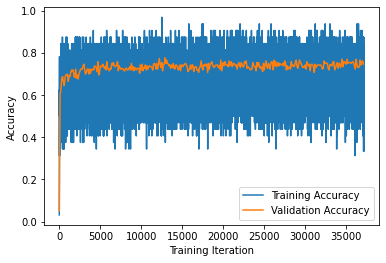

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}-finetuned-{hash_key(finetuning_model_key)}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x[:max_training_samples]),
        get_embeds(valid_x)
    ),
    main_data_key
)

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    print(train_x_embeds.shape)
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=256
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{hash_key(main_data_key)}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.220 Validation Loss: 2.222 Accuracy: 0.094 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.220 Validation Loss: 2.222 Accuracy: 0.090 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.223 Validation Loss: 2.222 Accuracy: 0.091 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.220 Validation Loss: 2.222 Accuracy: 0.098 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.219 Validation Loss: 2.222 Accuracy: 0.100 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.219 Validation Loss: 2.222 Accuracy: 0.094 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.218 Validation Loss: 2.222 Accuracy: 0.087 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.218 Validation Loss: 2.222 Accuracy: 0.087 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.216 Validation Loss: 2.222 Accuracy: 0.086 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.215 Validation Loss: 2.222 Accuracy: 0.087 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.214 Validation Loss: 2.222 Accuracy: 0.089 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.212 Validation Loss: 2.222 Accuracy: 0.090 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.211 Validation Loss: 2.222 Accuracy: 0.092 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.209 Validation Loss: 2.222 Accuracy: 0.095 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.208 Validation Loss: 2.222 Accuracy: 0.098 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.208 Validation Loss: 2.222 Accuracy: 0.103 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.206 Validation Loss: 2.222 Accuracy: 0.108 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.206 Validation Loss: 2.222 Accuracy: 0.110 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.205 Validation Loss: 2.222 Accuracy: 0.118 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.204 Validation Loss: 2.222 Accuracy: 0.123 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 20 Loss: 2.202 Validation Loss: 2.222 Accuracy: 0.127 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 21 Loss: 2.199 Validation Loss: 2.222 Accuracy: 0.135 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 22 Loss: 2.197 Validation Loss: 2.222 Accuracy: 0.145 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 23 Loss: 2.196 Validation Loss: 2.222 Accuracy: 0.142 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 23 Loss: 2.196 Validation Loss: 2.222 Accuracy: 0.142 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 24 Loss: 2.194 Validation Loss: 2.222 Accuracy: 0.151 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 25 Loss: 2.192 Validation Loss: 2.222 Accuracy: 0.164 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 26 Loss: 2.190 Validation Loss: 2.222 Accuracy: 0.186 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

(200000, 10, 769)


Epoch: 0 Iteration: 27 Loss: 2.188 Validation Loss: 2.222 Accuracy: 0.201 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 28 Loss: 2.186 Validation Loss: 2.222 Accuracy: 0.211 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 29 Loss: 2.184 Validation Loss: 2.222 Accuracy: 0.223 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 30 Loss: 2.183 Validation Loss: 2.222 Accuracy: 0.234 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 31 Loss: 2.181 Validation Loss: 2.222 Accuracy: 0.247 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 32 Loss: 2.179 Validation Loss: 2.222 Accuracy: 0.255 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 33 Loss: 2.177 Validation Loss: 2.222 Accuracy: 0.268 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 34 Loss: 2.176 Validation Loss: 2.222 Accuracy: 0.273 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 35 Loss: 2.173 Validation Loss: 2.222 Accuracy: 0.280 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 36 Loss: 2.172 Validation Loss: 2.222 Accuracy: 0.274 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 37 Loss: 2.169 Validation Loss: 2.222 Accuracy: 0.276 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 38 Loss: 2.168 Validation Loss: 2.222 Accuracy: 0.281 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 39 Loss: 2.165 Validation Loss: 2.222 Accuracy: 0.289 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 40 Loss: 2.163 Validation Loss: 2.222 Accuracy: 0.295 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 41 Loss: 2.162 Validation Loss: 2.222 Accuracy: 0.290 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 42 Loss: 2.160 Validation Loss: 2.222 Accuracy: 0.290 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 43 Loss: 2.158 Validation Loss: 2.222 Accuracy: 0.303 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 44 Loss: 2.155 Validation Loss: 2.222 Accuracy: 0.307 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 45 Loss: 2.153 Validation Loss: 2.222 Accuracy: 0.307 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 46 Loss: 2.151 Validation Loss: 2.222 Accuracy: 0.314 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 47 Loss: 2.149 Validation Loss: 2.222 Accuracy: 0.315 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 48 Loss: 2.147 Validation Loss: 2.222 Accuracy: 0.321 Validation Accuracy: 0.078:   2%|▏         | 24/1563 [00:00<00:06, 235.74it/s]

Epoch: 0 Iteration: 48 Loss: 2.147 Validation Loss: 2.222 Accuracy: 0.321 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 49 Loss: 2.145 Validation Loss: 2.222 Accuracy: 0.323 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 50 Loss: 2.142 Validation Loss: 2.222 Accuracy: 0.325 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 51 Loss: 2.140 Validation Loss: 2.222 Accuracy: 0.330 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 52 Loss: 2.138 Validation Loss: 2.222 Accuracy: 0.341 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 53 Loss: 2.136 Validation Loss: 2.222 Accuracy: 0.335 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 54 Loss: 2.133 Validation Loss: 2.222 Accuracy: 0.348 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 55 Loss: 2.132 Validation Loss: 2.222 Accuracy: 0.348 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 56 Loss: 2.130 Validation Loss: 2.222 Accuracy: 0.345 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 57 Loss: 2.126 Validation Loss: 2.222 Accuracy: 0.359 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 58 Loss: 2.124 Validation Loss: 2.222 Accuracy: 0.359 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 59 Loss: 2.123 Validation Loss: 2.222 Accuracy: 0.357 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 60 Loss: 2.122 Validation Loss: 2.222 Accuracy: 0.352 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 61 Loss: 2.120 Validation Loss: 2.222 Accuracy: 0.351 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 62 Loss: 2.118 Validation Loss: 2.222 Accuracy: 0.343 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 63 Loss: 2.117 Validation Loss: 2.222 Accuracy: 0.342 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 64 Loss: 2.115 Validation Loss: 2.222 Accuracy: 0.330 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 65 Loss: 2.115 Validation Loss: 2.222 Accuracy: 0.329 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 66 Loss: 2.111 Validation Loss: 2.222 Accuracy: 0.334 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 67 Loss: 2.109 Validation Loss: 2.222 Accuracy: 0.331 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 68 Loss: 2.109 Validation Loss: 2.222 Accuracy: 0.324 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 69 Loss: 2.106 Validation Loss: 2.222 Accuracy: 0.331 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 70 Loss: 2.105 Validation Loss: 2.222 Accuracy: 0.336 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 71 Loss: 2.102 Validation Loss: 2.222 Accuracy: 0.341 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 72 Loss: 2.099 Validation Loss: 2.222 Accuracy: 0.348 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 73 Loss: 2.097 Validation Loss: 2.222 Accuracy: 0.352 Validation Accuracy: 0.078:   3%|▎         | 49/1563 [00:00<00:06, 242.71it/s]

Epoch: 0 Iteration: 73 Loss: 2.097 Validation Loss: 2.222 Accuracy: 0.352 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 74 Loss: 2.097 Validation Loss: 2.222 Accuracy: 0.348 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 75 Loss: 2.095 Validation Loss: 2.222 Accuracy: 0.355 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 76 Loss: 2.093 Validation Loss: 2.222 Accuracy: 0.352 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 77 Loss: 2.092 Validation Loss: 2.222 Accuracy: 0.352 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 78 Loss: 2.090 Validation Loss: 2.222 Accuracy: 0.355 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 79 Loss: 2.087 Validation Loss: 2.222 Accuracy: 0.356 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 80 Loss: 2.084 Validation Loss: 2.222 Accuracy: 0.366 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 81 Loss: 2.082 Validation Loss: 2.222 Accuracy: 0.370 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 82 Loss: 2.078 Validation Loss: 2.222 Accuracy: 0.373 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 83 Loss: 2.076 Validation Loss: 2.222 Accuracy: 0.374 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 84 Loss: 2.074 Validation Loss: 2.222 Accuracy: 0.381 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 85 Loss: 2.071 Validation Loss: 2.222 Accuracy: 0.385 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 86 Loss: 2.069 Validation Loss: 2.222 Accuracy: 0.402 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 87 Loss: 2.065 Validation Loss: 2.222 Accuracy: 0.405 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 88 Loss: 2.060 Validation Loss: 2.222 Accuracy: 0.414 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 89 Loss: 2.060 Validation Loss: 2.222 Accuracy: 0.410 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 90 Loss: 2.057 Validation Loss: 2.222 Accuracy: 0.411 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 91 Loss: 2.055 Validation Loss: 2.222 Accuracy: 0.408 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 92 Loss: 2.054 Validation Loss: 2.222 Accuracy: 0.411 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 93 Loss: 2.053 Validation Loss: 2.222 Accuracy: 0.407 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 94 Loss: 2.050 Validation Loss: 2.222 Accuracy: 0.412 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 95 Loss: 2.047 Validation Loss: 2.222 Accuracy: 0.408 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 96 Loss: 2.044 Validation Loss: 2.222 Accuracy: 0.402 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 97 Loss: 2.044 Validation Loss: 2.222 Accuracy: 0.398 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 98 Loss: 2.041 Validation Loss: 2.222 Accuracy: 0.395 Validation Accuracy: 0.078:   5%|▍         | 74/1563 [00:00<00:06, 243.44it/s]

Epoch: 0 Iteration: 98 Loss: 2.041 Validation Loss: 2.222 Accuracy: 0.395 Validation Accuracy: 0.078:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 99 Loss: 2.040 Validation Loss: 2.222 Accuracy: 0.400 Validation Accuracy: 0.078:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 100 Loss: 2.039 Validation Loss: 2.026 Accuracy: 0.395 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 101 Loss: 2.035 Validation Loss: 2.026 Accuracy: 0.396 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 102 Loss: 2.034 Validation Loss: 2.026 Accuracy: 0.391 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 103 Loss: 2.032 Validation Loss: 2.026 Accuracy: 0.398 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 104 Loss: 2.029 Validation Loss: 2.026 Accuracy: 0.398 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 105 Loss: 2.028 Validation Loss: 2.026 Accuracy: 0.400 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 106 Loss: 2.026 Validation Loss: 2.026 Accuracy: 0.404 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 107 Loss: 2.025 Validation Loss: 2.026 Accuracy: 0.405 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 108 Loss: 2.023 Validation Loss: 2.026 Accuracy: 0.405 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 109 Loss: 2.020 Validation Loss: 2.026 Accuracy: 0.407 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 110 Loss: 2.019 Validation Loss: 2.026 Accuracy: 0.412 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 111 Loss: 2.017 Validation Loss: 2.026 Accuracy: 0.412 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 112 Loss: 2.012 Validation Loss: 2.026 Accuracy: 0.419 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 113 Loss: 2.007 Validation Loss: 2.026 Accuracy: 0.427 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 114 Loss: 2.006 Validation Loss: 2.026 Accuracy: 0.433 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 115 Loss: 2.004 Validation Loss: 2.026 Accuracy: 0.437 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 116 Loss: 2.001 Validation Loss: 2.026 Accuracy: 0.438 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 117 Loss: 1.998 Validation Loss: 2.026 Accuracy: 0.451 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 118 Loss: 1.993 Validation Loss: 2.026 Accuracy: 0.464 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 119 Loss: 1.991 Validation Loss: 2.026 Accuracy: 0.463 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 120 Loss: 1.990 Validation Loss: 2.026 Accuracy: 0.463 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 121 Loss: 1.986 Validation Loss: 2.026 Accuracy: 0.477 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 122 Loss: 1.985 Validation Loss: 2.026 Accuracy: 0.484 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 123 Loss: 1.981 Validation Loss: 2.026 Accuracy: 0.488 Validation Accuracy: 0.221:   6%|▋         | 99/1563 [00:00<00:05, 244.35it/s]

Epoch: 0 Iteration: 123 Loss: 1.981 Validation Loss: 2.026 Accuracy: 0.488 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 124 Loss: 1.978 Validation Loss: 2.026 Accuracy: 0.485 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 125 Loss: 1.972 Validation Loss: 2.026 Accuracy: 0.491 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 126 Loss: 1.973 Validation Loss: 2.026 Accuracy: 0.487 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 127 Loss: 1.971 Validation Loss: 2.026 Accuracy: 0.482 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 128 Loss: 1.970 Validation Loss: 2.026 Accuracy: 0.471 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 129 Loss: 1.965 Validation Loss: 2.026 Accuracy: 0.488 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 130 Loss: 1.961 Validation Loss: 2.026 Accuracy: 0.497 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 131 Loss: 1.961 Validation Loss: 2.026 Accuracy: 0.490 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 132 Loss: 1.964 Validation Loss: 2.026 Accuracy: 0.487 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 133 Loss: 1.960 Validation Loss: 2.026 Accuracy: 0.493 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 134 Loss: 1.957 Validation Loss: 2.026 Accuracy: 0.497 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 135 Loss: 1.953 Validation Loss: 2.026 Accuracy: 0.501 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 136 Loss: 1.951 Validation Loss: 2.026 Accuracy: 0.510 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 137 Loss: 1.946 Validation Loss: 2.026 Accuracy: 0.512 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 138 Loss: 1.942 Validation Loss: 2.026 Accuracy: 0.525 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 139 Loss: 1.939 Validation Loss: 2.026 Accuracy: 0.512 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 140 Loss: 1.938 Validation Loss: 2.026 Accuracy: 0.509 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 141 Loss: 1.936 Validation Loss: 2.026 Accuracy: 0.512 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 142 Loss: 1.932 Validation Loss: 2.026 Accuracy: 0.519 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 143 Loss: 1.931 Validation Loss: 2.026 Accuracy: 0.510 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 144 Loss: 1.929 Validation Loss: 2.026 Accuracy: 0.514 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 145 Loss: 1.925 Validation Loss: 2.026 Accuracy: 0.519 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 146 Loss: 1.923 Validation Loss: 2.026 Accuracy: 0.515 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 147 Loss: 1.921 Validation Loss: 2.026 Accuracy: 0.514 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 148 Loss: 1.916 Validation Loss: 2.026 Accuracy: 0.509 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 149 Loss: 1.912 Validation Loss: 2.026 Accuracy: 0.527 Validation Accuracy: 0.221:   8%|▊         | 124/1563 [00:00<00:05, 244.48it/s]

Epoch: 0 Iteration: 149 Loss: 1.912 Validation Loss: 2.026 Accuracy: 0.527 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 150 Loss: 1.912 Validation Loss: 2.026 Accuracy: 0.537 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 151 Loss: 1.907 Validation Loss: 2.026 Accuracy: 0.546 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 152 Loss: 1.897 Validation Loss: 2.026 Accuracy: 0.554 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 153 Loss: 1.896 Validation Loss: 2.026 Accuracy: 0.570 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 154 Loss: 1.893 Validation Loss: 2.026 Accuracy: 0.574 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 155 Loss: 1.892 Validation Loss: 2.026 Accuracy: 0.564 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 156 Loss: 1.887 Validation Loss: 2.026 Accuracy: 0.577 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 157 Loss: 1.888 Validation Loss: 2.026 Accuracy: 0.585 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 158 Loss: 1.888 Validation Loss: 2.026 Accuracy: 0.598 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 159 Loss: 1.883 Validation Loss: 2.026 Accuracy: 0.597 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 160 Loss: 1.879 Validation Loss: 2.026 Accuracy: 0.591 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 161 Loss: 1.876 Validation Loss: 2.026 Accuracy: 0.594 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 162 Loss: 1.872 Validation Loss: 2.026 Accuracy: 0.582 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 163 Loss: 1.872 Validation Loss: 2.026 Accuracy: 0.574 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 164 Loss: 1.870 Validation Loss: 2.026 Accuracy: 0.574 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 165 Loss: 1.871 Validation Loss: 2.026 Accuracy: 0.579 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 166 Loss: 1.864 Validation Loss: 2.026 Accuracy: 0.574 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 167 Loss: 1.858 Validation Loss: 2.026 Accuracy: 0.577 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 168 Loss: 1.855 Validation Loss: 2.026 Accuracy: 0.578 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 169 Loss: 1.858 Validation Loss: 2.026 Accuracy: 0.571 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 170 Loss: 1.854 Validation Loss: 2.026 Accuracy: 0.579 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 171 Loss: 1.852 Validation Loss: 2.026 Accuracy: 0.579 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 172 Loss: 1.852 Validation Loss: 2.026 Accuracy: 0.581 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 173 Loss: 1.846 Validation Loss: 2.026 Accuracy: 0.592 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 174 Loss: 1.842 Validation Loss: 2.026 Accuracy: 0.599 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 175 Loss: 1.839 Validation Loss: 2.026 Accuracy: 0.603 Validation Accuracy: 0.221:  10%|▉         | 150/1563 [00:00<00:05, 246.79it/s]

Epoch: 0 Iteration: 175 Loss: 1.839 Validation Loss: 2.026 Accuracy: 0.603 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 176 Loss: 1.834 Validation Loss: 2.026 Accuracy: 0.609 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 177 Loss: 1.831 Validation Loss: 2.026 Accuracy: 0.611 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 178 Loss: 1.830 Validation Loss: 2.026 Accuracy: 0.605 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 179 Loss: 1.830 Validation Loss: 2.026 Accuracy: 0.616 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 180 Loss: 1.822 Validation Loss: 2.026 Accuracy: 0.623 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 181 Loss: 1.825 Validation Loss: 2.026 Accuracy: 0.619 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 182 Loss: 1.825 Validation Loss: 2.026 Accuracy: 0.626 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 183 Loss: 1.821 Validation Loss: 2.026 Accuracy: 0.625 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 184 Loss: 1.819 Validation Loss: 2.026 Accuracy: 0.627 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 185 Loss: 1.816 Validation Loss: 2.026 Accuracy: 0.635 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 186 Loss: 1.812 Validation Loss: 2.026 Accuracy: 0.640 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 187 Loss: 1.811 Validation Loss: 2.026 Accuracy: 0.641 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 188 Loss: 1.805 Validation Loss: 2.026 Accuracy: 0.655 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 189 Loss: 1.803 Validation Loss: 2.026 Accuracy: 0.647 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 190 Loss: 1.798 Validation Loss: 2.026 Accuracy: 0.641 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 191 Loss: 1.793 Validation Loss: 2.026 Accuracy: 0.652 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 192 Loss: 1.790 Validation Loss: 2.026 Accuracy: 0.657 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 193 Loss: 1.790 Validation Loss: 2.026 Accuracy: 0.654 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 194 Loss: 1.788 Validation Loss: 2.026 Accuracy: 0.650 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 195 Loss: 1.782 Validation Loss: 2.026 Accuracy: 0.659 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 196 Loss: 1.779 Validation Loss: 2.026 Accuracy: 0.660 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 197 Loss: 1.772 Validation Loss: 2.026 Accuracy: 0.661 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 198 Loss: 1.765 Validation Loss: 2.026 Accuracy: 0.659 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 199 Loss: 1.757 Validation Loss: 2.026 Accuracy: 0.670 Validation Accuracy: 0.221:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 200 Loss: 1.759 Validation Loss: 1.752 Accuracy: 0.666 Validation Accuracy: 0.361:  11%|█▏        | 176/1563 [00:00<00:05, 248.47it/s]

Epoch: 0 Iteration: 200 Loss: 1.759 Validation Loss: 1.752 Accuracy: 0.666 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 201 Loss: 1.749 Validation Loss: 1.752 Accuracy: 0.668 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 202 Loss: 1.746 Validation Loss: 1.752 Accuracy: 0.669 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 203 Loss: 1.738 Validation Loss: 1.752 Accuracy: 0.677 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 204 Loss: 1.732 Validation Loss: 1.752 Accuracy: 0.681 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 205 Loss: 1.729 Validation Loss: 1.752 Accuracy: 0.667 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 206 Loss: 1.731 Validation Loss: 1.752 Accuracy: 0.666 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 207 Loss: 1.725 Validation Loss: 1.752 Accuracy: 0.670 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 208 Loss: 1.721 Validation Loss: 1.752 Accuracy: 0.668 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 209 Loss: 1.711 Validation Loss: 1.752 Accuracy: 0.675 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 210 Loss: 1.710 Validation Loss: 1.752 Accuracy: 0.689 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 211 Loss: 1.714 Validation Loss: 1.752 Accuracy: 0.672 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 212 Loss: 1.715 Validation Loss: 1.752 Accuracy: 0.670 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 213 Loss: 1.709 Validation Loss: 1.752 Accuracy: 0.662 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 214 Loss: 1.707 Validation Loss: 1.752 Accuracy: 0.663 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 215 Loss: 1.713 Validation Loss: 1.752 Accuracy: 0.669 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 216 Loss: 1.708 Validation Loss: 1.752 Accuracy: 0.675 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 217 Loss: 1.705 Validation Loss: 1.752 Accuracy: 0.674 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 218 Loss: 1.707 Validation Loss: 1.752 Accuracy: 0.671 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 219 Loss: 1.711 Validation Loss: 1.752 Accuracy: 0.659 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 220 Loss: 1.705 Validation Loss: 1.752 Accuracy: 0.655 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 221 Loss: 1.698 Validation Loss: 1.752 Accuracy: 0.677 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 222 Loss: 1.693 Validation Loss: 1.752 Accuracy: 0.680 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 223 Loss: 1.695 Validation Loss: 1.752 Accuracy: 0.682 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 224 Loss: 1.690 Validation Loss: 1.752 Accuracy: 0.691 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 225 Loss: 1.684 Validation Loss: 1.752 Accuracy: 0.702 Validation Accuracy: 0.361:  13%|█▎        | 201/1563 [00:00<00:05, 245.58it/s]

Epoch: 0 Iteration: 225 Loss: 1.684 Validation Loss: 1.752 Accuracy: 0.702 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 226 Loss: 1.679 Validation Loss: 1.752 Accuracy: 0.700 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 227 Loss: 1.674 Validation Loss: 1.752 Accuracy: 0.706 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 228 Loss: 1.671 Validation Loss: 1.752 Accuracy: 0.718 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 229 Loss: 1.670 Validation Loss: 1.752 Accuracy: 0.723 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 230 Loss: 1.667 Validation Loss: 1.752 Accuracy: 0.723 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 231 Loss: 1.654 Validation Loss: 1.752 Accuracy: 0.720 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 232 Loss: 1.643 Validation Loss: 1.752 Accuracy: 0.724 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 233 Loss: 1.638 Validation Loss: 1.752 Accuracy: 0.729 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 234 Loss: 1.636 Validation Loss: 1.752 Accuracy: 0.723 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 235 Loss: 1.624 Validation Loss: 1.752 Accuracy: 0.719 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 236 Loss: 1.626 Validation Loss: 1.752 Accuracy: 0.723 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 237 Loss: 1.623 Validation Loss: 1.752 Accuracy: 0.720 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 238 Loss: 1.617 Validation Loss: 1.752 Accuracy: 0.713 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 239 Loss: 1.607 Validation Loss: 1.752 Accuracy: 0.715 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 240 Loss: 1.602 Validation Loss: 1.752 Accuracy: 0.720 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 241 Loss: 1.602 Validation Loss: 1.752 Accuracy: 0.721 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 242 Loss: 1.598 Validation Loss: 1.752 Accuracy: 0.715 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 243 Loss: 1.594 Validation Loss: 1.752 Accuracy: 0.706 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:00<00:05, 244.00it/s]

Epoch: 0 Iteration: 244 Loss: 1.590 Validation Loss: 1.752 Accuracy: 0.706 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:01<00:05, 244.00it/s]

Epoch: 0 Iteration: 245 Loss: 1.582 Validation Loss: 1.752 Accuracy: 0.704 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:01<00:05, 244.00it/s]

Epoch: 0 Iteration: 246 Loss: 1.580 Validation Loss: 1.752 Accuracy: 0.696 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:01<00:05, 244.00it/s]

Epoch: 0 Iteration: 247 Loss: 1.579 Validation Loss: 1.752 Accuracy: 0.697 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:01<00:05, 244.00it/s]

Epoch: 0 Iteration: 248 Loss: 1.575 Validation Loss: 1.752 Accuracy: 0.700 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:01<00:05, 244.00it/s]

Epoch: 0 Iteration: 249 Loss: 1.574 Validation Loss: 1.752 Accuracy: 0.695 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:01<00:05, 244.00it/s]

Epoch: 0 Iteration: 250 Loss: 1.572 Validation Loss: 1.752 Accuracy: 0.689 Validation Accuracy: 0.361:  14%|█▍        | 226/1563 [00:01<00:05, 244.00it/s]

Epoch: 0 Iteration: 250 Loss: 1.572 Validation Loss: 1.752 Accuracy: 0.689 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 251 Loss: 1.571 Validation Loss: 1.752 Accuracy: 0.685 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 252 Loss: 1.570 Validation Loss: 1.752 Accuracy: 0.693 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 253 Loss: 1.563 Validation Loss: 1.752 Accuracy: 0.702 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 254 Loss: 1.553 Validation Loss: 1.752 Accuracy: 0.709 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 255 Loss: 1.549 Validation Loss: 1.752 Accuracy: 0.711 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 256 Loss: 1.542 Validation Loss: 1.752 Accuracy: 0.716 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 257 Loss: 1.538 Validation Loss: 1.752 Accuracy: 0.716 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 258 Loss: 1.530 Validation Loss: 1.752 Accuracy: 0.722 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 259 Loss: 1.529 Validation Loss: 1.752 Accuracy: 0.723 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 260 Loss: 1.526 Validation Loss: 1.752 Accuracy: 0.725 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 261 Loss: 1.525 Validation Loss: 1.752 Accuracy: 0.722 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 262 Loss: 1.517 Validation Loss: 1.752 Accuracy: 0.726 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 263 Loss: 1.511 Validation Loss: 1.752 Accuracy: 0.721 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 264 Loss: 1.508 Validation Loss: 1.752 Accuracy: 0.717 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 265 Loss: 1.513 Validation Loss: 1.752 Accuracy: 0.712 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 266 Loss: 1.509 Validation Loss: 1.752 Accuracy: 0.708 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 267 Loss: 1.504 Validation Loss: 1.752 Accuracy: 0.709 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 268 Loss: 1.506 Validation Loss: 1.752 Accuracy: 0.696 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 269 Loss: 1.506 Validation Loss: 1.752 Accuracy: 0.698 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 270 Loss: 1.497 Validation Loss: 1.752 Accuracy: 0.703 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 271 Loss: 1.491 Validation Loss: 1.752 Accuracy: 0.706 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 272 Loss: 1.492 Validation Loss: 1.752 Accuracy: 0.696 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 273 Loss: 1.493 Validation Loss: 1.752 Accuracy: 0.697 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 274 Loss: 1.491 Validation Loss: 1.752 Accuracy: 0.698 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 275 Loss: 1.485 Validation Loss: 1.752 Accuracy: 0.705 Validation Accuracy: 0.361:  16%|█▌        | 251/1563 [00:01<00:05, 244.55it/s]

Epoch: 0 Iteration: 275 Loss: 1.485 Validation Loss: 1.752 Accuracy: 0.705 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 276 Loss: 1.481 Validation Loss: 1.752 Accuracy: 0.712 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 277 Loss: 1.476 Validation Loss: 1.752 Accuracy: 0.713 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 278 Loss: 1.476 Validation Loss: 1.752 Accuracy: 0.713 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 279 Loss: 1.469 Validation Loss: 1.752 Accuracy: 0.718 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 280 Loss: 1.464 Validation Loss: 1.752 Accuracy: 0.714 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 281 Loss: 1.457 Validation Loss: 1.752 Accuracy: 0.723 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 282 Loss: 1.462 Validation Loss: 1.752 Accuracy: 0.722 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 283 Loss: 1.459 Validation Loss: 1.752 Accuracy: 0.720 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 284 Loss: 1.455 Validation Loss: 1.752 Accuracy: 0.720 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 285 Loss: 1.444 Validation Loss: 1.752 Accuracy: 0.716 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 286 Loss: 1.433 Validation Loss: 1.752 Accuracy: 0.719 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 287 Loss: 1.434 Validation Loss: 1.752 Accuracy: 0.709 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 288 Loss: 1.427 Validation Loss: 1.752 Accuracy: 0.716 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 289 Loss: 1.423 Validation Loss: 1.752 Accuracy: 0.705 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 290 Loss: 1.421 Validation Loss: 1.752 Accuracy: 0.705 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 291 Loss: 1.417 Validation Loss: 1.752 Accuracy: 0.703 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 292 Loss: 1.416 Validation Loss: 1.752 Accuracy: 0.704 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 293 Loss: 1.409 Validation Loss: 1.752 Accuracy: 0.711 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 294 Loss: 1.406 Validation Loss: 1.752 Accuracy: 0.710 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 295 Loss: 1.405 Validation Loss: 1.752 Accuracy: 0.711 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 296 Loss: 1.409 Validation Loss: 1.752 Accuracy: 0.704 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 297 Loss: 1.403 Validation Loss: 1.752 Accuracy: 0.718 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 298 Loss: 1.399 Validation Loss: 1.752 Accuracy: 0.715 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 299 Loss: 1.406 Validation Loss: 1.752 Accuracy: 0.712 Validation Accuracy: 0.361:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 300 Loss: 1.397 Validation Loss: 1.362 Accuracy: 0.713 Validation Accuracy: 0.447:  18%|█▊        | 276/1563 [00:01<00:05, 245.45it/s]

Epoch: 0 Iteration: 300 Loss: 1.397 Validation Loss: 1.362 Accuracy: 0.713 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 301 Loss: 1.398 Validation Loss: 1.362 Accuracy: 0.709 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 302 Loss: 1.390 Validation Loss: 1.362 Accuracy: 0.710 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 303 Loss: 1.388 Validation Loss: 1.362 Accuracy: 0.705 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 304 Loss: 1.386 Validation Loss: 1.362 Accuracy: 0.702 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 305 Loss: 1.379 Validation Loss: 1.362 Accuracy: 0.703 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 306 Loss: 1.381 Validation Loss: 1.362 Accuracy: 0.705 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 307 Loss: 1.382 Validation Loss: 1.362 Accuracy: 0.691 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 308 Loss: 1.376 Validation Loss: 1.362 Accuracy: 0.693 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 309 Loss: 1.360 Validation Loss: 1.362 Accuracy: 0.713 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 310 Loss: 1.354 Validation Loss: 1.362 Accuracy: 0.713 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 311 Loss: 1.350 Validation Loss: 1.362 Accuracy: 0.711 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 312 Loss: 1.340 Validation Loss: 1.362 Accuracy: 0.715 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 313 Loss: 1.347 Validation Loss: 1.362 Accuracy: 0.710 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 314 Loss: 1.344 Validation Loss: 1.362 Accuracy: 0.716 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 315 Loss: 1.341 Validation Loss: 1.362 Accuracy: 0.710 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 316 Loss: 1.333 Validation Loss: 1.362 Accuracy: 0.708 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 317 Loss: 1.332 Validation Loss: 1.362 Accuracy: 0.710 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 318 Loss: 1.325 Validation Loss: 1.362 Accuracy: 0.715 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 319 Loss: 1.315 Validation Loss: 1.362 Accuracy: 0.701 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 320 Loss: 1.318 Validation Loss: 1.362 Accuracy: 0.699 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 321 Loss: 1.310 Validation Loss: 1.362 Accuracy: 0.702 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 322 Loss: 1.303 Validation Loss: 1.362 Accuracy: 0.698 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 323 Loss: 1.298 Validation Loss: 1.362 Accuracy: 0.704 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 324 Loss: 1.287 Validation Loss: 1.362 Accuracy: 0.706 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 325 Loss: 1.289 Validation Loss: 1.362 Accuracy: 0.708 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 326 Loss: 1.283 Validation Loss: 1.362 Accuracy: 0.709 Validation Accuracy: 0.447:  19%|█▉        | 301/1563 [00:01<00:05, 244.90it/s]

Epoch: 0 Iteration: 326 Loss: 1.283 Validation Loss: 1.362 Accuracy: 0.709 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 327 Loss: 1.276 Validation Loss: 1.362 Accuracy: 0.711 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 328 Loss: 1.274 Validation Loss: 1.362 Accuracy: 0.707 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 329 Loss: 1.280 Validation Loss: 1.362 Accuracy: 0.713 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 330 Loss: 1.268 Validation Loss: 1.362 Accuracy: 0.720 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 331 Loss: 1.266 Validation Loss: 1.362 Accuracy: 0.715 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 332 Loss: 1.272 Validation Loss: 1.362 Accuracy: 0.711 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 333 Loss: 1.261 Validation Loss: 1.362 Accuracy: 0.711 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 334 Loss: 1.260 Validation Loss: 1.362 Accuracy: 0.702 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 335 Loss: 1.253 Validation Loss: 1.362 Accuracy: 0.708 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 336 Loss: 1.245 Validation Loss: 1.362 Accuracy: 0.712 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 337 Loss: 1.238 Validation Loss: 1.362 Accuracy: 0.716 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 338 Loss: 1.235 Validation Loss: 1.362 Accuracy: 0.715 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 339 Loss: 1.229 Validation Loss: 1.362 Accuracy: 0.712 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 340 Loss: 1.225 Validation Loss: 1.362 Accuracy: 0.705 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 341 Loss: 1.224 Validation Loss: 1.362 Accuracy: 0.700 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 342 Loss: 1.219 Validation Loss: 1.362 Accuracy: 0.709 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 343 Loss: 1.214 Validation Loss: 1.362 Accuracy: 0.711 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 344 Loss: 1.215 Validation Loss: 1.362 Accuracy: 0.717 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 345 Loss: 1.209 Validation Loss: 1.362 Accuracy: 0.715 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 346 Loss: 1.203 Validation Loss: 1.362 Accuracy: 0.715 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 347 Loss: 1.200 Validation Loss: 1.362 Accuracy: 0.709 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 348 Loss: 1.198 Validation Loss: 1.362 Accuracy: 0.710 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 349 Loss: 1.186 Validation Loss: 1.362 Accuracy: 0.713 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 350 Loss: 1.191 Validation Loss: 1.362 Accuracy: 0.719 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 351 Loss: 1.198 Validation Loss: 1.362 Accuracy: 0.717 Validation Accuracy: 0.447:  21%|██        | 327/1563 [00:01<00:05, 246.60it/s]

Epoch: 0 Iteration: 351 Loss: 1.198 Validation Loss: 1.362 Accuracy: 0.717 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 352 Loss: 1.188 Validation Loss: 1.362 Accuracy: 0.713 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 353 Loss: 1.181 Validation Loss: 1.362 Accuracy: 0.713 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 354 Loss: 1.175 Validation Loss: 1.362 Accuracy: 0.708 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 355 Loss: 1.171 Validation Loss: 1.362 Accuracy: 0.706 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 356 Loss: 1.164 Validation Loss: 1.362 Accuracy: 0.708 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 357 Loss: 1.166 Validation Loss: 1.362 Accuracy: 0.707 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 358 Loss: 1.164 Validation Loss: 1.362 Accuracy: 0.709 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 359 Loss: 1.166 Validation Loss: 1.362 Accuracy: 0.695 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 360 Loss: 1.165 Validation Loss: 1.362 Accuracy: 0.690 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 361 Loss: 1.160 Validation Loss: 1.362 Accuracy: 0.699 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 362 Loss: 1.153 Validation Loss: 1.362 Accuracy: 0.708 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 363 Loss: 1.153 Validation Loss: 1.362 Accuracy: 0.703 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 364 Loss: 1.150 Validation Loss: 1.362 Accuracy: 0.705 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 365 Loss: 1.150 Validation Loss: 1.362 Accuracy: 0.702 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 366 Loss: 1.152 Validation Loss: 1.362 Accuracy: 0.693 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 367 Loss: 1.137 Validation Loss: 1.362 Accuracy: 0.706 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 368 Loss: 1.123 Validation Loss: 1.362 Accuracy: 0.709 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 369 Loss: 1.116 Validation Loss: 1.362 Accuracy: 0.729 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 370 Loss: 1.106 Validation Loss: 1.362 Accuracy: 0.734 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 371 Loss: 1.094 Validation Loss: 1.362 Accuracy: 0.732 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 372 Loss: 1.087 Validation Loss: 1.362 Accuracy: 0.723 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 373 Loss: 1.088 Validation Loss: 1.362 Accuracy: 0.727 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 374 Loss: 1.089 Validation Loss: 1.362 Accuracy: 0.726 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 375 Loss: 1.078 Validation Loss: 1.362 Accuracy: 0.735 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 376 Loss: 1.078 Validation Loss: 1.362 Accuracy: 0.743 Validation Accuracy: 0.447:  23%|██▎       | 352/1563 [00:01<00:04, 246.97it/s]

Epoch: 0 Iteration: 376 Loss: 1.078 Validation Loss: 1.362 Accuracy: 0.743 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 377 Loss: 1.069 Validation Loss: 1.362 Accuracy: 0.739 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 378 Loss: 1.067 Validation Loss: 1.362 Accuracy: 0.736 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 379 Loss: 1.058 Validation Loss: 1.362 Accuracy: 0.727 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 380 Loss: 1.057 Validation Loss: 1.362 Accuracy: 0.723 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 381 Loss: 1.048 Validation Loss: 1.362 Accuracy: 0.730 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 382 Loss: 1.056 Validation Loss: 1.362 Accuracy: 0.728 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 383 Loss: 1.048 Validation Loss: 1.362 Accuracy: 0.732 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 384 Loss: 1.039 Validation Loss: 1.362 Accuracy: 0.738 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 385 Loss: 1.042 Validation Loss: 1.362 Accuracy: 0.730 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 386 Loss: 1.038 Validation Loss: 1.362 Accuracy: 0.723 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 387 Loss: 1.046 Validation Loss: 1.362 Accuracy: 0.716 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 388 Loss: 1.047 Validation Loss: 1.362 Accuracy: 0.718 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 389 Loss: 1.052 Validation Loss: 1.362 Accuracy: 0.716 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 390 Loss: 1.059 Validation Loss: 1.362 Accuracy: 0.719 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 391 Loss: 1.056 Validation Loss: 1.362 Accuracy: 0.713 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 392 Loss: 1.056 Validation Loss: 1.362 Accuracy: 0.716 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 393 Loss: 1.057 Validation Loss: 1.362 Accuracy: 0.710 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 394 Loss: 1.048 Validation Loss: 1.362 Accuracy: 0.709 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 395 Loss: 1.043 Validation Loss: 1.362 Accuracy: 0.722 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 396 Loss: 1.046 Validation Loss: 1.362 Accuracy: 0.723 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 397 Loss: 1.046 Validation Loss: 1.362 Accuracy: 0.727 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 398 Loss: 1.043 Validation Loss: 1.362 Accuracy: 0.721 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 399 Loss: 1.038 Validation Loss: 1.362 Accuracy: 0.722 Validation Accuracy: 0.447:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 400 Loss: 1.027 Validation Loss: 1.034 Accuracy: 0.727 Validation Accuracy: 0.499:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 401 Loss: 1.030 Validation Loss: 1.034 Accuracy: 0.727 Validation Accuracy: 0.499:  24%|██▍       | 377/1563 [00:01<00:04, 247.45it/s]

Epoch: 0 Iteration: 401 Loss: 1.030 Validation Loss: 1.034 Accuracy: 0.727 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 402 Loss: 1.025 Validation Loss: 1.034 Accuracy: 0.727 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 403 Loss: 1.028 Validation Loss: 1.034 Accuracy: 0.724 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 404 Loss: 1.028 Validation Loss: 1.034 Accuracy: 0.729 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 405 Loss: 1.017 Validation Loss: 1.034 Accuracy: 0.719 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 406 Loss: 1.010 Validation Loss: 1.034 Accuracy: 0.723 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 407 Loss: 1.002 Validation Loss: 1.034 Accuracy: 0.725 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 408 Loss: 1.003 Validation Loss: 1.034 Accuracy: 0.732 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 409 Loss: 0.994 Validation Loss: 1.034 Accuracy: 0.740 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 410 Loss: 0.989 Validation Loss: 1.034 Accuracy: 0.738 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 411 Loss: 0.985 Validation Loss: 1.034 Accuracy: 0.739 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 412 Loss: 0.986 Validation Loss: 1.034 Accuracy: 0.740 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 413 Loss: 0.974 Validation Loss: 1.034 Accuracy: 0.745 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 414 Loss: 0.976 Validation Loss: 1.034 Accuracy: 0.745 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 415 Loss: 0.979 Validation Loss: 1.034 Accuracy: 0.750 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 416 Loss: 0.977 Validation Loss: 1.034 Accuracy: 0.746 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 417 Loss: 0.978 Validation Loss: 1.034 Accuracy: 0.744 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 418 Loss: 0.978 Validation Loss: 1.034 Accuracy: 0.737 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 419 Loss: 0.976 Validation Loss: 1.034 Accuracy: 0.731 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 420 Loss: 0.975 Validation Loss: 1.034 Accuracy: 0.730 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 421 Loss: 0.970 Validation Loss: 1.034 Accuracy: 0.730 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 422 Loss: 0.971 Validation Loss: 1.034 Accuracy: 0.730 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 423 Loss: 0.968 Validation Loss: 1.034 Accuracy: 0.727 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 424 Loss: 0.970 Validation Loss: 1.034 Accuracy: 0.723 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 425 Loss: 0.975 Validation Loss: 1.034 Accuracy: 0.715 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 426 Loss: 0.973 Validation Loss: 1.034 Accuracy: 0.718 Validation Accuracy: 0.499:  26%|██▌       | 402/1563 [00:01<00:04, 246.25it/s]

Epoch: 0 Iteration: 426 Loss: 0.973 Validation Loss: 1.034 Accuracy: 0.718 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 427 Loss: 0.976 Validation Loss: 1.034 Accuracy: 0.716 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 428 Loss: 0.971 Validation Loss: 1.034 Accuracy: 0.725 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 429 Loss: 0.981 Validation Loss: 1.034 Accuracy: 0.720 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 430 Loss: 0.984 Validation Loss: 1.034 Accuracy: 0.710 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 431 Loss: 0.990 Validation Loss: 1.034 Accuracy: 0.704 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 432 Loss: 0.990 Validation Loss: 1.034 Accuracy: 0.702 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 433 Loss: 0.991 Validation Loss: 1.034 Accuracy: 0.705 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 434 Loss: 0.990 Validation Loss: 1.034 Accuracy: 0.701 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 435 Loss: 0.993 Validation Loss: 1.034 Accuracy: 0.708 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 436 Loss: 0.989 Validation Loss: 1.034 Accuracy: 0.708 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 437 Loss: 0.991 Validation Loss: 1.034 Accuracy: 0.703 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 438 Loss: 0.984 Validation Loss: 1.034 Accuracy: 0.700 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 439 Loss: 0.984 Validation Loss: 1.034 Accuracy: 0.704 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 440 Loss: 0.981 Validation Loss: 1.034 Accuracy: 0.713 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 441 Loss: 0.988 Validation Loss: 1.034 Accuracy: 0.712 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 442 Loss: 0.981 Validation Loss: 1.034 Accuracy: 0.718 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 443 Loss: 0.980 Validation Loss: 1.034 Accuracy: 0.716 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 444 Loss: 0.977 Validation Loss: 1.034 Accuracy: 0.717 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 445 Loss: 0.965 Validation Loss: 1.034 Accuracy: 0.718 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 446 Loss: 0.966 Validation Loss: 1.034 Accuracy: 0.716 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 447 Loss: 0.966 Validation Loss: 1.034 Accuracy: 0.716 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 448 Loss: 0.971 Validation Loss: 1.034 Accuracy: 0.710 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 449 Loss: 0.968 Validation Loss: 1.034 Accuracy: 0.713 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 450 Loss: 0.965 Validation Loss: 1.034 Accuracy: 0.708 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 451 Loss: 0.963 Validation Loss: 1.034 Accuracy: 0.711 Validation Accuracy: 0.499:  27%|██▋       | 427/1563 [00:01<00:04, 247.26it/s]

Epoch: 0 Iteration: 451 Loss: 0.963 Validation Loss: 1.034 Accuracy: 0.711 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 452 Loss: 0.962 Validation Loss: 1.034 Accuracy: 0.702 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 453 Loss: 0.965 Validation Loss: 1.034 Accuracy: 0.701 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 454 Loss: 0.963 Validation Loss: 1.034 Accuracy: 0.704 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 455 Loss: 0.964 Validation Loss: 1.034 Accuracy: 0.698 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 456 Loss: 0.965 Validation Loss: 1.034 Accuracy: 0.697 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 457 Loss: 0.960 Validation Loss: 1.034 Accuracy: 0.706 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 458 Loss: 0.968 Validation Loss: 1.034 Accuracy: 0.706 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 459 Loss: 0.967 Validation Loss: 1.034 Accuracy: 0.705 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 460 Loss: 0.970 Validation Loss: 1.034 Accuracy: 0.709 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 461 Loss: 0.966 Validation Loss: 1.034 Accuracy: 0.710 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 462 Loss: 0.969 Validation Loss: 1.034 Accuracy: 0.713 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 463 Loss: 0.965 Validation Loss: 1.034 Accuracy: 0.718 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 464 Loss: 0.965 Validation Loss: 1.034 Accuracy: 0.714 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 465 Loss: 0.972 Validation Loss: 1.034 Accuracy: 0.715 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 466 Loss: 0.968 Validation Loss: 1.034 Accuracy: 0.715 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 467 Loss: 0.963 Validation Loss: 1.034 Accuracy: 0.712 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 468 Loss: 0.958 Validation Loss: 1.034 Accuracy: 0.717 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 469 Loss: 0.958 Validation Loss: 1.034 Accuracy: 0.711 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 470 Loss: 0.950 Validation Loss: 1.034 Accuracy: 0.718 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 471 Loss: 0.941 Validation Loss: 1.034 Accuracy: 0.721 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 472 Loss: 0.935 Validation Loss: 1.034 Accuracy: 0.725 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 473 Loss: 0.928 Validation Loss: 1.034 Accuracy: 0.722 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 474 Loss: 0.930 Validation Loss: 1.034 Accuracy: 0.717 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 475 Loss: 0.935 Validation Loss: 1.034 Accuracy: 0.708 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 476 Loss: 0.931 Validation Loss: 1.034 Accuracy: 0.711 Validation Accuracy: 0.499:  29%|██▉       | 452/1563 [00:01<00:04, 247.76it/s]

Epoch: 0 Iteration: 476 Loss: 0.931 Validation Loss: 1.034 Accuracy: 0.711 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 477 Loss: 0.923 Validation Loss: 1.034 Accuracy: 0.717 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 478 Loss: 0.911 Validation Loss: 1.034 Accuracy: 0.723 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 479 Loss: 0.917 Validation Loss: 1.034 Accuracy: 0.721 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 480 Loss: 0.911 Validation Loss: 1.034 Accuracy: 0.716 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 481 Loss: 0.908 Validation Loss: 1.034 Accuracy: 0.713 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 482 Loss: 0.901 Validation Loss: 1.034 Accuracy: 0.718 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 483 Loss: 0.903 Validation Loss: 1.034 Accuracy: 0.719 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 484 Loss: 0.897 Validation Loss: 1.034 Accuracy: 0.729 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 485 Loss: 0.893 Validation Loss: 1.034 Accuracy: 0.741 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 486 Loss: 0.896 Validation Loss: 1.034 Accuracy: 0.735 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 487 Loss: 0.895 Validation Loss: 1.034 Accuracy: 0.732 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 488 Loss: 0.890 Validation Loss: 1.034 Accuracy: 0.731 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 489 Loss: 0.884 Validation Loss: 1.034 Accuracy: 0.738 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 490 Loss: 0.887 Validation Loss: 1.034 Accuracy: 0.734 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 491 Loss: 0.890 Validation Loss: 1.034 Accuracy: 0.734 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:01<00:04, 247.81it/s]

Epoch: 0 Iteration: 492 Loss: 0.883 Validation Loss: 1.034 Accuracy: 0.735 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:02<00:04, 247.81it/s]

Epoch: 0 Iteration: 493 Loss: 0.884 Validation Loss: 1.034 Accuracy: 0.735 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:02<00:04, 247.81it/s]

Epoch: 0 Iteration: 494 Loss: 0.878 Validation Loss: 1.034 Accuracy: 0.734 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:02<00:04, 247.81it/s]

Epoch: 0 Iteration: 495 Loss: 0.866 Validation Loss: 1.034 Accuracy: 0.734 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:02<00:04, 247.81it/s]

Epoch: 0 Iteration: 496 Loss: 0.877 Validation Loss: 1.034 Accuracy: 0.730 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:02<00:04, 247.81it/s]

Epoch: 0 Iteration: 497 Loss: 0.878 Validation Loss: 1.034 Accuracy: 0.726 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:02<00:04, 247.81it/s]

Epoch: 0 Iteration: 498 Loss: 0.877 Validation Loss: 1.034 Accuracy: 0.723 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:02<00:04, 247.81it/s]

Epoch: 0 Iteration: 499 Loss: 0.869 Validation Loss: 1.034 Accuracy: 0.719 Validation Accuracy: 0.499:  31%|███       | 477/1563 [00:02<00:04, 247.81it/s]

Epoch: 0 Iteration: 500 Loss: 0.866 Validation Loss: 0.867 Accuracy: 0.725 Validation Accuracy: 0.535:  31%|███       | 477/1563 [00:02<00:04, 247.81it/s]

Epoch: 0 Iteration: 501 Loss: 0.857 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  31%|███       | 477/1563 [00:02<00:04, 247.81it/s]

Epoch: 0 Iteration: 501 Loss: 0.857 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 502 Loss: 0.858 Validation Loss: 0.867 Accuracy: 0.726 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 503 Loss: 0.857 Validation Loss: 0.867 Accuracy: 0.720 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 504 Loss: 0.863 Validation Loss: 0.867 Accuracy: 0.716 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 505 Loss: 0.857 Validation Loss: 0.867 Accuracy: 0.720 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 506 Loss: 0.848 Validation Loss: 0.867 Accuracy: 0.734 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 507 Loss: 0.854 Validation Loss: 0.867 Accuracy: 0.732 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 508 Loss: 0.854 Validation Loss: 0.867 Accuracy: 0.731 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 509 Loss: 0.852 Validation Loss: 0.867 Accuracy: 0.740 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 510 Loss: 0.846 Validation Loss: 0.867 Accuracy: 0.734 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 511 Loss: 0.835 Validation Loss: 0.867 Accuracy: 0.737 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 512 Loss: 0.844 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 513 Loss: 0.845 Validation Loss: 0.867 Accuracy: 0.735 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 514 Loss: 0.843 Validation Loss: 0.867 Accuracy: 0.743 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 515 Loss: 0.839 Validation Loss: 0.867 Accuracy: 0.737 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 516 Loss: 0.830 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 517 Loss: 0.836 Validation Loss: 0.867 Accuracy: 0.727 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 518 Loss: 0.851 Validation Loss: 0.867 Accuracy: 0.717 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 519 Loss: 0.855 Validation Loss: 0.867 Accuracy: 0.712 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 520 Loss: 0.856 Validation Loss: 0.867 Accuracy: 0.716 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 521 Loss: 0.855 Validation Loss: 0.867 Accuracy: 0.714 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 522 Loss: 0.857 Validation Loss: 0.867 Accuracy: 0.720 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 523 Loss: 0.850 Validation Loss: 0.867 Accuracy: 0.723 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 524 Loss: 0.848 Validation Loss: 0.867 Accuracy: 0.719 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 525 Loss: 0.856 Validation Loss: 0.867 Accuracy: 0.718 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 526 Loss: 0.856 Validation Loss: 0.867 Accuracy: 0.723 Validation Accuracy: 0.535:  32%|███▏      | 502/1563 [00:02<00:04, 246.57it/s]

Epoch: 0 Iteration: 526 Loss: 0.856 Validation Loss: 0.867 Accuracy: 0.723 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 527 Loss: 0.849 Validation Loss: 0.867 Accuracy: 0.727 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 528 Loss: 0.848 Validation Loss: 0.867 Accuracy: 0.736 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 529 Loss: 0.846 Validation Loss: 0.867 Accuracy: 0.738 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 530 Loss: 0.852 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 531 Loss: 0.860 Validation Loss: 0.867 Accuracy: 0.727 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 532 Loss: 0.848 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 533 Loss: 0.847 Validation Loss: 0.867 Accuracy: 0.727 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 534 Loss: 0.846 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 535 Loss: 0.851 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 536 Loss: 0.841 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 537 Loss: 0.839 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 538 Loss: 0.827 Validation Loss: 0.867 Accuracy: 0.728 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 539 Loss: 0.821 Validation Loss: 0.867 Accuracy: 0.727 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 540 Loss: 0.823 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 541 Loss: 0.823 Validation Loss: 0.867 Accuracy: 0.735 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 542 Loss: 0.824 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 543 Loss: 0.820 Validation Loss: 0.867 Accuracy: 0.744 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 544 Loss: 0.818 Validation Loss: 0.867 Accuracy: 0.737 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 545 Loss: 0.808 Validation Loss: 0.867 Accuracy: 0.745 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 546 Loss: 0.807 Validation Loss: 0.867 Accuracy: 0.748 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 547 Loss: 0.800 Validation Loss: 0.867 Accuracy: 0.757 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 548 Loss: 0.799 Validation Loss: 0.867 Accuracy: 0.758 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 549 Loss: 0.799 Validation Loss: 0.867 Accuracy: 0.761 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 550 Loss: 0.793 Validation Loss: 0.867 Accuracy: 0.760 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 551 Loss: 0.796 Validation Loss: 0.867 Accuracy: 0.751 Validation Accuracy: 0.535:  34%|███▎      | 527/1563 [00:02<00:04, 247.30it/s]

Epoch: 0 Iteration: 551 Loss: 0.796 Validation Loss: 0.867 Accuracy: 0.751 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 552 Loss: 0.798 Validation Loss: 0.867 Accuracy: 0.753 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 553 Loss: 0.793 Validation Loss: 0.867 Accuracy: 0.741 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 554 Loss: 0.787 Validation Loss: 0.867 Accuracy: 0.752 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 555 Loss: 0.781 Validation Loss: 0.867 Accuracy: 0.749 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 556 Loss: 0.788 Validation Loss: 0.867 Accuracy: 0.743 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 557 Loss: 0.784 Validation Loss: 0.867 Accuracy: 0.736 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 558 Loss: 0.782 Validation Loss: 0.867 Accuracy: 0.738 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 559 Loss: 0.785 Validation Loss: 0.867 Accuracy: 0.733 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 560 Loss: 0.789 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 561 Loss: 0.788 Validation Loss: 0.867 Accuracy: 0.738 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 562 Loss: 0.786 Validation Loss: 0.867 Accuracy: 0.736 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 563 Loss: 0.792 Validation Loss: 0.867 Accuracy: 0.739 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 564 Loss: 0.788 Validation Loss: 0.867 Accuracy: 0.733 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 565 Loss: 0.797 Validation Loss: 0.867 Accuracy: 0.726 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 566 Loss: 0.799 Validation Loss: 0.867 Accuracy: 0.728 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 567 Loss: 0.799 Validation Loss: 0.867 Accuracy: 0.734 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 568 Loss: 0.798 Validation Loss: 0.867 Accuracy: 0.734 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 569 Loss: 0.799 Validation Loss: 0.867 Accuracy: 0.741 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 570 Loss: 0.797 Validation Loss: 0.867 Accuracy: 0.748 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 571 Loss: 0.791 Validation Loss: 0.867 Accuracy: 0.746 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 572 Loss: 0.784 Validation Loss: 0.867 Accuracy: 0.752 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 573 Loss: 0.787 Validation Loss: 0.867 Accuracy: 0.748 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 574 Loss: 0.787 Validation Loss: 0.867 Accuracy: 0.754 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 575 Loss: 0.783 Validation Loss: 0.867 Accuracy: 0.758 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 576 Loss: 0.780 Validation Loss: 0.867 Accuracy: 0.756 Validation Accuracy: 0.535:  35%|███▌      | 552/1563 [00:02<00:04, 248.01it/s]

Epoch: 0 Iteration: 576 Loss: 0.780 Validation Loss: 0.867 Accuracy: 0.756 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 577 Loss: 0.778 Validation Loss: 0.867 Accuracy: 0.753 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 578 Loss: 0.781 Validation Loss: 0.867 Accuracy: 0.748 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 579 Loss: 0.774 Validation Loss: 0.867 Accuracy: 0.745 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 580 Loss: 0.766 Validation Loss: 0.867 Accuracy: 0.743 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 581 Loss: 0.771 Validation Loss: 0.867 Accuracy: 0.738 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 582 Loss: 0.769 Validation Loss: 0.867 Accuracy: 0.733 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 583 Loss: 0.762 Validation Loss: 0.867 Accuracy: 0.742 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 584 Loss: 0.754 Validation Loss: 0.867 Accuracy: 0.742 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 585 Loss: 0.745 Validation Loss: 0.867 Accuracy: 0.746 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 586 Loss: 0.749 Validation Loss: 0.867 Accuracy: 0.740 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 587 Loss: 0.751 Validation Loss: 0.867 Accuracy: 0.740 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 588 Loss: 0.749 Validation Loss: 0.867 Accuracy: 0.748 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 589 Loss: 0.756 Validation Loss: 0.867 Accuracy: 0.744 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 590 Loss: 0.756 Validation Loss: 0.867 Accuracy: 0.745 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 591 Loss: 0.755 Validation Loss: 0.867 Accuracy: 0.749 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 592 Loss: 0.762 Validation Loss: 0.867 Accuracy: 0.749 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 593 Loss: 0.761 Validation Loss: 0.867 Accuracy: 0.741 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 594 Loss: 0.769 Validation Loss: 0.867 Accuracy: 0.733 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 595 Loss: 0.775 Validation Loss: 0.867 Accuracy: 0.730 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 596 Loss: 0.777 Validation Loss: 0.867 Accuracy: 0.734 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 597 Loss: 0.778 Validation Loss: 0.867 Accuracy: 0.731 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 598 Loss: 0.774 Validation Loss: 0.867 Accuracy: 0.727 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 599 Loss: 0.774 Validation Loss: 0.867 Accuracy: 0.727 Validation Accuracy: 0.535:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 600 Loss: 0.774 Validation Loss: 0.773 Accuracy: 0.730 Validation Accuracy: 0.563:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 601 Loss: 0.771 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.563:  37%|███▋      | 577/1563 [00:02<00:03, 247.77it/s]

Epoch: 0 Iteration: 601 Loss: 0.771 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 602 Loss: 0.765 Validation Loss: 0.773 Accuracy: 0.734 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 603 Loss: 0.765 Validation Loss: 0.773 Accuracy: 0.741 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 604 Loss: 0.777 Validation Loss: 0.773 Accuracy: 0.740 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 605 Loss: 0.785 Validation Loss: 0.773 Accuracy: 0.734 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 606 Loss: 0.777 Validation Loss: 0.773 Accuracy: 0.736 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 607 Loss: 0.775 Validation Loss: 0.773 Accuracy: 0.740 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 608 Loss: 0.775 Validation Loss: 0.773 Accuracy: 0.741 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 609 Loss: 0.768 Validation Loss: 0.773 Accuracy: 0.748 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 610 Loss: 0.768 Validation Loss: 0.773 Accuracy: 0.743 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 611 Loss: 0.767 Validation Loss: 0.773 Accuracy: 0.750 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 612 Loss: 0.773 Validation Loss: 0.773 Accuracy: 0.736 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 613 Loss: 0.771 Validation Loss: 0.773 Accuracy: 0.731 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 614 Loss: 0.764 Validation Loss: 0.773 Accuracy: 0.738 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 615 Loss: 0.763 Validation Loss: 0.773 Accuracy: 0.741 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 616 Loss: 0.759 Validation Loss: 0.773 Accuracy: 0.741 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 617 Loss: 0.757 Validation Loss: 0.773 Accuracy: 0.738 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 618 Loss: 0.754 Validation Loss: 0.773 Accuracy: 0.740 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 619 Loss: 0.750 Validation Loss: 0.773 Accuracy: 0.741 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 620 Loss: 0.750 Validation Loss: 0.773 Accuracy: 0.742 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 621 Loss: 0.754 Validation Loss: 0.773 Accuracy: 0.730 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 622 Loss: 0.759 Validation Loss: 0.773 Accuracy: 0.735 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 623 Loss: 0.761 Validation Loss: 0.773 Accuracy: 0.740 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 624 Loss: 0.756 Validation Loss: 0.773 Accuracy: 0.739 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 625 Loss: 0.743 Validation Loss: 0.773 Accuracy: 0.746 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 626 Loss: 0.747 Validation Loss: 0.773 Accuracy: 0.745 Validation Accuracy: 0.563:  39%|███▊      | 602/1563 [00:02<00:03, 246.42it/s]

Epoch: 0 Iteration: 626 Loss: 0.747 Validation Loss: 0.773 Accuracy: 0.745 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 627 Loss: 0.748 Validation Loss: 0.773 Accuracy: 0.745 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 628 Loss: 0.750 Validation Loss: 0.773 Accuracy: 0.744 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 629 Loss: 0.748 Validation Loss: 0.773 Accuracy: 0.743 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 630 Loss: 0.743 Validation Loss: 0.773 Accuracy: 0.748 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 631 Loss: 0.745 Validation Loss: 0.773 Accuracy: 0.754 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 632 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.762 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 633 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.755 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 634 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.753 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 635 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.748 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 636 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.757 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 637 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.755 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 638 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.757 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 639 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.744 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 640 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.741 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 641 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.740 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 642 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.734 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 643 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.743 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 644 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.734 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 645 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.734 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 646 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 647 Loss: 0.740 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 648 Loss: 0.739 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 649 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 650 Loss: 0.744 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 651 Loss: 0.746 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.563:  40%|████      | 627/1563 [00:02<00:03, 246.57it/s]

Epoch: 0 Iteration: 651 Loss: 0.746 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 652 Loss: 0.753 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 653 Loss: 0.757 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 654 Loss: 0.760 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 655 Loss: 0.757 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 656 Loss: 0.763 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 657 Loss: 0.764 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 658 Loss: 0.770 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 659 Loss: 0.767 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 660 Loss: 0.774 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 661 Loss: 0.771 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 662 Loss: 0.772 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 663 Loss: 0.773 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 664 Loss: 0.767 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 665 Loss: 0.766 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 666 Loss: 0.765 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 667 Loss: 0.765 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 668 Loss: 0.767 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 669 Loss: 0.773 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 670 Loss: 0.769 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 671 Loss: 0.768 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 672 Loss: 0.762 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 673 Loss: 0.753 Validation Loss: 0.773 Accuracy: 0.724 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 674 Loss: 0.758 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 675 Loss: 0.756 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 676 Loss: 0.755 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 677 Loss: 0.753 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.563:  42%|████▏     | 652/1563 [00:02<00:03, 246.45it/s]

Epoch: 0 Iteration: 677 Loss: 0.753 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 678 Loss: 0.747 Validation Loss: 0.773 Accuracy: 0.730 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 679 Loss: 0.742 Validation Loss: 0.773 Accuracy: 0.731 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 680 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.741 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 681 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.748 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 682 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.754 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 683 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.747 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 684 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.759 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 685 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.762 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 686 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.766 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 687 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.773 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 688 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.762 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 689 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.763 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 690 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.761 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 691 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.762 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 692 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.756 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 693 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.757 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 694 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.757 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 695 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.755 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 696 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.748 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 697 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.747 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 698 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.753 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 699 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.760 Validation Accuracy: 0.563:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 700 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.761 Validation Accuracy: 0.584:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 701 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.757 Validation Accuracy: 0.584:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 702 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.755 Validation Accuracy: 0.584:  43%|████▎     | 678/1563 [00:02<00:03, 247.53it/s]

Epoch: 0 Iteration: 702 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.755 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 703 Loss: 0.693 Validation Loss: 0.713 Accuracy: 0.753 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 704 Loss: 0.695 Validation Loss: 0.713 Accuracy: 0.753 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 705 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.755 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 706 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.760 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 707 Loss: 0.694 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 708 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.752 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 709 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.747 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 710 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.743 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 711 Loss: 0.693 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 712 Loss: 0.693 Validation Loss: 0.713 Accuracy: 0.747 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 713 Loss: 0.698 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 714 Loss: 0.700 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 715 Loss: 0.694 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 716 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 717 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 718 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.751 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 719 Loss: 0.696 Validation Loss: 0.713 Accuracy: 0.751 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 720 Loss: 0.697 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 721 Loss: 0.697 Validation Loss: 0.713 Accuracy: 0.755 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 722 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.763 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 723 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.774 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 724 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.783 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 725 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.774 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 726 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.777 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 727 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.777 Validation Accuracy: 0.584:  45%|████▍     | 703/1563 [00:02<00:03, 246.31it/s]

Epoch: 0 Iteration: 727 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.777 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:02<00:03, 242.95it/s]

Epoch: 0 Iteration: 728 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.776 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:02<00:03, 242.95it/s]

Epoch: 0 Iteration: 729 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.776 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:02<00:03, 242.95it/s]

Epoch: 0 Iteration: 730 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.772 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:02<00:03, 242.95it/s]

Epoch: 0 Iteration: 731 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.773 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:02<00:03, 242.95it/s]

Epoch: 0 Iteration: 732 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.764 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:02<00:03, 242.95it/s]

Epoch: 0 Iteration: 733 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.757 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:02<00:03, 242.95it/s]

Epoch: 0 Iteration: 734 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.755 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:02<00:03, 242.95it/s]

Epoch: 0 Iteration: 735 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.761 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:02<00:03, 242.95it/s]

Epoch: 0 Iteration: 736 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.756 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:02<00:03, 242.95it/s]

Epoch: 0 Iteration: 737 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 738 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.753 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 739 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.755 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 740 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.750 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 741 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 742 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 743 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.750 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 744 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 745 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 746 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.737 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 747 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 748 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.743 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 749 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.751 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 750 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 751 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.770 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 752 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.765 Validation Accuracy: 0.584:  47%|████▋     | 728/1563 [00:03<00:03, 242.95it/s]

Epoch: 0 Iteration: 752 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.765 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 753 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.766 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 754 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.770 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 755 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.774 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 756 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.777 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 757 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.777 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 758 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.773 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 759 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 760 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 761 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 762 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.757 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 763 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.758 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 764 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.758 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 765 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 766 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.757 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 767 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.761 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 768 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.766 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 769 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.766 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 770 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.771 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 771 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.772 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 772 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.780 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 773 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.772 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 774 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 775 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.760 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 776 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.760 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 777 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.760 Validation Accuracy: 0.584:  48%|████▊     | 753/1563 [00:03<00:03, 244.26it/s]

Epoch: 0 Iteration: 777 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.760 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 778 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 779 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 780 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.752 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 781 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.755 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 782 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 783 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.744 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 784 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 785 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 786 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 787 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 788 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 789 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.765 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 790 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.766 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 791 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.767 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 792 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.767 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 793 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 794 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 795 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.753 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 796 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.757 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 797 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.765 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 798 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.755 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 799 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.753 Validation Accuracy: 0.584:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 800 Loss: 0.664 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.602:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 801 Loss: 0.663 Validation Loss: 0.671 Accuracy: 0.752 Validation Accuracy: 0.602:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 802 Loss: 0.660 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.602:  50%|████▉     | 778/1563 [00:03<00:03, 245.18it/s]

Epoch: 0 Iteration: 802 Loss: 0.660 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 803 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 804 Loss: 0.670 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 805 Loss: 0.666 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 806 Loss: 0.661 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 807 Loss: 0.650 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 808 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 809 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 810 Loss: 0.654 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 811 Loss: 0.652 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 812 Loss: 0.641 Validation Loss: 0.671 Accuracy: 0.775 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 813 Loss: 0.631 Validation Loss: 0.671 Accuracy: 0.780 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 814 Loss: 0.635 Validation Loss: 0.671 Accuracy: 0.790 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 815 Loss: 0.624 Validation Loss: 0.671 Accuracy: 0.790 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 816 Loss: 0.622 Validation Loss: 0.671 Accuracy: 0.786 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 817 Loss: 0.629 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 818 Loss: 0.625 Validation Loss: 0.671 Accuracy: 0.777 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 819 Loss: 0.626 Validation Loss: 0.671 Accuracy: 0.780 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 820 Loss: 0.627 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 821 Loss: 0.627 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 822 Loss: 0.628 Validation Loss: 0.671 Accuracy: 0.765 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 823 Loss: 0.631 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 824 Loss: 0.621 Validation Loss: 0.671 Accuracy: 0.752 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 825 Loss: 0.620 Validation Loss: 0.671 Accuracy: 0.749 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 826 Loss: 0.630 Validation Loss: 0.671 Accuracy: 0.742 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 827 Loss: 0.638 Validation Loss: 0.671 Accuracy: 0.745 Validation Accuracy: 0.602:  51%|█████▏    | 803/1563 [00:03<00:03, 244.66it/s]

Epoch: 0 Iteration: 827 Loss: 0.638 Validation Loss: 0.671 Accuracy: 0.745 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 828 Loss: 0.634 Validation Loss: 0.671 Accuracy: 0.743 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 829 Loss: 0.636 Validation Loss: 0.671 Accuracy: 0.741 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 830 Loss: 0.636 Validation Loss: 0.671 Accuracy: 0.743 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 831 Loss: 0.637 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 832 Loss: 0.640 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 833 Loss: 0.646 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 834 Loss: 0.644 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 835 Loss: 0.647 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 836 Loss: 0.652 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 837 Loss: 0.650 Validation Loss: 0.671 Accuracy: 0.765 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 838 Loss: 0.652 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 839 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 840 Loss: 0.648 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 841 Loss: 0.647 Validation Loss: 0.671 Accuracy: 0.765 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 842 Loss: 0.648 Validation Loss: 0.671 Accuracy: 0.769 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 843 Loss: 0.644 Validation Loss: 0.671 Accuracy: 0.763 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 844 Loss: 0.645 Validation Loss: 0.671 Accuracy: 0.763 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 845 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 846 Loss: 0.650 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 847 Loss: 0.651 Validation Loss: 0.671 Accuracy: 0.750 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 848 Loss: 0.640 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 849 Loss: 0.647 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 850 Loss: 0.650 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 851 Loss: 0.648 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 852 Loss: 0.649 Validation Loss: 0.671 Accuracy: 0.753 Validation Accuracy: 0.602:  53%|█████▎    | 828/1563 [00:03<00:03, 244.85it/s]

Epoch: 0 Iteration: 852 Loss: 0.649 Validation Loss: 0.671 Accuracy: 0.753 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 853 Loss: 0.653 Validation Loss: 0.671 Accuracy: 0.752 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 854 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 855 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 856 Loss: 0.662 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 857 Loss: 0.660 Validation Loss: 0.671 Accuracy: 0.754 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 858 Loss: 0.654 Validation Loss: 0.671 Accuracy: 0.743 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 859 Loss: 0.643 Validation Loss: 0.671 Accuracy: 0.758 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 860 Loss: 0.642 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 861 Loss: 0.641 Validation Loss: 0.671 Accuracy: 0.769 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 862 Loss: 0.636 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 863 Loss: 0.635 Validation Loss: 0.671 Accuracy: 0.778 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 864 Loss: 0.634 Validation Loss: 0.671 Accuracy: 0.779 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 865 Loss: 0.630 Validation Loss: 0.671 Accuracy: 0.777 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 866 Loss: 0.624 Validation Loss: 0.671 Accuracy: 0.783 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 867 Loss: 0.627 Validation Loss: 0.671 Accuracy: 0.783 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 868 Loss: 0.630 Validation Loss: 0.671 Accuracy: 0.788 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 869 Loss: 0.621 Validation Loss: 0.671 Accuracy: 0.781 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 870 Loss: 0.621 Validation Loss: 0.671 Accuracy: 0.776 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 871 Loss: 0.620 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 872 Loss: 0.624 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 873 Loss: 0.615 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 874 Loss: 0.613 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 875 Loss: 0.614 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 876 Loss: 0.607 Validation Loss: 0.671 Accuracy: 0.765 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 877 Loss: 0.604 Validation Loss: 0.671 Accuracy: 0.769 Validation Accuracy: 0.602:  55%|█████▍    | 853/1563 [00:03<00:02, 245.60it/s]

Epoch: 0 Iteration: 877 Loss: 0.604 Validation Loss: 0.671 Accuracy: 0.769 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 878 Loss: 0.604 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 879 Loss: 0.610 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 880 Loss: 0.615 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 881 Loss: 0.608 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 882 Loss: 0.613 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 883 Loss: 0.619 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 884 Loss: 0.614 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 885 Loss: 0.613 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 886 Loss: 0.623 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 887 Loss: 0.618 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 888 Loss: 0.626 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 889 Loss: 0.625 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 890 Loss: 0.626 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 891 Loss: 0.627 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 892 Loss: 0.622 Validation Loss: 0.671 Accuracy: 0.749 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 893 Loss: 0.620 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 894 Loss: 0.621 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 895 Loss: 0.627 Validation Loss: 0.671 Accuracy: 0.745 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 896 Loss: 0.631 Validation Loss: 0.671 Accuracy: 0.754 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 897 Loss: 0.634 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 898 Loss: 0.633 Validation Loss: 0.671 Accuracy: 0.758 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 899 Loss: 0.633 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.602:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 900 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.615:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 901 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.615:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 902 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.615:  56%|█████▌    | 878/1563 [00:03<00:02, 246.16it/s]

Epoch: 0 Iteration: 902 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 903 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 904 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 905 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 906 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.785 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 907 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.789 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 908 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.794 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 909 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 910 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 911 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 912 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 913 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 914 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 915 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 916 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 917 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 918 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 919 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 920 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 921 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 922 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 923 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 924 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 925 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 926 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 927 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.615:  58%|█████▊    | 903/1563 [00:03<00:02, 245.11it/s]

Epoch: 0 Iteration: 927 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 928 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 929 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 930 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 931 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 932 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 933 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 934 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 935 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 936 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 937 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 938 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 939 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 940 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 941 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 942 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 943 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 944 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 945 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.783 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 946 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 947 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.781 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 948 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 949 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.788 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 950 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 951 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 952 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.615:  59%|█████▉    | 928/1563 [00:03<00:02, 245.05it/s]

Epoch: 0 Iteration: 952 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 953 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 954 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 955 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 956 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 957 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 958 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 959 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 960 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 961 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 962 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 963 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 964 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 965 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 966 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 967 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 968 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 969 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 970 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 971 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.787 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 972 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 973 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 974 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.782 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 975 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.781 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 976 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 977 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.615:  61%|██████    | 953/1563 [00:03<00:02, 244.60it/s]

Epoch: 0 Iteration: 977 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:03<00:02, 244.72it/s]

Epoch: 0 Iteration: 978 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:03<00:02, 244.72it/s]

Epoch: 0 Iteration: 979 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:03<00:02, 244.72it/s]

Epoch: 0 Iteration: 980 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:03<00:02, 244.72it/s]

Epoch: 0 Iteration: 981 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:03<00:02, 244.72it/s]

Epoch: 0 Iteration: 982 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:03<00:02, 244.72it/s]

Epoch: 0 Iteration: 983 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 984 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 985 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.782 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 986 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.785 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 987 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.791 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 988 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.796 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 989 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.795 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 990 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.792 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 991 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.788 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 992 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 993 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 994 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 995 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 996 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 997 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 998 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 999 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.615:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 1000 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.682:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 1001 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.682:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 1002 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.682:  63%|██████▎   | 978/1563 [00:04<00:02, 244.72it/s]

Epoch: 0 Iteration: 1002 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1003 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1004 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1005 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1006 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1007 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1008 Loss: 0.628 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1009 Loss: 0.628 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1010 Loss: 0.629 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1011 Loss: 0.631 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1012 Loss: 0.627 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1013 Loss: 0.627 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1014 Loss: 0.624 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1015 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1016 Loss: 0.622 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1017 Loss: 0.620 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1018 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1019 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1020 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1021 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1022 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1023 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1024 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1025 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1026 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1027 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.682:  64%|██████▍   | 1003/1563 [00:04<00:02, 244.19it/s]

Epoch: 0 Iteration: 1027 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1028 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1029 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1030 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1031 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1032 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1033 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1034 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1035 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1036 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1037 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1038 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1039 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1040 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1041 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1042 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1043 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1044 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1045 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1046 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1047 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1048 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1049 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1050 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1051 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1052 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.682:  66%|██████▌   | 1028/1563 [00:04<00:02, 244.43it/s]

Epoch: 0 Iteration: 1052 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1053 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1054 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1055 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1056 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1057 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1058 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1059 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1060 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1061 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1062 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1063 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1064 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.796 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1065 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1066 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.795 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1067 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1068 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1069 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1070 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1071 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1072 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1073 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1074 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1075 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1076 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1077 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.682:  67%|██████▋   | 1053/1563 [00:04<00:02, 241.13it/s]

Epoch: 0 Iteration: 1077 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1078 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1079 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1080 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1081 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1082 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1083 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1084 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1085 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1086 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1087 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1088 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1089 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1090 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1091 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1092 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1093 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1094 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1095 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1096 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1097 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1098 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1099 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.682:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1100 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.722:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1101 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.722:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1102 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.722:  69%|██████▉   | 1078/1563 [00:04<00:02, 241.77it/s]

Epoch: 0 Iteration: 1102 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1103 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1104 Loss: 0.592 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1105 Loss: 0.592 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1106 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1107 Loss: 0.603 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1108 Loss: 0.603 Validation Loss: 0.612 Accuracy: 0.756 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1109 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1110 Loss: 0.609 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1111 Loss: 0.608 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1112 Loss: 0.609 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1113 Loss: 0.609 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1114 Loss: 0.614 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1115 Loss: 0.608 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1116 Loss: 0.604 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1117 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1118 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1119 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1120 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1121 Loss: 0.594 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1122 Loss: 0.591 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1123 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.802 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1124 Loss: 0.592 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1125 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1126 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1127 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.722:  71%|███████   | 1103/1563 [00:04<00:01, 238.00it/s]

Epoch: 0 Iteration: 1127 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1128 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1129 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1130 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1131 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1132 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1133 Loss: 0.595 Validation Loss: 0.612 Accuracy: 0.753 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1134 Loss: 0.596 Validation Loss: 0.612 Accuracy: 0.756 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1135 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.754 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1136 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1137 Loss: 0.607 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1138 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.755 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1139 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.754 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1140 Loss: 0.605 Validation Loss: 0.612 Accuracy: 0.750 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1141 Loss: 0.606 Validation Loss: 0.612 Accuracy: 0.752 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1142 Loss: 0.606 Validation Loss: 0.612 Accuracy: 0.759 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1143 Loss: 0.611 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1144 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1145 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1146 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1147 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1148 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1149 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1150 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1151 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.796 Validation Accuracy: 0.722:  72%|███████▏  | 1128/1563 [00:04<00:01, 239.20it/s]

Epoch: 0 Iteration: 1151 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.796 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1152 Loss: 0.578 Validation Loss: 0.612 Accuracy: 0.796 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1153 Loss: 0.567 Validation Loss: 0.612 Accuracy: 0.806 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1154 Loss: 0.565 Validation Loss: 0.612 Accuracy: 0.806 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1155 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.803 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1156 Loss: 0.567 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1157 Loss: 0.564 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1158 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1159 Loss: 0.571 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1160 Loss: 0.573 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1161 Loss: 0.574 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1162 Loss: 0.577 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1163 Loss: 0.572 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1164 Loss: 0.578 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1165 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.764 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1166 Loss: 0.585 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1167 Loss: 0.590 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1168 Loss: 0.583 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1169 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.768 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1170 Loss: 0.585 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1171 Loss: 0.591 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1172 Loss: 0.585 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1173 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1174 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1175 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.722:  74%|███████▎  | 1152/1563 [00:04<00:01, 237.76it/s]

Epoch: 0 Iteration: 1175 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1176 Loss: 0.577 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1177 Loss: 0.577 Validation Loss: 0.612 Accuracy: 0.789 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1178 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1179 Loss: 0.567 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1180 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1181 Loss: 0.572 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1182 Loss: 0.569 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1183 Loss: 0.566 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1184 Loss: 0.562 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1185 Loss: 0.549 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1186 Loss: 0.556 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1187 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1188 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1189 Loss: 0.558 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1190 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1191 Loss: 0.548 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1192 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.792 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1193 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1194 Loss: 0.552 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1195 Loss: 0.555 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1196 Loss: 0.553 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1197 Loss: 0.560 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1198 Loss: 0.564 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1199 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.722:  75%|███████▌  | 1176/1563 [00:04<00:01, 237.70it/s]

Epoch: 0 Iteration: 1199 Loss: 0.559 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.722:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1200 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1201 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1202 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1203 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1204 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1205 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1206 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1207 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.788 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1208 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1209 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1210 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.789 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1211 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1212 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1213 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1214 Loss: 0.570 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1215 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1216 Loss: 0.570 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1217 Loss: 0.578 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1218 Loss: 0.586 Validation Loss: 0.602 Accuracy: 0.752 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:04<00:01, 237.43it/s]

Epoch: 0 Iteration: 1219 Loss: 0.588 Validation Loss: 0.602 Accuracy: 0.747 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:05<00:01, 237.43it/s]

Epoch: 0 Iteration: 1220 Loss: 0.588 Validation Loss: 0.602 Accuracy: 0.746 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:05<00:01, 237.43it/s]

Epoch: 0 Iteration: 1221 Loss: 0.583 Validation Loss: 0.602 Accuracy: 0.756 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:05<00:01, 237.43it/s]

Epoch: 0 Iteration: 1222 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.755 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:05<00:01, 237.43it/s]

Epoch: 0 Iteration: 1223 Loss: 0.583 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.735:  77%|███████▋  | 1200/1563 [00:05<00:01, 237.43it/s]

Epoch: 0 Iteration: 1223 Loss: 0.583 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1224 Loss: 0.586 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1225 Loss: 0.588 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1226 Loss: 0.592 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1227 Loss: 0.582 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1228 Loss: 0.589 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1229 Loss: 0.591 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1230 Loss: 0.593 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1231 Loss: 0.586 Validation Loss: 0.602 Accuracy: 0.789 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1232 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1233 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1234 Loss: 0.577 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1235 Loss: 0.577 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1236 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1237 Loss: 0.565 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1238 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1239 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1240 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1241 Loss: 0.565 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1242 Loss: 0.569 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1243 Loss: 0.567 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1244 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1245 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1246 Loss: 0.563 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1247 Loss: 0.565 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.735:  78%|███████▊  | 1224/1563 [00:05<00:01, 232.44it/s]

Epoch: 0 Iteration: 1247 Loss: 0.565 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1248 Loss: 0.562 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1249 Loss: 0.563 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1250 Loss: 0.569 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1251 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1252 Loss: 0.573 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1253 Loss: 0.573 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1254 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1255 Loss: 0.581 Validation Loss: 0.602 Accuracy: 0.763 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1256 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.763 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1257 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1258 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1259 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.757 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1260 Loss: 0.575 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1261 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1262 Loss: 0.574 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1263 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1264 Loss: 0.591 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1265 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1266 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1267 Loss: 0.581 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1268 Loss: 0.582 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1269 Loss: 0.587 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1270 Loss: 0.581 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1271 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1272 Loss: 0.572 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.735:  80%|███████▉  | 1248/1563 [00:05<00:01, 231.36it/s]

Epoch: 0 Iteration: 1272 Loss: 0.572 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1273 Loss: 0.566 Validation Loss: 0.602 Accuracy: 0.788 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1274 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.788 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1275 Loss: 0.567 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1276 Loss: 0.567 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1277 Loss: 0.570 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1278 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1279 Loss: 0.570 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1280 Loss: 0.573 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1281 Loss: 0.576 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1282 Loss: 0.577 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1283 Loss: 0.569 Validation Loss: 0.602 Accuracy: 0.776 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1284 Loss: 0.563 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1285 Loss: 0.565 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1286 Loss: 0.563 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1287 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1288 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1289 Loss: 0.550 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1290 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1291 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1292 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1293 Loss: 0.565 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1294 Loss: 0.563 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1295 Loss: 0.562 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1296 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1297 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:05<00:01, 234.95it/s]

Epoch: 0 Iteration: 1297 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.735:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1298 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.735:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1299 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.735:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1300 Loss: 0.558 Validation Loss: 0.597 Accuracy: 0.778 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1301 Loss: 0.548 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1302 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.778 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1303 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.789 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1304 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1305 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1306 Loss: 0.570 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1307 Loss: 0.574 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1308 Loss: 0.582 Validation Loss: 0.597 Accuracy: 0.773 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1309 Loss: 0.586 Validation Loss: 0.597 Accuracy: 0.778 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1310 Loss: 0.588 Validation Loss: 0.597 Accuracy: 0.773 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1311 Loss: 0.593 Validation Loss: 0.597 Accuracy: 0.763 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1312 Loss: 0.595 Validation Loss: 0.597 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1313 Loss: 0.588 Validation Loss: 0.597 Accuracy: 0.767 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1314 Loss: 0.588 Validation Loss: 0.597 Accuracy: 0.767 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1315 Loss: 0.586 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1316 Loss: 0.589 Validation Loss: 0.597 Accuracy: 0.769 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1317 Loss: 0.583 Validation Loss: 0.597 Accuracy: 0.770 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1318 Loss: 0.589 Validation Loss: 0.597 Accuracy: 0.778 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1319 Loss: 0.589 Validation Loss: 0.597 Accuracy: 0.777 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1320 Loss: 0.593 Validation Loss: 0.597 Accuracy: 0.779 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1321 Loss: 0.595 Validation Loss: 0.597 Accuracy: 0.781 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1322 Loss: 0.586 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.741:  83%|████████▎ | 1298/1563 [00:05<00:01, 238.34it/s]

Epoch: 0 Iteration: 1322 Loss: 0.586 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1323 Loss: 0.583 Validation Loss: 0.597 Accuracy: 0.786 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1324 Loss: 0.585 Validation Loss: 0.597 Accuracy: 0.786 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1325 Loss: 0.591 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1326 Loss: 0.583 Validation Loss: 0.597 Accuracy: 0.794 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1327 Loss: 0.581 Validation Loss: 0.597 Accuracy: 0.798 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1328 Loss: 0.571 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1329 Loss: 0.568 Validation Loss: 0.597 Accuracy: 0.800 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1330 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.803 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1331 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.801 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1332 Loss: 0.566 Validation Loss: 0.597 Accuracy: 0.793 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1333 Loss: 0.564 Validation Loss: 0.597 Accuracy: 0.798 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1334 Loss: 0.564 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1335 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.802 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1336 Loss: 0.558 Validation Loss: 0.597 Accuracy: 0.798 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1337 Loss: 0.557 Validation Loss: 0.597 Accuracy: 0.799 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1338 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1339 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.793 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1340 Loss: 0.557 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1341 Loss: 0.557 Validation Loss: 0.597 Accuracy: 0.798 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1342 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.802 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1343 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1344 Loss: 0.553 Validation Loss: 0.597 Accuracy: 0.801 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1345 Loss: 0.550 Validation Loss: 0.597 Accuracy: 0.792 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1346 Loss: 0.548 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1347 Loss: 0.546 Validation Loss: 0.597 Accuracy: 0.798 Validation Accuracy: 0.741:  85%|████████▍ | 1323/1563 [00:05<00:01, 239.16it/s]

Epoch: 0 Iteration: 1347 Loss: 0.546 Validation Loss: 0.597 Accuracy: 0.798 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1348 Loss: 0.553 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1349 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1350 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.794 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1351 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1352 Loss: 0.551 Validation Loss: 0.597 Accuracy: 0.789 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1353 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.794 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1354 Loss: 0.545 Validation Loss: 0.597 Accuracy: 0.801 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1355 Loss: 0.553 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1356 Loss: 0.558 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1357 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1358 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1359 Loss: 0.548 Validation Loss: 0.597 Accuracy: 0.794 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1360 Loss: 0.546 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1361 Loss: 0.550 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1362 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1363 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1364 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.769 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1365 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.779 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1366 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1367 Loss: 0.558 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1368 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.789 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1369 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1370 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1371 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1372 Loss: 0.551 Validation Loss: 0.597 Accuracy: 0.779 Validation Accuracy: 0.741:  86%|████████▌ | 1348/1563 [00:05<00:00, 241.15it/s]

Epoch: 0 Iteration: 1372 Loss: 0.551 Validation Loss: 0.597 Accuracy: 0.779 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1373 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1374 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1375 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1376 Loss: 0.550 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1377 Loss: 0.545 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1378 Loss: 0.543 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1379 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1380 Loss: 0.549 Validation Loss: 0.597 Accuracy: 0.793 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1381 Loss: 0.543 Validation Loss: 0.597 Accuracy: 0.802 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1382 Loss: 0.546 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1383 Loss: 0.541 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1384 Loss: 0.538 Validation Loss: 0.597 Accuracy: 0.799 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1385 Loss: 0.543 Validation Loss: 0.597 Accuracy: 0.794 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1386 Loss: 0.553 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1387 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.779 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1388 Loss: 0.557 Validation Loss: 0.597 Accuracy: 0.773 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1389 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1390 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.774 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1391 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.770 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1392 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.775 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1393 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.777 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1394 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.776 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1395 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.774 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1396 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1397 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:05<00:00, 242.51it/s]

Epoch: 0 Iteration: 1397 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1398 Loss: 0.565 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1399 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1400 Loss: 0.569 Validation Loss: 0.589 Accuracy: 0.786 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1401 Loss: 0.578 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1402 Loss: 0.574 Validation Loss: 0.589 Accuracy: 0.776 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1403 Loss: 0.572 Validation Loss: 0.589 Accuracy: 0.775 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1404 Loss: 0.575 Validation Loss: 0.589 Accuracy: 0.770 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1405 Loss: 0.576 Validation Loss: 0.589 Accuracy: 0.771 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1406 Loss: 0.571 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1407 Loss: 0.574 Validation Loss: 0.589 Accuracy: 0.769 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1408 Loss: 0.567 Validation Loss: 0.589 Accuracy: 0.771 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1409 Loss: 0.566 Validation Loss: 0.589 Accuracy: 0.765 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1410 Loss: 0.564 Validation Loss: 0.589 Accuracy: 0.770 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1411 Loss: 0.562 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1412 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1413 Loss: 0.561 Validation Loss: 0.589 Accuracy: 0.783 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1414 Loss: 0.561 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1415 Loss: 0.558 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1416 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1417 Loss: 0.556 Validation Loss: 0.589 Accuracy: 0.806 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1418 Loss: 0.551 Validation Loss: 0.589 Accuracy: 0.810 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1419 Loss: 0.542 Validation Loss: 0.589 Accuracy: 0.822 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1420 Loss: 0.542 Validation Loss: 0.589 Accuracy: 0.816 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1421 Loss: 0.537 Validation Loss: 0.589 Accuracy: 0.812 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1422 Loss: 0.543 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:05<00:00, 243.62it/s]

Epoch: 0 Iteration: 1422 Loss: 0.543 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1423 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.808 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1424 Loss: 0.539 Validation Loss: 0.589 Accuracy: 0.805 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1425 Loss: 0.537 Validation Loss: 0.589 Accuracy: 0.804 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1426 Loss: 0.532 Validation Loss: 0.589 Accuracy: 0.812 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1427 Loss: 0.531 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1428 Loss: 0.528 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1429 Loss: 0.529 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1430 Loss: 0.531 Validation Loss: 0.589 Accuracy: 0.792 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1431 Loss: 0.531 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1432 Loss: 0.532 Validation Loss: 0.589 Accuracy: 0.792 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1433 Loss: 0.527 Validation Loss: 0.589 Accuracy: 0.794 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1434 Loss: 0.524 Validation Loss: 0.589 Accuracy: 0.796 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1435 Loss: 0.527 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1436 Loss: 0.523 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1437 Loss: 0.527 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1438 Loss: 0.538 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1439 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.779 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1440 Loss: 0.545 Validation Loss: 0.589 Accuracy: 0.779 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1441 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1442 Loss: 0.543 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1443 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1444 Loss: 0.553 Validation Loss: 0.589 Accuracy: 0.772 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1445 Loss: 0.550 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1446 Loss: 0.550 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1447 Loss: 0.549 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.748:  91%|█████████ | 1423/1563 [00:05<00:00, 242.83it/s]

Epoch: 0 Iteration: 1447 Loss: 0.549 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1448 Loss: 0.553 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1449 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1450 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1451 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1452 Loss: 0.545 Validation Loss: 0.589 Accuracy: 0.796 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1453 Loss: 0.550 Validation Loss: 0.589 Accuracy: 0.794 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1454 Loss: 0.552 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1455 Loss: 0.549 Validation Loss: 0.589 Accuracy: 0.794 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1456 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.797 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1457 Loss: 0.551 Validation Loss: 0.589 Accuracy: 0.797 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1458 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.798 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1459 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.794 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1460 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1461 Loss: 0.544 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:05<00:00, 243.80it/s]

Epoch: 0 Iteration: 1462 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.788 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1463 Loss: 0.543 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1464 Loss: 0.537 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1465 Loss: 0.538 Validation Loss: 0.589 Accuracy: 0.797 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1466 Loss: 0.534 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1467 Loss: 0.530 Validation Loss: 0.589 Accuracy: 0.806 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1468 Loss: 0.531 Validation Loss: 0.589 Accuracy: 0.804 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1469 Loss: 0.536 Validation Loss: 0.589 Accuracy: 0.804 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1470 Loss: 0.538 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1471 Loss: 0.539 Validation Loss: 0.589 Accuracy: 0.805 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1472 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.797 Validation Accuracy: 0.748:  93%|█████████▎| 1448/1563 [00:06<00:00, 243.80it/s]

Epoch: 0 Iteration: 1472 Loss: 0.546 Validation Loss: 0.589 Accuracy: 0.797 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1473 Loss: 0.537 Validation Loss: 0.589 Accuracy: 0.810 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1474 Loss: 0.542 Validation Loss: 0.589 Accuracy: 0.804 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1475 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.794 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1476 Loss: 0.552 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1477 Loss: 0.545 Validation Loss: 0.589 Accuracy: 0.781 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1478 Loss: 0.545 Validation Loss: 0.589 Accuracy: 0.779 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1479 Loss: 0.545 Validation Loss: 0.589 Accuracy: 0.778 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1480 Loss: 0.543 Validation Loss: 0.589 Accuracy: 0.781 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1481 Loss: 0.542 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1482 Loss: 0.534 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1483 Loss: 0.538 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1484 Loss: 0.541 Validation Loss: 0.589 Accuracy: 0.781 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1485 Loss: 0.542 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1486 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1487 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1488 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1489 Loss: 0.543 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1490 Loss: 0.543 Validation Loss: 0.589 Accuracy: 0.801 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1491 Loss: 0.539 Validation Loss: 0.589 Accuracy: 0.801 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1492 Loss: 0.536 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1493 Loss: 0.544 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1494 Loss: 0.542 Validation Loss: 0.589 Accuracy: 0.799 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1495 Loss: 0.533 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1496 Loss: 0.528 Validation Loss: 0.589 Accuracy: 0.801 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1497 Loss: 0.537 Validation Loss: 0.589 Accuracy: 0.796 Validation Accuracy: 0.748:  94%|█████████▍| 1473/1563 [00:06<00:00, 244.48it/s]

Epoch: 0 Iteration: 1497 Loss: 0.537 Validation Loss: 0.589 Accuracy: 0.796 Validation Accuracy: 0.748:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1498 Loss: 0.532 Validation Loss: 0.589 Accuracy: 0.800 Validation Accuracy: 0.748:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1499 Loss: 0.532 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.748:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1500 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1501 Loss: 0.526 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1502 Loss: 0.534 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1503 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1504 Loss: 0.525 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1505 Loss: 0.531 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1506 Loss: 0.535 Validation Loss: 0.581 Accuracy: 0.778 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1507 Loss: 0.537 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1508 Loss: 0.535 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1509 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.786 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1510 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1511 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1512 Loss: 0.544 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1513 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1514 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1515 Loss: 0.555 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1516 Loss: 0.552 Validation Loss: 0.581 Accuracy: 0.797 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1517 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1518 Loss: 0.553 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1519 Loss: 0.555 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1520 Loss: 0.558 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1521 Loss: 0.565 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1522 Loss: 0.560 Validation Loss: 0.581 Accuracy: 0.794 Validation Accuracy: 0.755:  96%|█████████▌| 1498/1563 [00:06<00:00, 244.94it/s]

Epoch: 0 Iteration: 1522 Loss: 0.560 Validation Loss: 0.581 Accuracy: 0.794 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1523 Loss: 0.561 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1524 Loss: 0.565 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1525 Loss: 0.557 Validation Loss: 0.581 Accuracy: 0.800 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1526 Loss: 0.559 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1527 Loss: 0.565 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1528 Loss: 0.568 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1529 Loss: 0.565 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1530 Loss: 0.561 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1531 Loss: 0.562 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1532 Loss: 0.560 Validation Loss: 0.581 Accuracy: 0.786 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1533 Loss: 0.560 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1534 Loss: 0.562 Validation Loss: 0.581 Accuracy: 0.775 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1535 Loss: 0.565 Validation Loss: 0.581 Accuracy: 0.765 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1536 Loss: 0.563 Validation Loss: 0.581 Accuracy: 0.769 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1537 Loss: 0.557 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1538 Loss: 0.560 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1539 Loss: 0.562 Validation Loss: 0.581 Accuracy: 0.776 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1540 Loss: 0.558 Validation Loss: 0.581 Accuracy: 0.773 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1541 Loss: 0.556 Validation Loss: 0.581 Accuracy: 0.780 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1542 Loss: 0.562 Validation Loss: 0.581 Accuracy: 0.775 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1543 Loss: 0.559 Validation Loss: 0.581 Accuracy: 0.786 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1544 Loss: 0.557 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1545 Loss: 0.564 Validation Loss: 0.581 Accuracy: 0.797 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1546 Loss: 0.553 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1547 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.755:  97%|█████████▋| 1523/1563 [00:06<00:00, 243.97it/s]

Epoch: 0 Iteration: 1547 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1548 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1549 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1550 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.797 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1551 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1552 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.796 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1553 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1554 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1555 Loss: 0.538 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1556 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1557 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1558 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1559 Loss: 0.538 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1560 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1561 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1562 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.778 Validation Accuracy: 0.755:  99%|█████████▉| 1548/1563 [00:06<00:00, 244.51it/s]

Epoch: 0 Iteration: 1562 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.778 Validation Accuracy: 0.755: 100%|██████████| 1563/1563 [00:06<00:00, 243.79it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.552 Validation Loss: 0.581 Accuracy: 0.773 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.778 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.794 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.552 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.794 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.553 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.560 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.564 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.559 Validation Loss: 0.581 Accuracy: 0.786 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.553 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.549 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.552 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.779 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 22 Loss: 0.556 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 23 Loss: 0.562 Validation Loss: 0.581 Accuracy: 0.770 Validation Accuracy: 0.760:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 23 Loss: 0.562 Validation Loss: 0.581 Accuracy: 0.770 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 24 Loss: 0.561 Validation Loss: 0.581 Accuracy: 0.771 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 25 Loss: 0.555 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 26 Loss: 0.553 Validation Loss: 0.581 Accuracy: 0.778 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 27 Loss: 0.553 Validation Loss: 0.581 Accuracy: 0.786 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 28 Loss: 0.554 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 29 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.779 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 30 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.773 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 31 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.775 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 32 Loss: 0.553 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 33 Loss: 0.556 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 34 Loss: 0.549 Validation Loss: 0.581 Accuracy: 0.786 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 35 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 36 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 37 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 38 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 39 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 40 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.796 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 41 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 42 Loss: 0.531 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 43 Loss: 0.532 Validation Loss: 0.581 Accuracy: 0.807 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 44 Loss: 0.529 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 45 Loss: 0.535 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 46 Loss: 0.537 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 47 Loss: 0.534 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.760:   2%|▏         | 24/1563 [00:00<00:06, 232.72it/s]

Epoch: 1 Iteration: 47 Loss: 0.534 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 48 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 49 Loss: 0.530 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 50 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 51 Loss: 0.517 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 52 Loss: 0.518 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 53 Loss: 0.516 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 54 Loss: 0.520 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 55 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 56 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 57 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 58 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 59 Loss: 0.525 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 60 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 61 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.772 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 62 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.774 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 63 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.780 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 64 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 65 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 66 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 67 Loss: 0.549 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 68 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 69 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.760:   3%|▎         | 48/1563 [00:00<00:06, 218.19it/s]

Epoch: 1 Iteration: 69 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 70 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.813 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 71 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.820 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 72 Loss: 0.549 Validation Loss: 0.581 Accuracy: 0.810 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 73 Loss: 0.551 Validation Loss: 0.581 Accuracy: 0.807 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 74 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.811 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 75 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.812 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 76 Loss: 0.530 Validation Loss: 0.581 Accuracy: 0.821 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 77 Loss: 0.534 Validation Loss: 0.581 Accuracy: 0.813 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 78 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.803 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 79 Loss: 0.537 Validation Loss: 0.581 Accuracy: 0.800 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 80 Loss: 0.525 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 81 Loss: 0.523 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 82 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.797 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 83 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 84 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.780 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 85 Loss: 0.532 Validation Loss: 0.581 Accuracy: 0.779 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 86 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.774 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 87 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.770 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 88 Loss: 0.539 Validation Loss: 0.581 Accuracy: 0.771 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 89 Loss: 0.544 Validation Loss: 0.581 Accuracy: 0.771 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 90 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.767 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 91 Loss: 0.554 Validation Loss: 0.581 Accuracy: 0.767 Validation Accuracy: 0.760:   4%|▍         | 70/1563 [00:00<00:07, 213.26it/s]

Epoch: 1 Iteration: 91 Loss: 0.554 Validation Loss: 0.581 Accuracy: 0.767 Validation Accuracy: 0.760:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 92 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.770 Validation Accuracy: 0.760:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 93 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.760:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 94 Loss: 0.556 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.760:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 95 Loss: 0.555 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.760:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 96 Loss: 0.557 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.760:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 97 Loss: 0.553 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.760:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 98 Loss: 0.550 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.760:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 99 Loss: 0.556 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.760:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 100 Loss: 0.554 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 101 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 102 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.807 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 103 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.806 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 104 Loss: 0.544 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 105 Loss: 0.550 Validation Loss: 0.577 Accuracy: 0.785 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 106 Loss: 0.550 Validation Loss: 0.577 Accuracy: 0.784 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 107 Loss: 0.544 Validation Loss: 0.577 Accuracy: 0.783 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 108 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.793 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 109 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 110 Loss: 0.536 Validation Loss: 0.577 Accuracy: 0.797 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 111 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.797 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 112 Loss: 0.531 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.764:   6%|▌         | 92/1563 [00:00<00:07, 209.22it/s]

Epoch: 1 Iteration: 112 Loss: 0.531 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 113 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 114 Loss: 0.533 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 115 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.808 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 116 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 117 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.809 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 118 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.807 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 119 Loss: 0.528 Validation Loss: 0.577 Accuracy: 0.803 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 120 Loss: 0.529 Validation Loss: 0.577 Accuracy: 0.804 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 121 Loss: 0.528 Validation Loss: 0.577 Accuracy: 0.806 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 122 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 123 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 124 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 125 Loss: 0.518 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 126 Loss: 0.520 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 127 Loss: 0.518 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 128 Loss: 0.518 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 129 Loss: 0.527 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 130 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 131 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.783 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 132 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.790 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 133 Loss: 0.529 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.764:   7%|▋         | 113/1563 [00:00<00:07, 205.58it/s]

Epoch: 1 Iteration: 133 Loss: 0.529 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 134 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.784 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 135 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.785 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 136 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.785 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 137 Loss: 0.533 Validation Loss: 0.577 Accuracy: 0.780 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 138 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.781 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 139 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 140 Loss: 0.537 Validation Loss: 0.577 Accuracy: 0.797 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 141 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 142 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 143 Loss: 0.548 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 144 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.786 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 145 Loss: 0.552 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 146 Loss: 0.555 Validation Loss: 0.577 Accuracy: 0.785 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 147 Loss: 0.555 Validation Loss: 0.577 Accuracy: 0.788 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 148 Loss: 0.552 Validation Loss: 0.577 Accuracy: 0.788 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 149 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.784 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 150 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.778 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 151 Loss: 0.547 Validation Loss: 0.577 Accuracy: 0.780 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 152 Loss: 0.550 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 153 Loss: 0.541 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 154 Loss: 0.541 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.764:   9%|▊         | 134/1563 [00:00<00:07, 202.71it/s]

Epoch: 1 Iteration: 154 Loss: 0.541 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 155 Loss: 0.536 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 156 Loss: 0.541 Validation Loss: 0.577 Accuracy: 0.804 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 157 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.797 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 158 Loss: 0.541 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 159 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 160 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 161 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 162 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 163 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 164 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.784 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 165 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.784 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 166 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.789 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 167 Loss: 0.537 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 168 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 169 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 170 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 171 Loss: 0.533 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 172 Loss: 0.529 Validation Loss: 0.577 Accuracy: 0.792 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 173 Loss: 0.531 Validation Loss: 0.577 Accuracy: 0.800 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 174 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.808 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 175 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.804 Validation Accuracy: 0.764:  10%|▉         | 155/1563 [00:00<00:07, 200.32it/s]

Epoch: 1 Iteration: 175 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.804 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 176 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.806 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 177 Loss: 0.522 Validation Loss: 0.577 Accuracy: 0.815 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 178 Loss: 0.521 Validation Loss: 0.577 Accuracy: 0.815 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 179 Loss: 0.521 Validation Loss: 0.577 Accuracy: 0.806 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 180 Loss: 0.513 Validation Loss: 0.577 Accuracy: 0.809 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 181 Loss: 0.524 Validation Loss: 0.577 Accuracy: 0.804 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 182 Loss: 0.527 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 183 Loss: 0.521 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 184 Loss: 0.521 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 185 Loss: 0.521 Validation Loss: 0.577 Accuracy: 0.793 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 186 Loss: 0.520 Validation Loss: 0.577 Accuracy: 0.790 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 187 Loss: 0.524 Validation Loss: 0.577 Accuracy: 0.778 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 188 Loss: 0.530 Validation Loss: 0.577 Accuracy: 0.769 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 189 Loss: 0.533 Validation Loss: 0.577 Accuracy: 0.774 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 190 Loss: 0.537 Validation Loss: 0.577 Accuracy: 0.771 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 191 Loss: 0.537 Validation Loss: 0.577 Accuracy: 0.779 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 192 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.770 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 193 Loss: 0.556 Validation Loss: 0.577 Accuracy: 0.771 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 194 Loss: 0.553 Validation Loss: 0.577 Accuracy: 0.771 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 195 Loss: 0.555 Validation Loss: 0.577 Accuracy: 0.771 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 196 Loss: 0.568 Validation Loss: 0.577 Accuracy: 0.763 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 197 Loss: 0.565 Validation Loss: 0.577 Accuracy: 0.770 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 198 Loss: 0.567 Validation Loss: 0.577 Accuracy: 0.776 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 199 Loss: 0.563 Validation Loss: 0.577 Accuracy: 0.779 Validation Accuracy: 0.764:  11%|█▏        | 176/1563 [00:00<00:06, 200.42it/s]

Epoch: 1 Iteration: 199 Loss: 0.563 Validation Loss: 0.577 Accuracy: 0.779 Validation Accuracy: 0.764:  13%|█▎        | 200/1563 [00:00<00:06, 210.27it/s]

Epoch: 1 Iteration: 200 Loss: 0.568 Validation Loss: 0.573 Accuracy: 0.776 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:00<00:06, 210.27it/s]

Epoch: 1 Iteration: 201 Loss: 0.560 Validation Loss: 0.573 Accuracy: 0.775 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:00<00:06, 210.27it/s]

Epoch: 1 Iteration: 202 Loss: 0.559 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:00<00:06, 210.27it/s]

Epoch: 1 Iteration: 203 Loss: 0.565 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:00<00:06, 210.27it/s]

Epoch: 1 Iteration: 204 Loss: 0.570 Validation Loss: 0.573 Accuracy: 0.779 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:00<00:06, 210.27it/s]

Epoch: 1 Iteration: 205 Loss: 0.570 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:00<00:06, 210.27it/s]

Epoch: 1 Iteration: 206 Loss: 0.571 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:00<00:06, 210.27it/s]

Epoch: 1 Iteration: 207 Loss: 0.556 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:00<00:06, 210.27it/s]

Epoch: 1 Iteration: 208 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.799 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 209 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 210 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 211 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 212 Loss: 0.542 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 213 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 214 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 215 Loss: 0.540 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 216 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 217 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 218 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.779 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 219 Loss: 0.540 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 220 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 221 Loss: 0.540 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 222 Loss: 0.544 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.767:  13%|█▎        | 200/1563 [00:01<00:06, 210.27it/s]

Epoch: 1 Iteration: 222 Loss: 0.544 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 223 Loss: 0.544 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 224 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 225 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 226 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.803 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 227 Loss: 0.551 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 228 Loss: 0.558 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 229 Loss: 0.566 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 230 Loss: 0.560 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 231 Loss: 0.553 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 232 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 233 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 234 Loss: 0.546 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 235 Loss: 0.542 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 236 Loss: 0.533 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 237 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 238 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.808 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 239 Loss: 0.529 Validation Loss: 0.573 Accuracy: 0.820 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 240 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.812 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 241 Loss: 0.535 Validation Loss: 0.573 Accuracy: 0.814 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 242 Loss: 0.530 Validation Loss: 0.573 Accuracy: 0.816 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 243 Loss: 0.525 Validation Loss: 0.573 Accuracy: 0.812 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 244 Loss: 0.526 Validation Loss: 0.573 Accuracy: 0.811 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 245 Loss: 0.530 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 246 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.767:  14%|█▍        | 223/1563 [00:01<00:06, 215.71it/s]

Epoch: 1 Iteration: 246 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 247 Loss: 0.530 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 248 Loss: 0.525 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 249 Loss: 0.521 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 250 Loss: 0.519 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 251 Loss: 0.528 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 252 Loss: 0.528 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 253 Loss: 0.527 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 254 Loss: 0.528 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 255 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 256 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 257 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 258 Loss: 0.534 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 259 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.809 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 260 Loss: 0.525 Validation Loss: 0.573 Accuracy: 0.809 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 261 Loss: 0.527 Validation Loss: 0.573 Accuracy: 0.810 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 262 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.811 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 263 Loss: 0.521 Validation Loss: 0.573 Accuracy: 0.810 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 264 Loss: 0.518 Validation Loss: 0.573 Accuracy: 0.812 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 265 Loss: 0.518 Validation Loss: 0.573 Accuracy: 0.811 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 266 Loss: 0.522 Validation Loss: 0.573 Accuracy: 0.809 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 267 Loss: 0.525 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 268 Loss: 0.528 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 269 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 270 Loss: 0.526 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.767:  16%|█▌        | 247/1563 [00:01<00:05, 221.70it/s]

Epoch: 1 Iteration: 270 Loss: 0.526 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 271 Loss: 0.526 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 272 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 273 Loss: 0.526 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 274 Loss: 0.529 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 275 Loss: 0.533 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 276 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 277 Loss: 0.542 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 278 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 279 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 280 Loss: 0.540 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 281 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.804 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 282 Loss: 0.542 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 283 Loss: 0.540 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 284 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 285 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.799 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 286 Loss: 0.540 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 287 Loss: 0.534 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 288 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 289 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 290 Loss: 0.522 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 291 Loss: 0.518 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 292 Loss: 0.526 Validation Loss: 0.573 Accuracy: 0.799 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 293 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 294 Loss: 0.529 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 295 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.799 Validation Accuracy: 0.767:  17%|█▋        | 271/1563 [00:01<00:05, 225.87it/s]

Epoch: 1 Iteration: 295 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.799 Validation Accuracy: 0.767:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 296 Loss: 0.520 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.767:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 297 Loss: 0.519 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.767:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 298 Loss: 0.519 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.767:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 299 Loss: 0.517 Validation Loss: 0.573 Accuracy: 0.806 Validation Accuracy: 0.767:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 300 Loss: 0.512 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 301 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 302 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 303 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 304 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 305 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 306 Loss: 0.507 Validation Loss: 0.572 Accuracy: 0.812 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 307 Loss: 0.505 Validation Loss: 0.572 Accuracy: 0.818 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 308 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.813 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 309 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 310 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 311 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 312 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 313 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 314 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 315 Loss: 0.509 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 316 Loss: 0.507 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 317 Loss: 0.504 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 318 Loss: 0.501 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 319 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.771:  19%|█▉        | 296/1563 [00:01<00:05, 230.57it/s]

Epoch: 1 Iteration: 319 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 320 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 321 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 322 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 323 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 324 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 325 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 326 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 327 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 328 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 329 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 330 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 331 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 332 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 333 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 334 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 335 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 336 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 337 Loss: 0.542 Validation Loss: 0.572 Accuracy: 0.781 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 338 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.776 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 339 Loss: 0.542 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 340 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 341 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 342 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 343 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 344 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.771:  20%|██        | 320/1563 [00:01<00:05, 232.30it/s]

Epoch: 1 Iteration: 344 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 345 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 346 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 347 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.816 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 348 Loss: 0.511 Validation Loss: 0.572 Accuracy: 0.818 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 349 Loss: 0.509 Validation Loss: 0.572 Accuracy: 0.815 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 350 Loss: 0.507 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 351 Loss: 0.509 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 352 Loss: 0.504 Validation Loss: 0.572 Accuracy: 0.812 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 353 Loss: 0.504 Validation Loss: 0.572 Accuracy: 0.815 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 354 Loss: 0.505 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 355 Loss: 0.506 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 356 Loss: 0.502 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 357 Loss: 0.502 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 358 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 359 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 360 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 361 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 362 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.781 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 363 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 364 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 365 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 366 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.772 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 367 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 368 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 369 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.771:  22%|██▏       | 345/1563 [00:01<00:05, 235.37it/s]

Epoch: 1 Iteration: 369 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 370 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 371 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 372 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 373 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 374 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 375 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.813 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 376 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 377 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.816 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 378 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.808 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 379 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 380 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 381 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 382 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 383 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 384 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 385 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 386 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 387 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 388 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 389 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 390 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 391 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 392 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 393 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 394 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.771:  24%|██▎       | 370/1563 [00:01<00:04, 239.40it/s]

Epoch: 1 Iteration: 394 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.771:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 395 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.771:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 396 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.771:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 397 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.771:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 398 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.771:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 399 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.771:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 400 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 401 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 402 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 403 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 404 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 405 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 406 Loss: 0.526 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 407 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 408 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.800 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 409 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.800 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 410 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.807 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 411 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.802 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 412 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.802 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 413 Loss: 0.516 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 414 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 415 Loss: 0.531 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 416 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 417 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 418 Loss: 0.515 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 419 Loss: 0.511 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.774:  25%|██▌       | 395/1563 [00:01<00:04, 241.65it/s]

Epoch: 1 Iteration: 419 Loss: 0.511 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 420 Loss: 0.513 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 421 Loss: 0.516 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 422 Loss: 0.514 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 423 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 424 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.806 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 425 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 426 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.801 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 427 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.805 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 428 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.797 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 429 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.801 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 430 Loss: 0.522 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 431 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.799 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 432 Loss: 0.517 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 433 Loss: 0.520 Validation Loss: 0.568 Accuracy: 0.797 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 434 Loss: 0.514 Validation Loss: 0.568 Accuracy: 0.796 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 435 Loss: 0.513 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 436 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 437 Loss: 0.519 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 438 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 439 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.773 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 440 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.782 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 441 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.779 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 442 Loss: 0.532 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 443 Loss: 0.529 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 444 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.774:  27%|██▋       | 420/1563 [00:01<00:04, 241.19it/s]

Epoch: 1 Iteration: 444 Loss: 0.527 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:01<00:04, 241.84it/s]

Epoch: 1 Iteration: 445 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.782 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:01<00:04, 241.84it/s]

Epoch: 1 Iteration: 446 Loss: 0.524 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:01<00:04, 241.84it/s]

Epoch: 1 Iteration: 447 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.773 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:01<00:04, 241.84it/s]

Epoch: 1 Iteration: 448 Loss: 0.532 Validation Loss: 0.568 Accuracy: 0.782 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:01<00:04, 241.84it/s]

Epoch: 1 Iteration: 449 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.782 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 450 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 451 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 452 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 453 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.789 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 454 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.785 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 455 Loss: 0.538 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 456 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.783 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 457 Loss: 0.544 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 458 Loss: 0.550 Validation Loss: 0.568 Accuracy: 0.774 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 459 Loss: 0.549 Validation Loss: 0.568 Accuracy: 0.776 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 460 Loss: 0.552 Validation Loss: 0.568 Accuracy: 0.771 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 461 Loss: 0.555 Validation Loss: 0.568 Accuracy: 0.767 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 462 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.773 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 463 Loss: 0.543 Validation Loss: 0.568 Accuracy: 0.773 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 464 Loss: 0.549 Validation Loss: 0.568 Accuracy: 0.773 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 465 Loss: 0.548 Validation Loss: 0.568 Accuracy: 0.773 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 466 Loss: 0.547 Validation Loss: 0.568 Accuracy: 0.778 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 467 Loss: 0.535 Validation Loss: 0.568 Accuracy: 0.784 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 468 Loss: 0.543 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 469 Loss: 0.534 Validation Loss: 0.568 Accuracy: 0.792 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 470 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.774:  28%|██▊       | 445/1563 [00:02<00:04, 241.84it/s]

Epoch: 1 Iteration: 470 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 471 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 472 Loss: 0.532 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 473 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.790 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 474 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 475 Loss: 0.539 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 476 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.787 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 477 Loss: 0.525 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 478 Loss: 0.516 Validation Loss: 0.568 Accuracy: 0.795 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 479 Loss: 0.510 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 480 Loss: 0.509 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 481 Loss: 0.507 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 482 Loss: 0.506 Validation Loss: 0.568 Accuracy: 0.794 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 483 Loss: 0.512 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 484 Loss: 0.509 Validation Loss: 0.568 Accuracy: 0.793 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 485 Loss: 0.502 Validation Loss: 0.568 Accuracy: 0.807 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 486 Loss: 0.512 Validation Loss: 0.568 Accuracy: 0.798 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 487 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.788 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 488 Loss: 0.521 Validation Loss: 0.568 Accuracy: 0.791 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 489 Loss: 0.523 Validation Loss: 0.568 Accuracy: 0.786 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 490 Loss: 0.532 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 491 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.776 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 492 Loss: 0.540 Validation Loss: 0.568 Accuracy: 0.772 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 493 Loss: 0.530 Validation Loss: 0.568 Accuracy: 0.778 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 494 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.773 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 495 Loss: 0.533 Validation Loss: 0.568 Accuracy: 0.764 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 496 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.770 Validation Accuracy: 0.774:  30%|███       | 471/1563 [00:02<00:04, 244.86it/s]

Epoch: 1 Iteration: 496 Loss: 0.537 Validation Loss: 0.568 Accuracy: 0.770 Validation Accuracy: 0.774:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 497 Loss: 0.536 Validation Loss: 0.568 Accuracy: 0.780 Validation Accuracy: 0.774:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 498 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.777 Validation Accuracy: 0.774:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 499 Loss: 0.541 Validation Loss: 0.568 Accuracy: 0.778 Validation Accuracy: 0.774:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 500 Loss: 0.546 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 501 Loss: 0.543 Validation Loss: 0.565 Accuracy: 0.792 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 502 Loss: 0.546 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 503 Loss: 0.540 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 504 Loss: 0.538 Validation Loss: 0.565 Accuracy: 0.803 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 505 Loss: 0.542 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 506 Loss: 0.534 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 507 Loss: 0.529 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 508 Loss: 0.528 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 509 Loss: 0.527 Validation Loss: 0.565 Accuracy: 0.794 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 510 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 511 Loss: 0.524 Validation Loss: 0.565 Accuracy: 0.785 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 512 Loss: 0.519 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 513 Loss: 0.529 Validation Loss: 0.565 Accuracy: 0.774 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 514 Loss: 0.523 Validation Loss: 0.565 Accuracy: 0.781 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 515 Loss: 0.515 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 516 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 517 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 518 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 519 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 520 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 521 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.775:  32%|███▏      | 497/1563 [00:02<00:04, 246.94it/s]

Epoch: 1 Iteration: 521 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 522 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.810 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 523 Loss: 0.505 Validation Loss: 0.565 Accuracy: 0.817 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 524 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 525 Loss: 0.512 Validation Loss: 0.565 Accuracy: 0.811 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 526 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 527 Loss: 0.510 Validation Loss: 0.565 Accuracy: 0.801 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 528 Loss: 0.505 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 529 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 530 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.803 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 531 Loss: 0.495 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 532 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 533 Loss: 0.491 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 534 Loss: 0.490 Validation Loss: 0.565 Accuracy: 0.810 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 535 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 536 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.807 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 537 Loss: 0.510 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 538 Loss: 0.510 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 539 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.801 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 540 Loss: 0.510 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 541 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 542 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 543 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 544 Loss: 0.497 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 545 Loss: 0.500 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 546 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.775:  33%|███▎      | 522/1563 [00:02<00:04, 246.73it/s]

Epoch: 1 Iteration: 546 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 547 Loss: 0.492 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 548 Loss: 0.495 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 549 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 550 Loss: 0.497 Validation Loss: 0.565 Accuracy: 0.810 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 551 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 552 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 553 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 554 Loss: 0.505 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 555 Loss: 0.500 Validation Loss: 0.565 Accuracy: 0.801 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 556 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 557 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 558 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 559 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 560 Loss: 0.500 Validation Loss: 0.565 Accuracy: 0.792 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 561 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.794 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 562 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.796 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 563 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 564 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.801 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 565 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.807 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 566 Loss: 0.505 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 567 Loss: 0.518 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 568 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 569 Loss: 0.512 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 570 Loss: 0.518 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 571 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 572 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.775:  35%|███▍      | 547/1563 [00:02<00:04, 247.62it/s]

Epoch: 1 Iteration: 572 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 573 Loss: 0.515 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 574 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 575 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 576 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 577 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 578 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 579 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 580 Loss: 0.510 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 581 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 582 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 583 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 584 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 585 Loss: 0.525 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 586 Loss: 0.520 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 587 Loss: 0.523 Validation Loss: 0.565 Accuracy: 0.785 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 588 Loss: 0.519 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 589 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 590 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 591 Loss: 0.523 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 592 Loss: 0.520 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 593 Loss: 0.525 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 594 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 595 Loss: 0.527 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 596 Loss: 0.528 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 597 Loss: 0.528 Validation Loss: 0.565 Accuracy: 0.803 Validation Accuracy: 0.775:  37%|███▋      | 573/1563 [00:02<00:03, 248.95it/s]

Epoch: 1 Iteration: 597 Loss: 0.528 Validation Loss: 0.565 Accuracy: 0.803 Validation Accuracy: 0.775:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 598 Loss: 0.528 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.775:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 599 Loss: 0.529 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.775:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 600 Loss: 0.523 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 601 Loss: 0.528 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 602 Loss: 0.534 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 603 Loss: 0.533 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 604 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 605 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 606 Loss: 0.510 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 607 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 608 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 609 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 610 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 611 Loss: 0.518 Validation Loss: 0.565 Accuracy: 0.796 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 612 Loss: 0.518 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 613 Loss: 0.515 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 614 Loss: 0.518 Validation Loss: 0.565 Accuracy: 0.796 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 615 Loss: 0.520 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 616 Loss: 0.520 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 617 Loss: 0.520 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 618 Loss: 0.523 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 619 Loss: 0.520 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 620 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.807 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 621 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 622 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.777:  38%|███▊      | 598/1563 [00:02<00:03, 247.63it/s]

Epoch: 1 Iteration: 622 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 623 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.803 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 624 Loss: 0.518 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 625 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 626 Loss: 0.524 Validation Loss: 0.565 Accuracy: 0.801 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 627 Loss: 0.521 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 628 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 629 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 630 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 631 Loss: 0.496 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 632 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 633 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 634 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.815 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 635 Loss: 0.500 Validation Loss: 0.565 Accuracy: 0.819 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 636 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 637 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 638 Loss: 0.495 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 639 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 640 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.801 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 641 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 642 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 643 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 644 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 645 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.792 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 646 Loss: 0.500 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 647 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.777:  40%|███▉      | 623/1563 [00:02<00:03, 245.70it/s]

Epoch: 1 Iteration: 647 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 648 Loss: 0.512 Validation Loss: 0.565 Accuracy: 0.783 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 649 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 650 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 651 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 652 Loss: 0.511 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 653 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 654 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 655 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 656 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 657 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.811 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 658 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 659 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 660 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.807 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 661 Loss: 0.497 Validation Loss: 0.565 Accuracy: 0.807 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 662 Loss: 0.495 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 663 Loss: 0.494 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 664 Loss: 0.500 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 665 Loss: 0.505 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 666 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 667 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 668 Loss: 0.500 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 669 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 670 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 671 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 672 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.789 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 673 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████▏     | 648/1563 [00:02<00:03, 246.19it/s]

Epoch: 1 Iteration: 673 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 674 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.781 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 675 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.789 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 676 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 677 Loss: 0.518 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 678 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 679 Loss: 0.521 Validation Loss: 0.565 Accuracy: 0.789 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 680 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 681 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.803 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 682 Loss: 0.515 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 683 Loss: 0.522 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 684 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.803 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 685 Loss: 0.510 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 686 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 687 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 688 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 689 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 690 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 691 Loss: 0.505 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 692 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 693 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.810 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 694 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 695 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 696 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 697 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:02<00:03, 247.91it/s]

Epoch: 1 Iteration: 698 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:03<00:03, 247.91it/s]

Epoch: 1 Iteration: 699 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.777:  43%|████▎     | 674/1563 [00:03<00:03, 247.91it/s]

Epoch: 1 Iteration: 699 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.777:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 700 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 701 Loss: 0.517 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 702 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 703 Loss: 0.517 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 704 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 705 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 706 Loss: 0.521 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 707 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 708 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 709 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 710 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 711 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 712 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 713 Loss: 0.538 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 714 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 715 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 716 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 717 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 718 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 719 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 720 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 721 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 722 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 723 Loss: 0.525 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 724 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:03<00:03, 249.12it/s]

Epoch: 1 Iteration: 724 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 725 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 726 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 727 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 728 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 729 Loss: 0.543 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 730 Loss: 0.542 Validation Loss: 0.564 Accuracy: 0.778 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 731 Loss: 0.538 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 732 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 733 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 734 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 735 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 736 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 737 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 738 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 739 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 740 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 741 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 742 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 743 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 744 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 745 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 746 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 747 Loss: 0.523 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 748 Loss: 0.513 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 749 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 750 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.779:  46%|████▋     | 725/1563 [00:03<00:03, 247.57it/s]

Epoch: 1 Iteration: 750 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 751 Loss: 0.517 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 752 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 753 Loss: 0.525 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 754 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 755 Loss: 0.539 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 756 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 757 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.778 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 758 Loss: 0.537 Validation Loss: 0.564 Accuracy: 0.775 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 759 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 760 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.778 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 761 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 762 Loss: 0.525 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 763 Loss: 0.523 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 764 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 765 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 766 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 767 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 768 Loss: 0.517 Validation Loss: 0.564 Accuracy: 0.818 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 769 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 770 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 771 Loss: 0.516 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 772 Loss: 0.512 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 773 Loss: 0.508 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 774 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 775 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 776 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.779:  48%|████▊     | 751/1563 [00:03<00:03, 248.88it/s]

Epoch: 1 Iteration: 776 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 777 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 778 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 779 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 780 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 781 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 782 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 783 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 784 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 785 Loss: 0.494 Validation Loss: 0.564 Accuracy: 0.811 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 786 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.815 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 787 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.814 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 788 Loss: 0.499 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 789 Loss: 0.501 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 790 Loss: 0.504 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 791 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 792 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 793 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 794 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 795 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 796 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 797 Loss: 0.509 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 798 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 799 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 800 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 801 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:03<00:03, 249.76it/s]

Epoch: 1 Iteration: 801 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 802 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 803 Loss: 0.503 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 804 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 805 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 806 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 807 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 808 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 809 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 810 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 811 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 812 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 813 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 814 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 815 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 816 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 817 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 818 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 819 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 820 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 821 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 822 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 823 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 824 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 825 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 826 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████▏    | 802/1563 [00:03<00:03, 248.94it/s]

Epoch: 1 Iteration: 826 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 827 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 828 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 829 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 830 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 831 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 832 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 833 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 834 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 835 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 836 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 837 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 838 Loss: 0.541 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 839 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 840 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 841 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 842 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 843 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 844 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 845 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 846 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 847 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.774 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 848 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 849 Loss: 0.540 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 850 Loss: 0.541 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 851 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 852 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.779:  53%|█████▎    | 827/1563 [00:03<00:02, 249.03it/s]

Epoch: 1 Iteration: 852 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 853 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 854 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 855 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 856 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 857 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 858 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.817 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 859 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.815 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 860 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 861 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 862 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 863 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 864 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 865 Loss: 0.503 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 866 Loss: 0.495 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 867 Loss: 0.490 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 868 Loss: 0.488 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 869 Loss: 0.487 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 870 Loss: 0.489 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 871 Loss: 0.491 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 872 Loss: 0.490 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 873 Loss: 0.488 Validation Loss: 0.560 Accuracy: 0.822 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 874 Loss: 0.489 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 875 Loss: 0.492 Validation Loss: 0.560 Accuracy: 0.819 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 876 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 877 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 878 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.779:  55%|█████▍    | 853/1563 [00:03<00:02, 249.74it/s]

Epoch: 1 Iteration: 878 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 879 Loss: 0.494 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 880 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 881 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.776 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 882 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.770 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 883 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.770 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 884 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.767 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 885 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.770 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 886 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 887 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 888 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 889 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 890 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 891 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 892 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 893 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 894 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 895 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 896 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 897 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 898 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 899 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 900 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 901 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 902 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 903 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 904 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  56%|█████▌    | 879/1563 [00:03<00:02, 250.34it/s]

Epoch: 1 Iteration: 904 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 905 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 906 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 907 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 908 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 909 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 910 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 911 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 912 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 913 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 914 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 915 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 916 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 917 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 918 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 919 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 920 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 921 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 922 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 923 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 924 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 925 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 926 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.823 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 927 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.823 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 928 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 929 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.819 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 930 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.826 Validation Accuracy: 0.779:  58%|█████▊    | 905/1563 [00:03<00:02, 249.30it/s]

Epoch: 1 Iteration: 930 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.826 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 931 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.822 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 932 Loss: 0.475 Validation Loss: 0.555 Accuracy: 0.823 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 933 Loss: 0.475 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 934 Loss: 0.477 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 935 Loss: 0.476 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 936 Loss: 0.471 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 937 Loss: 0.476 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 938 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 939 Loss: 0.485 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 940 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 941 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 942 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 943 Loss: 0.485 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 944 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 945 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 946 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 947 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:03<00:02, 249.58it/s]

Epoch: 1 Iteration: 948 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:04<00:02, 249.58it/s]

Epoch: 1 Iteration: 949 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:04<00:02, 249.58it/s]

Epoch: 1 Iteration: 950 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:04<00:02, 249.58it/s]

Epoch: 1 Iteration: 951 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:04<00:02, 249.58it/s]

Epoch: 1 Iteration: 952 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:04<00:02, 249.58it/s]

Epoch: 1 Iteration: 953 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:04<00:02, 249.58it/s]

Epoch: 1 Iteration: 954 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:04<00:02, 249.58it/s]

Epoch: 1 Iteration: 955 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:04<00:02, 249.58it/s]

Epoch: 1 Iteration: 956 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:04<00:02, 249.58it/s]

Epoch: 1 Iteration: 956 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 957 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 958 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 959 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 960 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 961 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 962 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 963 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 964 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 965 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 966 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 967 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 968 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 969 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 970 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 971 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 972 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 973 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 974 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 975 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 976 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 977 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 978 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 979 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 980 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 981 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 982 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.779:  61%|██████    | 957/1563 [00:04<00:02, 249.95it/s]

Epoch: 1 Iteration: 982 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 983 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 984 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 985 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 986 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 987 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 988 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 989 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 990 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 991 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 992 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 993 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 994 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 995 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 996 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 997 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 998 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 999 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.779:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 1000 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.780:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 1001 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.780:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 1002 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 1003 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.780:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 1004 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 1005 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 1006 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 1007 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.780:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 1008 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 983/1563 [00:04<00:02, 250.45it/s]

Epoch: 1 Iteration: 1008 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1009 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1010 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1011 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1012 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1013 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1014 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1015 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1016 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1017 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1018 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1019 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1020 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1021 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1022 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1023 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1024 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1025 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1026 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1027 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1028 Loss: 0.492 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1029 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1030 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1031 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1032 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1033 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1034 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.780:  65%|██████▍   | 1009/1563 [00:04<00:02, 249.17it/s]

Epoch: 1 Iteration: 1034 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1035 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1036 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1037 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1038 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1039 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1040 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1041 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1042 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1043 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1044 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1045 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1046 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1047 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1048 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1049 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1050 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1051 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1052 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1053 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1054 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1055 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1056 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1057 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1058 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1059 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1060 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:04<00:02, 249.66it/s]

Epoch: 1 Iteration: 1060 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1061 Loss: 0.492 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1062 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1063 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1064 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1065 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1066 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1067 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1068 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1069 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1070 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1071 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1072 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1073 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1074 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1075 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1076 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1077 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1078 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1079 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1080 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.781 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1081 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1082 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1083 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1084 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1085 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1086 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.780:  68%|██████▊   | 1061/1563 [00:04<00:02, 250.18it/s]

Epoch: 1 Iteration: 1086 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1087 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1088 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1089 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1090 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1091 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1092 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1093 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1094 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1095 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.786 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1096 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1097 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1098 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.781 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1099 Loss: 0.528 Validation Loss: 0.556 Accuracy: 0.781 Validation Accuracy: 0.780:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1100 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.771 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1101 Loss: 0.540 Validation Loss: 0.554 Accuracy: 0.770 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1102 Loss: 0.539 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1103 Loss: 0.539 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1104 Loss: 0.542 Validation Loss: 0.554 Accuracy: 0.774 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1105 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1106 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1107 Loss: 0.540 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1108 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1109 Loss: 0.541 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1110 Loss: 0.547 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1111 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1112 Loss: 0.548 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.782:  70%|██████▉   | 1087/1563 [00:04<00:01, 250.65it/s]

Epoch: 1 Iteration: 1112 Loss: 0.548 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1113 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1114 Loss: 0.543 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1115 Loss: 0.543 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1116 Loss: 0.540 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1117 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1118 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1119 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1120 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1121 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1122 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1123 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1124 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1125 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1126 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1127 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1128 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1129 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1130 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1131 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1132 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1133 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1134 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1135 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1136 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1137 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1138 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:04<00:01, 249.48it/s]

Epoch: 1 Iteration: 1138 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1139 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1140 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1141 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1142 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1143 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1144 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1145 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1146 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1147 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1148 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1149 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1150 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1151 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1152 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1153 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1154 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1155 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1156 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1157 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1158 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1159 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.771 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1160 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.774 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1161 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1162 Loss: 0.536 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1163 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.782:  73%|███████▎  | 1139/1563 [00:04<00:01, 249.85it/s]

Epoch: 1 Iteration: 1163 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1164 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1165 Loss: 0.535 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1166 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1167 Loss: 0.536 Validation Loss: 0.554 Accuracy: 0.774 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1168 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1169 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1170 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1171 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1172 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1173 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1174 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1175 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1176 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1177 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1178 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1179 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1180 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1181 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1182 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1183 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1184 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1185 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1186 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1187 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1188 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:04<00:01, 246.77it/s]

Epoch: 1 Iteration: 1188 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:04<00:01, 246.49it/s]

Epoch: 1 Iteration: 1189 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:04<00:01, 246.49it/s]

Epoch: 1 Iteration: 1190 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:04<00:01, 246.49it/s]

Epoch: 1 Iteration: 1191 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:04<00:01, 246.49it/s]

Epoch: 1 Iteration: 1192 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:04<00:01, 246.49it/s]

Epoch: 1 Iteration: 1193 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:04<00:01, 246.49it/s]

Epoch: 1 Iteration: 1194 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:04<00:01, 246.49it/s]

Epoch: 1 Iteration: 1195 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:04<00:01, 246.49it/s]

Epoch: 1 Iteration: 1196 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1197 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1198 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1199 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.782:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1200 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1201 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1202 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1203 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1204 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1205 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1206 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1207 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1208 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1209 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1210 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1211 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1212 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1213 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.784:  76%|███████▌  | 1189/1563 [00:05<00:01, 246.49it/s]

Epoch: 1 Iteration: 1213 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1214 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1215 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1216 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1217 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1218 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1219 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1220 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1221 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1222 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1223 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1224 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1225 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1226 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1227 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1228 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1229 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1230 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1231 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1232 Loss: 0.518 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1233 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1234 Loss: 0.527 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1235 Loss: 0.528 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1236 Loss: 0.523 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1237 Loss: 0.524 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1238 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.784:  78%|███████▊  | 1214/1563 [00:05<00:01, 245.05it/s]

Epoch: 1 Iteration: 1238 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1239 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1240 Loss: 0.518 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1241 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1242 Loss: 0.522 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1243 Loss: 0.523 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1244 Loss: 0.526 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1245 Loss: 0.525 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1246 Loss: 0.523 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1247 Loss: 0.526 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1248 Loss: 0.525 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1249 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1250 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1251 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1252 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1253 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1254 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1255 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1256 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1257 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1258 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1259 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1260 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1261 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1262 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1263 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:05<00:01, 245.23it/s]

Epoch: 1 Iteration: 1263 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1264 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1265 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1266 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1267 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1268 Loss: 0.519 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1269 Loss: 0.523 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1270 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1271 Loss: 0.524 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1272 Loss: 0.526 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1273 Loss: 0.524 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1274 Loss: 0.528 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1275 Loss: 0.528 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1276 Loss: 0.533 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1277 Loss: 0.538 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1278 Loss: 0.542 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1279 Loss: 0.536 Validation Loss: 0.552 Accuracy: 0.783 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1280 Loss: 0.533 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1281 Loss: 0.537 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1282 Loss: 0.537 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1283 Loss: 0.536 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1284 Loss: 0.537 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1285 Loss: 0.538 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1286 Loss: 0.546 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1287 Loss: 0.545 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1288 Loss: 0.540 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.784:  81%|████████  | 1264/1563 [00:05<00:01, 244.41it/s]

Epoch: 1 Iteration: 1288 Loss: 0.540 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1289 Loss: 0.542 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1290 Loss: 0.538 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1291 Loss: 0.536 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1292 Loss: 0.538 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1293 Loss: 0.537 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1294 Loss: 0.532 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1295 Loss: 0.540 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1296 Loss: 0.533 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1297 Loss: 0.528 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1298 Loss: 0.519 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1299 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1300 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1301 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1302 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1303 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1304 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1305 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1306 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1307 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1308 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1309 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1310 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1311 Loss: 0.500 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1312 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1313 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.786:  82%|████████▏ | 1289/1563 [00:05<00:01, 244.87it/s]

Epoch: 1 Iteration: 1313 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1314 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.818 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1315 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1316 Loss: 0.491 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1317 Loss: 0.489 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1318 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1319 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1320 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1321 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1322 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1323 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1324 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1325 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1326 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1327 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1328 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1329 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1330 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1331 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1332 Loss: 0.489 Validation Loss: 0.551 Accuracy: 0.823 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1333 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.824 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1334 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.825 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1335 Loss: 0.497 Validation Loss: 0.551 Accuracy: 0.823 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1336 Loss: 0.497 Validation Loss: 0.551 Accuracy: 0.822 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1337 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.818 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1338 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.786:  84%|████████▍ | 1314/1563 [00:05<00:01, 243.46it/s]

Epoch: 1 Iteration: 1338 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1339 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1340 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1341 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1342 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1343 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1344 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1345 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1346 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1347 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1348 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1349 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1350 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1351 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1352 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1353 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1354 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1355 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1356 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1357 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1358 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1359 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1360 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1361 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1362 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1363 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.786:  86%|████████▌ | 1339/1563 [00:05<00:00, 243.05it/s]

Epoch: 1 Iteration: 1363 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1364 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1365 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1366 Loss: 0.497 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1367 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1368 Loss: 0.491 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1369 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1370 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1371 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1372 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1373 Loss: 0.483 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1374 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1375 Loss: 0.472 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1376 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1377 Loss: 0.470 Validation Loss: 0.551 Accuracy: 0.821 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1378 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1379 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1380 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.824 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1381 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.824 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1382 Loss: 0.467 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1383 Loss: 0.469 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1384 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1385 Loss: 0.477 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1386 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1387 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1388 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.786:  87%|████████▋ | 1364/1563 [00:05<00:00, 243.72it/s]

Epoch: 1 Iteration: 1388 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1389 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1390 Loss: 0.467 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1391 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1392 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1393 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1394 Loss: 0.486 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1395 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1396 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1397 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1398 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1399 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1400 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1401 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1402 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1403 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1404 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1405 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1406 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1407 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1408 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1409 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1410 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1411 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1412 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1413 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.786:  89%|████████▉ | 1389/1563 [00:05<00:00, 245.44it/s]

Epoch: 1 Iteration: 1413 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1414 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1415 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1416 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1417 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1418 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1419 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1420 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1421 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1422 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1423 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1424 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1425 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1426 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1427 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1428 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1429 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1430 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1431 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1432 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1433 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1434 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1435 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1436 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1437 Loss: 0.502 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1438 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.786:  90%|█████████ | 1414/1563 [00:05<00:00, 242.96it/s]

Epoch: 1 Iteration: 1438 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:05<00:00, 243.31it/s]

Epoch: 1 Iteration: 1439 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1440 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1441 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1442 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1443 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1444 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1445 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1446 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1447 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1448 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1449 Loss: 0.502 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1450 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1451 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1452 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1453 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1454 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1455 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1456 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1457 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1458 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1459 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1460 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1461 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.821 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1462 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1463 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.821 Validation Accuracy: 0.786:  92%|█████████▏| 1439/1563 [00:06<00:00, 243.31it/s]

Epoch: 1 Iteration: 1463 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.821 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1464 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.827 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1465 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.823 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1466 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.824 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1467 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1468 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.820 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1469 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.814 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1470 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1471 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1472 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1473 Loss: 0.501 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1474 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1475 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1476 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1477 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1478 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1479 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1480 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1481 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1482 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1483 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1484 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1485 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.820 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1486 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.820 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1487 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.813 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1488 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.821 Validation Accuracy: 0.786:  94%|█████████▎| 1464/1563 [00:06<00:00, 243.42it/s]

Epoch: 1 Iteration: 1488 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.821 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1489 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.819 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1490 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.820 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1491 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.818 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1492 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1493 Loss: 0.480 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1494 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1495 Loss: 0.482 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1496 Loss: 0.484 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1497 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1498 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1499 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.786:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1500 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1501 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1502 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1503 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1504 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1505 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1506 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1507 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1508 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1509 Loss: 0.499 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1510 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.827 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1511 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.824 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1512 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1513 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.787:  95%|█████████▌| 1489/1563 [00:06<00:00, 242.66it/s]

Epoch: 1 Iteration: 1513 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1514 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1515 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1516 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1517 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1518 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1519 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1520 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.778 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1521 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1522 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1523 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1524 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1525 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1526 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1527 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1528 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1529 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1530 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1531 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1532 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1533 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1534 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1535 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.768 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1536 Loss: 0.524 Validation Loss: 0.546 Accuracy: 0.763 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1537 Loss: 0.529 Validation Loss: 0.546 Accuracy: 0.764 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1538 Loss: 0.534 Validation Loss: 0.546 Accuracy: 0.759 Validation Accuracy: 0.787:  97%|█████████▋| 1514/1563 [00:06<00:00, 242.83it/s]

Epoch: 1 Iteration: 1538 Loss: 0.534 Validation Loss: 0.546 Accuracy: 0.759 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1539 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.765 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1540 Loss: 0.530 Validation Loss: 0.546 Accuracy: 0.770 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1541 Loss: 0.527 Validation Loss: 0.546 Accuracy: 0.773 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1542 Loss: 0.530 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1543 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1544 Loss: 0.524 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1545 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1546 Loss: 0.533 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1547 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1548 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1549 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1550 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1551 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1552 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1553 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1554 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1555 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1556 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1557 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1558 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1559 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1560 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1561 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1562 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.787:  98%|█████████▊| 1539/1563 [00:06<00:00, 243.86it/s]

Epoch: 1 Iteration: 1562 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.787: 100%|██████████| 1563/1563 [00:06<00:00, 240.30it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 21 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 22 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 23 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 23 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 24 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 25 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 26 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 27 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 28 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 29 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 30 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 31 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 32 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 33 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 34 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 35 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 36 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 37 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 38 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 39 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 40 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 41 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 42 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 43 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 44 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 45 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 46 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 47 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 48 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.787:   2%|▏         | 24/1563 [00:00<00:06, 238.14it/s]

Epoch: 2 Iteration: 48 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 49 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 50 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 51 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 52 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 53 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 54 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 55 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 56 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 57 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 58 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 59 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 60 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 61 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 62 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 63 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 64 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 65 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 66 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.821 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 67 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 68 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 69 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 70 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 71 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 72 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 73 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.787:   3%|▎         | 49/1563 [00:00<00:06, 243.33it/s]

Epoch: 2 Iteration: 73 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 74 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 75 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 76 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 77 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 78 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 79 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 80 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 81 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 82 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 83 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 84 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 85 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 86 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 87 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 88 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 89 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 90 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 91 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 92 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.773 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 93 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.778 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 94 Loss: 0.529 Validation Loss: 0.542 Accuracy: 0.773 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 95 Loss: 0.535 Validation Loss: 0.542 Accuracy: 0.773 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 96 Loss: 0.530 Validation Loss: 0.542 Accuracy: 0.772 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 97 Loss: 0.534 Validation Loss: 0.542 Accuracy: 0.770 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 98 Loss: 0.536 Validation Loss: 0.542 Accuracy: 0.774 Validation Accuracy: 0.787:   5%|▍         | 74/1563 [00:00<00:06, 243.56it/s]

Epoch: 2 Iteration: 98 Loss: 0.536 Validation Loss: 0.542 Accuracy: 0.774 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 99 Loss: 0.535 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 100 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.778 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 101 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 102 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 103 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 104 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 105 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 106 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 107 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 108 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 109 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 110 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 111 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 112 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 113 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 114 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 115 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 116 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 117 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 118 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 119 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 120 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 121 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 122 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 123 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.787:   6%|▋         | 99/1563 [00:00<00:06, 240.41it/s]

Epoch: 2 Iteration: 123 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 124 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 125 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 126 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 127 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 128 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.824 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 129 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.824 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 130 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 131 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 132 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 133 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 134 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 135 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 136 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 137 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 138 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 139 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 140 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 141 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 142 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 143 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 144 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 145 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 146 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 147 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 148 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.787:   8%|▊         | 124/1563 [00:00<00:06, 238.72it/s]

Epoch: 2 Iteration: 148 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 149 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 150 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 151 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 152 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 153 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 154 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 155 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 156 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 157 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 158 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 159 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 160 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 161 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 162 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 163 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 164 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 165 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 166 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 167 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 168 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 169 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 170 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 171 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 172 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 173 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.787:  10%|▉         | 149/1563 [00:00<00:05, 240.32it/s]

Epoch: 2 Iteration: 173 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 174 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 175 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 176 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 177 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 178 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 179 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 180 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 181 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 182 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 183 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 184 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 185 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 186 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 187 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 188 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 189 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 190 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 191 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 192 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 193 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 194 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 195 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 196 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 197 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 198 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.787:  11%|█         | 174/1563 [00:00<00:05, 241.41it/s]

Epoch: 2 Iteration: 198 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 199 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.787:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 200 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 201 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 202 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 203 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 204 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 205 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 206 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 207 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 208 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 209 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 210 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 211 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 212 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 213 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 214 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 215 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 216 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 217 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 218 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 219 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 220 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 221 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 222 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 223 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  13%|█▎        | 199/1563 [00:00<00:05, 242.20it/s]

Epoch: 2 Iteration: 223 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 224 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 225 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 226 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 227 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 228 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 229 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 230 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 231 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 232 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 233 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 234 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 235 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 236 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 237 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 238 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 239 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:00<00:05, 240.08it/s]

Epoch: 2 Iteration: 240 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:01<00:05, 240.08it/s]

Epoch: 2 Iteration: 241 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:01<00:05, 240.08it/s]

Epoch: 2 Iteration: 242 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:01<00:05, 240.08it/s]

Epoch: 2 Iteration: 243 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:01<00:05, 240.08it/s]

Epoch: 2 Iteration: 244 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:01<00:05, 240.08it/s]

Epoch: 2 Iteration: 245 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:01<00:05, 240.08it/s]

Epoch: 2 Iteration: 246 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:01<00:05, 240.08it/s]

Epoch: 2 Iteration: 247 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:01<00:05, 240.08it/s]

Epoch: 2 Iteration: 248 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  14%|█▍        | 224/1563 [00:01<00:05, 240.08it/s]

Epoch: 2 Iteration: 248 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 249 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 250 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 251 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 252 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 253 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 254 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 255 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 256 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 257 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 258 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 259 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 260 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 261 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 262 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 263 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 264 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 265 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.778 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 266 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 267 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 268 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 269 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 270 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 271 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 272 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.788:  16%|█▌        | 249/1563 [00:01<00:05, 237.80it/s]

Epoch: 2 Iteration: 272 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 273 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 274 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 275 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 276 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 277 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 278 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 279 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 280 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 281 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 282 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 283 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 284 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 285 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 286 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 287 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 288 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 289 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 290 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 291 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 292 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 293 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 294 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 295 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 296 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:05, 236.41it/s]

Epoch: 2 Iteration: 296 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.788:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 297 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.788:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 298 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.788:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 299 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.788:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 300 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 301 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 302 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 303 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 304 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 305 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 306 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 307 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 308 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 309 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 310 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 311 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 312 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 313 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 314 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 315 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 316 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 317 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 318 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 319 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 320 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  19%|█▉        | 297/1563 [00:01<00:05, 232.49it/s]

Epoch: 2 Iteration: 320 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 321 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 322 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 323 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 324 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 325 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 326 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 327 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 328 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 329 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 330 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 331 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 332 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 333 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 334 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 335 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 336 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 337 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 338 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 339 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 340 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 341 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 342 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 343 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 344 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 345 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.789:  21%|██        | 321/1563 [00:01<00:05, 225.23it/s]

Epoch: 2 Iteration: 345 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 346 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 347 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 348 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 349 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 350 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 351 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 352 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 353 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 354 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 355 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 356 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 357 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 358 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 359 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 360 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 361 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 362 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 363 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 364 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 365 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 366 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.827 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 367 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 368 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 369 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 370 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.789:  22%|██▏       | 346/1563 [00:01<00:05, 231.42it/s]

Epoch: 2 Iteration: 370 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 371 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 372 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 373 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 374 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 375 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 376 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 377 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 378 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 379 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 380 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 381 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 382 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 383 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 384 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 385 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 386 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 387 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 388 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 389 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 390 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 391 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 392 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 393 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 394 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 395 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  24%|██▎       | 371/1563 [00:01<00:05, 236.04it/s]

Epoch: 2 Iteration: 395 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 396 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 397 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 398 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.789:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 399 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.789:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 400 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 401 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 402 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 403 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 404 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 405 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 406 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 407 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 408 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 409 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 410 Loss: 0.525 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 411 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 412 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 413 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 414 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 415 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 416 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 417 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 418 Loss: 0.525 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 419 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 420 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.788:  25%|██▌       | 396/1563 [00:01<00:04, 239.38it/s]

Epoch: 2 Iteration: 420 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 421 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 422 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 423 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 424 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 425 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 426 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 427 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 428 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 429 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 430 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 431 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 432 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 433 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 434 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 435 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 436 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 437 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 438 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 439 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 440 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 441 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 442 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 443 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 444 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 445 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.788:  27%|██▋       | 421/1563 [00:01<00:04, 240.20it/s]

Epoch: 2 Iteration: 445 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 446 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 447 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 448 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 449 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 450 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 451 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 452 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 453 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 454 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 455 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 456 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 457 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 458 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 459 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 460 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 461 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 462 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 463 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 464 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 465 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 466 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 467 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.779 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 468 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 469 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 470 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.788:  29%|██▊       | 446/1563 [00:01<00:04, 242.41it/s]

Epoch: 2 Iteration: 470 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:01<00:04, 244.10it/s]

Epoch: 2 Iteration: 471 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:01<00:04, 244.10it/s]

Epoch: 2 Iteration: 472 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:01<00:04, 244.10it/s]

Epoch: 2 Iteration: 473 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:01<00:04, 244.10it/s]

Epoch: 2 Iteration: 474 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:01<00:04, 244.10it/s]

Epoch: 2 Iteration: 475 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:01<00:04, 244.10it/s]

Epoch: 2 Iteration: 476 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:01<00:04, 244.10it/s]

Epoch: 2 Iteration: 477 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:01<00:04, 244.10it/s]

Epoch: 2 Iteration: 478 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 479 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 480 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 481 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 482 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 483 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 484 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 485 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 486 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 487 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 488 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 489 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 490 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.776 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 491 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 492 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 493 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.783 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 494 Loss: 0.525 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 495 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.788:  30%|███       | 471/1563 [00:02<00:04, 244.10it/s]

Epoch: 2 Iteration: 495 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.788:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 496 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.788:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 497 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.788:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 498 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.788:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 499 Loss: 0.529 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.788:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 500 Loss: 0.527 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 501 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 502 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 503 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 504 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 505 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 506 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 507 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 508 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 509 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 510 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 511 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 512 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 513 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 514 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 515 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 516 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 517 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 518 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 519 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 520 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.787:  32%|███▏      | 496/1563 [00:02<00:04, 245.24it/s]

Epoch: 2 Iteration: 520 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 521 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 522 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 523 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 524 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 525 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 526 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 527 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 528 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 529 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 530 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 531 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 532 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 533 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 534 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 535 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 536 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 537 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 538 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 539 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 540 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 541 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 542 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 543 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 544 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 545 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.787:  33%|███▎      | 521/1563 [00:02<00:04, 244.75it/s]

Epoch: 2 Iteration: 545 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 546 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 547 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 548 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 549 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 550 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 551 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 552 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 553 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 554 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 555 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 556 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 557 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 558 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 559 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 560 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 561 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 562 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 563 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 564 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 565 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 566 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 567 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 568 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 569 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 570 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  35%|███▍      | 546/1563 [00:02<00:04, 245.86it/s]

Epoch: 2 Iteration: 570 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 571 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 572 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 573 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 574 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 575 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 576 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 577 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 578 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 579 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 580 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 581 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 582 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 583 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 584 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 585 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 586 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 587 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 588 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 589 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 590 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 591 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 592 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 593 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 594 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 595 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.787:  37%|███▋      | 571/1563 [00:02<00:04, 246.77it/s]

Epoch: 2 Iteration: 595 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.787:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 596 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 597 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 598 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 599 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 600 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 601 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 602 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 603 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 604 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 605 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 606 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 607 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 608 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 609 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 610 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 611 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 612 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 613 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 614 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 615 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 616 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 617 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 618 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 619 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 620 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.778 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 246.13it/s]

Epoch: 2 Iteration: 620 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.778 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 621 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 622 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.775 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 623 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 624 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 625 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 626 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 627 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 628 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 629 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 630 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 631 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 632 Loss: 0.525 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 633 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 634 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 635 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 636 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 637 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 638 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 639 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 640 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 641 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 642 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 643 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 644 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 645 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 245.27it/s]

Epoch: 2 Iteration: 645 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 646 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 647 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 648 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 649 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 650 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 651 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 652 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 653 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 654 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 655 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 656 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 657 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 658 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 659 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 660 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 661 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 662 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 663 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 664 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 665 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 666 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 667 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 668 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 669 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 670 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 245.61it/s]

Epoch: 2 Iteration: 670 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 671 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 672 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 673 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 674 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 675 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 676 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 677 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 678 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 679 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 680 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 681 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 682 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 683 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 684 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 685 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 686 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 687 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 688 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 689 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 690 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 691 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 692 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 693 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 694 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 695 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 246.37it/s]

Epoch: 2 Iteration: 695 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 696 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 697 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 698 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 699 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 700 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 701 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 702 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 703 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 704 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 705 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 706 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 707 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 708 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 709 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 710 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 711 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 712 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 713 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 714 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 715 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 716 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 717 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 718 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 719 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 720 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 246.86it/s]

Epoch: 2 Iteration: 720 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 244.75it/s]

Epoch: 2 Iteration: 721 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 244.75it/s]

Epoch: 2 Iteration: 722 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 244.75it/s]

Epoch: 2 Iteration: 723 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 244.75it/s]

Epoch: 2 Iteration: 724 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 725 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 726 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 727 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 728 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 729 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 730 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 731 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.825 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 732 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 733 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 734 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 735 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 736 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 737 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 738 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 739 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 740 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 741 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 742 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 743 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 744 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 745 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 244.75it/s]

Epoch: 2 Iteration: 745 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 746 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 747 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 748 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 749 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 750 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 751 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 752 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 753 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 754 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 755 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 756 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 757 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 758 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 759 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 760 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 761 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 762 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 763 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 764 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 765 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 766 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 767 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 768 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 769 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 770 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 245.48it/s]

Epoch: 2 Iteration: 770 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 771 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 772 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 773 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 774 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 775 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 776 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 777 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 778 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 779 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 780 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 781 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 782 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 783 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 784 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 785 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.776 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 786 Loss: 0.529 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 787 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 788 Loss: 0.534 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 789 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 790 Loss: 0.530 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 791 Loss: 0.529 Validation Loss: 0.534 Accuracy: 0.774 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 792 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 793 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 794 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 795 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 246.07it/s]

Epoch: 2 Iteration: 795 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 796 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 797 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 798 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 799 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 800 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 801 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 802 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 803 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 804 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 805 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 806 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 807 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 808 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 809 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 810 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 811 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 812 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 813 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 814 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 815 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 816 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 817 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 818 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 819 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 820 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 246.58it/s]

Epoch: 2 Iteration: 820 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 821 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 822 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 823 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 824 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 825 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 826 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 827 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 828 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 829 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 830 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 831 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 832 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 833 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 834 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 835 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 836 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 837 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 838 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 839 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 840 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 841 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 842 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 843 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 844 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 845 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.786:  53%|█████▎    | 821/1563 [00:03<00:03, 244.60it/s]

Epoch: 2 Iteration: 845 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 846 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 847 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 848 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 849 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 850 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 851 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 852 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 853 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 854 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 855 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 856 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 857 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 858 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 859 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 860 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 861 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 862 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 863 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 864 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 865 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 866 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 867 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 868 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 869 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 870 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.786:  54%|█████▍    | 846/1563 [00:03<00:02, 245.15it/s]

Epoch: 2 Iteration: 870 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 871 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 872 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 873 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 874 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 875 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 876 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 877 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 878 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 879 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 880 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 881 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 882 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 883 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 884 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 885 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 886 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 887 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 888 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 889 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 890 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 891 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 892 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 893 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 894 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 895 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.786:  56%|█████▌    | 871/1563 [00:03<00:02, 242.67it/s]

Epoch: 2 Iteration: 895 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 896 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 897 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 898 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 899 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 900 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 901 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 902 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 903 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 904 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 905 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 906 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 907 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 908 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 909 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 910 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 911 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 912 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 913 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 914 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 915 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 916 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 917 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 918 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 919 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.786:  57%|█████▋    | 896/1563 [00:03<00:02, 238.46it/s]

Epoch: 2 Iteration: 919 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 920 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 921 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 922 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 923 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 924 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 925 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 926 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 927 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 928 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 929 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 930 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 931 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 932 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 933 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 934 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 935 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 936 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 937 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 938 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 939 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 940 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 941 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 942 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 943 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 944 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.786:  59%|█████▉    | 920/1563 [00:03<00:02, 238.20it/s]

Epoch: 2 Iteration: 944 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 945 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 946 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 947 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 948 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 949 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 950 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 951 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 952 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 953 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 954 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 955 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 956 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 957 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 958 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 959 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 960 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 961 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 962 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 963 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 964 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 965 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:03<00:02, 241.05it/s]

Epoch: 2 Iteration: 966 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:04<00:02, 241.05it/s]

Epoch: 2 Iteration: 967 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:04<00:02, 241.05it/s]

Epoch: 2 Iteration: 968 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:04<00:02, 241.05it/s]

Epoch: 2 Iteration: 969 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.786:  60%|██████    | 945/1563 [00:04<00:02, 241.05it/s]

Epoch: 2 Iteration: 969 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 970 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 971 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 972 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 973 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 974 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 975 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 976 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 977 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 978 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 979 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 980 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 981 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 982 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 983 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 984 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 985 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 986 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 987 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 988 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 989 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 990 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 991 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 992 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 993 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 994 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.786:  62%|██████▏   | 970/1563 [00:04<00:02, 242.90it/s]

Epoch: 2 Iteration: 994 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.786:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 995 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.786:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 996 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.786:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 997 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.786:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 998 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.786:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 999 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.786:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1000 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1001 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1002 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1003 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1004 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1005 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1006 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1007 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1008 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1009 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1010 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1011 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1012 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1013 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1014 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1015 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1016 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1017 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1018 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1019 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.784:  64%|██████▎   | 995/1563 [00:04<00:02, 244.62it/s]

Epoch: 2 Iteration: 1019 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1020 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1021 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1022 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1023 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1024 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1025 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1026 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1027 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1028 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1029 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1030 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1031 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1032 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1033 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1034 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1035 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1036 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1037 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1038 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1039 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1040 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1041 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1042 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1043 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1044 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.784:  65%|██████▌   | 1020/1563 [00:04<00:02, 243.99it/s]

Epoch: 2 Iteration: 1044 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1045 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1046 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.776 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1047 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1048 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1049 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1050 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1051 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1052 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1053 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1054 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1055 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1056 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1057 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1058 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1059 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1060 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1061 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1062 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1063 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1064 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1065 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1066 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1067 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1068 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1069 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  67%|██████▋   | 1045/1563 [00:04<00:02, 244.17it/s]

Epoch: 2 Iteration: 1069 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1070 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1071 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1072 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1073 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1074 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1075 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1076 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1077 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1078 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1079 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1080 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1081 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1082 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1083 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1084 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1085 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1086 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1087 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1088 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1089 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1090 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1091 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1092 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.829 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1093 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1094 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.784:  68%|██████▊   | 1070/1563 [00:04<00:02, 245.36it/s]

Epoch: 2 Iteration: 1094 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1095 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1096 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1097 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1098 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1099 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1100 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1101 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1102 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1103 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1104 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1105 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1106 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.837 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1107 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1108 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.826 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1109 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1110 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1111 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1112 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1113 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1114 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1115 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1116 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.770 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1117 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.762 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1118 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.758 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1119 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.758 Validation Accuracy: 0.784:  70%|███████   | 1095/1563 [00:04<00:01, 244.69it/s]

Epoch: 2 Iteration: 1119 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.758 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1120 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.766 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1121 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.768 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1122 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.770 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1123 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1124 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.778 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1125 Loss: 0.538 Validation Loss: 0.534 Accuracy: 0.774 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1126 Loss: 0.546 Validation Loss: 0.534 Accuracy: 0.769 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1127 Loss: 0.543 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1128 Loss: 0.551 Validation Loss: 0.534 Accuracy: 0.775 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1129 Loss: 0.551 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1130 Loss: 0.557 Validation Loss: 0.534 Accuracy: 0.767 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1131 Loss: 0.548 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1132 Loss: 0.550 Validation Loss: 0.534 Accuracy: 0.770 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1133 Loss: 0.543 Validation Loss: 0.534 Accuracy: 0.770 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1134 Loss: 0.536 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1135 Loss: 0.536 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1136 Loss: 0.534 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1137 Loss: 0.530 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1138 Loss: 0.527 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1139 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1140 Loss: 0.529 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1141 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1142 Loss: 0.530 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1143 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1144 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  72%|███████▏  | 1120/1563 [00:04<00:01, 242.68it/s]

Epoch: 2 Iteration: 1144 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1145 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1146 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1147 Loss: 0.529 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1148 Loss: 0.527 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1149 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.775 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1150 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1151 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.775 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1152 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1153 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1154 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1155 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1156 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1157 Loss: 0.529 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1158 Loss: 0.534 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1159 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1160 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1161 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1162 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1163 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1164 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1165 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1166 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1167 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1168 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1169 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.784:  73%|███████▎  | 1145/1563 [00:04<00:01, 243.00it/s]

Epoch: 2 Iteration: 1169 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1170 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1171 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1172 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1173 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1174 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1175 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1176 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1177 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1178 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1179 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1180 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1181 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1182 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1183 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1184 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1185 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1186 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1187 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1188 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1189 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1190 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1191 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1192 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1193 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.825 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1194 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.784:  75%|███████▍  | 1170/1563 [00:04<00:01, 243.27it/s]

Epoch: 2 Iteration: 1194 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1195 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1196 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1197 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1198 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1199 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1200 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1201 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1202 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1203 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1204 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1205 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1206 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1207 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1208 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1209 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:04<00:01, 243.50it/s]

Epoch: 2 Iteration: 1210 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:05<00:01, 243.50it/s]

Epoch: 2 Iteration: 1211 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:05<00:01, 243.50it/s]

Epoch: 2 Iteration: 1212 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:05<00:01, 243.50it/s]

Epoch: 2 Iteration: 1213 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:05<00:01, 243.50it/s]

Epoch: 2 Iteration: 1214 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:05<00:01, 243.50it/s]

Epoch: 2 Iteration: 1215 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:05<00:01, 243.50it/s]

Epoch: 2 Iteration: 1216 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:05<00:01, 243.50it/s]

Epoch: 2 Iteration: 1217 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:05<00:01, 243.50it/s]

Epoch: 2 Iteration: 1218 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:05<00:01, 243.50it/s]

Epoch: 2 Iteration: 1219 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:05<00:01, 243.50it/s]

Epoch: 2 Iteration: 1219 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1220 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1221 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1222 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1223 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1224 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1225 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1226 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1227 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1228 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1229 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1230 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1231 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1232 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1233 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1234 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1235 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1236 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1237 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1238 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1239 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1240 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1241 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1242 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1243 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1244 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.784:  78%|███████▊  | 1220/1563 [00:05<00:01, 243.48it/s]

Epoch: 2 Iteration: 1244 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1245 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1246 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1247 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1248 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1249 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1250 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1251 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1252 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1253 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1254 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1255 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1256 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1257 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1258 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1259 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1260 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1261 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1262 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1263 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1264 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1265 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1266 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1267 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1268 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1269 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:05<00:01, 243.84it/s]

Epoch: 2 Iteration: 1269 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1270 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1271 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1272 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1273 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1274 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1275 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1276 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1277 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1278 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1279 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1280 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1281 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1282 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1283 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1284 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1285 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1286 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1287 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1288 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1289 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1290 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1291 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1292 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1293 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1294 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.784:  81%|████████▏ | 1270/1563 [00:05<00:01, 245.49it/s]

Epoch: 2 Iteration: 1294 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.784:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1295 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.784:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1296 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1297 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.784:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1298 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.784:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1299 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1300 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1301 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1302 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1303 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1304 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1305 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1306 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1307 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1308 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1309 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1310 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1311 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1312 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1313 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1314 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1315 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1316 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1317 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1318 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1319 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.782:  83%|████████▎ | 1295/1563 [00:05<00:01, 246.53it/s]

Epoch: 2 Iteration: 1319 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1320 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1321 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1322 Loss: 0.469 Validation Loss: 0.533 Accuracy: 0.828 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1323 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1324 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1325 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1326 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1327 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1328 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.824 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1329 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1330 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1331 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1332 Loss: 0.461 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1333 Loss: 0.465 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1334 Loss: 0.469 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1335 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1336 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1337 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1338 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1339 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1340 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1341 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1342 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1343 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1344 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.782:  84%|████████▍ | 1320/1563 [00:05<00:00, 245.23it/s]

Epoch: 2 Iteration: 1344 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1345 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1346 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1347 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1348 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1349 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1350 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1351 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1352 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1353 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.829 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1354 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1355 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1356 Loss: 0.469 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1357 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1358 Loss: 0.461 Validation Loss: 0.533 Accuracy: 0.833 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1359 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1360 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.834 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1361 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1362 Loss: 0.452 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1363 Loss: 0.449 Validation Loss: 0.533 Accuracy: 0.828 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1364 Loss: 0.449 Validation Loss: 0.533 Accuracy: 0.831 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1365 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1366 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1367 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1368 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1369 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:05<00:00, 246.10it/s]

Epoch: 2 Iteration: 1369 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1370 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1371 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1372 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1373 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1374 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1375 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1376 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1377 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1378 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1379 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1380 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1381 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1382 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1383 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1384 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1385 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1386 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1387 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1388 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1389 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1390 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1391 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1392 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1393 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1394 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1370/1563 [00:05<00:00, 246.54it/s]

Epoch: 2 Iteration: 1394 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1395 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1396 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1397 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1398 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1399 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1400 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1401 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1402 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1403 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1404 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1405 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1406 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1407 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1408 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1409 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1410 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1411 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1412 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1413 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1414 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1415 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1416 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1417 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1418 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1419 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.783:  89%|████████▉ | 1395/1563 [00:05<00:00, 247.00it/s]

Epoch: 2 Iteration: 1419 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1420 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1421 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1422 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1423 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1424 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1425 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1426 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1427 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1428 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1429 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1430 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1431 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1432 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1433 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1434 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1435 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1436 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1437 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1438 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1439 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1440 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1441 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1442 Loss: 0.469 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1443 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1444 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.783:  91%|█████████ | 1420/1563 [00:05<00:00, 244.86it/s]

Epoch: 2 Iteration: 1444 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1445 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1446 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1447 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1448 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1449 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1450 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1451 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1452 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1453 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1454 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1455 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:05<00:00, 245.45it/s]

Epoch: 2 Iteration: 1456 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1457 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1458 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1459 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1460 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1461 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1462 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1463 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1464 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1465 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1466 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1467 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1468 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1469 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.783:  92%|█████████▏| 1445/1563 [00:06<00:00, 245.45it/s]

Epoch: 2 Iteration: 1469 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1470 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1471 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1472 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1473 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1474 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1475 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1476 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1477 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1478 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1479 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1480 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1481 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1482 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1483 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1484 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1485 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1486 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1487 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1488 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1489 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.778 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1490 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.770 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1491 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.772 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1492 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1493 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1494 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.783:  94%|█████████▍| 1470/1563 [00:06<00:00, 246.06it/s]

Epoch: 2 Iteration: 1494 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.783:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1495 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.773 Validation Accuracy: 0.783:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1496 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.783:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1497 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.772 Validation Accuracy: 0.783:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1498 Loss: 0.517 Validation Loss: 0.533 Accuracy: 0.775 Validation Accuracy: 0.783:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1499 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.783:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1500 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1501 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1502 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1503 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1504 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1505 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1506 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1507 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1508 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1509 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1510 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1511 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1512 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1513 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1514 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1515 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1516 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1517 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1518 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1519 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  96%|█████████▌| 1495/1563 [00:06<00:00, 246.63it/s]

Epoch: 2 Iteration: 1519 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1520 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1521 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1522 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1523 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1524 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1525 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1526 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1527 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1528 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1529 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1530 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1531 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1532 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1533 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1534 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1535 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1536 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1537 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.775 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1538 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1539 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1540 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1541 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1542 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1543 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1544 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  97%|█████████▋| 1520/1563 [00:06<00:00, 244.66it/s]

Epoch: 2 Iteration: 1544 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1545 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1546 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1547 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1548 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1549 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1550 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1551 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1552 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1553 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1554 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1555 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1556 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1557 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1558 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1559 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1560 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1561 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1562 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  99%|█████████▉| 1545/1563 [00:06<00:00, 245.59it/s]

Epoch: 2 Iteration: 1562 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784: 100%|██████████| 1563/1563 [00:06<00:00, 243.08it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.776 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.767 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.765 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.770 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.527 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 21 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 22 Loss: 0.517 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 23 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 23 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 24 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 25 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 26 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 27 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 28 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 29 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 30 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 31 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 32 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 33 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 34 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 35 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 36 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 37 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 38 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 39 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 40 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 41 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 42 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 43 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 44 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 45 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 46 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 47 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   2%|▏         | 24/1563 [00:00<00:06, 230.73it/s]

Epoch: 3 Iteration: 47 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 48 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 49 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 50 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 51 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 52 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 53 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 54 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 55 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 56 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 57 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 58 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 59 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 60 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 61 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 62 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 63 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 64 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 65 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 66 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 67 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 68 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 69 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 70 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.784:   3%|▎         | 48/1563 [00:00<00:06, 224.11it/s]

Epoch: 3 Iteration: 70 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 71 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 72 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 73 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 74 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 75 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 76 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 77 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 78 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.768 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 79 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.766 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 80 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.765 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 81 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.775 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 82 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 83 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 84 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 85 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 86 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 87 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 88 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 89 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 90 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 91 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 92 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 93 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 94 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 95 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.784:   5%|▍         | 71/1563 [00:00<00:06, 221.89it/s]

Epoch: 3 Iteration: 95 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 96 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.775 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 97 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 98 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 99 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 100 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 101 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 102 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 103 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 104 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 105 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 106 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 107 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 108 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 109 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 110 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 111 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 112 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 113 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 114 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 115 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 116 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 117 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 118 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 119 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 120 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:   6%|▌         | 96/1563 [00:00<00:06, 231.84it/s]

Epoch: 3 Iteration: 120 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 121 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 122 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 123 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 124 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 125 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 126 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 127 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 128 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 129 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 130 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 131 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 132 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 133 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 134 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 135 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 136 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 137 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 138 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 139 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 140 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 141 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 142 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 143 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 144 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 145 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.784:   8%|▊         | 121/1563 [00:00<00:06, 235.63it/s]

Epoch: 3 Iteration: 145 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 146 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.829 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 147 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 148 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 149 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 150 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 151 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 152 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 153 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 154 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 155 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 156 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 157 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 158 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 159 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 160 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 161 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 162 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 163 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 164 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 165 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 166 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 167 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 168 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 169 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 170 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.784:   9%|▉         | 146/1563 [00:00<00:05, 239.13it/s]

Epoch: 3 Iteration: 170 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 171 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 172 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 173 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.776 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 174 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.775 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 175 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.774 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 176 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.767 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 177 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.764 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 178 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.766 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 179 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 180 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 181 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 182 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 183 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 184 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 185 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 186 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 187 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 188 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 189 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 190 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 191 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 192 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 193 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 194 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 195 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.784:  11%|█         | 171/1563 [00:00<00:05, 242.30it/s]

Epoch: 3 Iteration: 195 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 196 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 197 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 198 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 199 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 200 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 201 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 202 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 203 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 204 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 205 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 206 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 207 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 208 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 209 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 210 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 211 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 212 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 213 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 214 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 215 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 216 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 217 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 218 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 219 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 220 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  13%|█▎        | 196/1563 [00:00<00:05, 244.13it/s]

Epoch: 3 Iteration: 220 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 221 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 222 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 223 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 224 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 225 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 226 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 227 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 228 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 229 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 230 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 231 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 232 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 233 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 234 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 235 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 236 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 237 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 238 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:00<00:05, 243.81it/s]

Epoch: 3 Iteration: 239 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:01<00:05, 243.81it/s]

Epoch: 3 Iteration: 240 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:01<00:05, 243.81it/s]

Epoch: 3 Iteration: 241 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:01<00:05, 243.81it/s]

Epoch: 3 Iteration: 242 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:01<00:05, 243.81it/s]

Epoch: 3 Iteration: 243 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:01<00:05, 243.81it/s]

Epoch: 3 Iteration: 244 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:01<00:05, 243.81it/s]

Epoch: 3 Iteration: 245 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  14%|█▍        | 221/1563 [00:01<00:05, 243.81it/s]

Epoch: 3 Iteration: 245 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 246 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 247 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 248 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 249 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 250 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 251 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 252 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 253 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 254 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 255 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 256 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 257 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 258 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 259 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 260 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 261 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 262 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 263 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 264 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 265 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 266 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 267 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 268 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 269 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 270 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.784:  16%|█▌        | 246/1563 [00:01<00:05, 245.41it/s]

Epoch: 3 Iteration: 270 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 271 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 272 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 273 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 274 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 275 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 276 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 277 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 278 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 279 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 280 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 281 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 282 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 283 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 284 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 285 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 286 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 287 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 288 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 289 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 290 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 291 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 292 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 293 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 294 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 295 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  17%|█▋        | 271/1563 [00:01<00:05, 245.99it/s]

Epoch: 3 Iteration: 295 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 296 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 297 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.784:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 298 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 299 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 300 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 301 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 302 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 303 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 304 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 305 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 306 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 307 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 308 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 309 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 310 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 311 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 312 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 313 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 314 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 315 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 316 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 317 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 318 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 319 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 320 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:01<00:05, 246.60it/s]

Epoch: 3 Iteration: 320 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 321 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 322 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 323 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 324 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 325 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 326 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 327 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 328 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 329 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 330 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 331 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 332 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 333 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 334 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 335 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 336 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 337 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 338 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 339 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 340 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 341 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 342 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 343 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 344 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 345 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  21%|██        | 321/1563 [00:01<00:05, 244.36it/s]

Epoch: 3 Iteration: 345 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 346 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 347 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.826 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 348 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 349 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 350 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 351 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 352 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.819 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 353 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 354 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 355 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 356 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 357 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 358 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 359 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 360 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 361 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 362 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 363 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 364 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 365 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 366 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 367 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 368 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 369 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 370 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  22%|██▏       | 346/1563 [00:01<00:04, 245.36it/s]

Epoch: 3 Iteration: 370 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 371 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 372 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 373 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 374 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 375 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 376 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 377 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 378 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 379 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 380 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 381 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 382 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 383 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 384 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 385 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 386 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 387 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 388 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 389 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 390 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 391 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 392 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 393 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 394 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 395 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:  24%|██▎       | 371/1563 [00:01<00:04, 246.11it/s]

Epoch: 3 Iteration: 395 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 396 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 397 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 398 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 399 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 400 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 401 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 402 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 403 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 404 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 405 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 406 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 407 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 408 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 409 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 410 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 411 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 412 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 413 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 414 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 415 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 416 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 417 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 418 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 419 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 420 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.785:  25%|██▌       | 396/1563 [00:01<00:04, 246.60it/s]

Epoch: 3 Iteration: 420 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 421 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 422 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 423 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 424 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 425 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.831 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 426 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.834 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 427 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.826 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 428 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 429 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 430 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 431 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 432 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 433 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 434 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 435 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 436 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 437 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 438 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 439 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 440 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 441 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 442 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 443 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 444 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 445 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.785:  27%|██▋       | 421/1563 [00:01<00:04, 245.79it/s]

Epoch: 3 Iteration: 445 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 446 Loss: 0.459 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 447 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 448 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 449 Loss: 0.454 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 450 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 451 Loss: 0.454 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 452 Loss: 0.451 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 453 Loss: 0.450 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 454 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 455 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 456 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 457 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 458 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 459 Loss: 0.452 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 460 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 461 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 462 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 463 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 464 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 465 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 466 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 467 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 468 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 469 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 470 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.785:  29%|██▊       | 446/1563 [00:01<00:04, 246.43it/s]

Epoch: 3 Iteration: 470 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 471 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 472 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 473 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 474 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 475 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 476 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 477 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 478 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 479 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 480 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 481 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 482 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 483 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 484 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:01<00:04, 246.68it/s]

Epoch: 3 Iteration: 485 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 486 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 487 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 488 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 489 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 490 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 491 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 492 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 493 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 494 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 495 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:02<00:04, 246.68it/s]

Epoch: 3 Iteration: 495 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.785:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 496 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.785:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 497 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.785:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 498 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.785:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 499 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.785:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 500 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 501 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 502 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 503 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 504 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 505 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 506 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 507 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 508 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 509 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 510 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 511 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 512 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 513 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 514 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 515 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 516 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 517 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 518 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 519 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 520 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  32%|███▏      | 496/1563 [00:02<00:04, 247.18it/s]

Epoch: 3 Iteration: 520 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 521 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 522 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 523 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 524 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 525 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 526 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 527 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 528 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 529 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 530 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 531 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 532 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 533 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 534 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 535 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 536 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 537 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 538 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 539 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 540 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 541 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 542 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 543 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 544 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 545 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  33%|███▎      | 521/1563 [00:02<00:04, 244.96it/s]

Epoch: 3 Iteration: 545 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 546 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 547 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 548 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 549 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 550 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 551 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 552 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 553 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 554 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 555 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 556 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 557 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 558 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 559 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 560 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 561 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 562 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 563 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 564 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 565 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 566 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 567 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 568 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 569 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 570 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.786:  35%|███▍      | 546/1563 [00:02<00:04, 244.45it/s]

Epoch: 3 Iteration: 570 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 571 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 572 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 573 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 574 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 575 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 576 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 577 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 578 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 579 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 580 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 581 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 582 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 583 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 584 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 585 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 586 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 587 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 588 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 589 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 590 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 591 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 592 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 593 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 594 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 595 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 241.76it/s]

Epoch: 3 Iteration: 595 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 596 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 597 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 598 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 599 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 600 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 601 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 602 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 603 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 604 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 605 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 606 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 607 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 608 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 609 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 610 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 611 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 612 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 613 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 614 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 615 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 616 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 617 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 618 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 619 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 620 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.786:  38%|███▊      | 596/1563 [00:02<00:03, 241.83it/s]

Epoch: 3 Iteration: 620 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 621 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 622 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 623 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 624 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 625 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 626 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 627 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 628 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 629 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 630 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 631 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 632 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 633 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 634 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 635 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 636 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 637 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 638 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 639 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 640 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 641 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 642 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 643 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 644 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 645 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.786:  40%|███▉      | 621/1563 [00:02<00:03, 240.30it/s]

Epoch: 3 Iteration: 645 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 646 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 647 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 648 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 649 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 650 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 651 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 652 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 653 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 654 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 655 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 656 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 657 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 658 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 659 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 660 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 661 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 662 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 663 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 664 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 665 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 666 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 667 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 668 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 669 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 670 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.786:  41%|████▏     | 646/1563 [00:02<00:03, 242.51it/s]

Epoch: 3 Iteration: 670 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 671 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 672 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 673 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 674 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 675 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 676 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 677 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 678 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 679 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 680 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 681 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 682 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 683 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 684 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 685 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 686 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 687 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 688 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 689 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 690 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 691 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 692 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 693 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 694 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 695 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.786:  43%|████▎     | 671/1563 [00:02<00:03, 244.29it/s]

Epoch: 3 Iteration: 695 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 696 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 697 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 698 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 699 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 700 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 701 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 702 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 703 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 704 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 705 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 706 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 707 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 708 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 709 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 710 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 711 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 712 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 713 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 714 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 715 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 716 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 717 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 718 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 719 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 720 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.786:  45%|████▍     | 696/1563 [00:02<00:03, 245.11it/s]

Epoch: 3 Iteration: 720 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 243.37it/s]

Epoch: 3 Iteration: 721 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 243.37it/s]

Epoch: 3 Iteration: 722 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 243.37it/s]

Epoch: 3 Iteration: 723 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 243.37it/s]

Epoch: 3 Iteration: 724 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 243.37it/s]

Epoch: 3 Iteration: 725 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 243.37it/s]

Epoch: 3 Iteration: 726 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:02<00:03, 243.37it/s]

Epoch: 3 Iteration: 727 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 728 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 729 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 730 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 731 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 732 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 733 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 734 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 735 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 736 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 737 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 738 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 739 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 740 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 741 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 742 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 743 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 744 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 745 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.786:  46%|████▌     | 721/1563 [00:03<00:03, 243.37it/s]

Epoch: 3 Iteration: 745 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 746 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 747 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 748 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 749 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 750 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 751 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 752 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.831 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 753 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 754 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 755 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 756 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 757 Loss: 0.447 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 758 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 759 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 760 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 761 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 762 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 763 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 764 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 765 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 766 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 767 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 768 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 769 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 770 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.786:  48%|████▊     | 746/1563 [00:03<00:03, 240.57it/s]

Epoch: 3 Iteration: 770 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 771 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 772 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 773 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 774 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 775 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 776 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 777 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 778 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 779 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 780 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 781 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 782 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 783 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 784 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 785 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 786 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 787 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 788 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 789 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 790 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 791 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 792 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 793 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 794 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 795 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.786:  49%|████▉     | 771/1563 [00:03<00:03, 238.59it/s]

Epoch: 3 Iteration: 795 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 796 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 797 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 798 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 799 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.786:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 800 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 801 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 802 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 803 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 804 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 805 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 806 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 807 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 808 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 809 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 810 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 811 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 812 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.772 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 813 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 814 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.776 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 815 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 816 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 817 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 818 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 819 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 820 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.787:  51%|█████     | 796/1563 [00:03<00:03, 239.95it/s]

Epoch: 3 Iteration: 820 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 821 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 822 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 823 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 824 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 825 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 826 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 827 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 828 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 829 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 830 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 831 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 832 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 833 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 834 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 835 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 836 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 837 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 838 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 839 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 840 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 841 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 842 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 843 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 844 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.787:  53%|█████▎    | 821/1563 [00:03<00:03, 237.20it/s]

Epoch: 3 Iteration: 844 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 845 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 846 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 847 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 848 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 849 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 850 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 851 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 852 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 853 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 854 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 855 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 856 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 857 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 858 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 859 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 860 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 861 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 862 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 863 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 864 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 865 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 866 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 867 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 868 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 869 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  54%|█████▍    | 845/1563 [00:03<00:03, 236.14it/s]

Epoch: 3 Iteration: 869 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 870 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 871 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 872 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 873 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 874 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 875 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 876 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 877 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 878 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 879 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 880 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 881 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 882 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 883 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 884 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 885 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 886 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 887 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 888 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 889 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 890 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 891 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 892 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 893 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  56%|█████▌    | 870/1563 [00:03<00:02, 238.17it/s]

Epoch: 3 Iteration: 893 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 894 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 895 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 896 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 897 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 898 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 899 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.787:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 900 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 901 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 902 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 903 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 904 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 905 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 906 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 907 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 908 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 909 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 910 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 911 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 912 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 913 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 914 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 915 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 916 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 917 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 894/1563 [00:03<00:02, 236.80it/s]

Epoch: 3 Iteration: 917 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 918 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 919 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 920 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 921 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 922 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 923 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 924 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 925 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 926 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 927 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 928 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 929 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 930 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 931 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 932 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 933 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 934 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 935 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 936 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 937 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 938 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 939 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 940 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 941 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.788:  59%|█████▊    | 918/1563 [00:03<00:02, 237.34it/s]

Epoch: 3 Iteration: 941 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 942 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 943 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 944 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 945 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 946 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 947 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 948 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 949 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 950 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 951 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 952 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 953 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 954 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 955 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 956 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 957 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 958 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 959 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 960 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 961 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 962 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 963 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:03<00:02, 236.85it/s]

Epoch: 3 Iteration: 964 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:04<00:02, 236.85it/s]

Epoch: 3 Iteration: 965 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:04<00:02, 236.85it/s]

Epoch: 3 Iteration: 966 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.788:  60%|██████    | 942/1563 [00:04<00:02, 236.85it/s]

Epoch: 3 Iteration: 966 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 967 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 968 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 969 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 970 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 971 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 972 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 973 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 974 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 975 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 976 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 977 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 978 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 979 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 980 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 981 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 982 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 983 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 984 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 985 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 986 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 987 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 988 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 989 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 990 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.788:  62%|██████▏   | 967/1563 [00:04<00:02, 238.72it/s]

Epoch: 3 Iteration: 990 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 991 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 992 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 993 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 994 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 995 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.775 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 996 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 997 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 998 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 999 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1000 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1001 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1002 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1003 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1004 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1005 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1006 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1007 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1008 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1009 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1010 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1011 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1012 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1013 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1014 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.788:  63%|██████▎   | 991/1563 [00:04<00:02, 237.26it/s]

Epoch: 3 Iteration: 1014 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1015 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1016 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1017 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1018 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1019 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1020 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1021 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.831 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1022 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1023 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.825 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1024 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1025 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1026 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1027 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1028 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1029 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1030 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1031 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1032 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1033 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1034 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1035 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1036 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1037 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1038 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.788:  65%|██████▍   | 1015/1563 [00:04<00:02, 237.54it/s]

Epoch: 3 Iteration: 1038 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1039 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1040 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1041 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1042 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1043 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1044 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1045 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1046 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1047 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1048 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1049 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1050 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1051 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1052 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1053 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1054 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1055 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1056 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1057 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1058 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1059 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1060 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1061 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1062 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.788:  66%|██████▋   | 1039/1563 [00:04<00:02, 236.69it/s]

Epoch: 3 Iteration: 1062 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1063 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1064 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1065 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1066 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1067 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1068 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1069 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1070 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1071 Loss: 0.529 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1072 Loss: 0.537 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1073 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1074 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1075 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1076 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1077 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1078 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1079 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1080 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1081 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1082 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1083 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1084 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1085 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1086 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1087 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.788:  68%|██████▊   | 1063/1563 [00:04<00:02, 235.14it/s]

Epoch: 3 Iteration: 1087 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1088 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.825 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1089 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1090 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1091 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1092 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1093 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1094 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1095 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1096 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1097 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1098 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1099 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.788:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1100 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1101 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1102 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1103 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1104 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1105 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1106 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1107 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1108 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1109 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1110 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1111 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:04<00:02, 237.04it/s]

Epoch: 3 Iteration: 1111 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1112 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1113 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1114 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1115 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1116 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1117 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1118 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1119 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1120 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1121 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1122 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1123 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1124 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1125 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1126 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1127 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1128 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1129 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1130 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1131 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1132 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1133 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1134 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1135 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1136 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.790:  71%|███████   | 1112/1563 [00:04<00:01, 235.34it/s]

Epoch: 3 Iteration: 1136 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1137 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1138 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1139 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1140 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1141 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1142 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1143 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1144 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1145 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1146 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1147 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1148 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1149 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1150 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1151 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1152 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1153 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1154 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1155 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1156 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1157 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1158 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1159 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1160 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.09it/s]

Epoch: 3 Iteration: 1160 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1161 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1162 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1163 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1164 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1165 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1166 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.775 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1167 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1168 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.766 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1169 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.764 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1170 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.771 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1171 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1172 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1173 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1174 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1175 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1176 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1177 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1178 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1179 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1180 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1181 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1182 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1183 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1184 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.790:  74%|███████▍  | 1161/1563 [00:04<00:01, 237.58it/s]

Epoch: 3 Iteration: 1184 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1185 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1186 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1187 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1188 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1189 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1190 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1191 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1192 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1193 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1194 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1195 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1196 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1197 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1198 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:04<00:01, 233.42it/s]

Epoch: 3 Iteration: 1199 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.790:  76%|███████▌  | 1185/1563 [00:05<00:01, 233.42it/s]

Epoch: 3 Iteration: 1200 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.791:  76%|███████▌  | 1185/1563 [00:05<00:01, 233.42it/s]

Epoch: 3 Iteration: 1201 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.791:  76%|███████▌  | 1185/1563 [00:05<00:01, 233.42it/s]

Epoch: 3 Iteration: 1202 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.791:  76%|███████▌  | 1185/1563 [00:05<00:01, 233.42it/s]

Epoch: 3 Iteration: 1203 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.791:  76%|███████▌  | 1185/1563 [00:05<00:01, 233.42it/s]

Epoch: 3 Iteration: 1204 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.791:  76%|███████▌  | 1185/1563 [00:05<00:01, 233.42it/s]

Epoch: 3 Iteration: 1205 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.791:  76%|███████▌  | 1185/1563 [00:05<00:01, 233.42it/s]

Epoch: 3 Iteration: 1206 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.791:  76%|███████▌  | 1185/1563 [00:05<00:01, 233.42it/s]

Epoch: 3 Iteration: 1207 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.791:  76%|███████▌  | 1185/1563 [00:05<00:01, 233.42it/s]

Epoch: 3 Iteration: 1208 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.791:  76%|███████▌  | 1185/1563 [00:05<00:01, 233.42it/s]

Epoch: 3 Iteration: 1208 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1209 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1210 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1211 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1212 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1213 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1214 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1215 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1216 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1217 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1218 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1219 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1220 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1221 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1222 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1223 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1224 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1225 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1226 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1227 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1228 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1229 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1230 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1231 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1232 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.791:  77%|███████▋  | 1209/1563 [00:05<00:01, 229.93it/s]

Epoch: 3 Iteration: 1232 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1233 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1234 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1235 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1236 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1237 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1238 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1239 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1240 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1241 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1242 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1243 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1244 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1245 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1246 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1247 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1248 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1249 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1250 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1251 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1252 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1253 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1254 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1255 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1256 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.791:  79%|███████▉  | 1233/1563 [00:05<00:01, 230.92it/s]

Epoch: 3 Iteration: 1256 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1257 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1258 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1259 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1260 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1261 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1262 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1263 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1264 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1265 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1266 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1267 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1268 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1269 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1270 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1271 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1272 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1273 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1274 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1275 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1276 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1277 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1278 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1279 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1280 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.791:  80%|████████  | 1257/1563 [00:05<00:01, 232.67it/s]

Epoch: 3 Iteration: 1280 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1281 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1282 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1283 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1284 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1285 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1286 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1287 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1288 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1289 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1290 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1291 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1292 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1293 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1294 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1295 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1296 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1297 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1298 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1299 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.791:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1300 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1301 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.792:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1302 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.792:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1303 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1304 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  82%|████████▏ | 1281/1563 [00:05<00:01, 233.74it/s]

Epoch: 3 Iteration: 1304 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1305 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1306 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1307 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1308 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1309 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1310 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1311 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1312 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1313 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1314 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1315 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1316 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1317 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1318 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1319 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1320 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1321 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1322 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1323 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1324 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1325 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1326 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1327 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1328 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1329 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.792:  83%|████████▎ | 1305/1563 [00:05<00:01, 233.30it/s]

Epoch: 3 Iteration: 1329 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1330 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1331 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1332 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1333 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1334 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1335 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1336 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1337 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1338 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1339 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1340 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1341 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1342 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1343 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1344 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1345 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1346 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1347 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1348 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1349 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1350 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1351 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1352 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1353 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  85%|████████▌ | 1330/1563 [00:05<00:00, 235.39it/s]

Epoch: 3 Iteration: 1353 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1354 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1355 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1356 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1357 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1358 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1359 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1360 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1361 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1362 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1363 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1364 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1365 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1366 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1367 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1368 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1369 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1370 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1371 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1372 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1373 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1374 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1375 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1376 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1377 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1378 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.792:  87%|████████▋ | 1354/1563 [00:05<00:00, 235.42it/s]

Epoch: 3 Iteration: 1378 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1379 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1380 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1381 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1382 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1383 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1384 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1385 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1386 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1387 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1388 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1389 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1390 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1391 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1392 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1393 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1394 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1395 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1396 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1397 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1398 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1399 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.792:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1400 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.791:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1401 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1402 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.791:  88%|████████▊ | 1379/1563 [00:05<00:00, 237.23it/s]

Epoch: 3 Iteration: 1402 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1403 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1404 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1405 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1406 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1407 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1408 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1409 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1410 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1411 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1412 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1413 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1414 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1415 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1416 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1417 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1418 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1419 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1420 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1421 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1422 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1423 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1424 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1425 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1426 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1427 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  90%|████████▉ | 1403/1563 [00:05<00:00, 235.43it/s]

Epoch: 3 Iteration: 1427 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:05<00:00, 237.34it/s]

Epoch: 3 Iteration: 1428 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:05<00:00, 237.34it/s]

Epoch: 3 Iteration: 1429 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:05<00:00, 237.34it/s]

Epoch: 3 Iteration: 1430 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:05<00:00, 237.34it/s]

Epoch: 3 Iteration: 1431 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:05<00:00, 237.34it/s]

Epoch: 3 Iteration: 1432 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:05<00:00, 237.34it/s]

Epoch: 3 Iteration: 1433 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:05<00:00, 237.34it/s]

Epoch: 3 Iteration: 1434 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1435 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1436 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1437 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1438 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1439 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1440 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1441 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1442 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1443 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1444 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1445 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1446 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1447 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1448 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1449 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1450 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1451 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.791:  91%|█████████▏| 1428/1563 [00:06<00:00, 237.34it/s]

Epoch: 3 Iteration: 1451 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1452 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1453 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1454 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1455 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1456 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1457 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1458 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1459 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1460 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1461 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1462 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1463 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1464 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1465 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1466 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1467 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1468 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1469 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1470 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1471 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1472 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1473 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1474 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1475 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1476 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.791:  93%|█████████▎| 1452/1563 [00:06<00:00, 236.60it/s]

Epoch: 3 Iteration: 1476 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1477 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1478 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1479 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1480 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1481 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1482 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1483 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1484 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1485 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1486 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1487 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1488 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1489 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1490 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1491 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1492 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1493 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1494 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1495 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1496 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1497 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1498 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1499 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1500 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  94%|█████████▍| 1477/1563 [00:06<00:00, 238.37it/s]

Epoch: 3 Iteration: 1500 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1501 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1502 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1503 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1504 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1505 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1506 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1507 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1508 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1509 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1510 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1511 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1512 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1513 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1514 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1515 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1516 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1517 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1518 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1519 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1520 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1521 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1522 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1523 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1524 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1525 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  96%|█████████▌| 1501/1563 [00:06<00:00, 235.77it/s]

Epoch: 3 Iteration: 1525 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1526 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1527 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1528 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1529 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1530 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1531 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1532 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1533 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1534 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1535 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1536 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1537 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1538 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1539 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1540 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1541 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1542 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1543 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1544 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1545 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1546 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1547 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1548 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1549 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  98%|█████████▊| 1526/1563 [00:06<00:00, 237.21it/s]

Epoch: 3 Iteration: 1549 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1550 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1551 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1552 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1553 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1554 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1555 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1556 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1557 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1558 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1559 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1560 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1561 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1562 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.791:  99%|█████████▉| 1550/1563 [00:06<00:00, 235.55it/s]

Epoch: 3 Iteration: 1562 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.791: 100%|██████████| 1563/1563 [00:06<00:00, 238.81it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 21 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 22 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 23 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.792:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 23 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 24 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 25 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 26 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 27 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 28 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 29 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 30 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 31 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 32 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 33 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 34 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 35 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 36 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 37 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 38 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 39 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 40 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 41 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 42 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 43 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 44 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 45 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 46 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 47 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.792:   2%|▏         | 24/1563 [00:00<00:06, 234.19it/s]

Epoch: 4 Iteration: 47 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 48 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 49 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 50 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 51 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 52 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 53 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 54 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 55 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 56 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 57 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 58 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 59 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 60 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 61 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 62 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 63 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 64 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 65 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 66 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 67 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 68 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 69 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 70 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 71 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 72 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.792:   3%|▎         | 48/1563 [00:00<00:06, 233.83it/s]

Epoch: 4 Iteration: 72 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 73 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 74 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 75 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 76 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 77 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 78 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 79 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 80 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 81 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 82 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 83 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 84 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 85 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 86 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 87 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 88 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 89 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 90 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 91 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 92 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 93 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 94 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 95 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 96 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.792:   5%|▍         | 73/1563 [00:00<00:06, 238.13it/s]

Epoch: 4 Iteration: 96 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.792:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 97 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.792:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 98 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.792:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 99 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.792:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 100 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 101 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 102 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 103 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 104 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 105 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 106 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 107 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 108 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 109 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 110 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 111 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 112 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 113 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 114 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 115 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 116 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 117 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 118 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 119 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 120 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.793:   6%|▌         | 97/1563 [00:00<00:06, 236.72it/s]

Epoch: 4 Iteration: 120 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 121 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 122 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 123 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 124 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 125 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 126 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 127 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 128 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 129 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 130 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 131 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 132 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 133 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 134 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 135 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 136 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 137 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 138 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 139 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 140 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 141 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 142 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 143 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 144 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 145 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.793:   8%|▊         | 121/1563 [00:00<00:06, 233.94it/s]

Epoch: 4 Iteration: 145 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 146 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 147 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 148 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 149 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 150 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 151 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 152 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 153 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 154 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 155 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 156 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 157 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 158 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 159 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 160 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 161 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 162 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 163 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 164 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 165 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 166 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 167 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 168 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 169 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.793:   9%|▉         | 146/1563 [00:00<00:05, 236.88it/s]

Epoch: 4 Iteration: 169 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 170 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 171 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 172 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 173 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 174 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 175 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 176 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 177 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 178 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 179 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 180 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 181 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 182 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 183 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 184 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 185 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 186 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 187 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 188 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 189 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 190 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 191 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 192 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 193 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 194 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.793:  11%|█         | 170/1563 [00:00<00:05, 235.91it/s]

Epoch: 4 Iteration: 194 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 195 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 196 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 197 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 198 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 199 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 200 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 201 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 202 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 203 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 204 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 205 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 206 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 207 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 208 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 209 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 210 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 211 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 212 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 213 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 214 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 215 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 216 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 217 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 218 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.793:  12%|█▏        | 195/1563 [00:00<00:05, 238.41it/s]

Epoch: 4 Iteration: 218 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 219 Loss: 0.516 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 220 Loss: 0.528 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 221 Loss: 0.529 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 222 Loss: 0.532 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 223 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 224 Loss: 0.527 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 225 Loss: 0.528 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 226 Loss: 0.528 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 227 Loss: 0.524 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 228 Loss: 0.522 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 229 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 230 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 231 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 232 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 233 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 234 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:00<00:05, 234.79it/s]

Epoch: 4 Iteration: 235 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:01<00:05, 234.79it/s]

Epoch: 4 Iteration: 236 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:01<00:05, 234.79it/s]

Epoch: 4 Iteration: 237 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:01<00:05, 234.79it/s]

Epoch: 4 Iteration: 238 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:01<00:05, 234.79it/s]

Epoch: 4 Iteration: 239 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:01<00:05, 234.79it/s]

Epoch: 4 Iteration: 240 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:01<00:05, 234.79it/s]

Epoch: 4 Iteration: 241 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:01<00:05, 234.79it/s]

Epoch: 4 Iteration: 242 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.793:  14%|█▍        | 219/1563 [00:01<00:05, 234.79it/s]

Epoch: 4 Iteration: 242 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 243 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 244 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 245 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 246 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 247 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 248 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 249 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 250 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 251 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 252 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 253 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 254 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 255 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 256 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 257 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 258 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 259 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 260 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 261 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 262 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 263 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 264 Loss: 0.510 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 265 Loss: 0.519 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 266 Loss: 0.517 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 267 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.793:  16%|█▌        | 243/1563 [00:01<00:05, 234.81it/s]

Epoch: 4 Iteration: 267 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 268 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 269 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 270 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 271 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 272 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 273 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 274 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 275 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 276 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 277 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 278 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 279 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 280 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 281 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 282 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 283 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 284 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 285 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 286 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 287 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 288 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 289 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 290 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 291 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 292 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.793:  17%|█▋        | 268/1563 [00:01<00:05, 237.19it/s]

Epoch: 4 Iteration: 292 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 293 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 294 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 295 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 296 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 297 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 298 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 299 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 300 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 301 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 302 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 303 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 304 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 305 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 306 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 307 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 308 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 309 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 310 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 311 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 312 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 313 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 314 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 315 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 316 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▊        | 293/1563 [00:01<00:05, 239.34it/s]

Epoch: 4 Iteration: 316 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 317 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 318 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 319 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 320 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 321 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 322 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 323 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 324 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 325 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 326 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 327 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 328 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 329 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 330 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 331 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 332 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 333 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 334 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 335 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 336 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 337 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 338 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 339 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 340 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 341 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.793:  20%|██        | 317/1563 [00:01<00:05, 236.58it/s]

Epoch: 4 Iteration: 341 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 342 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 343 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 344 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 345 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 346 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 347 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 348 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 349 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 350 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 351 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 352 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 353 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 354 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 355 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 356 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 357 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 358 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 359 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 360 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 361 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 362 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 363 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 364 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 365 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.793:  22%|██▏       | 342/1563 [00:01<00:05, 238.89it/s]

Epoch: 4 Iteration: 365 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 366 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 367 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 368 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 369 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 370 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 371 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 372 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 373 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 374 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 375 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 376 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 377 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 378 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 379 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 380 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 381 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 382 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 383 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 384 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 385 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 386 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 387 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 388 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 389 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 390 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.793:  23%|██▎       | 366/1563 [00:01<00:05, 237.25it/s]

Epoch: 4 Iteration: 390 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.793:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 391 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 392 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 393 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 394 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.793:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 395 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 396 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 397 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.793:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 398 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 399 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.793:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 400 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 401 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 402 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 403 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 404 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 405 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 406 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 407 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 408 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 409 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 410 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 411 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 412 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 413 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 414 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.794:  25%|██▌       | 391/1563 [00:01<00:04, 239.38it/s]

Epoch: 4 Iteration: 414 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 415 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 416 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 417 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 418 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 419 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 420 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 421 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 422 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 423 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 424 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 425 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 426 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 427 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 428 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 429 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 430 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 431 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 432 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 433 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 434 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 435 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 436 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 437 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 438 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 439 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.794:  27%|██▋       | 415/1563 [00:01<00:04, 236.91it/s]

Epoch: 4 Iteration: 439 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 440 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 441 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 442 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 443 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 444 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 445 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 446 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 447 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 448 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 449 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 450 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 451 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 452 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 453 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 454 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 455 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 456 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 457 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 458 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 459 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 460 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 461 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 462 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 463 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.794:  28%|██▊       | 440/1563 [00:01<00:04, 238.95it/s]

Epoch: 4 Iteration: 463 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:01<00:04, 236.77it/s]

Epoch: 4 Iteration: 464 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:01<00:04, 236.77it/s]

Epoch: 4 Iteration: 465 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:01<00:04, 236.77it/s]

Epoch: 4 Iteration: 466 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:01<00:04, 236.77it/s]

Epoch: 4 Iteration: 467 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:01<00:04, 236.77it/s]

Epoch: 4 Iteration: 468 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:01<00:04, 236.77it/s]

Epoch: 4 Iteration: 469 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:01<00:04, 236.77it/s]

Epoch: 4 Iteration: 470 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:01<00:04, 236.77it/s]

Epoch: 4 Iteration: 471 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:01<00:04, 236.77it/s]

Epoch: 4 Iteration: 472 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:01<00:04, 236.77it/s]

Epoch: 4 Iteration: 473 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 474 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 475 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 476 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 477 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 478 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 479 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 480 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 481 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 482 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 483 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 484 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 485 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 486 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 487 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.794:  30%|██▉       | 464/1563 [00:02<00:04, 236.77it/s]

Epoch: 4 Iteration: 487 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 488 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 489 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 490 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 491 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 492 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 493 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 494 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 495 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 496 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 497 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 498 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 499 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.794:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 500 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 501 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 502 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 503 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 504 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 505 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 506 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 507 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 508 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 509 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 510 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 511 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  31%|███       | 488/1563 [00:02<00:04, 235.67it/s]

Epoch: 4 Iteration: 511 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 512 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 513 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 514 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 515 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 516 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 517 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 518 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 519 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 520 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 521 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 522 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 523 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 524 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 525 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 526 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 527 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 528 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 529 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 530 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 531 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 532 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 533 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 534 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 535 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.792:  33%|███▎      | 512/1563 [00:02<00:04, 233.56it/s]

Epoch: 4 Iteration: 535 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 536 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 537 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 538 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 539 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 540 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 541 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 542 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 543 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 544 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 545 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 546 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 547 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 548 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 549 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 550 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 551 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 552 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 553 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 554 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 555 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 556 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 557 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 558 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 559 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.792:  34%|███▍      | 536/1563 [00:02<00:04, 235.30it/s]

Epoch: 4 Iteration: 559 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 560 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 561 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 562 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 563 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 564 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 565 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 566 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 567 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 568 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 569 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 570 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 571 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 572 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 573 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 574 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 575 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 576 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 577 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 578 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 579 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 580 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 581 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 582 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 583 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.792:  36%|███▌      | 560/1563 [00:02<00:04, 232.93it/s]

Epoch: 4 Iteration: 583 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 584 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 585 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 586 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 587 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 588 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 589 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 590 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 591 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 592 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 593 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 594 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 595 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 596 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 597 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 598 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 599 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.792:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 600 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.793:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 601 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.793:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 602 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.793:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 603 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.793:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 604 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.793:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 605 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.793:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 606 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.793:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 607 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.793:  37%|███▋      | 584/1563 [00:02<00:04, 230.96it/s]

Epoch: 4 Iteration: 607 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 608 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 609 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 610 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 611 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 612 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 613 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 614 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 615 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 616 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 617 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 618 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 619 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 620 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 621 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 622 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 623 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 624 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 625 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 626 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 627 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 628 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 629 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 630 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 631 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.793:  39%|███▉      | 608/1563 [00:02<00:04, 232.08it/s]

Epoch: 4 Iteration: 631 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 632 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 633 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 634 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 635 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 636 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 637 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 638 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 639 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 640 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 641 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 642 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 643 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 644 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 645 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 646 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 647 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 648 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 649 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 650 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 651 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 652 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 653 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 654 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 655 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 656 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  40%|████      | 632/1563 [00:02<00:03, 232.93it/s]

Epoch: 4 Iteration: 656 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 657 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 658 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 659 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 660 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 661 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 662 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 663 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 664 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 665 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 666 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 667 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 668 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 669 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 670 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 671 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 672 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 673 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 674 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 675 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 676 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 677 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 678 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 679 Loss: 0.451 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 680 Loss: 0.447 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.793:  42%|████▏     | 657/1563 [00:02<00:03, 236.00it/s]

Epoch: 4 Iteration: 680 Loss: 0.447 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 681 Loss: 0.443 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 682 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 683 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 684 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 685 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 686 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 687 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 688 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 689 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 690 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 691 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 692 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 693 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 694 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 695 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 696 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 697 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 698 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 699 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 700 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.792:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 701 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.792:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 702 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.792:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 703 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.792:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 704 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.792:  44%|████▎     | 681/1563 [00:02<00:03, 235.49it/s]

Epoch: 4 Iteration: 704 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:02<00:03, 233.80it/s]

Epoch: 4 Iteration: 705 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:02<00:03, 233.80it/s]

Epoch: 4 Iteration: 706 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 707 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 708 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 709 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 710 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 711 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 712 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 713 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 714 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 715 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 716 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 717 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 718 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 719 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 720 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 721 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 722 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 723 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 724 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 725 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 726 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 727 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 728 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 729 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.792:  45%|████▌     | 705/1563 [00:03<00:03, 233.80it/s]

Epoch: 4 Iteration: 729 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 730 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 731 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 732 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 733 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 734 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 735 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 736 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 737 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 738 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 739 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 740 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 741 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 742 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 743 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 744 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 745 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 746 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 747 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 748 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 749 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 750 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 751 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 752 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 753 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.792:  47%|████▋     | 730/1563 [00:03<00:03, 236.50it/s]

Epoch: 4 Iteration: 753 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 754 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 755 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 756 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 757 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 758 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 759 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 760 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 761 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 762 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 763 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 764 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 765 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 766 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 767 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 768 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 769 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 770 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 771 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 772 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 773 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 774 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 775 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 776 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 777 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 778 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.792:  48%|████▊     | 754/1563 [00:03<00:03, 235.75it/s]

Epoch: 4 Iteration: 778 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 779 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 780 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 781 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 782 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 783 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 784 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 785 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 786 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 787 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 788 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 789 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 790 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 791 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 792 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 793 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 794 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 795 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 796 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 797 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 798 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 799 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.792:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 800 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 801 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 802 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.793:  50%|████▉     | 779/1563 [00:03<00:03, 238.11it/s]

Epoch: 4 Iteration: 802 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 803 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 804 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 805 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 806 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 807 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 808 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 809 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 810 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 811 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 812 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 813 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 814 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 815 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 816 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 817 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 818 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 819 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 820 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 821 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 822 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 823 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 824 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 825 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 826 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  51%|█████▏    | 803/1563 [00:03<00:03, 234.21it/s]

Epoch: 4 Iteration: 826 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 827 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 828 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 829 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 830 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 831 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 832 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 833 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 834 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 835 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 836 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 837 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 838 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 839 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 840 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 841 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 842 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 843 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 844 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 845 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 846 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 847 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 848 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 849 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 850 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.793:  53%|█████▎    | 827/1563 [00:03<00:03, 233.54it/s]

Epoch: 4 Iteration: 850 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 851 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 852 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 853 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 854 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 855 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 856 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 857 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 858 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 859 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 860 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 861 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 862 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 863 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 864 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 865 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 866 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 867 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 868 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 869 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 870 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 871 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 872 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 873 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 874 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  54%|█████▍    | 851/1563 [00:03<00:03, 235.04it/s]

Epoch: 4 Iteration: 874 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 875 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 876 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 877 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 878 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 879 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 880 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 881 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 882 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 883 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 884 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 885 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 886 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 887 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 888 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 889 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 890 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 891 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 892 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 893 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 894 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 895 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 896 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 897 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 898 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 899 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  56%|█████▌    | 875/1563 [00:03<00:02, 234.62it/s]

Epoch: 4 Iteration: 899 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 900 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 901 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 902 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 903 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 904 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 905 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 906 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 907 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 908 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 909 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 910 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 911 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 912 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 913 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 914 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 915 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 916 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 917 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 918 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 919 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 920 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 921 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 922 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 923 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.794:  58%|█████▊    | 900/1563 [00:03<00:02, 236.61it/s]

Epoch: 4 Iteration: 923 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 924 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 925 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 926 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 927 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 928 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 929 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 930 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 931 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 932 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 933 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 934 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 935 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 936 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 937 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 938 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 939 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 940 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 941 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 942 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:03<00:02, 235.84it/s]

Epoch: 4 Iteration: 943 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:04<00:02, 235.84it/s]

Epoch: 4 Iteration: 944 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:04<00:02, 235.84it/s]

Epoch: 4 Iteration: 945 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:04<00:02, 235.84it/s]

Epoch: 4 Iteration: 946 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:04<00:02, 235.84it/s]

Epoch: 4 Iteration: 947 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.794:  59%|█████▉    | 924/1563 [00:04<00:02, 235.84it/s]

Epoch: 4 Iteration: 947 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 948 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 949 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 950 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 951 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 952 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 953 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 954 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 955 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 956 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 957 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 958 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 959 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 960 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 961 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 962 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 963 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 964 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 965 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 966 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 967 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 968 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 969 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 970 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 971 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.794:  61%|██████    | 948/1563 [00:04<00:02, 236.87it/s]

Epoch: 4 Iteration: 971 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 972 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 973 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 974 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 975 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 976 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 977 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 978 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 979 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 980 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 981 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 982 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 983 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 984 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 985 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 986 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 987 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 988 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 989 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 990 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 991 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 992 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 993 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 994 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 995 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.794:  62%|██████▏   | 972/1563 [00:04<00:02, 237.27it/s]

Epoch: 4 Iteration: 995 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.794:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 996 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.794:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 997 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.794:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 998 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.794:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 999 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1000 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1001 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1002 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1003 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1004 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1005 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1006 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1007 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1008 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1009 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1010 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1011 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1012 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1013 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1014 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1015 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1016 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1017 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1018 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1019 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.793:  64%|██████▎   | 996/1563 [00:04<00:02, 231.46it/s]

Epoch: 4 Iteration: 1019 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1020 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1021 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1022 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1023 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1024 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1025 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1026 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1027 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1028 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1029 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1030 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1031 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1032 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1033 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1034 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1035 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1036 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1037 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1038 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1039 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1040 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1041 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1042 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.793:  65%|██████▌   | 1020/1563 [00:04<00:02, 220.99it/s]

Epoch: 4 Iteration: 1042 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1043 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1044 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1045 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1046 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1047 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1048 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1049 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1050 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1051 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1052 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1053 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1054 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1055 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1056 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1057 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1058 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1059 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1060 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1061 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1062 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1063 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1064 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.793:  67%|██████▋   | 1043/1563 [00:04<00:02, 215.63it/s]

Epoch: 4 Iteration: 1064 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1065 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1066 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1067 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1068 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1069 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1070 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1071 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1072 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1073 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1074 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1075 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1076 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1077 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1078 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1079 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1080 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1081 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1082 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1083 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1084 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1085 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1086 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.793:  68%|██████▊   | 1065/1563 [00:04<00:02, 212.05it/s]

Epoch: 4 Iteration: 1086 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1087 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1088 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1089 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1090 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1091 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1092 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1093 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1094 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1095 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1096 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1097 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1098 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1099 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1100 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1101 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1102 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1103 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1104 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1105 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1106 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1107 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  70%|██████▉   | 1087/1563 [00:04<00:02, 209.55it/s]

Epoch: 4 Iteration: 1107 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1108 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1109 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1110 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1111 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1112 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1113 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1114 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1115 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1116 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1117 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1118 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1119 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1120 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1121 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1122 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1123 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1124 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1125 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1126 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1127 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1128 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:02, 206.74it/s]

Epoch: 4 Iteration: 1128 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1129 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1130 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1131 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1132 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1133 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1134 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1135 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1136 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1137 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1138 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1139 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1140 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1141 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1142 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1143 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1144 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1145 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1146 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1147 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1148 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1149 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  72%|███████▏  | 1129/1563 [00:04<00:02, 206.03it/s]

Epoch: 4 Iteration: 1149 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:04<00:02, 205.34it/s]

Epoch: 4 Iteration: 1150 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:04<00:02, 205.34it/s]

Epoch: 4 Iteration: 1151 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:04<00:02, 205.34it/s]

Epoch: 4 Iteration: 1152 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1153 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1154 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1155 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1156 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1157 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1158 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1159 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1160 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1161 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1162 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1163 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1164 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1165 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1166 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1167 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1168 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1169 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1170 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.793:  74%|███████▎  | 1150/1563 [00:05<00:02, 205.34it/s]

Epoch: 4 Iteration: 1170 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1171 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1172 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1173 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1174 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1175 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1176 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1177 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1178 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1179 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1180 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1181 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1182 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1183 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1184 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1185 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1186 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1187 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1188 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1189 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1190 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1191 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.793:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.79it/s]

Epoch: 4 Iteration: 1191 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.793:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1192 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.793:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1193 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1194 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.793:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1195 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.793:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1196 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.793:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1197 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.793:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1198 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.793:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1199 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.793:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1200 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1201 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1202 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1203 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1204 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1205 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1206 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1207 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1208 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1209 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1210 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1211 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1212 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  76%|███████▋  | 1192/1563 [00:05<00:01, 204.35it/s]

Epoch: 4 Iteration: 1212 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1213 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1214 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1215 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1216 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1217 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1218 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1219 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1220 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1221 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1222 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1223 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1224 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1225 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1226 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1227 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1228 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1229 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1230 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1231 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1232 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1233 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.792:  78%|███████▊  | 1213/1563 [00:05<00:01, 203.03it/s]

Epoch: 4 Iteration: 1233 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1234 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1235 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1236 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1237 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1238 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1239 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1240 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1241 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1242 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1243 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1244 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1245 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1246 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1247 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1248 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1249 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1250 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1251 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1252 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1253 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1254 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1255 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1256 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1257 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  79%|███████▉  | 1234/1563 [00:05<00:01, 202.85it/s]

Epoch: 4 Iteration: 1257 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1258 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1259 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1260 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1261 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1262 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1263 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1264 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1265 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1266 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1267 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1268 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1269 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1270 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1271 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1272 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1273 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1274 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1275 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1276 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1277 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1278 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1279 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1280 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1281 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.792:  80%|████████  | 1258/1563 [00:05<00:01, 211.76it/s]

Epoch: 4 Iteration: 1281 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1282 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1283 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1284 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1285 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1286 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1287 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1288 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1289 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1290 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1291 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1292 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1293 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1294 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1295 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1296 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1297 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1298 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1299 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.792:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1300 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.793:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1301 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.793:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1302 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1303 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.793:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1304 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.793:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1305 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.793:  82%|████████▏ | 1282/1563 [00:05<00:01, 218.08it/s]

Epoch: 4 Iteration: 1305 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1306 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1307 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1308 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1309 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1310 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1311 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1312 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1313 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1314 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1315 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1316 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1317 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1318 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1319 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1320 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1321 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1322 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1323 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1324 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1325 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1326 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1327 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1328 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1329 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1330 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.793:  84%|████████▎ | 1306/1563 [00:05<00:01, 222.95it/s]

Epoch: 4 Iteration: 1330 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1331 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1332 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1333 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1334 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1335 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1336 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1337 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1338 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1339 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1340 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1341 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1342 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1343 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1344 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1345 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1346 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1347 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1348 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1349 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1350 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1351 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1352 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1353 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1354 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1355 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  85%|████████▌ | 1331/1563 [00:05<00:01, 228.34it/s]

Epoch: 4 Iteration: 1355 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1356 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1357 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1358 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1359 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1360 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1361 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1362 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1363 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1364 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1365 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1366 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1367 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1368 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1369 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1370 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1371 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1372 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1373 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1374 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:05<00:00, 232.63it/s]

Epoch: 4 Iteration: 1375 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:06<00:00, 232.63it/s]

Epoch: 4 Iteration: 1376 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:06<00:00, 232.63it/s]

Epoch: 4 Iteration: 1377 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:06<00:00, 232.63it/s]

Epoch: 4 Iteration: 1378 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:06<00:00, 232.63it/s]

Epoch: 4 Iteration: 1379 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:06<00:00, 232.63it/s]

Epoch: 4 Iteration: 1380 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.793:  87%|████████▋ | 1356/1563 [00:06<00:00, 232.63it/s]

Epoch: 4 Iteration: 1380 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1381 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1382 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1383 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1384 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1385 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1386 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1387 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1388 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1389 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1390 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1391 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1392 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1393 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1394 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1395 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1396 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1397 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1398 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1399 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1400 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1401 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1402 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1403 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.833 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1404 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.838 Validation Accuracy: 0.793:  88%|████████▊ | 1381/1563 [00:06<00:00, 235.34it/s]

Epoch: 4 Iteration: 1404 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.838 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1405 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.838 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1406 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.835 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1407 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.833 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1408 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.831 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1409 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1410 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1411 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1412 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1413 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1414 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1415 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1416 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1417 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1418 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1419 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1420 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1421 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1422 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1423 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1424 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1425 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1426 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1427 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1428 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.836 Validation Accuracy: 0.793:  90%|████████▉ | 1405/1563 [00:06<00:00, 233.97it/s]

Epoch: 4 Iteration: 1428 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.836 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1429 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1430 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1431 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1432 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.831 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1433 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1434 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1435 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1436 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1437 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1438 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1439 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1440 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1441 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1442 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1443 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1444 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1445 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1446 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1447 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1448 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1449 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1450 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1451 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1452 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  91%|█████████▏| 1429/1563 [00:06<00:00, 231.79it/s]

Epoch: 4 Iteration: 1452 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1453 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1454 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1455 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1456 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1457 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1458 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1459 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1460 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1461 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1462 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1463 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1464 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1465 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1466 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1467 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1468 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1469 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1470 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1471 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1472 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1473 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1474 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1475 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1476 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  93%|█████████▎| 1453/1563 [00:06<00:00, 231.46it/s]

Epoch: 4 Iteration: 1476 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1477 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1478 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1479 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1480 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1481 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1482 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1483 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1484 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1485 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1486 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1487 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1488 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1489 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1490 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1491 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1492 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1493 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1494 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1495 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1496 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1497 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1498 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1499 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.793:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1500 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.795:  94%|█████████▍| 1477/1563 [00:06<00:00, 230.59it/s]

Epoch: 4 Iteration: 1500 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1501 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1502 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1503 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1504 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1505 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1506 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1507 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1508 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1509 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1510 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1511 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1512 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1513 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1514 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1515 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1516 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1517 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1518 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1519 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1520 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1521 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1522 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1523 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1524 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.795:  96%|█████████▌| 1501/1563 [00:06<00:00, 225.90it/s]

Epoch: 4 Iteration: 1524 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1525 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1526 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1527 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1528 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1529 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1530 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1531 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1532 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1533 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1534 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1535 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1536 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1537 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1538 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1539 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1540 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1541 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1542 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1543 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1544 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1545 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1546 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1547 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1548 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 227.23it/s]

Epoch: 4 Iteration: 1548 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1549 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1550 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1551 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1552 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1553 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1554 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1555 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1556 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1557 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1558 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1559 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1560 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1561 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1562 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.795:  99%|█████████▉| 1549/1563 [00:06<00:00, 229.80it/s]

Epoch: 4 Iteration: 1562 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.795: 100%|██████████| 1563/1563 [00:06<00:00, 229.23it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 21 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 22 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 23 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 23 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 24 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 25 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 26 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 27 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 28 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 29 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 30 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 31 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 32 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 33 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 34 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 35 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 36 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 37 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 38 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 39 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 40 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 41 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 42 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 43 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 44 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 45 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 46 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 47 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 48 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 232.82it/s]

Epoch: 5 Iteration: 48 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 49 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 50 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 51 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 52 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 53 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 54 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 55 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 56 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 57 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 58 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 59 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 60 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 61 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 62 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 63 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 64 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 65 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 66 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 67 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 68 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 69 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 70 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 71 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 72 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 237.76it/s]

Epoch: 5 Iteration: 72 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 73 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 74 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 75 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 76 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 77 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 78 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 79 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 80 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 81 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 82 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 83 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 84 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 85 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 86 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 87 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 88 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 89 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 90 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 91 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 92 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 93 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 94 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 95 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 96 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 236.18it/s]

Epoch: 5 Iteration: 96 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 97 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 98 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 99 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 100 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 101 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 102 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 103 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 104 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 105 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 106 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 107 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 108 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 109 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 110 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 111 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 112 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 113 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 114 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 115 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 116 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 117 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 118 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 119 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 120 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 235.92it/s]

Epoch: 5 Iteration: 120 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 121 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 122 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 123 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 124 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 125 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 126 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 127 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 128 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 129 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 130 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 131 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 132 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 133 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 134 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 135 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 136 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 137 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 138 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 139 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 140 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 141 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 142 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 143 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 144 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 234.57it/s]

Epoch: 5 Iteration: 144 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 145 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 146 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 147 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 148 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 149 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 150 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 151 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 152 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 153 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 154 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 155 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 156 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 157 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 158 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 159 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 160 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 161 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 162 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 163 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 164 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 165 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 166 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 167 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 168 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.795:   9%|▉         | 145/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 168 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 169 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 170 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 171 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 172 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 173 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 174 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 175 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 176 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 177 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 178 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 179 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 180 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 181 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 182 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 183 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 184 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 185 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 186 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 187 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 188 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 189 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 190 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 191 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 192 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.795:  11%|█         | 169/1563 [00:00<00:05, 235.37it/s]

Epoch: 5 Iteration: 192 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.795:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 193 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 194 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.795:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 195 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 196 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.795:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 197 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.795:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 198 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.795:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 199 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.795:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 200 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 201 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 202 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 203 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 204 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 205 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 206 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 207 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 208 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 209 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 210 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 211 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 212 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 213 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 214 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 215 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 216 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  12%|█▏        | 193/1563 [00:00<00:05, 235.67it/s]

Epoch: 5 Iteration: 216 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 217 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 218 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 219 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 220 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 221 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 222 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 223 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 224 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 225 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 226 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 227 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 228 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 229 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 230 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 231 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 232 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 233 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 5 Iteration: 234 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 5 Iteration: 235 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 5 Iteration: 236 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 5 Iteration: 237 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 5 Iteration: 238 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 5 Iteration: 239 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 5 Iteration: 240 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 5 Iteration: 240 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 241 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 242 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 243 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 244 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 245 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 246 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 247 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 248 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 249 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 250 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 251 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 252 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 253 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 254 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 255 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 256 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 257 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 258 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 259 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 260 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 261 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 262 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 263 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 264 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.794:  15%|█▌        | 241/1563 [00:01<00:05, 229.78it/s]

Epoch: 5 Iteration: 264 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 265 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 266 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 267 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 268 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 269 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 270 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 271 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 272 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 273 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 274 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 275 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 276 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 277 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 278 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 279 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 280 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 281 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 282 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 283 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 284 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 285 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 286 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 287 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 288 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.794:  17%|█▋        | 265/1563 [00:01<00:05, 231.30it/s]

Epoch: 5 Iteration: 288 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 289 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 290 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 291 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 292 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 293 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 294 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 295 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 296 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 297 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 298 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 299 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 300 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 301 Loss: 0.446 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 302 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 303 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 304 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 305 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 306 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 307 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 308 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 309 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 310 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 311 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 312 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.794:  18%|█▊        | 289/1563 [00:01<00:05, 232.72it/s]

Epoch: 5 Iteration: 312 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 313 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 314 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 315 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 316 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 317 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 318 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 319 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 320 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 321 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 322 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 323 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 324 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 325 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 326 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 327 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 328 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 329 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 330 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 331 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 332 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 333 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 334 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 335 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 336 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:  20%|██        | 313/1563 [00:01<00:05, 231.24it/s]

Epoch: 5 Iteration: 336 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 337 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 338 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 339 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 340 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 341 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 342 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 343 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 344 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 345 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 346 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 347 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 348 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 349 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 350 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 351 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 352 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 353 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 354 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 355 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 356 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 357 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 358 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 359 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 360 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  22%|██▏       | 337/1563 [00:01<00:05, 232.34it/s]

Epoch: 5 Iteration: 360 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 361 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 362 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 363 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 364 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 365 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 366 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 367 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 368 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 369 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 370 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 371 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 372 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 373 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 374 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 375 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 376 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 377 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 378 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 379 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 380 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 381 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 382 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 383 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 384 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.794:  23%|██▎       | 361/1563 [00:01<00:05, 232.62it/s]

Epoch: 5 Iteration: 384 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 385 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 386 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 387 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 388 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 389 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 390 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 391 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 392 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 393 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 394 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 395 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 396 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 397 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 398 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 399 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 400 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 401 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 402 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 403 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 404 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 405 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 406 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 407 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 408 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  25%|██▍       | 385/1563 [00:01<00:05, 233.36it/s]

Epoch: 5 Iteration: 408 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 409 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 410 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 411 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 412 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 413 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 414 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 415 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 416 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 417 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 418 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 419 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 420 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 421 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 422 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 423 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 424 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 425 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 426 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 427 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 428 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 429 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 430 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 431 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 432 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  26%|██▌       | 409/1563 [00:01<00:04, 233.88it/s]

Epoch: 5 Iteration: 432 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 433 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 434 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 435 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 436 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 437 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 438 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 439 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 440 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 441 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 442 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 443 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 444 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 445 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 446 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 447 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 448 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 449 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 450 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 451 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 452 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 453 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 454 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 455 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 456 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 457 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  28%|██▊       | 433/1563 [00:01<00:04, 233.43it/s]

Epoch: 5 Iteration: 457 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 458 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 459 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 460 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 461 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 462 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 463 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 464 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 465 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 466 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 467 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:01<00:04, 235.92it/s]

Epoch: 5 Iteration: 468 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 469 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 470 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 471 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 472 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 473 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 474 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 475 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 476 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 477 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 478 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 479 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 480 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 481 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.794:  29%|██▉       | 458/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 481 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 482 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 483 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 484 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 485 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 486 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 487 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 488 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 489 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 490 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 491 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 492 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 493 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 494 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 495 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 496 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 497 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 498 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 499 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 500 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 501 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 502 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 503 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 504 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 505 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.794:  31%|███       | 482/1563 [00:02<00:04, 235.43it/s]

Epoch: 5 Iteration: 505 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 506 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 507 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 508 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 509 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 510 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 511 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 512 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 513 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 514 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 515 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 516 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 517 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 518 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 519 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 520 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 521 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 522 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 523 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 524 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 525 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 526 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 527 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 528 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 529 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.794:  32%|███▏      | 506/1563 [00:02<00:04, 235.92it/s]

Epoch: 5 Iteration: 529 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 530 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 531 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 532 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 533 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 534 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 535 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 536 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 537 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 538 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 539 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 540 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 541 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 542 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 543 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 544 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 545 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 546 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 547 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 548 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 549 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 550 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 551 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 552 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 553 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 554 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  34%|███▍      | 530/1563 [00:02<00:04, 234.89it/s]

Epoch: 5 Iteration: 554 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 555 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 556 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 557 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 558 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 559 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 560 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 561 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 562 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 563 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 564 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 565 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 566 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 567 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 568 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 569 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 570 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 571 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 572 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 573 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 574 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 575 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 576 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 577 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 578 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.794:  36%|███▌      | 555/1563 [00:02<00:04, 236.83it/s]

Epoch: 5 Iteration: 578 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 579 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 580 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 581 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 582 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 583 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 584 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 585 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 586 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 587 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 588 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 589 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 590 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 591 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 592 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 593 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 594 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 595 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 596 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 597 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 598 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 599 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.794:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 600 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.796:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 601 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.796:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 602 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  37%|███▋      | 579/1563 [00:02<00:04, 235.90it/s]

Epoch: 5 Iteration: 602 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 603 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 604 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 605 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 606 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 607 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 608 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 609 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 610 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 611 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 612 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 613 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 614 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 615 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 616 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 617 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 618 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 619 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 620 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 621 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 622 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 623 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 624 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 625 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 626 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.796:  39%|███▊      | 603/1563 [00:02<00:04, 236.32it/s]

Epoch: 5 Iteration: 626 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 627 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 628 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 629 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 630 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 631 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 632 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 633 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 634 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 635 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 636 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 637 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 638 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 639 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 640 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 641 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 642 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 643 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 644 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 645 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 646 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 647 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 648 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 649 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 650 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.796:  40%|████      | 627/1563 [00:02<00:03, 236.43it/s]

Epoch: 5 Iteration: 650 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 651 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 652 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 653 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 654 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 655 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 656 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 657 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 658 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 659 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 660 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 661 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 662 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 663 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 664 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 665 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 666 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 667 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 668 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 669 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 670 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 671 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 672 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 673 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 674 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.796:  42%|████▏     | 651/1563 [00:02<00:03, 235.86it/s]

Epoch: 5 Iteration: 674 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 675 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 676 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 677 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 678 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 679 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 680 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 681 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 682 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 683 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 684 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 685 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 686 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 687 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 688 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 689 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 690 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 691 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 692 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 693 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 694 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 695 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 696 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 697 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 698 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 699 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.796:  43%|████▎     | 675/1563 [00:02<00:03, 235.87it/s]

Epoch: 5 Iteration: 699 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:02<00:03, 237.72it/s]

Epoch: 5 Iteration: 700 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:02<00:03, 237.72it/s]

Epoch: 5 Iteration: 701 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:02<00:03, 237.72it/s]

Epoch: 5 Iteration: 702 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:02<00:03, 237.72it/s]

Epoch: 5 Iteration: 703 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:02<00:03, 237.72it/s]

Epoch: 5 Iteration: 704 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 705 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 706 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 707 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 708 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 709 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 710 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 711 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 712 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 713 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 714 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 715 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 716 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 717 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 718 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 719 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 720 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 721 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 722 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 723 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.796:  45%|████▍     | 700/1563 [00:03<00:03, 237.72it/s]

Epoch: 5 Iteration: 723 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 724 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 725 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 726 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 727 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 728 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 729 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 730 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 731 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 732 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 733 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 734 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 735 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 736 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 737 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 738 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 739 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 740 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 741 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 742 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 743 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 744 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 745 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 746 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 747 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.796:  46%|████▋     | 724/1563 [00:03<00:03, 236.14it/s]

Epoch: 5 Iteration: 747 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 748 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 749 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 750 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 751 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 752 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 753 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 754 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 755 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 756 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 757 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 758 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 759 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 760 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 761 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 762 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 763 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 764 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 765 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 766 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 767 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 768 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 769 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 770 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 771 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  48%|████▊     | 748/1563 [00:03<00:03, 236.17it/s]

Epoch: 5 Iteration: 771 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 772 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 773 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 774 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 775 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 776 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 777 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 778 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 779 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 780 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 781 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 782 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 783 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 784 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 785 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 786 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 787 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 788 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 789 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 790 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 791 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 792 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 793 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 794 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 795 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  49%|████▉     | 772/1563 [00:03<00:03, 236.34it/s]

Epoch: 5 Iteration: 795 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 796 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 797 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 798 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 799 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 800 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 801 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 802 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 803 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 804 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 805 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 806 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 807 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 808 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 809 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 810 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 811 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 812 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 813 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 814 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 815 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 816 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 817 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 818 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 819 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.795:  51%|█████     | 796/1563 [00:03<00:03, 236.55it/s]

Epoch: 5 Iteration: 819 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 820 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 821 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 822 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 823 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 824 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 825 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 826 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 827 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 828 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 829 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 830 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 831 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 832 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 833 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 834 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 835 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 836 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 837 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 838 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 839 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 840 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 841 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 842 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 843 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.795:  52%|█████▏    | 820/1563 [00:03<00:03, 230.78it/s]

Epoch: 5 Iteration: 843 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 844 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 845 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 846 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 847 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 848 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 849 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 850 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 851 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 852 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 853 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 854 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 855 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 856 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 857 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 858 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 859 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 860 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 861 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 862 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 863 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 864 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 865 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 866 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 867 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 868 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.795:  54%|█████▍    | 844/1563 [00:03<00:03, 226.88it/s]

Epoch: 5 Iteration: 868 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 869 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 870 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 871 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 872 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 873 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 874 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 875 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 876 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 877 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 878 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 879 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 880 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 881 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 882 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 883 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 884 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 885 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 886 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 887 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 888 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 889 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 890 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 891 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 892 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  56%|█████▌    | 869/1563 [00:03<00:03, 231.28it/s]

Epoch: 5 Iteration: 892 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 893 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 894 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 895 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 896 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 897 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 898 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 899 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 900 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 901 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 902 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 903 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 904 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 905 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 906 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 907 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 908 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 909 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 910 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 911 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 912 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 913 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 914 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 915 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 916 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.795:  57%|█████▋    | 893/1563 [00:03<00:02, 232.01it/s]

Epoch: 5 Iteration: 916 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 917 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 918 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 919 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 920 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 921 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 922 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 923 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 924 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 925 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 926 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 927 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 928 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 929 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 930 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 931 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 932 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 933 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 934 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 935 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:03<00:02, 233.03it/s]

Epoch: 5 Iteration: 936 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:04<00:02, 233.03it/s]

Epoch: 5 Iteration: 937 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:04<00:02, 233.03it/s]

Epoch: 5 Iteration: 938 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:04<00:02, 233.03it/s]

Epoch: 5 Iteration: 939 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:04<00:02, 233.03it/s]

Epoch: 5 Iteration: 940 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  59%|█████▊    | 917/1563 [00:04<00:02, 233.03it/s]

Epoch: 5 Iteration: 940 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 941 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 942 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 943 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 944 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 945 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 946 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 947 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 948 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 949 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 950 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 951 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 952 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 953 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 954 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 955 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 956 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 957 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 958 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 959 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 960 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 961 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 962 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 963 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 964 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 965 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.795:  60%|██████    | 941/1563 [00:04<00:02, 232.74it/s]

Epoch: 5 Iteration: 965 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 966 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 967 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.833 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 968 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 969 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.837 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 970 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 971 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 972 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 973 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 974 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 975 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 976 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 977 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 978 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 979 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 980 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 981 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 982 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 983 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 984 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 985 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 986 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 987 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 988 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 989 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.795:  62%|██████▏   | 966/1563 [00:04<00:02, 235.59it/s]

Epoch: 5 Iteration: 989 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 990 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 991 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 992 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 993 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 994 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 995 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 996 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 997 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 998 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 999 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1000 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1001 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1002 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1003 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1004 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1005 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1006 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1007 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1008 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1009 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1010 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1011 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1012 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1013 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.795:  63%|██████▎   | 990/1563 [00:04<00:02, 235.14it/s]

Epoch: 5 Iteration: 1013 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1014 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1015 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1016 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1017 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1018 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1019 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1020 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1021 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1022 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1023 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1024 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1025 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1026 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1027 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1028 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1029 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1030 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1031 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1032 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1033 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1034 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1035 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1036 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1037 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 235.81it/s]

Epoch: 5 Iteration: 1037 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1038 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1039 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1040 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1041 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1042 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1043 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1044 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1045 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1046 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1047 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1048 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1049 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1050 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1051 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1052 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1053 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1054 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1055 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1056 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1057 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1058 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1059 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1060 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1061 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1062 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.795:  66%|██████▋   | 1038/1563 [00:04<00:02, 235.09it/s]

Epoch: 5 Iteration: 1062 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1063 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1064 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1065 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1066 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1067 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1068 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1069 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1070 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1071 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1072 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1073 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1074 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1075 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1076 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1077 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1078 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1079 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1080 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1081 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1082 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1083 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1084 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1085 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1086 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.795:  68%|██████▊   | 1063/1563 [00:04<00:02, 237.47it/s]

Epoch: 5 Iteration: 1086 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1087 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1088 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1089 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1090 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1091 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1092 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1093 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1094 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1095 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1096 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1097 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1098 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1099 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1100 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1101 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1102 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1103 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1104 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1105 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1106 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1107 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1108 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1109 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1110 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  70%|██████▉   | 1087/1563 [00:04<00:02, 236.47it/s]

Epoch: 5 Iteration: 1110 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1111 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1112 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1113 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1114 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1115 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1116 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1117 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1118 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1119 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1120 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1121 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1122 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1123 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1124 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1125 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1126 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1127 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1128 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1129 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1130 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1131 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1132 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1133 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1134 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:  71%|███████   | 1111/1563 [00:04<00:01, 236.93it/s]

Epoch: 5 Iteration: 1134 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1135 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1136 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1137 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1138 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1139 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1140 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1141 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1142 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1143 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1144 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1145 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1146 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1147 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1148 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1149 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1150 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1151 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1152 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1153 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1154 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1155 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1156 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1157 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1158 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1159 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:  73%|███████▎  | 1135/1563 [00:04<00:01, 235.84it/s]

Epoch: 5 Iteration: 1159 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1160 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1161 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1162 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1163 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1164 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1165 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1166 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1167 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1168 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.831 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1169 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1170 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1171 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1172 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1173 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:04<00:01, 237.84it/s]

Epoch: 5 Iteration: 1174 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1175 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1176 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1177 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1178 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1179 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1180 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1181 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1182 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1183 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1184 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  74%|███████▍  | 1160/1563 [00:05<00:01, 237.84it/s]

Epoch: 5 Iteration: 1184 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1185 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1186 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1187 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1188 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1189 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1190 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1191 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1192 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1193 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1194 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1195 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1196 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1197 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1198 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1199 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1200 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1201 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1202 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1203 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1204 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1205 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1206 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1207 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1208 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.797:  76%|███████▌  | 1185/1563 [00:05<00:01, 239.32it/s]

Epoch: 5 Iteration: 1208 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1209 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1210 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1211 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1212 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1213 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1214 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1215 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1216 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1217 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1218 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1219 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1220 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1221 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1222 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1223 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1224 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1225 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1226 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1227 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1228 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1229 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1230 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1231 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1232 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.797:  77%|███████▋  | 1209/1563 [00:05<00:01, 236.15it/s]

Epoch: 5 Iteration: 1232 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1233 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1234 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1235 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1236 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1237 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1238 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1239 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1240 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1241 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1242 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1243 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1244 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1245 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1246 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1247 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1248 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1249 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1250 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1251 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1252 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1253 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1254 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1255 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1256 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1257 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  79%|███████▉  | 1233/1563 [00:05<00:01, 234.89it/s]

Epoch: 5 Iteration: 1257 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1258 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1259 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1260 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1261 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1262 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1263 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1264 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1265 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1266 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1267 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1268 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1269 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1270 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1271 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1272 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1273 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1274 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1275 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1276 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1277 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1278 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1279 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1280 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1281 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.797:  80%|████████  | 1258/1563 [00:05<00:01, 236.96it/s]

Epoch: 5 Iteration: 1281 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1282 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1283 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1284 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1285 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1286 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1287 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1288 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1289 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1290 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1291 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1292 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1293 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1294 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1295 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1296 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1297 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1298 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1299 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1300 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1301 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1302 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1303 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1304 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1305 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  82%|████████▏ | 1282/1563 [00:05<00:01, 235.83it/s]

Epoch: 5 Iteration: 1305 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1306 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1307 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1308 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1309 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1310 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1311 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1312 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1313 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1314 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1315 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1316 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1317 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1318 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1319 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1320 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1321 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1322 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1323 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1324 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1325 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1326 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1327 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1328 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1329 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.797:  84%|████████▎ | 1306/1563 [00:05<00:01, 234.66it/s]

Epoch: 5 Iteration: 1329 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1330 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.832 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1331 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.832 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1332 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1333 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1334 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1335 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1336 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1337 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1338 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1339 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1340 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1341 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1342 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1343 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1344 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1345 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1346 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1347 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1348 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1349 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1350 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1351 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1352 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1353 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1354 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  85%|████████▌ | 1330/1563 [00:05<00:00, 234.35it/s]

Epoch: 5 Iteration: 1354 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1355 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1356 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1357 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1358 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1359 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1360 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1361 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1362 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1363 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1364 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1365 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1366 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1367 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1368 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1369 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1370 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1371 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1372 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1373 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1374 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1375 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1376 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1377 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1378 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.797:  87%|████████▋ | 1355/1563 [00:05<00:00, 236.59it/s]

Epoch: 5 Iteration: 1378 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1379 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1380 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1381 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1382 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1383 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1384 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1385 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1386 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1387 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1388 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1389 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1390 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1391 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1392 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1393 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1394 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1395 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1396 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1397 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1398 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1399 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1400 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1401 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1402 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  88%|████████▊ | 1379/1563 [00:05<00:00, 236.34it/s]

Epoch: 5 Iteration: 1402 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:05<00:00, 234.11it/s]

Epoch: 5 Iteration: 1403 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:05<00:00, 234.11it/s]

Epoch: 5 Iteration: 1404 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:05<00:00, 234.11it/s]

Epoch: 5 Iteration: 1405 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:05<00:00, 234.11it/s]

Epoch: 5 Iteration: 1406 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:05<00:00, 234.11it/s]

Epoch: 5 Iteration: 1407 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:05<00:00, 234.11it/s]

Epoch: 5 Iteration: 1408 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:05<00:00, 234.11it/s]

Epoch: 5 Iteration: 1409 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1410 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1411 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1412 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1413 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1414 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1415 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1416 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1417 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1418 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1419 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1420 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1421 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1422 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1423 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1424 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1425 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1426 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.797:  90%|████████▉ | 1403/1563 [00:06<00:00, 234.11it/s]

Epoch: 5 Iteration: 1426 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1427 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1428 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1429 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1430 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1431 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1432 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1433 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1434 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1435 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1436 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1437 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1438 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1439 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1440 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1441 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1442 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1443 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1444 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1445 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1446 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1447 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1448 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1449 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1450 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  91%|█████████▏| 1427/1563 [00:06<00:00, 234.74it/s]

Epoch: 5 Iteration: 1450 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1451 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1452 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1453 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1454 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1455 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1456 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1457 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1458 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1459 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1460 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1461 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1462 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1463 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1464 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1465 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1466 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1467 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1468 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1469 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1470 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1471 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1472 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1473 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1474 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  93%|█████████▎| 1451/1563 [00:06<00:00, 235.00it/s]

Epoch: 5 Iteration: 1474 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1475 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1476 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1477 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1478 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1479 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1480 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1481 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1482 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1483 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1484 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1485 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1486 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1487 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1488 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1489 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1490 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1491 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1492 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1493 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1494 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1495 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1496 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1497 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1498 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.797:  94%|█████████▍| 1475/1563 [00:06<00:00, 235.69it/s]

Epoch: 5 Iteration: 1498 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.797:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1499 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.797:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1500 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1501 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1502 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1503 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1504 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1505 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1506 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1507 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1508 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1509 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1510 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1511 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1512 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1513 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1514 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1515 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1516 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1517 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1518 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1519 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1520 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1521 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1522 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 235.88it/s]

Epoch: 5 Iteration: 1522 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1523 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1524 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1525 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1526 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1527 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1528 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1529 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1530 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1531 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1532 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1533 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1534 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1535 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1536 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1537 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1538 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1539 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1540 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1541 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1542 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1543 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1544 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1545 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1546 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.796:  97%|█████████▋| 1523/1563 [00:06<00:00, 234.66it/s]

Epoch: 5 Iteration: 1546 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1547 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1548 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1549 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1550 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1551 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1552 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1553 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1554 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1555 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1556 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1557 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1558 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1559 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1560 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1561 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1562 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796:  99%|█████████▉| 1547/1563 [00:06<00:00, 234.60it/s]

Epoch: 5 Iteration: 1562 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.796: 100%|██████████| 1563/1563 [00:06<00:00, 234.89it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 21 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 22 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 22 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 23 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 24 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 25 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 26 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 27 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 28 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 29 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 30 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 31 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 32 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 33 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 34 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 35 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 36 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 37 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 38 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 39 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 40 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 41 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 42 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 43 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 44 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 45 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 46 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.833 Validation Accuracy: 0.796:   1%|▏         | 23/1563 [00:00<00:06, 227.25it/s]

Epoch: 6 Iteration: 46 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.833 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 47 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 48 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 49 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 50 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 51 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 52 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 53 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 54 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 55 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 56 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 57 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 58 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 59 Loss: 0.444 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 60 Loss: 0.438 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 61 Loss: 0.440 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 62 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 63 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 64 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 65 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 66 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 67 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 68 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 69 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 70 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.796:   3%|▎         | 47/1563 [00:00<00:06, 230.64it/s]

Epoch: 6 Iteration: 70 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 71 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 72 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 73 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 74 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 75 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 76 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 77 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 78 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 79 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 80 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 81 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 82 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 83 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 84 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 85 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 86 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 87 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 88 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 89 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 90 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 91 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 92 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 93 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 94 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.796:   5%|▍         | 71/1563 [00:00<00:06, 231.15it/s]

Epoch: 6 Iteration: 94 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 95 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 96 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 97 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 98 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 99 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 100 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 101 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 102 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 103 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 104 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 105 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 106 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 107 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 108 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 109 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 110 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 111 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 112 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 113 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 114 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 115 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 116 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 117 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:   6%|▌         | 95/1563 [00:00<00:06, 228.28it/s]

Epoch: 6 Iteration: 117 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 118 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 119 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 120 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 121 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 122 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 123 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 124 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 125 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 126 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 127 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 128 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 129 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 130 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 131 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 132 Loss: 0.449 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 133 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 134 Loss: 0.448 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 135 Loss: 0.443 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 136 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 137 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 138 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 139 Loss: 0.442 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 140 Loss: 0.441 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 220.52it/s]

Epoch: 6 Iteration: 140 Loss: 0.441 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 141 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 142 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 143 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 144 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 145 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 146 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 147 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 148 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 149 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 150 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 151 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 152 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 153 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 154 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 155 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 156 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 157 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 158 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 159 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 160 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 161 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 162 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 163 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 164 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 165 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:   9%|▉         | 141/1563 [00:00<00:06, 217.40it/s]

Epoch: 6 Iteration: 165 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 166 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 167 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 168 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 169 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 170 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 171 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 172 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 173 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 174 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 175 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 176 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 177 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 178 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 179 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 180 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 181 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 182 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 183 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 184 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 185 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 186 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 187 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 188 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 189 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.796:  11%|█         | 166/1563 [00:00<00:06, 225.41it/s]

Epoch: 6 Iteration: 189 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 190 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 191 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 192 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 193 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 194 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 195 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 196 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 197 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 198 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 199 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.796:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 200 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 201 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 202 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 203 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 204 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 205 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 206 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 207 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 208 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 209 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 210 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 211 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 212 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 213 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.795:  12%|█▏        | 190/1563 [00:00<00:06, 227.94it/s]

Epoch: 6 Iteration: 213 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 214 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 215 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 216 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 217 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 218 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 219 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 220 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 221 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 222 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 223 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 224 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 225 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 226 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:00<00:05, 230.04it/s]

Epoch: 6 Iteration: 227 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 228 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 229 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 230 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 231 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 232 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 233 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 234 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 235 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 236 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 237 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.795:  14%|█▎        | 214/1563 [00:01<00:05, 230.04it/s]

Epoch: 6 Iteration: 237 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 238 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 239 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 240 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 241 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 242 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 243 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 244 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 245 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 246 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 247 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 248 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 249 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 250 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 251 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 252 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 253 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 254 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 255 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 256 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 257 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 258 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 259 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 260 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 261 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 262 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.795:  15%|█▌        | 238/1563 [00:01<00:05, 230.74it/s]

Epoch: 6 Iteration: 262 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 263 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 264 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 265 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 266 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 267 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 268 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 269 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 270 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 271 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 272 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 273 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 274 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 275 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 276 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 277 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 278 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 279 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 280 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 281 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 282 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 283 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 284 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 285 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 286 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.795:  17%|█▋        | 263/1563 [00:01<00:05, 234.01it/s]

Epoch: 6 Iteration: 286 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 287 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 288 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 289 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 290 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 291 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 292 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 293 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 294 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 295 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 296 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 297 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 298 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 299 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 300 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 301 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 302 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 303 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 304 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 305 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 306 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 307 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 308 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 309 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 310 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  18%|█▊        | 287/1563 [00:01<00:05, 233.93it/s]

Epoch: 6 Iteration: 310 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 311 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 312 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 313 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 314 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 315 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 316 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 317 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 318 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 319 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 320 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 321 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 322 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 323 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 324 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 325 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 326 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 327 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 328 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 329 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 330 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 331 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 332 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 333 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 334 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.795:  20%|█▉        | 311/1563 [00:01<00:05, 234.44it/s]

Epoch: 6 Iteration: 334 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 335 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 336 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 337 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 338 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 339 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 340 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 341 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 342 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 343 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 344 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 345 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 346 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 347 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 348 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 349 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 350 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 351 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 352 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 353 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 354 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 355 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 356 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 357 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 358 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 359 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.795:  21%|██▏       | 335/1563 [00:01<00:05, 233.54it/s]

Epoch: 6 Iteration: 359 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 360 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 361 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 362 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 363 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 364 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 365 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 366 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 367 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 368 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 369 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 370 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 371 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 372 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 373 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 374 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 375 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 376 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 377 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 378 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 379 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 380 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 381 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 382 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 383 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.795:  23%|██▎       | 360/1563 [00:01<00:05, 236.03it/s]

Epoch: 6 Iteration: 383 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 384 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 385 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 386 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 387 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 388 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 389 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 390 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 391 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 392 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 393 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 394 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 395 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 396 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 397 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 398 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 399 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.795:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 400 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.796:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 401 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.796:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 402 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.796:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 403 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 404 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.796:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 405 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.796:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 406 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.796:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 407 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  25%|██▍       | 384/1563 [00:01<00:05, 235.63it/s]

Epoch: 6 Iteration: 407 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 408 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 409 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 410 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 411 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 412 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 413 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 414 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 415 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 416 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 417 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 418 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 419 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 420 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 421 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 422 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 423 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 424 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 425 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 426 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 427 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 428 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 429 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 430 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 431 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.796:  26%|██▌       | 408/1563 [00:01<00:04, 236.09it/s]

Epoch: 6 Iteration: 431 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 432 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 433 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 434 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 435 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 436 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 437 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 438 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 439 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 440 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 441 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 442 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 443 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 444 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 445 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 446 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 447 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 448 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 449 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 450 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 451 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 452 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 453 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 454 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 455 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  28%|██▊       | 432/1563 [00:01<00:04, 235.00it/s]

Epoch: 6 Iteration: 455 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:01<00:04, 230.15it/s]

Epoch: 6 Iteration: 456 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:01<00:04, 230.15it/s]

Epoch: 6 Iteration: 457 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:01<00:04, 230.15it/s]

Epoch: 6 Iteration: 458 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:01<00:04, 230.15it/s]

Epoch: 6 Iteration: 459 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:01<00:04, 230.15it/s]

Epoch: 6 Iteration: 460 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:01<00:04, 230.15it/s]

Epoch: 6 Iteration: 461 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 462 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 463 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 464 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 465 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 466 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 467 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 468 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 469 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 470 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 471 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 472 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 473 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 474 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 475 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 476 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 477 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 478 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 479 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.796:  29%|██▉       | 456/1563 [00:02<00:04, 230.15it/s]

Epoch: 6 Iteration: 479 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 480 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 481 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 482 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 483 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 484 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 485 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 486 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 487 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 488 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 489 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 490 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 491 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 492 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 493 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 494 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 495 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 496 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 497 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 498 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 499 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 500 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 501 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 502 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 503 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.796:  31%|███       | 480/1563 [00:02<00:04, 230.70it/s]

Epoch: 6 Iteration: 503 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 504 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 505 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 506 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 507 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 508 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 509 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 510 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 511 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 512 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 513 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 514 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 515 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 516 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 517 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 518 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 519 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 520 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 521 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 522 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 523 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 524 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 525 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 526 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 527 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  32%|███▏      | 504/1563 [00:02<00:04, 229.85it/s]

Epoch: 6 Iteration: 527 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 528 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 529 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 530 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 531 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 532 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 533 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 534 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 535 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 536 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 537 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 538 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 539 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 540 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 541 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 542 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 543 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 544 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 545 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 546 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 547 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 548 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 549 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 550 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 551 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  34%|███▍      | 528/1563 [00:02<00:04, 230.50it/s]

Epoch: 6 Iteration: 551 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 552 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 553 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 554 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 555 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 556 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 557 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 558 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 559 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 560 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 561 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 562 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 563 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 564 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 565 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 566 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 567 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 568 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 569 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 570 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 571 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 572 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 573 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 574 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 575 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:  35%|███▌      | 552/1563 [00:02<00:04, 230.48it/s]

Epoch: 6 Iteration: 575 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 576 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 577 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 578 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 579 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 580 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 581 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 582 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 583 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 584 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 585 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 586 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 587 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 588 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 589 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 590 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 591 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 592 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 593 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 594 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 595 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 596 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 597 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 598 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 599 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.796:  37%|███▋      | 576/1563 [00:02<00:04, 231.87it/s]

Epoch: 6 Iteration: 599 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.796:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 600 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 601 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 602 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 603 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 604 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 605 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 606 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 607 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 608 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 609 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 610 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 611 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 612 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 613 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 614 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 615 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 616 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 617 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 618 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 619 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 620 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 621 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 622 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 623 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:04, 232.66it/s]

Epoch: 6 Iteration: 623 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 624 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 625 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 626 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 627 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 628 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 629 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 630 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 631 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 632 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 633 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 634 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 635 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 636 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 637 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 638 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 639 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 640 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 641 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 642 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 643 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 644 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 645 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 646 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 647 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  40%|███▉      | 624/1563 [00:02<00:04, 231.95it/s]

Epoch: 6 Iteration: 647 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 648 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 649 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 650 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 651 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 652 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 653 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 654 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 655 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 656 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 657 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 658 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 659 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 660 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 661 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 662 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 663 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 664 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 665 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 666 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 667 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.832 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 668 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 669 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 670 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 671 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.797:  41%|████▏     | 648/1563 [00:02<00:03, 233.25it/s]

Epoch: 6 Iteration: 671 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 672 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 673 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 674 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 675 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 676 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 677 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 678 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 679 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 680 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 681 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 682 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 683 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 684 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 685 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 686 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 687 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 688 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 689 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 690 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 691 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 692 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 693 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:02<00:03, 233.57it/s]

Epoch: 6 Iteration: 694 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:03<00:03, 233.57it/s]

Epoch: 6 Iteration: 695 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  43%|████▎     | 672/1563 [00:03<00:03, 233.57it/s]

Epoch: 6 Iteration: 695 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 696 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 697 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 698 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 699 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.797:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 700 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 701 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 702 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 703 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 704 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 705 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 706 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 707 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 708 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 709 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 710 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 711 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 712 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 713 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 714 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 715 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 716 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 717 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 718 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 719 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  45%|████▍     | 696/1563 [00:03<00:03, 233.53it/s]

Epoch: 6 Iteration: 719 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 720 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 721 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 722 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 723 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 724 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 725 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 726 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 727 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 728 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 729 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 730 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 731 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 732 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 733 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 734 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 735 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 736 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 737 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 738 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 739 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 740 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 741 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 742 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 743 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  46%|████▌     | 720/1563 [00:03<00:03, 233.35it/s]

Epoch: 6 Iteration: 743 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 744 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 745 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 746 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 747 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 748 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 749 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 750 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 751 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 752 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 753 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 754 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 755 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 756 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 757 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 758 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 759 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 760 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 761 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 762 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 763 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 764 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 765 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 766 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 767 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 768 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.796:  48%|████▊     | 744/1563 [00:03<00:03, 233.62it/s]

Epoch: 6 Iteration: 768 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 769 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 770 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 771 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 772 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 773 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 774 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 775 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 776 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 777 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 778 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 779 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 780 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 781 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 782 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 783 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 784 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 785 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 786 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 787 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 788 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 789 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 790 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 791 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 792 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:  49%|████▉     | 769/1563 [00:03<00:03, 236.06it/s]

Epoch: 6 Iteration: 792 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 793 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 794 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 795 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 796 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 797 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 798 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 799 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 800 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 801 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 802 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 803 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 804 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 805 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 806 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 807 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 808 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 809 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 810 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 811 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 812 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 813 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 814 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 815 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 816 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:  51%|█████     | 793/1563 [00:03<00:03, 235.50it/s]

Epoch: 6 Iteration: 816 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 817 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 818 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 819 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 820 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 821 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 822 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 823 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 824 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 825 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 826 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 827 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 828 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 829 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 830 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 831 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 832 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 833 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 834 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 835 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 836 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 837 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 838 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 839 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 840 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.796:  52%|█████▏    | 817/1563 [00:03<00:03, 235.60it/s]

Epoch: 6 Iteration: 840 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 841 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 842 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 843 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 844 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 845 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 846 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 847 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 848 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 849 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 850 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 851 Loss: 0.453 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 852 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 853 Loss: 0.452 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 854 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 855 Loss: 0.445 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 856 Loss: 0.447 Validation Loss: 0.510 Accuracy: 0.824 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 857 Loss: 0.446 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 858 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 859 Loss: 0.451 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 860 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 861 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 862 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 863 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 864 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 865 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:  54%|█████▍    | 841/1563 [00:03<00:03, 234.74it/s]

Epoch: 6 Iteration: 865 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 866 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 867 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 868 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 869 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 870 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 871 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 872 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 873 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 874 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 875 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 876 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 877 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 878 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 879 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 880 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 881 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 882 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 883 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 884 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 885 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 886 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 887 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 888 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 889 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  55%|█████▌    | 866/1563 [00:03<00:02, 236.93it/s]

Epoch: 6 Iteration: 889 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 890 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 891 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 892 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 893 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 894 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 895 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 896 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 897 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 898 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 899 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 900 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 901 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 902 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 903 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 904 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 905 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 906 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 907 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 908 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 909 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 910 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 911 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 912 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 913 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 236.09it/s]

Epoch: 6 Iteration: 913 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 914 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 915 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 916 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 917 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 918 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 919 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 920 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 921 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 922 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 923 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 924 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 925 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 926 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 927 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 928 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 236.11it/s]

Epoch: 6 Iteration: 929 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 236.11it/s]

Epoch: 6 Iteration: 930 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 236.11it/s]

Epoch: 6 Iteration: 931 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 236.11it/s]

Epoch: 6 Iteration: 932 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 236.11it/s]

Epoch: 6 Iteration: 933 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 236.11it/s]

Epoch: 6 Iteration: 934 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 236.11it/s]

Epoch: 6 Iteration: 935 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 236.11it/s]

Epoch: 6 Iteration: 936 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 236.11it/s]

Epoch: 6 Iteration: 937 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 236.11it/s]

Epoch: 6 Iteration: 937 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 938 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 939 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 940 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 941 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 942 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 943 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 944 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 945 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 946 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 947 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 948 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 949 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 950 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 951 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 952 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 953 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 954 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 955 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 956 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 957 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 958 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 959 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 960 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 961 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.797:  60%|██████    | 938/1563 [00:04<00:02, 234.89it/s]

Epoch: 6 Iteration: 961 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 962 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 963 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 964 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 965 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 966 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 967 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 968 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 969 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 970 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 971 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 972 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 973 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 974 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 975 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 976 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 977 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 978 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 979 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 980 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 981 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 982 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 983 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 984 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 985 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 986 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.797:  62%|██████▏   | 962/1563 [00:04<00:02, 233.85it/s]

Epoch: 6 Iteration: 986 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 987 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 988 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 989 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 990 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 991 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 992 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 993 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 994 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 995 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 996 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 997 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 998 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 999 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1000 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1001 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1002 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1003 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1004 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1005 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1006 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1007 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1008 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1009 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1010 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:04<00:02, 236.15it/s]

Epoch: 6 Iteration: 1010 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1011 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1012 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1013 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1014 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1015 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1016 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1017 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1018 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1019 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1020 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1021 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1022 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1023 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1024 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1025 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1026 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1027 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1028 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1029 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1030 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1031 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1032 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1033 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1034 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1035 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  65%|██████▍   | 1011/1563 [00:04<00:02, 233.69it/s]

Epoch: 6 Iteration: 1035 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1036 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1037 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1038 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1039 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1040 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1041 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1042 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1043 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1044 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1045 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1046 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1047 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1048 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1049 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1050 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1051 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1052 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1053 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1054 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1055 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1056 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1057 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1058 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1059 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:  66%|██████▋   | 1036/1563 [00:04<00:02, 235.78it/s]

Epoch: 6 Iteration: 1059 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1060 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1061 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1062 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1063 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1064 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1065 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1066 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1067 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1068 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1069 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1070 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1071 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1072 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1073 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1074 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1075 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1076 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1077 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1078 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1079 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1080 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1081 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1082 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1083 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1084 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.00it/s]

Epoch: 6 Iteration: 1084 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1085 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1086 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1087 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1088 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1089 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1090 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1091 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1092 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1093 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1094 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1095 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1096 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1097 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1098 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1099 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1100 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1101 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1102 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1103 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1104 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1105 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1106 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1107 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1108 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.00it/s]

Epoch: 6 Iteration: 1108 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1109 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1110 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1111 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1112 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1113 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1114 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1115 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1116 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1117 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1118 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1119 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1120 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1121 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1122 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1123 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1124 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1125 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1126 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1127 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1128 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1129 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1130 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1131 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1132 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.797:  71%|███████   | 1109/1563 [00:04<00:01, 234.57it/s]

Epoch: 6 Iteration: 1132 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1133 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1134 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1135 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1136 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1137 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1138 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1139 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1140 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1141 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1142 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1143 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1144 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1145 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1146 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1147 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1148 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1149 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1150 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1151 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1152 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1153 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1154 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1155 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1156 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1157 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.797:  72%|███████▏  | 1133/1563 [00:04<00:01, 234.05it/s]

Epoch: 6 Iteration: 1157 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:04<00:01, 236.40it/s]

Epoch: 6 Iteration: 1158 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:04<00:01, 236.40it/s]

Epoch: 6 Iteration: 1159 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:04<00:01, 236.40it/s]

Epoch: 6 Iteration: 1160 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:04<00:01, 236.40it/s]

Epoch: 6 Iteration: 1161 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:04<00:01, 236.40it/s]

Epoch: 6 Iteration: 1162 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:04<00:01, 236.40it/s]

Epoch: 6 Iteration: 1163 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:04<00:01, 236.40it/s]

Epoch: 6 Iteration: 1164 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:04<00:01, 236.40it/s]

Epoch: 6 Iteration: 1165 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1166 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1167 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1168 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1169 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1170 Loss: 0.452 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1171 Loss: 0.455 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1172 Loss: 0.449 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1173 Loss: 0.446 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1174 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1175 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1176 Loss: 0.443 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1177 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1178 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1179 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1180 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1181 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  74%|███████▍  | 1158/1563 [00:05<00:01, 236.40it/s]

Epoch: 6 Iteration: 1181 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1182 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1183 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1184 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1185 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1186 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1187 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1188 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1189 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1190 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1191 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1192 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.835 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1193 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1194 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1195 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1196 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1197 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1198 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1199 Loss: 0.451 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.797:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1200 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.798:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1201 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1202 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1203 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.798:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1204 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.798:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1205 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  76%|███████▌  | 1182/1563 [00:05<00:01, 235.49it/s]

Epoch: 6 Iteration: 1205 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1206 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1207 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1208 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1209 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1210 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1211 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1212 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1213 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1214 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1215 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1216 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1217 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1218 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1219 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1220 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1221 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1222 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1223 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1224 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1225 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1226 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1227 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1228 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1229 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  77%|███████▋  | 1206/1563 [00:05<00:01, 233.25it/s]

Epoch: 6 Iteration: 1229 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1230 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1231 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1232 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1233 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1234 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1235 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1236 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1237 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1238 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1239 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1240 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1241 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1242 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1243 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1244 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1245 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1246 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1247 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1248 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1249 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1250 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1251 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1252 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1253 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  79%|███████▊  | 1230/1563 [00:05<00:01, 233.68it/s]

Epoch: 6 Iteration: 1253 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1254 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1255 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1256 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1257 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1258 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1259 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1260 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1261 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1262 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1263 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1264 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1265 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1266 Loss: 0.432 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1267 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1268 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1269 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1270 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1271 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1272 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1273 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1274 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1275 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1276 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1277 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  80%|████████  | 1254/1563 [00:05<00:01, 233.60it/s]

Epoch: 6 Iteration: 1277 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1278 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1279 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1280 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1281 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1282 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1283 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1284 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1285 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1286 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1287 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1288 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1289 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1290 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1291 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1292 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1293 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1294 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1295 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1296 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1297 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1298 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1299 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1300 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1301 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  82%|████████▏ | 1278/1563 [00:05<00:01, 232.41it/s]

Epoch: 6 Iteration: 1301 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1302 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1303 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1304 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1305 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1306 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1307 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1308 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1309 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1310 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1311 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1312 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1313 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1314 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1315 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1316 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1317 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1318 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1319 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1320 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1321 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1322 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1323 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1324 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1325 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.798:  83%|████████▎ | 1302/1563 [00:05<00:01, 233.36it/s]

Epoch: 6 Iteration: 1325 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1326 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1327 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1328 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1329 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1330 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1331 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1332 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1333 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1334 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1335 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1336 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1337 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1338 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1339 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1340 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1341 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1342 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1343 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1344 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1345 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1346 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1347 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1348 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1349 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1350 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:01, 232.81it/s]

Epoch: 6 Iteration: 1350 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1351 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1352 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1353 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1354 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1355 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1356 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1357 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1358 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1359 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1360 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1361 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1362 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1363 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1364 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1365 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1366 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1367 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1368 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1369 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1370 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1371 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1372 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1373 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1374 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.798:  86%|████████▋ | 1351/1563 [00:05<00:00, 235.68it/s]

Epoch: 6 Iteration: 1374 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1375 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1376 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1377 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1378 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1379 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1380 Loss: 0.438 Validation Loss: 0.508 Accuracy: 0.831 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1381 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1382 Loss: 0.440 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1383 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1384 Loss: 0.439 Validation Loss: 0.508 Accuracy: 0.833 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1385 Loss: 0.442 Validation Loss: 0.508 Accuracy: 0.838 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1386 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.838 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1387 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1388 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1389 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1390 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1391 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1392 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1393 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1394 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1395 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1396 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1397 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:05<00:00, 235.51it/s]

Epoch: 6 Iteration: 1398 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.798:  88%|████████▊ | 1375/1563 [00:06<00:00, 235.51it/s]

Epoch: 6 Iteration: 1398 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1399 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1400 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1401 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1402 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1403 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1404 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1405 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1406 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1407 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1408 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1409 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1410 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1411 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1412 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1413 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1414 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1415 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1416 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1417 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1418 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1419 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1420 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1421 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1422 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  90%|████████▉ | 1399/1563 [00:06<00:00, 234.57it/s]

Epoch: 6 Iteration: 1422 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1423 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1424 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1425 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1426 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1427 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1428 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1429 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1430 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1431 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1432 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1433 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1434 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1435 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1436 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1437 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1438 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1439 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1440 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1441 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1442 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1443 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1444 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1445 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1446 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 235.01it/s]

Epoch: 6 Iteration: 1446 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1447 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1448 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1449 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1450 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1451 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1452 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1453 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1454 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1455 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1456 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1457 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1458 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1459 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1460 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1461 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1462 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1463 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1464 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1465 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1466 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1467 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1468 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1469 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1470 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1471 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  93%|█████████▎| 1447/1563 [00:06<00:00, 233.92it/s]

Epoch: 6 Iteration: 1471 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1472 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1473 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1474 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1475 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1476 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1477 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1478 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1479 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1480 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1481 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1482 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1483 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1484 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1485 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1486 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1487 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1488 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1489 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1490 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1491 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1492 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1493 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1494 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1495 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  94%|█████████▍| 1472/1563 [00:06<00:00, 236.17it/s]

Epoch: 6 Iteration: 1495 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1496 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1497 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1498 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1499 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1500 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1501 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1502 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1503 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1504 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1505 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1506 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1507 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1508 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1509 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1510 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1511 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1512 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1513 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1514 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1515 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1516 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1517 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1518 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1519 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.798:  96%|█████████▌| 1496/1563 [00:06<00:00, 235.48it/s]

Epoch: 6 Iteration: 1519 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1520 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1521 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1522 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1523 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1524 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1525 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1526 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1527 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1528 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1529 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1530 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1531 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1532 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1533 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1534 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1535 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1536 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1537 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1538 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1539 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1540 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1541 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1542 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1543 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  97%|█████████▋| 1520/1563 [00:06<00:00, 235.28it/s]

Epoch: 6 Iteration: 1543 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1544 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1545 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1546 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1547 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1548 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1549 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1550 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1551 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1552 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1553 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1554 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1555 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1556 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1557 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1558 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1559 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1560 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1561 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1562 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.798:  99%|█████████▉| 1544/1563 [00:06<00:00, 234.26it/s]

Epoch: 6 Iteration: 1562 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.798: 100%|██████████| 1563/1563 [00:06<00:00, 233.42it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 21 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 22 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 22 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 23 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 24 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 25 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 26 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 27 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 28 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 29 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 30 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 31 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 32 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 33 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 34 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 35 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 36 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 37 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 38 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 39 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 40 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 41 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 42 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 43 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 44 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 45 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 46 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 47 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 227.87it/s]

Epoch: 7 Iteration: 47 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 48 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 49 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 50 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 51 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 52 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 53 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 54 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 55 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 56 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 57 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 58 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 59 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 60 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 61 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 62 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 63 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 64 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 65 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 66 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 67 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 68 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 69 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 70 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 71 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 236.50it/s]

Epoch: 7 Iteration: 71 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 72 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 73 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 74 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 75 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 76 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 77 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 78 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 79 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 80 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 81 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 82 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 83 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 84 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 85 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 86 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 87 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 88 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 89 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 90 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 91 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 92 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 93 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 94 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 95 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 96 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 235.34it/s]

Epoch: 7 Iteration: 96 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 97 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 98 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 99 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 100 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 101 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 102 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 103 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 104 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 105 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 106 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 107 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 108 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 109 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 110 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 111 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 112 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 113 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 114 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 115 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 116 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 117 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 118 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 119 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 120 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.94it/s]

Epoch: 7 Iteration: 120 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 121 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 122 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 123 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 124 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 125 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 126 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 127 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 128 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 129 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 130 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 131 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 132 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 133 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 134 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 135 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 136 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 137 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 138 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 139 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 140 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 141 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 142 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 143 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 144 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.30it/s]

Epoch: 7 Iteration: 144 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 145 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 146 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 147 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 148 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 149 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 150 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 151 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 152 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 153 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 154 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 155 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 156 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 157 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 158 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 159 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 160 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 161 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 162 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 163 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 164 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 165 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 166 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 167 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 168 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 233.14it/s]

Epoch: 7 Iteration: 168 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 169 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 170 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 171 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 172 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 173 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 174 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 175 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 176 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 177 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 178 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 179 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 180 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 181 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 182 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 183 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 184 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 185 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 186 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 187 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 188 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 189 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 190 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 191 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 192 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:05, 235.08it/s]

Epoch: 7 Iteration: 192 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 193 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 194 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 195 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 196 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 197 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 198 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 199 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 200 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 201 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 202 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 203 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 204 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 205 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 206 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 207 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 208 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 209 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 210 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 211 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 212 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 213 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 214 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 215 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 216 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 234.36it/s]

Epoch: 7 Iteration: 216 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 217 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 218 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 219 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 220 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 221 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 222 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 223 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 224 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 225 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 226 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 227 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 228 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 229 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 230 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 231 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 232 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 233 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:00<00:05, 234.44it/s]

Epoch: 7 Iteration: 234 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 7 Iteration: 235 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 7 Iteration: 236 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 7 Iteration: 237 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 7 Iteration: 238 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 7 Iteration: 239 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 7 Iteration: 240 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  14%|█▍        | 217/1563 [00:01<00:05, 234.44it/s]

Epoch: 7 Iteration: 240 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 241 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 242 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 243 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 244 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 245 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 246 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 247 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 248 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 249 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 250 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 251 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 252 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 253 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 254 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 255 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 256 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 257 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 258 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 259 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 260 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 261 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 262 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 263 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 264 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 265 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  15%|█▌        | 241/1563 [00:01<00:05, 234.01it/s]

Epoch: 7 Iteration: 265 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 266 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 267 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 268 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 269 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 270 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 271 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 272 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 273 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 274 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 275 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 276 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 277 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 278 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 279 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 280 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 281 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 282 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 283 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 284 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 285 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 286 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 287 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 288 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 289 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  17%|█▋        | 266/1563 [00:01<00:05, 235.90it/s]

Epoch: 7 Iteration: 289 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 290 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 291 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 292 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 293 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 294 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 295 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 296 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 297 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 298 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 299 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 300 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 301 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 302 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 303 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 304 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 305 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 306 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 307 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 308 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 309 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 310 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 311 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 312 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 313 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.801:  19%|█▊        | 290/1563 [00:01<00:05, 234.51it/s]

Epoch: 7 Iteration: 313 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 314 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 315 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 316 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 317 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 318 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 319 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 320 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 321 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 322 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 323 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 324 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 325 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 326 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 327 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 328 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 329 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 330 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 331 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 332 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 333 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 334 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 335 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 336 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 337 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  20%|██        | 314/1563 [00:01<00:05, 231.91it/s]

Epoch: 7 Iteration: 337 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 338 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 339 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 340 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 341 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 342 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 343 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 344 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 345 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 346 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 347 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 348 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 349 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 350 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 351 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 352 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 353 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 354 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 355 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 356 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 357 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 358 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 359 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 360 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 361 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  22%|██▏       | 338/1563 [00:01<00:05, 232.14it/s]

Epoch: 7 Iteration: 361 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 362 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 363 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 364 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 365 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 366 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 367 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 368 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 369 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 370 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 371 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 372 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 373 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 374 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 375 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 376 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 377 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 378 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 379 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 380 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 381 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 382 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 383 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 384 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  23%|██▎       | 362/1563 [00:01<00:05, 225.15it/s]

Epoch: 7 Iteration: 384 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 385 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 386 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 387 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 388 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 389 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 390 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 391 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 392 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 393 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 394 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 395 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 396 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 397 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 398 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 399 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 400 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 401 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 402 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 403 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 404 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 405 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 406 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 407 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 226.09it/s]

Epoch: 7 Iteration: 407 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 408 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 409 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 410 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 411 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 412 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 413 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 414 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 415 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 416 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 417 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 418 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 419 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 420 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 421 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 422 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 423 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 424 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 425 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 426 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 427 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 428 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 429 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 430 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  26%|██▌       | 408/1563 [00:01<00:05, 226.71it/s]

Epoch: 7 Iteration: 430 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 431 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 432 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 433 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 434 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 435 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 436 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 437 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 438 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 439 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 440 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 441 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 442 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 443 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 444 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 445 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 446 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 447 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 448 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 449 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 450 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 451 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 452 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 453 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 454 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  28%|██▊       | 431/1563 [00:01<00:04, 227.00it/s]

Epoch: 7 Iteration: 454 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:01<00:04, 229.36it/s]

Epoch: 7 Iteration: 455 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:01<00:04, 229.36it/s]

Epoch: 7 Iteration: 456 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:01<00:04, 229.36it/s]

Epoch: 7 Iteration: 457 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:01<00:04, 229.36it/s]

Epoch: 7 Iteration: 458 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:01<00:04, 229.36it/s]

Epoch: 7 Iteration: 459 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:01<00:04, 229.36it/s]

Epoch: 7 Iteration: 460 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:01<00:04, 229.36it/s]

Epoch: 7 Iteration: 461 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:01<00:04, 229.36it/s]

Epoch: 7 Iteration: 462 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:01<00:04, 229.36it/s]

Epoch: 7 Iteration: 463 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 464 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 465 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 466 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 467 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 468 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 469 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 470 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 471 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 472 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 473 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 474 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 475 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 476 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 477 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 478 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  29%|██▉       | 455/1563 [00:02<00:04, 229.36it/s]

Epoch: 7 Iteration: 478 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 479 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 480 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 481 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 482 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 483 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 484 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 485 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 486 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 487 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 488 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 489 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 490 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 491 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 492 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 493 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 494 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 495 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 496 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 497 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 498 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 499 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 500 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.802:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 501 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.802:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 502 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.802:  31%|███       | 479/1563 [00:02<00:04, 231.28it/s]

Epoch: 7 Iteration: 502 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 503 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 504 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 505 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 506 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 507 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 508 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 509 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 510 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 511 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 512 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 513 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 514 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 515 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 516 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 517 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 518 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 519 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 520 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 521 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 522 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 523 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 524 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 525 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 526 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 527 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  32%|███▏      | 503/1563 [00:02<00:04, 229.53it/s]

Epoch: 7 Iteration: 527 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 528 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 529 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 530 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 531 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 532 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 533 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 534 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 535 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 536 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 537 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 538 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 539 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 540 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 541 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 542 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 543 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 544 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 545 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 546 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 547 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 548 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 549 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 550 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 551 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.802:  34%|███▍      | 528/1563 [00:02<00:04, 233.17it/s]

Epoch: 7 Iteration: 551 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 552 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 553 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 554 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 555 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 556 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 557 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 558 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 559 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 560 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 561 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 562 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 563 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 564 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 565 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 566 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 567 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 568 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 569 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 570 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 571 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 572 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 573 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 574 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 575 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 576 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.802:  35%|███▌      | 552/1563 [00:02<00:04, 232.84it/s]

Epoch: 7 Iteration: 576 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 577 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 578 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 579 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 580 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 581 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 582 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 583 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 584 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 585 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 586 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 587 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 588 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 589 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 590 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 591 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 592 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 593 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 594 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 595 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 596 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 597 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 598 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 599 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 600 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  37%|███▋      | 577/1563 [00:02<00:04, 235.40it/s]

Epoch: 7 Iteration: 600 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 601 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 602 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 603 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 604 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 605 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 606 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 607 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 608 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 609 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 610 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 611 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 612 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 613 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 614 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 615 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 616 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 617 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 618 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 619 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 620 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 621 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 622 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 623 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 624 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.802:  38%|███▊      | 601/1563 [00:02<00:04, 233.31it/s]

Epoch: 7 Iteration: 624 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 625 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 626 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 627 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 628 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 629 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 630 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 631 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 632 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 633 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 634 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 635 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 636 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 637 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 638 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 639 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 640 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 641 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 642 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 643 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 644 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 645 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 646 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 647 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 648 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.802:  40%|███▉      | 625/1563 [00:02<00:04, 232.52it/s]

Epoch: 7 Iteration: 648 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 649 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 650 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 651 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 652 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 653 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 654 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 655 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 656 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 657 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 658 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 659 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 660 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 661 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 662 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 663 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 664 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 665 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.831 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 666 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 667 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 668 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 669 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 670 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 671 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 672 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  42%|████▏     | 649/1563 [00:02<00:03, 232.29it/s]

Epoch: 7 Iteration: 672 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 673 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 674 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 675 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 676 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 677 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 678 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 679 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 680 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 681 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 682 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 683 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 684 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 685 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 686 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 687 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 688 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 689 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 690 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 691 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 692 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 693 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 694 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 695 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:02<00:03, 234.08it/s]

Epoch: 7 Iteration: 696 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  43%|████▎     | 673/1563 [00:03<00:03, 234.08it/s]

Epoch: 7 Iteration: 696 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 697 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 698 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 699 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 700 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 701 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 702 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 703 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 704 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 705 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 706 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 707 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 708 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 709 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 710 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 711 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 712 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 713 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 714 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 715 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 716 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 717 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 718 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 719 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 720 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  45%|████▍     | 697/1563 [00:03<00:03, 232.63it/s]

Epoch: 7 Iteration: 720 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 721 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 722 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 723 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 724 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 725 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 726 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 727 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 728 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 729 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 730 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 731 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 732 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 733 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 734 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 735 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 736 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 737 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 738 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 739 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 740 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 741 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 742 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 743 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 744 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  46%|████▌     | 721/1563 [00:03<00:03, 233.22it/s]

Epoch: 7 Iteration: 744 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 745 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 746 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 747 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 748 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 749 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 750 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 751 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 752 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 753 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 754 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 755 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 756 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 757 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 758 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 759 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 760 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 761 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 762 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 763 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 764 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 765 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 766 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 767 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 768 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  48%|████▊     | 745/1563 [00:03<00:03, 233.09it/s]

Epoch: 7 Iteration: 768 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 769 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 770 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 771 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 772 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 773 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 774 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 775 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 776 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 777 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 778 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 779 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 780 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 781 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 782 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 783 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 784 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 785 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 786 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 787 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 788 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 789 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 790 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 791 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 792 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  49%|████▉     | 769/1563 [00:03<00:03, 235.09it/s]

Epoch: 7 Iteration: 792 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 793 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 794 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 795 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 796 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 797 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 798 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 799 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 800 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 801 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 802 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 803 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 804 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 805 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 806 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 807 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 808 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 809 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 810 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 811 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 812 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 813 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 814 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 815 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 816 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.802:  51%|█████     | 793/1563 [00:03<00:03, 234.42it/s]

Epoch: 7 Iteration: 816 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 817 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 818 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 819 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 820 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 821 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 822 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 823 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 824 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 825 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 826 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 827 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 828 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 829 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 830 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 831 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 832 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 833 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 834 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 835 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 836 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 837 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 838 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 839 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 840 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.802:  52%|█████▏    | 817/1563 [00:03<00:03, 234.39it/s]

Epoch: 7 Iteration: 840 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 841 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 842 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 843 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 844 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 845 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 846 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 847 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 848 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 849 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 850 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 851 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 852 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 853 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 854 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 855 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 856 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 857 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 858 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 859 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 860 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 861 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 862 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 863 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 864 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.802:  54%|█████▍    | 841/1563 [00:03<00:03, 233.63it/s]

Epoch: 7 Iteration: 864 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 865 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 866 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 867 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 868 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 869 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 870 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 871 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 872 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 873 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 874 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 875 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 876 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 877 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 878 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 879 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 880 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 881 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 882 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 883 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 884 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 885 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 886 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 887 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 888 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  55%|█████▌    | 865/1563 [00:03<00:02, 234.53it/s]

Epoch: 7 Iteration: 888 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 889 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 890 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 891 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 892 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 893 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 894 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 895 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 896 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 897 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 898 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 899 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 900 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 901 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 902 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 903 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 904 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 905 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 906 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 907 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 908 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 909 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 910 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 911 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 912 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.802:  57%|█████▋    | 889/1563 [00:03<00:02, 234.70it/s]

Epoch: 7 Iteration: 912 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 913 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 914 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 915 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 916 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 917 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 918 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 919 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 920 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 921 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 922 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 923 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 924 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 925 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 926 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 927 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 928 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 929 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 930 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:03<00:02, 233.66it/s]

Epoch: 7 Iteration: 931 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:04<00:02, 233.66it/s]

Epoch: 7 Iteration: 932 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:04<00:02, 233.66it/s]

Epoch: 7 Iteration: 933 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:04<00:02, 233.66it/s]

Epoch: 7 Iteration: 934 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:04<00:02, 233.66it/s]

Epoch: 7 Iteration: 935 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:04<00:02, 233.66it/s]

Epoch: 7 Iteration: 936 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  58%|█████▊    | 913/1563 [00:04<00:02, 233.66it/s]

Epoch: 7 Iteration: 936 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 937 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 938 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 939 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 940 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 941 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 942 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 943 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 944 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 945 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 946 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 947 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 948 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 949 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 950 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 951 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 952 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 953 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 954 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 955 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 956 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 957 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 958 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 959 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 960 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.802:  60%|█████▉    | 937/1563 [00:04<00:02, 232.91it/s]

Epoch: 7 Iteration: 960 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 961 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 962 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 963 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 964 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 965 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 966 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 967 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 968 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 969 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 970 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 971 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 972 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 973 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 974 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 975 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 976 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 977 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 978 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 979 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 980 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 981 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 982 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 983 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 984 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.802:  61%|██████▏   | 961/1563 [00:04<00:02, 233.48it/s]

Epoch: 7 Iteration: 984 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 985 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 986 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 987 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 988 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 989 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 990 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 991 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 992 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 993 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 994 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 995 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 996 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 997 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 998 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 999 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 1000 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 1001 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 1002 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 1003 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 1004 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 1005 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 1006 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 1007 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 1008 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  63%|██████▎   | 985/1563 [00:04<00:02, 231.66it/s]

Epoch: 7 Iteration: 1008 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1009 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1010 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1011 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1012 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1013 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1014 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1015 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1016 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1017 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1018 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1019 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1020 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1021 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1022 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1023 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1024 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1025 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1026 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1027 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1028 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1029 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1030 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1031 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1032 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  65%|██████▍   | 1009/1563 [00:04<00:02, 230.07it/s]

Epoch: 7 Iteration: 1032 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1033 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1034 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1035 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1036 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1037 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1038 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1039 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1040 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1041 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1042 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1043 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1044 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1045 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1046 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1047 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1048 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1049 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1050 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1051 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1052 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1053 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1054 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1055 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1056 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  66%|██████▌   | 1033/1563 [00:04<00:02, 232.74it/s]

Epoch: 7 Iteration: 1056 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1057 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1058 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1059 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1060 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1061 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1062 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1063 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1064 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1065 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1066 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1067 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1068 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1069 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1070 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1071 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1072 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1073 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1074 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1075 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1076 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1077 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1078 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1079 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1080 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  68%|██████▊   | 1057/1563 [00:04<00:02, 232.78it/s]

Epoch: 7 Iteration: 1080 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1081 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1082 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1083 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1084 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1085 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1086 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1087 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1088 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1089 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1090 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1091 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1092 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1093 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1094 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1095 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1096 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1097 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1098 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1099 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1100 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1101 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1102 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1103 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1104 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.802:  69%|██████▉   | 1081/1563 [00:04<00:02, 233.86it/s]

Epoch: 7 Iteration: 1104 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.831 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1105 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1106 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1107 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1108 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1109 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1110 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1111 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1112 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1113 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1114 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1115 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1116 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1117 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1118 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1119 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1120 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1121 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1122 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1123 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1124 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1125 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1126 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1127 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1128 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.802:  71%|███████   | 1105/1563 [00:04<00:01, 231.09it/s]

Epoch: 7 Iteration: 1128 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1129 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1130 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1131 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1132 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1133 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1134 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1135 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1136 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1137 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1138 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1139 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1140 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1141 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1142 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1143 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1144 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1145 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1146 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1147 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1148 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1149 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1150 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1151 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1152 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  72%|███████▏  | 1129/1563 [00:04<00:01, 233.34it/s]

Epoch: 7 Iteration: 1152 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1153 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1154 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1155 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1156 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1157 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1158 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1159 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1160 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1161 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1162 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:04<00:01, 233.80it/s]

Epoch: 7 Iteration: 1163 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1164 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1165 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1166 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1167 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1168 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1169 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1170 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1171 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1172 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1173 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1174 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1175 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1176 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  74%|███████▍  | 1153/1563 [00:05<00:01, 233.80it/s]

Epoch: 7 Iteration: 1176 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1177 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1178 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1179 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1180 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1181 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1182 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1183 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1184 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1185 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1186 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1187 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1188 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1189 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1190 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1191 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1192 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1193 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1194 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1195 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1196 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1197 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1198 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1199 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1200 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.802:  75%|███████▌  | 1177/1563 [00:05<00:01, 232.99it/s]

Epoch: 7 Iteration: 1200 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1201 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1202 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1203 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1204 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1205 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1206 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1207 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1208 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1209 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1210 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1211 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1212 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1213 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1214 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1215 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1216 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1217 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1218 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1219 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1220 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1221 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1222 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1223 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1224 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.802:  77%|███████▋  | 1201/1563 [00:05<00:01, 233.46it/s]

Epoch: 7 Iteration: 1224 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1225 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1226 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1227 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1228 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1229 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1230 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1231 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1232 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1233 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1234 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1235 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1236 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1237 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1238 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1239 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1240 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1241 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1242 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1243 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1244 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1245 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1246 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1247 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1248 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1249 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  78%|███████▊  | 1225/1563 [00:05<00:01, 233.29it/s]

Epoch: 7 Iteration: 1249 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1250 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1251 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1252 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1253 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1254 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1255 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1256 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1257 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1258 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1259 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1260 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1261 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1262 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1263 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1264 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1265 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1266 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1267 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1268 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1269 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1270 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1271 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1272 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1273 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  80%|███████▉  | 1250/1563 [00:05<00:01, 235.57it/s]

Epoch: 7 Iteration: 1273 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1274 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1275 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1276 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1277 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1278 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1279 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1280 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1281 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1282 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1283 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1284 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1285 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1286 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1287 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1288 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1289 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1290 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1291 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1292 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1293 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1294 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1295 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1296 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1297 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1298 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1274/1563 [00:05<00:01, 235.00it/s]

Epoch: 7 Iteration: 1298 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1299 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1300 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1301 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1302 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1303 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1304 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1305 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1306 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1307 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1308 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1309 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1310 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1311 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1312 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1313 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1314 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1315 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1316 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1317 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1318 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1319 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1320 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1321 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1322 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.802:  83%|████████▎ | 1299/1563 [00:05<00:01, 236.72it/s]

Epoch: 7 Iteration: 1322 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1323 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1324 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1325 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1326 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1327 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1328 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1329 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1330 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1331 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1332 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1333 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1334 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1335 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1336 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1337 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1338 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1339 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1340 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1341 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1342 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1343 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1344 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1345 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1346 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.30it/s]

Epoch: 7 Iteration: 1346 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1347 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1348 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1349 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1350 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1351 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1352 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1353 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1354 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1355 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1356 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1357 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1358 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1359 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.838 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1360 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1361 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1362 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1363 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1364 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1365 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1366 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1367 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1368 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1369 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1370 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.802:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.93it/s]

Epoch: 7 Iteration: 1370 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1371 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1372 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1373 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1374 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1375 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1376 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1377 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1378 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1379 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1380 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1381 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1382 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1383 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1384 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1385 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1386 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1387 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1388 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1389 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1390 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1391 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1392 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1393 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1394 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1395 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.802:  88%|████████▊ | 1371/1563 [00:05<00:00, 235.05it/s]

Epoch: 7 Iteration: 1395 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.802:  89%|████████▉ | 1396/1563 [00:05<00:00, 236.86it/s]

Epoch: 7 Iteration: 1396 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.802:  89%|████████▉ | 1396/1563 [00:05<00:00, 236.86it/s]

Epoch: 7 Iteration: 1397 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.802:  89%|████████▉ | 1396/1563 [00:05<00:00, 236.86it/s]

Epoch: 7 Iteration: 1398 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.802:  89%|████████▉ | 1396/1563 [00:05<00:00, 236.86it/s]

Epoch: 7 Iteration: 1399 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.802:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1400 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1401 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1402 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1403 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1404 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1405 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1406 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1407 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1408 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1409 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1410 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1411 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1412 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1413 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1414 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1415 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1416 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1417 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1418 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1419 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.801:  89%|████████▉ | 1396/1563 [00:06<00:00, 236.86it/s]

Epoch: 7 Iteration: 1419 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1420 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1421 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1422 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1423 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1424 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1425 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1426 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1427 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1428 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1429 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1430 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1431 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1432 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1433 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1434 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1435 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1436 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1437 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1438 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1439 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1440 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1441 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1442 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1443 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.801:  91%|█████████ | 1420/1563 [00:06<00:00, 234.88it/s]

Epoch: 7 Iteration: 1443 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1444 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1445 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1446 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1447 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1448 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1449 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1450 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1451 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1452 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1453 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1454 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1455 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1456 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1457 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1458 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1459 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1460 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1461 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1462 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1463 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1464 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1465 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1466 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1467 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.801:  92%|█████████▏| 1444/1563 [00:06<00:00, 236.32it/s]

Epoch: 7 Iteration: 1467 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1468 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1469 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1470 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1471 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1472 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1473 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1474 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1475 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1476 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1477 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1478 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1479 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1480 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1481 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1482 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1483 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1484 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1485 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1486 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1487 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1488 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1489 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1490 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1491 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1492 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.801:  94%|█████████▍| 1468/1563 [00:06<00:00, 235.49it/s]

Epoch: 7 Iteration: 1492 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.801:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1493 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.801:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1494 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.801:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1495 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.801:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1496 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.801:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1497 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.801:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1498 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.801:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1499 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.801:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1500 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1501 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1502 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1503 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1504 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1505 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1506 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1507 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1508 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1509 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1510 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1511 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1512 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1513 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1514 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1515 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1516 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  96%|█████████▌| 1493/1563 [00:06<00:00, 237.23it/s]

Epoch: 7 Iteration: 1516 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1517 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1518 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1519 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1520 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1521 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1522 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1523 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1524 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1525 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1526 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1527 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1528 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1529 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1530 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1531 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1532 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1533 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1534 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1535 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1536 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1537 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1538 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1539 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1540 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  97%|█████████▋| 1517/1563 [00:06<00:00, 235.58it/s]

Epoch: 7 Iteration: 1540 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1541 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1542 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1543 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1544 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1545 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1546 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1547 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1548 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1549 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1550 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1551 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1552 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1553 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1554 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1555 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1556 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1557 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1558 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1559 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1560 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1561 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1562 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  99%|█████████▊| 1541/1563 [00:06<00:00, 235.68it/s]

Epoch: 7 Iteration: 1562 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799: 100%|██████████| 1563/1563 [00:06<00:00, 233.49it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 21 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 22 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 22 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 23 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 24 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 25 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 26 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 27 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 28 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 29 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 30 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 31 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 32 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 33 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 34 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 35 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 36 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 37 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 38 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 39 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 40 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 41 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 42 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 43 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 44 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 45 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 46 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 220.62it/s]

Epoch: 8 Iteration: 46 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 47 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 48 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 49 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 50 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 51 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 52 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 53 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 54 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 55 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 56 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 57 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 58 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 59 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 60 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 61 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 62 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 63 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 64 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 65 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 66 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 67 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 68 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 69 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:   3%|▎         | 47/1563 [00:00<00:06, 227.36it/s]

Epoch: 8 Iteration: 69 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 70 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 71 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 72 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 73 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 74 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 75 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 76 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 77 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 78 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 79 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 80 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 81 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 82 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 83 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 84 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 85 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 86 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 87 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 88 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 89 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 90 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 91 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 92 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 93 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 94 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.798:   4%|▍         | 70/1563 [00:00<00:06, 227.89it/s]

Epoch: 8 Iteration: 94 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 95 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 96 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 97 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 98 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 99 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 100 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 101 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 102 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 103 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 104 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 105 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 106 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 107 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 108 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 109 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 110 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 111 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 112 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 113 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 114 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 115 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 116 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 117 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 118 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:   6%|▌         | 95/1563 [00:00<00:06, 232.40it/s]

Epoch: 8 Iteration: 118 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 119 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 120 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 121 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 122 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 123 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 124 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 125 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 126 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 127 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 128 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 129 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 130 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 131 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 132 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 133 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 134 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 135 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 136 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 137 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 138 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 139 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 140 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 141 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 142 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 143 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:   8%|▊         | 119/1563 [00:00<00:06, 232.79it/s]

Epoch: 8 Iteration: 143 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 144 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 145 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 146 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 147 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 148 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 149 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 150 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 151 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 152 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 153 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 154 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 155 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 156 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 157 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 158 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 159 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 160 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 161 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 162 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 163 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 164 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 165 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 166 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 167 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:   9%|▉         | 144/1563 [00:00<00:06, 235.59it/s]

Epoch: 8 Iteration: 167 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 168 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 169 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 170 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 171 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 172 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 173 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 174 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 175 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 176 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 177 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 178 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 179 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 180 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 181 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 182 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 183 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 184 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 185 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 186 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 187 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 188 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 189 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 190 Loss: 0.443 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 191 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 192 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  11%|█         | 168/1563 [00:00<00:05, 235.01it/s]

Epoch: 8 Iteration: 192 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 193 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 194 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 195 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 196 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 197 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 198 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 199 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 200 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 201 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 202 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 203 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 204 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 205 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 206 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 207 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 208 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 209 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 210 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 211 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 212 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 213 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 214 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 215 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 216 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  12%|█▏        | 193/1563 [00:00<00:05, 237.20it/s]

Epoch: 8 Iteration: 216 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 217 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 218 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 219 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 220 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 221 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 222 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 223 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 224 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 225 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 226 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 227 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 228 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 229 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 230 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 231 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 232 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:00<00:05, 234.69it/s]

Epoch: 8 Iteration: 233 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:01<00:05, 234.69it/s]

Epoch: 8 Iteration: 234 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:01<00:05, 234.69it/s]

Epoch: 8 Iteration: 235 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:01<00:05, 234.69it/s]

Epoch: 8 Iteration: 236 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:01<00:05, 234.69it/s]

Epoch: 8 Iteration: 237 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:01<00:05, 234.69it/s]

Epoch: 8 Iteration: 238 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:01<00:05, 234.69it/s]

Epoch: 8 Iteration: 239 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:01<00:05, 234.69it/s]

Epoch: 8 Iteration: 240 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  14%|█▍        | 217/1563 [00:01<00:05, 234.69it/s]

Epoch: 8 Iteration: 240 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 241 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 242 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 243 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 244 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 245 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 246 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 247 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 248 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 249 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 250 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 251 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 252 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 253 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 254 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 255 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 256 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 257 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 258 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 259 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 260 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 261 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 262 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 263 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 264 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  15%|█▌        | 241/1563 [00:01<00:05, 236.21it/s]

Epoch: 8 Iteration: 264 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 265 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 266 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 267 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 268 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 269 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 270 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 271 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 272 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 273 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 274 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 275 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 276 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 277 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 278 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 279 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 280 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 281 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 282 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 283 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 284 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 285 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 286 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 287 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 288 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  17%|█▋        | 265/1563 [00:01<00:05, 236.42it/s]

Epoch: 8 Iteration: 288 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 289 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 290 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 291 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 292 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 293 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 294 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 295 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 296 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 297 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 298 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 299 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 300 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 301 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 302 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 303 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 304 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 305 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 306 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 307 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 308 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 309 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 310 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 311 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 312 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.44it/s]

Epoch: 8 Iteration: 312 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 313 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 314 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 315 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 316 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 317 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 318 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 319 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 320 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 321 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 322 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 323 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 324 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 325 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 326 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 327 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 328 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 329 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 330 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 331 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 332 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 333 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 334 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 335 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 336 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 233.64it/s]

Epoch: 8 Iteration: 336 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 337 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 338 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 339 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 340 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 341 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 342 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 343 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 344 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 345 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 346 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 347 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 348 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 349 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 350 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 351 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 352 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 353 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 354 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 355 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 356 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 357 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 358 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 359 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 360 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 233.20it/s]

Epoch: 8 Iteration: 360 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 361 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 362 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 363 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 364 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 365 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 366 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 367 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 368 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 369 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 370 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 371 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 372 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 373 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 374 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 375 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 376 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 377 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 378 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 379 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 380 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 381 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 382 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 383 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 384 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 235.08it/s]

Epoch: 8 Iteration: 384 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 385 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 386 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 387 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 388 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 389 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 390 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 391 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 392 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 393 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 394 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 395 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 396 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 397 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 398 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 399 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 400 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 401 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 402 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 403 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 404 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 405 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 406 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 407 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 408 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:05, 234.36it/s]

Epoch: 8 Iteration: 408 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 409 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 410 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 411 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 412 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 413 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 414 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 415 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 416 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 417 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 418 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.835 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 419 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 420 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 421 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 422 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 423 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 424 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 425 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 426 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 427 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 428 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 429 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 430 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 431 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 432 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  26%|██▌       | 409/1563 [00:01<00:04, 234.36it/s]

Epoch: 8 Iteration: 432 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 433 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 434 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 435 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 436 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 437 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 438 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 439 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 440 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 441 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 442 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 443 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 444 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 445 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 446 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 447 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 448 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 449 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 450 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 451 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 452 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 453 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 454 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 455 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 456 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.797:  28%|██▊       | 433/1563 [00:01<00:04, 233.83it/s]

Epoch: 8 Iteration: 456 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 457 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 458 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 459 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 460 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 461 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 462 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 463 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 464 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 465 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 466 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:01<00:04, 233.41it/s]

Epoch: 8 Iteration: 467 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 468 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 469 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 470 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 471 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 472 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 473 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 474 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 475 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 476 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 477 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 478 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 479 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 480 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  29%|██▉       | 457/1563 [00:02<00:04, 233.41it/s]

Epoch: 8 Iteration: 480 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 481 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 482 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 483 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 484 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 485 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 486 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 487 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 488 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 489 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 490 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 491 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 492 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 493 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 494 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 495 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 496 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 497 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 498 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 499 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 500 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 501 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.798:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 502 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.798:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 503 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 504 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  31%|███       | 481/1563 [00:02<00:04, 232.81it/s]

Epoch: 8 Iteration: 504 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 505 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 506 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 507 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 508 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 509 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 510 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 511 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 512 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 513 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 514 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 515 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 516 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 517 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 518 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 519 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 520 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 521 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 522 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 523 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 524 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 525 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 526 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 527 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 528 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  32%|███▏      | 505/1563 [00:02<00:04, 232.99it/s]

Epoch: 8 Iteration: 528 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 529 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 530 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 531 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 532 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 533 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 534 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 535 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 536 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 537 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 538 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 539 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 540 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 541 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 542 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 543 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 544 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 545 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 546 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 547 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 548 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 549 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 550 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 551 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 552 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 553 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  34%|███▍      | 529/1563 [00:02<00:04, 233.00it/s]

Epoch: 8 Iteration: 553 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 554 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 555 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 556 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 557 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 558 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 559 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 560 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 561 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 562 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 563 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 564 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 565 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 566 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 567 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 568 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 569 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 570 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 571 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 572 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 573 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 574 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 575 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 576 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 577 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  35%|███▌      | 554/1563 [00:02<00:04, 235.17it/s]

Epoch: 8 Iteration: 577 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 578 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 579 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 580 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 581 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 582 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 583 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 584 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 585 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 586 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 587 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 588 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 589 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 590 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 591 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 592 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 593 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 594 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 595 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 596 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 597 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 598 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 599 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 600 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 601 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  37%|███▋      | 578/1563 [00:02<00:04, 236.27it/s]

Epoch: 8 Iteration: 601 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 602 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 603 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 604 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 605 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 606 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 607 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 608 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 609 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 610 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 611 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 612 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 613 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 614 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 615 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 616 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 617 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 618 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 619 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 620 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 621 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 622 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 623 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 624 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 625 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  39%|███▊      | 602/1563 [00:02<00:04, 233.66it/s]

Epoch: 8 Iteration: 625 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 626 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 627 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 628 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 629 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 630 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 631 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 632 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 633 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 634 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 635 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 636 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 637 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 638 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 639 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 640 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 641 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 642 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 643 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 644 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 645 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 646 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 647 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 648 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 649 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 235.48it/s]

Epoch: 8 Iteration: 649 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 650 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 651 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 652 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 653 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 654 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 655 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 656 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 657 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 658 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 659 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 660 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 661 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 662 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 663 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 664 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 665 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 666 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 667 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 668 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 669 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 670 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 671 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 672 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 673 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  42%|████▏     | 650/1563 [00:02<00:03, 234.44it/s]

Epoch: 8 Iteration: 673 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 674 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 675 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 676 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 677 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 678 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 679 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 680 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 681 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 682 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 683 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 684 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 685 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 686 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 687 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 688 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 689 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 690 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 691 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 692 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 693 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 694 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 695 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 696 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 697 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  43%|████▎     | 674/1563 [00:02<00:03, 235.81it/s]

Epoch: 8 Iteration: 697 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:02<00:03, 234.74it/s]

Epoch: 8 Iteration: 698 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:02<00:03, 234.74it/s]

Epoch: 8 Iteration: 699 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:02<00:03, 234.74it/s]

Epoch: 8 Iteration: 700 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:02<00:03, 234.74it/s]

Epoch: 8 Iteration: 701 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 702 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 703 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 704 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 705 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 706 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 707 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 708 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 709 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 710 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 711 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 712 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 713 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 714 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 715 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 716 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 717 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 718 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 719 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 720 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 721 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  45%|████▍     | 698/1563 [00:03<00:03, 234.74it/s]

Epoch: 8 Iteration: 721 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 722 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 723 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 724 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 725 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 726 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 727 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 728 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 729 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 730 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 731 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 732 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 733 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 734 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 735 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 736 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 737 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 738 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 739 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 740 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 741 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 742 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 743 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 744 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 745 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  46%|████▌     | 722/1563 [00:03<00:03, 235.21it/s]

Epoch: 8 Iteration: 745 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 746 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 747 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 748 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 749 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 750 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 751 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 752 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 753 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 754 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 755 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 756 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 757 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 758 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 759 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 760 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 761 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 762 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 763 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 764 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 765 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 766 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 767 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 768 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 769 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 770 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  48%|████▊     | 746/1563 [00:03<00:03, 233.97it/s]

Epoch: 8 Iteration: 770 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 771 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 772 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 773 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 774 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 775 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 776 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 777 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 778 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 779 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 780 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 781 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 782 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 783 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 784 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 785 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 786 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 787 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 788 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 789 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 790 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 791 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 792 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 793 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 794 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.797:  49%|████▉     | 771/1563 [00:03<00:03, 235.94it/s]

Epoch: 8 Iteration: 794 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.797:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 795 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.797:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 796 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.797:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 797 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.797:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 798 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.797:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 799 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 800 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 801 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 802 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 803 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 804 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 805 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 806 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 807 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 808 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 809 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 810 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 811 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 812 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 813 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 814 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 815 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 816 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 817 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 818 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.796:  51%|█████     | 795/1563 [00:03<00:03, 235.57it/s]

Epoch: 8 Iteration: 818 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 819 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 820 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 821 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 822 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 823 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 824 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 825 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 826 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 827 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 828 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 829 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 830 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 831 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 832 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 833 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 834 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 835 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 836 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 837 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 838 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 839 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 840 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 841 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 842 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.796:  52%|█████▏    | 819/1563 [00:03<00:03, 234.95it/s]

Epoch: 8 Iteration: 842 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 843 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 844 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 845 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 846 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 847 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 848 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 849 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 850 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 851 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 852 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 853 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 854 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 855 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 856 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 857 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 858 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 859 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 860 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 861 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 862 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 863 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 864 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 865 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 866 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  54%|█████▍    | 843/1563 [00:03<00:03, 234.91it/s]

Epoch: 8 Iteration: 866 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 867 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 868 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 869 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 870 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 871 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 872 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 873 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 874 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 875 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 876 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 877 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 878 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 879 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 880 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 881 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 882 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 883 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 884 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 885 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 886 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 887 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 888 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 889 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 890 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.796:  55%|█████▌    | 867/1563 [00:03<00:02, 233.46it/s]

Epoch: 8 Iteration: 890 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 891 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 892 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 893 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 894 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 895 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 896 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 897 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 898 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 899 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 900 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 901 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 902 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 903 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 904 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 905 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 906 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 907 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 908 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 909 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 910 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 911 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 912 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 913 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 914 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  57%|█████▋    | 891/1563 [00:03<00:02, 234.37it/s]

Epoch: 8 Iteration: 914 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 915 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 916 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 917 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 918 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 919 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 920 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 921 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 922 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 923 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 924 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 925 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 926 Loss: 0.437 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 927 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 928 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 929 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 930 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 931 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 932 Loss: 0.435 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 933 Loss: 0.432 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 934 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 935 Loss: 0.435 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:03<00:02, 230.33it/s]

Epoch: 8 Iteration: 936 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:04<00:02, 230.33it/s]

Epoch: 8 Iteration: 937 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:04<00:02, 230.33it/s]

Epoch: 8 Iteration: 938 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:04<00:02, 230.33it/s]

Epoch: 8 Iteration: 939 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.796:  59%|█████▊    | 915/1563 [00:04<00:02, 230.33it/s]

Epoch: 8 Iteration: 939 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 940 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 941 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 942 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 943 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 944 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 945 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 946 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 947 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 948 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 949 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 950 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 951 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 952 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 953 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 954 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 955 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 956 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 957 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 958 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 959 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 960 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 961 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 962 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 963 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  60%|██████    | 940/1563 [00:04<00:02, 233.82it/s]

Epoch: 8 Iteration: 963 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 964 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 965 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 966 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 967 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 968 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 969 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 970 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 971 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 972 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 973 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 974 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 975 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 976 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 977 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 978 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 979 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 980 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 981 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 982 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 983 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 984 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 985 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 986 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 987 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 233.64it/s]

Epoch: 8 Iteration: 987 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 988 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 989 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 990 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 991 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 992 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 993 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 994 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 995 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 996 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 997 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 998 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 999 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1000 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1001 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1002 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1003 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1004 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1005 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1006 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1007 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1008 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1009 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1010 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1011 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:  63%|██████▎   | 988/1563 [00:04<00:02, 232.67it/s]

Epoch: 8 Iteration: 1011 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1012 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1013 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1014 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1015 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1016 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1017 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1018 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1019 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1020 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1021 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1022 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1023 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1024 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1025 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1026 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1027 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1028 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1029 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1030 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1031 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1032 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1033 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1034 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1035 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  65%|██████▍   | 1012/1563 [00:04<00:02, 232.75it/s]

Epoch: 8 Iteration: 1035 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1036 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1037 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1038 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1039 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1040 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1041 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1042 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1043 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1044 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1045 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1046 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1047 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1048 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1049 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1050 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1051 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1052 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1053 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1054 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1055 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1056 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1057 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1058 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1059 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  66%|██████▋   | 1036/1563 [00:04<00:02, 233.35it/s]

Epoch: 8 Iteration: 1059 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1060 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1061 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1062 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1063 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1064 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1065 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1066 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1067 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1068 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1069 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1070 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1071 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1072 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1073 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1074 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1075 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1076 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1077 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1078 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1079 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1080 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1081 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1082 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1083 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  68%|██████▊   | 1060/1563 [00:04<00:02, 232.18it/s]

Epoch: 8 Iteration: 1083 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1084 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1085 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1086 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1087 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1088 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1089 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1090 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1091 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1092 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1093 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1094 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1095 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1096 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1097 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1098 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1099 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1100 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.796:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1101 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.796:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1102 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.796:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1103 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.796:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1104 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.796:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1105 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.796:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1106 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.796:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1107 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.796:  69%|██████▉   | 1084/1563 [00:04<00:02, 233.55it/s]

Epoch: 8 Iteration: 1107 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1108 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1109 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1110 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1111 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1112 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1113 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1114 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1115 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1116 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1117 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1118 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1119 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1120 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1121 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1122 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1123 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1124 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1125 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1126 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1127 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1128 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1129 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1130 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1131 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.796:  71%|███████   | 1108/1563 [00:04<00:01, 232.43it/s]

Epoch: 8 Iteration: 1131 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1132 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1133 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1134 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1135 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1136 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1137 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1138 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1139 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1140 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1141 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1142 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1143 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1144 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1145 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1146 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1147 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1148 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1149 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1150 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1151 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1152 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1153 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1154 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1155 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.796:  72%|███████▏  | 1132/1563 [00:04<00:01, 233.07it/s]

Epoch: 8 Iteration: 1155 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1156 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1157 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1158 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1159 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1160 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1161 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1162 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1163 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1164 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1165 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1166 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1167 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1168 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:04<00:01, 233.59it/s]

Epoch: 8 Iteration: 1169 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1170 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1171 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1172 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1173 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1174 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1175 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1176 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1177 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1178 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1179 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.796:  74%|███████▍  | 1156/1563 [00:05<00:01, 233.59it/s]

Epoch: 8 Iteration: 1179 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1180 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1181 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1182 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1183 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1184 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1185 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1186 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1187 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1188 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1189 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1190 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1191 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1192 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1193 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1194 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1195 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1196 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1197 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1198 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1199 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1200 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1201 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1202 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1203 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  75%|███████▌  | 1180/1563 [00:05<00:01, 233.44it/s]

Epoch: 8 Iteration: 1203 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1204 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1205 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1206 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1207 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1208 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1209 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1210 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1211 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1212 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1213 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1214 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1215 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1216 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1217 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1218 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1219 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1220 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1221 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1222 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1223 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1224 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1225 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1226 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1227 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.796:  77%|███████▋  | 1204/1563 [00:05<00:01, 232.57it/s]

Epoch: 8 Iteration: 1227 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1228 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1229 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1230 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1231 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1232 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1233 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1234 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1235 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1236 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1237 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1238 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.836 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1239 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1240 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1241 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1242 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1243 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1244 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1245 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1246 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1247 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1248 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1249 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1250 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1251 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  79%|███████▊  | 1228/1563 [00:05<00:01, 233.02it/s]

Epoch: 8 Iteration: 1251 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1252 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1253 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1254 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1255 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1256 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1257 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1258 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1259 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1260 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1261 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1262 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1263 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1264 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1265 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1266 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1267 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1268 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1269 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1270 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1271 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1272 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1273 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1274 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1275 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.796:  80%|████████  | 1252/1563 [00:05<00:01, 233.28it/s]

Epoch: 8 Iteration: 1275 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1276 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1277 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1278 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1279 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1280 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1281 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1282 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1283 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1284 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1285 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1286 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1287 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1288 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1289 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1290 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1291 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1292 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1293 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1294 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1295 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1296 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1297 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1298 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1299 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.796:  82%|████████▏ | 1276/1563 [00:05<00:01, 231.78it/s]

Epoch: 8 Iteration: 1299 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1300 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1301 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1302 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1303 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1304 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1305 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1306 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1307 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1308 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1309 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1310 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1311 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1312 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1313 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1314 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1315 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1316 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1317 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1318 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1319 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1320 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1321 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1322 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  83%|████████▎ | 1300/1563 [00:05<00:01, 225.35it/s]

Epoch: 8 Iteration: 1322 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1323 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1324 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1325 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1326 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1327 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1328 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1329 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1330 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1331 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1332 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1333 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1334 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1335 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1336 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1337 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1338 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1339 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1340 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1341 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1342 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1343 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1344 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1345 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1346 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  85%|████████▍ | 1323/1563 [00:05<00:01, 225.58it/s]

Epoch: 8 Iteration: 1346 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1347 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1348 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1349 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1350 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1351 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1352 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1353 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1354 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1355 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1356 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1357 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1358 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1359 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1360 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1361 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1362 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1363 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1364 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1365 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1366 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1367 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1368 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1369 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1370 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  86%|████████▌ | 1347/1563 [00:05<00:00, 228.13it/s]

Epoch: 8 Iteration: 1370 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1371 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1372 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1373 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1374 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1375 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1376 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1377 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1378 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1379 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1380 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1381 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1382 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1383 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1384 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1385 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1386 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1387 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1388 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1389 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1390 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1391 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1392 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1393 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1394 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  88%|████████▊ | 1371/1563 [00:05<00:00, 229.91it/s]

Epoch: 8 Iteration: 1394 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  89%|████████▉ | 1395/1563 [00:05<00:00, 230.95it/s]

Epoch: 8 Iteration: 1395 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.796:  89%|████████▉ | 1395/1563 [00:05<00:00, 230.95it/s]

Epoch: 8 Iteration: 1396 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  89%|████████▉ | 1395/1563 [00:05<00:00, 230.95it/s]

Epoch: 8 Iteration: 1397 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  89%|████████▉ | 1395/1563 [00:05<00:00, 230.95it/s]

Epoch: 8 Iteration: 1398 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1399 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1400 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1401 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1402 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1403 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1404 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1405 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1406 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1407 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1408 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1409 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1410 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1411 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1412 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1413 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1414 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1415 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1416 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1417 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1418 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  89%|████████▉ | 1395/1563 [00:06<00:00, 230.95it/s]

Epoch: 8 Iteration: 1418 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1419 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1420 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1421 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1422 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1423 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1424 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1425 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1426 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1427 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1428 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1429 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1430 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1431 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1432 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1433 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1434 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1435 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1436 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1437 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1438 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1439 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1440 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1441 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1442 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  91%|█████████ | 1419/1563 [00:06<00:00, 231.12it/s]

Epoch: 8 Iteration: 1442 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1443 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1444 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1445 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1446 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1447 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1448 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1449 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1450 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1451 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1452 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1453 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1454 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1455 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1456 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1457 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1458 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1459 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1460 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1461 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1462 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1463 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1464 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1465 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1466 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.798:  92%|█████████▏| 1443/1563 [00:06<00:00, 232.28it/s]

Epoch: 8 Iteration: 1466 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1467 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1468 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1469 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1470 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1471 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1472 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1473 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1474 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1475 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1476 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1477 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1478 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1479 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1480 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1481 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1482 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1483 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1484 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1485 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1486 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1487 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1488 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1489 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1490 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  94%|█████████▍| 1467/1563 [00:06<00:00, 232.81it/s]

Epoch: 8 Iteration: 1490 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1491 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1492 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1493 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1494 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.798:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1495 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.798:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1496 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.798:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1497 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1498 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.798:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1499 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1500 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1501 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1502 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1503 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1504 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1505 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1506 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1507 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1508 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1509 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1510 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1511 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1512 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1513 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1514 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▌| 1491/1563 [00:06<00:00, 231.01it/s]

Epoch: 8 Iteration: 1514 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1515 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1516 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1517 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1518 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1519 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1520 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1521 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1522 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1523 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1524 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1525 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1526 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1527 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1528 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1529 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1530 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1531 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1532 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1533 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1534 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1535 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1536 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1537 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1538 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.797:  97%|█████████▋| 1515/1563 [00:06<00:00, 227.61it/s]

Epoch: 8 Iteration: 1538 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1539 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1540 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1541 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1542 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1543 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1544 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1545 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1546 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1547 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1548 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1549 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1550 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1551 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1552 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1553 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1554 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1555 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1556 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1557 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1558 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1559 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1560 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1561 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:  98%|█████████▊| 1539/1563 [00:06<00:00, 229.69it/s]

Epoch: 8 Iteration: 1561 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797: 100%|█████████▉| 1562/1563 [00:06<00:00, 229.73it/s]

Epoch: 8 Iteration: 1562 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797: 100%|█████████▉| 1562/1563 [00:06<00:00, 229.73it/s]

Epoch: 8 Iteration: 1562 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797: 100%|██████████| 1563/1563 [00:06<00:00, 232.85it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 21 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 21 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 22 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 23 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 24 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 25 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 26 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 27 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 28 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 29 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 30 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 31 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 32 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 33 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 34 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 35 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 36 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 37 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 38 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 39 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 40 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 41 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 42 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 43 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 44 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.797:   1%|▏         | 22/1563 [00:00<00:07, 218.08it/s]

Epoch: 9 Iteration: 44 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 45 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 46 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 47 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 48 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 49 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 50 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 51 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 52 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 53 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 54 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 55 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 56 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 57 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 58 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 59 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 60 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 61 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 62 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 63 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 64 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 65 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 66 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 67 Loss: 0.432 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.797:   3%|▎         | 45/1563 [00:00<00:06, 223.39it/s]

Epoch: 9 Iteration: 67 Loss: 0.432 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 68 Loss: 0.434 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 69 Loss: 0.431 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 70 Loss: 0.430 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 71 Loss: 0.427 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 72 Loss: 0.431 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 73 Loss: 0.436 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 74 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 75 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 76 Loss: 0.440 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 77 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 78 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 79 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 80 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 81 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 82 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 83 Loss: 0.428 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 84 Loss: 0.429 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 85 Loss: 0.433 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 86 Loss: 0.435 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 87 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 88 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 89 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:   4%|▍         | 68/1563 [00:00<00:06, 219.38it/s]

Epoch: 9 Iteration: 89 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 90 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 91 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 92 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 93 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 94 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 95 Loss: 0.448 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 96 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 97 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 98 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 99 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 100 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 101 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 102 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 103 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 104 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 105 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 106 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 107 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 108 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 109 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 110 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 111 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.796:   6%|▌         | 90/1563 [00:00<00:06, 216.13it/s]

Epoch: 9 Iteration: 111 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 112 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 113 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 114 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 115 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 116 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 117 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 118 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 119 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 120 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 121 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 122 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 123 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 124 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 125 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 126 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 127 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 128 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 129 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 130 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 131 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 132 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 133 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.796:   7%|▋         | 112/1563 [00:00<00:06, 212.33it/s]

Epoch: 9 Iteration: 133 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 134 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 135 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 136 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 137 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 138 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 139 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 140 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 141 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 142 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 143 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 144 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 145 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 146 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 147 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 148 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 149 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 150 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 151 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 152 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 153 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 154 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 155 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 156 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.796:   9%|▊         | 134/1563 [00:00<00:06, 208.14it/s]

Epoch: 9 Iteration: 156 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 157 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 158 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 159 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 160 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 161 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 162 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 163 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 164 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.772 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 165 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 166 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 167 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 168 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 169 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 170 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 171 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 172 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 173 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 174 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 175 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 176 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 177 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 178 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 179 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 180 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.796:  10%|█         | 157/1563 [00:00<00:06, 213.36it/s]

Epoch: 9 Iteration: 180 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 181 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 182 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 183 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 184 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 185 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 186 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 187 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 188 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 189 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 190 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 191 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 192 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 193 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 194 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 195 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 196 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 197 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 198 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 199 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.796:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 200 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 201 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 202 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 203 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 204 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  12%|█▏        | 181/1563 [00:00<00:06, 219.06it/s]

Epoch: 9 Iteration: 204 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 205 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 206 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 207 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 208 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 209 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.778 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 210 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.778 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 211 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 212 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 213 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 214 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 215 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 216 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 217 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 218 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:00<00:06, 224.09it/s]

Epoch: 9 Iteration: 219 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:01<00:06, 224.09it/s]

Epoch: 9 Iteration: 220 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:01<00:06, 224.09it/s]

Epoch: 9 Iteration: 221 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:01<00:06, 224.09it/s]

Epoch: 9 Iteration: 222 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:01<00:06, 224.09it/s]

Epoch: 9 Iteration: 223 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:01<00:06, 224.09it/s]

Epoch: 9 Iteration: 224 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:01<00:06, 224.09it/s]

Epoch: 9 Iteration: 225 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:01<00:06, 224.09it/s]

Epoch: 9 Iteration: 226 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:01<00:06, 224.09it/s]

Epoch: 9 Iteration: 227 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:01<00:06, 224.09it/s]

Epoch: 9 Iteration: 228 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  13%|█▎        | 205/1563 [00:01<00:06, 224.09it/s]

Epoch: 9 Iteration: 228 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 229 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 230 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 231 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 232 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 233 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 234 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 235 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 236 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 237 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 238 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 239 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 240 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 241 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 242 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 243 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 244 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 245 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 246 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 247 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 248 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 249 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 250 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 251 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 252 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  15%|█▍        | 229/1563 [00:01<00:05, 227.00it/s]

Epoch: 9 Iteration: 252 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 253 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 254 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 255 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 256 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 257 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 258 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 259 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 260 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 261 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 262 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 263 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 264 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 265 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 266 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 267 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 268 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 269 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 270 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 271 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 272 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 273 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 274 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 275 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 276 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 277 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  16%|█▌        | 253/1563 [00:01<00:05, 228.36it/s]

Epoch: 9 Iteration: 277 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 278 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 279 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 280 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 281 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 282 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 283 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 284 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 285 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 286 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.778 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 287 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 288 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 289 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 290 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 291 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 292 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 293 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 294 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 295 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 296 Loss: 0.498 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 297 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 298 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 299 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 300 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 301 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  18%|█▊        | 278/1563 [00:01<00:05, 232.36it/s]

Epoch: 9 Iteration: 301 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 302 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 303 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 304 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 305 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 306 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 307 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 308 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 309 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 310 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 311 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 312 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 313 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 314 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 315 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 316 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 317 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 318 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 319 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 320 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 321 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 322 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 323 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 324 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 325 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 326 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  19%|█▉        | 302/1563 [00:01<00:05, 231.44it/s]

Epoch: 9 Iteration: 326 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 327 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 328 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 329 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 330 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 331 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 332 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 333 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 334 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 335 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 336 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 337 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 338 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 339 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 340 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 341 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 342 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 343 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 344 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 345 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 346 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 347 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 348 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 349 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 350 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  21%|██        | 327/1563 [00:01<00:05, 234.29it/s]

Epoch: 9 Iteration: 350 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 351 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 352 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 353 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 354 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 355 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 356 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 357 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 358 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 359 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 360 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 361 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 362 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 363 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 364 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 365 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 366 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 367 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 368 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 369 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 370 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 371 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 372 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 373 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 374 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  22%|██▏       | 351/1563 [00:01<00:05, 233.34it/s]

Epoch: 9 Iteration: 374 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 375 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 376 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 377 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 378 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 379 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 380 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 381 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 382 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.833 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 383 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 384 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 385 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.835 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 386 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.835 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 387 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 388 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 389 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 390 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 391 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 392 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 393 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 394 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 395 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 396 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 397 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 398 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:05, 230.98it/s]

Epoch: 9 Iteration: 398 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 399 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 400 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 401 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 402 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 403 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 404 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 405 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 406 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 407 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 408 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 409 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 410 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 411 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 412 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 413 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 414 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 415 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 416 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 417 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 418 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 419 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 420 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 421 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 421 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 422 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 423 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 424 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 425 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 426 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 427 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 428 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 429 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 430 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 431 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 432 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 433 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 434 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 435 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 436 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 437 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 438 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 439 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 440 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 441 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:01<00:05, 215.17it/s]

Epoch: 9 Iteration: 442 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:02<00:05, 215.17it/s]

Epoch: 9 Iteration: 443 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:  27%|██▋       | 422/1563 [00:02<00:05, 215.17it/s]

Epoch: 9 Iteration: 443 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 444 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 445 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 446 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 447 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.841 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 448 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.842 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 449 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.844 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 450 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.848 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 451 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.841 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 452 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.841 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 453 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.835 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 454 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 455 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 456 Loss: 0.431 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 457 Loss: 0.433 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 458 Loss: 0.429 Validation Loss: 0.503 Accuracy: 0.835 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 459 Loss: 0.432 Validation Loss: 0.503 Accuracy: 0.836 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 460 Loss: 0.435 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 461 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 462 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 463 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 464 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 465 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.800:  28%|██▊       | 444/1563 [00:02<00:05, 211.53it/s]

Epoch: 9 Iteration: 465 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 466 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 467 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 468 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 469 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 470 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 471 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 472 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 473 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 474 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 475 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 476 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 477 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 478 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 479 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 480 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 481 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 482 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 483 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 484 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 485 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 486 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  30%|██▉       | 466/1563 [00:02<00:05, 209.36it/s]

Epoch: 9 Iteration: 486 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 487 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 488 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 489 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 490 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 491 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 492 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 493 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 494 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 495 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 496 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 497 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 498 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 499 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 500 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 501 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 502 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 503 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 504 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 505 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 506 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 507 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:05, 207.61it/s]

Epoch: 9 Iteration: 507 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 508 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 509 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 510 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 511 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 512 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 513 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 514 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 515 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 516 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 517 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 518 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 519 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 520 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 521 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 522 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 523 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 524 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 525 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 526 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 527 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 528 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  33%|███▎      | 508/1563 [00:02<00:05, 205.23it/s]

Epoch: 9 Iteration: 528 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 529 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 530 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 531 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 532 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 533 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 534 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 535 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 536 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 537 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 538 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 539 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 540 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 541 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 542 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 543 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 544 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 545 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 546 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 547 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 548 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 549 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  34%|███▍      | 529/1563 [00:02<00:05, 205.15it/s]

Epoch: 9 Iteration: 549 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 550 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 551 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 552 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 553 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 554 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 555 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 556 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 557 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 558 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 559 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 560 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 561 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 562 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 563 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 564 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 565 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 566 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 567 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 568 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 569 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 570 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▌      | 550/1563 [00:02<00:04, 204.82it/s]

Epoch: 9 Iteration: 570 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 571 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 572 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 573 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 574 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 575 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 576 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 577 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 578 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 579 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 580 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 581 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 582 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 583 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 584 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 585 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 586 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 587 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 588 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 589 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 590 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 591 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 592 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 593 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 594 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 204.16it/s]

Epoch: 9 Iteration: 594 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 595 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 596 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 597 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 598 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 599 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 600 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 601 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 602 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 603 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 604 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 605 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 606 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 607 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 608 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 609 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 610 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 611 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 612 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 613 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 614 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 615 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 616 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 617 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 618 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 213.30it/s]

Epoch: 9 Iteration: 618 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 619 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 620 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 621 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 622 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 623 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 624 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 625 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 626 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 627 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 628 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 629 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 630 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 631 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 632 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 633 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 634 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 635 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 636 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 637 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 638 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 639 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 640 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 641 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 642 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 219.23it/s]

Epoch: 9 Iteration: 642 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 643 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 644 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 645 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 646 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 647 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 648 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 649 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 650 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 651 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 652 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 653 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 654 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 655 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 656 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 224.69it/s]

Epoch: 9 Iteration: 657 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:03<00:04, 224.69it/s]

Epoch: 9 Iteration: 658 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:03<00:04, 224.69it/s]

Epoch: 9 Iteration: 659 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:03<00:04, 224.69it/s]

Epoch: 9 Iteration: 660 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:03<00:04, 224.69it/s]

Epoch: 9 Iteration: 661 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:03<00:04, 224.69it/s]

Epoch: 9 Iteration: 662 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:03<00:04, 224.69it/s]

Epoch: 9 Iteration: 663 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:03<00:04, 224.69it/s]

Epoch: 9 Iteration: 664 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:03<00:04, 224.69it/s]

Epoch: 9 Iteration: 665 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:03<00:04, 224.69it/s]

Epoch: 9 Iteration: 666 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:03<00:04, 224.69it/s]

Epoch: 9 Iteration: 666 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 667 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 668 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 669 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 670 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 671 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 672 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 673 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.840 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 674 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 675 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 676 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 677 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 678 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 679 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 680 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 681 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 682 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 683 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 684 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 685 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 686 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 687 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 688 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 689 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 690 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800:  43%|████▎     | 667/1563 [00:03<00:03, 228.67it/s]

Epoch: 9 Iteration: 690 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 691 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 692 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.800:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 693 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.800:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 694 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.800:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 695 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 696 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.800:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 697 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 698 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.800:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 699 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 700 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 701 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 702 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 703 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 704 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 705 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 706 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 707 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 708 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 709 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 710 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 711 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 712 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 713 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 714 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.801:  44%|████▍     | 691/1563 [00:03<00:03, 231.44it/s]

Epoch: 9 Iteration: 714 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 715 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 716 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 717 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 718 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 719 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 720 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 721 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 722 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 723 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 724 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 725 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 726 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 727 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 728 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 729 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 730 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 731 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 732 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 733 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 734 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 735 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 736 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 737 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 738 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  46%|████▌     | 715/1563 [00:03<00:03, 232.05it/s]

Epoch: 9 Iteration: 738 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 739 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 740 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 741 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 742 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 743 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 744 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 745 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 746 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 747 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 748 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 749 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 750 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 751 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 752 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 753 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 754 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 755 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 756 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 757 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 758 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 759 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 760 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 761 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 762 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  47%|████▋     | 739/1563 [00:03<00:03, 233.68it/s]

Epoch: 9 Iteration: 762 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 763 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 764 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 765 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 766 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 767 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 768 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 769 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 770 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 771 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 772 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 773 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 774 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 775 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 776 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 777 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 778 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 779 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 780 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 781 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 782 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 783 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 784 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 785 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 786 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  49%|████▉     | 763/1563 [00:03<00:03, 235.16it/s]

Epoch: 9 Iteration: 786 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 787 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 788 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 789 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 790 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 791 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 792 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 793 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 794 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 795 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 796 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 797 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 798 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 799 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 800 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 801 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 802 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 803 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 804 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 805 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 806 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 807 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 808 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 809 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 810 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  50%|█████     | 787/1563 [00:03<00:03, 236.15it/s]

Epoch: 9 Iteration: 810 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 811 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 812 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 813 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 814 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 815 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 816 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 817 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 818 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 819 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 820 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 821 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 822 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 823 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 824 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 825 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 826 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 827 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 828 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 829 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 830 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 831 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 832 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 833 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 834 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  52%|█████▏    | 811/1563 [00:03<00:03, 235.19it/s]

Epoch: 9 Iteration: 834 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 835 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 836 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 837 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 838 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 839 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 840 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 841 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 842 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 843 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 844 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 845 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 846 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 847 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 848 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 849 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 850 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 851 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 852 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 853 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 854 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 855 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 856 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 857 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 858 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  53%|█████▎    | 835/1563 [00:03<00:03, 232.68it/s]

Epoch: 9 Iteration: 858 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 859 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 860 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 861 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 862 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 863 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 864 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 865 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 866 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 867 Loss: 0.511 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 868 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 869 Loss: 0.504 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 870 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 871 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 872 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 873 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 874 Loss: 0.503 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 875 Loss: 0.503 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 876 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 877 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 878 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 879 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 880 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 881 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.800:  55%|█████▍    | 859/1563 [00:03<00:03, 226.76it/s]

Epoch: 9 Iteration: 881 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:03<00:03, 219.03it/s]

Epoch: 9 Iteration: 882 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:03<00:03, 219.03it/s]

Epoch: 9 Iteration: 883 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:03<00:03, 219.03it/s]

Epoch: 9 Iteration: 884 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:03<00:03, 219.03it/s]

Epoch: 9 Iteration: 885 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 886 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 887 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 888 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 889 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 890 Loss: 0.503 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 891 Loss: 0.509 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 892 Loss: 0.506 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 893 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 894 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 895 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 896 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 897 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 898 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 899 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 900 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 901 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 902 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 903 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  56%|█████▋    | 882/1563 [00:04<00:03, 219.03it/s]

Epoch: 9 Iteration: 903 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 904 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 905 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 906 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 907 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 908 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 909 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 910 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 911 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 912 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 913 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 914 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 915 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 916 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 917 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 918 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 919 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 920 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 921 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 922 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 923 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 924 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 925 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  58%|█████▊    | 904/1563 [00:04<00:03, 212.67it/s]

Epoch: 9 Iteration: 925 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 926 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 927 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 928 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 929 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 930 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 931 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 932 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 933 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 934 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 935 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 936 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 937 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 938 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 939 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 940 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 941 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 942 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 943 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 944 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 945 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 946 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 947 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  59%|█████▉    | 926/1563 [00:04<00:03, 210.12it/s]

Epoch: 9 Iteration: 947 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 948 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 949 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 950 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 951 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 952 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 953 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 954 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 955 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 956 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 957 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 958 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 959 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 960 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 961 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 962 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 963 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 964 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 965 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 966 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 967 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 968 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  61%|██████    | 948/1563 [00:04<00:02, 208.48it/s]

Epoch: 9 Iteration: 968 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 969 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 970 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 971 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 972 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 973 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 974 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 975 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 976 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 977 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 978 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 979 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 980 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 981 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 982 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 983 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 984 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 985 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 986 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 987 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 988 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 989 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  62%|██████▏   | 969/1563 [00:04<00:02, 206.66it/s]

Epoch: 9 Iteration: 989 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 990 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 991 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 992 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 993 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 994 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 995 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 996 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 997 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 998 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 999 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1000 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1001 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1002 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1003 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1004 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1005 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1006 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1007 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1008 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1009 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1010 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 206.04it/s]

Epoch: 9 Iteration: 1010 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1011 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1012 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1013 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1014 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1015 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1016 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1017 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1018 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1019 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1020 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1021 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1022 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1023 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1024 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1025 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1026 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1027 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1028 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1029 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1030 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1031 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.801:  65%|██████▍   | 1011/1563 [00:04<00:02, 204.35it/s]

Epoch: 9 Iteration: 1031 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1032 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1033 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1034 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1035 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1036 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1037 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1038 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1039 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1040 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1041 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1042 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1043 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1044 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1045 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1046 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1047 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1048 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1049 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1050 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1051 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1052 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.801:  66%|██████▌   | 1032/1563 [00:04<00:02, 204.58it/s]

Epoch: 9 Iteration: 1052 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1053 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1054 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1055 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1056 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1057 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1058 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1059 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1060 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1061 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1062 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1063 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1064 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1065 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1066 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1067 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1068 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1069 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1070 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1071 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1072 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1073 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.801:  67%|██████▋   | 1053/1563 [00:04<00:02, 204.53it/s]

Epoch: 9 Iteration: 1073 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1074 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1075 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1076 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1077 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1078 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1079 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1080 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1081 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1082 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1083 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1084 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1085 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1086 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1087 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1088 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:04<00:02, 204.38it/s]

Epoch: 9 Iteration: 1089 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:05<00:02, 204.38it/s]

Epoch: 9 Iteration: 1090 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:05<00:02, 204.38it/s]

Epoch: 9 Iteration: 1091 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:05<00:02, 204.38it/s]

Epoch: 9 Iteration: 1092 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:05<00:02, 204.38it/s]

Epoch: 9 Iteration: 1093 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:05<00:02, 204.38it/s]

Epoch: 9 Iteration: 1094 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  69%|██████▊   | 1074/1563 [00:05<00:02, 204.38it/s]

Epoch: 9 Iteration: 1094 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1095 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1096 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1097 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1098 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1099 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1100 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1101 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1102 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1103 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1104 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1105 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1106 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1107 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1108 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1109 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1110 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1111 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1112 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1113 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1114 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1115 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.801:  70%|███████   | 1095/1563 [00:05<00:02, 204.06it/s]

Epoch: 9 Iteration: 1115 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1116 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1117 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1118 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1119 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1120 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1121 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1122 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1123 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1124 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1125 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1126 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1127 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1128 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1129 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1130 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1131 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1132 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1133 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1134 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1135 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1136 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.801:  71%|███████▏  | 1116/1563 [00:05<00:02, 202.87it/s]

Epoch: 9 Iteration: 1136 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1137 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1138 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1139 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1140 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1141 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1142 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1143 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1144 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1145 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1146 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1147 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1148 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1149 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1150 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1151 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1152 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1153 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1154 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1155 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1156 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1157 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:05<00:02, 203.29it/s]

Epoch: 9 Iteration: 1157 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1158 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1159 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1160 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1161 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1162 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1163 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1164 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1165 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1166 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1167 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1168 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1169 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1170 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1171 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1172 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1173 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1174 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1175 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1176 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1177 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1178 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.801:  74%|███████▍  | 1158/1563 [00:05<00:01, 203.11it/s]

Epoch: 9 Iteration: 1178 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1179 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1180 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1181 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1182 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1183 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1184 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1185 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1186 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1187 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1188 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1189 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1190 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1191 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1192 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1193 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1194 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1195 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1196 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1197 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1198 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1199 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.801:  75%|███████▌  | 1179/1563 [00:05<00:01, 203.20it/s]

Epoch: 9 Iteration: 1199 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.801:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1200 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1201 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1202 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1203 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1204 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1205 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1206 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1207 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1208 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1209 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1210 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1211 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1212 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1213 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1214 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1215 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1216 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1217 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1218 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1219 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1220 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  77%|███████▋  | 1200/1563 [00:05<00:01, 203.99it/s]

Epoch: 9 Iteration: 1220 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1221 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1222 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1223 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1224 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1225 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1226 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1227 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1228 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1229 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1230 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1231 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1232 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1233 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1234 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1235 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1236 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1237 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1238 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1239 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1240 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1241 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  78%|███████▊  | 1221/1563 [00:05<00:01, 204.07it/s]

Epoch: 9 Iteration: 1241 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1242 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1243 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1244 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1245 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1246 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1247 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1248 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1249 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1250 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1251 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1252 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1253 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1254 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1255 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1256 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1257 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1258 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1259 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1260 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1261 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1262 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  79%|███████▉  | 1242/1563 [00:05<00:01, 202.83it/s]

Epoch: 9 Iteration: 1262 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1263 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1264 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1265 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1266 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1267 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1268 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1269 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1270 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1271 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1272 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1273 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1274 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1275 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1276 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1277 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1278 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1279 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1280 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1281 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1282 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1283 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  81%|████████  | 1263/1563 [00:05<00:01, 202.04it/s]

Epoch: 9 Iteration: 1283 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:05<00:01, 203.35it/s]

Epoch: 9 Iteration: 1284 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:05<00:01, 203.35it/s]

Epoch: 9 Iteration: 1285 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:05<00:01, 203.35it/s]

Epoch: 9 Iteration: 1286 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:05<00:01, 203.35it/s]

Epoch: 9 Iteration: 1287 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:05<00:01, 203.35it/s]

Epoch: 9 Iteration: 1288 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:05<00:01, 203.35it/s]

Epoch: 9 Iteration: 1289 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:05<00:01, 203.35it/s]

Epoch: 9 Iteration: 1290 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:05<00:01, 203.35it/s]

Epoch: 9 Iteration: 1291 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1292 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1293 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1294 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1295 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1296 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1297 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1298 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1299 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1300 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1301 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1302 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1303 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1304 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  82%|████████▏ | 1284/1563 [00:06<00:01, 203.35it/s]

Epoch: 9 Iteration: 1304 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1305 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1306 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1307 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1308 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1309 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1310 Loss: 0.442 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1311 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1312 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1313 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1314 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1315 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1316 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1317 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1318 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1319 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1320 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1321 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1322 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1323 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1324 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1325 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.800:  83%|████████▎ | 1305/1563 [00:06<00:01, 200.77it/s]

Epoch: 9 Iteration: 1325 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1326 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1327 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1328 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1329 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1330 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1331 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1332 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1333 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1334 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1335 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1336 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1337 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1338 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1339 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1340 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1341 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1342 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1343 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1344 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1345 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1346 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1326/1563 [00:06<00:01, 200.86it/s]

Epoch: 9 Iteration: 1346 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1347 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1348 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1349 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1350 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1351 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1352 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1353 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1354 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1355 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1356 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1357 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1358 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1359 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1360 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1361 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1362 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1363 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1364 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1365 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1366 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1367 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1368 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1369 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1370 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:06<00:01, 201.69it/s]

Epoch: 9 Iteration: 1370 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1371 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1372 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1373 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1374 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1375 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1376 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1377 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1378 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1379 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1380 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1381 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1382 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1383 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1384 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1385 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1386 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1387 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1388 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1389 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1390 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1391 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1392 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1393 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1394 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:06<00:00, 210.54it/s]

Epoch: 9 Iteration: 1394 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1395 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1396 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1397 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1398 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1399 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1400 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1401 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1402 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1403 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1404 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1405 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1406 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1407 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1408 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1409 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1410 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1411 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1412 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1413 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1414 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1415 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1416 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1417 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1418 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:06<00:00, 218.13it/s]

Epoch: 9 Iteration: 1418 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1419 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1420 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1421 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1422 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1423 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1424 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1425 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1426 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1427 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1428 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1429 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1430 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1431 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1432 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1433 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1434 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1435 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1436 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1437 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1438 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1439 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1440 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1441 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1442 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  91%|█████████ | 1419/1563 [00:06<00:00, 222.05it/s]

Epoch: 9 Iteration: 1442 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1443 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1444 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1445 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1446 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1447 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1448 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1449 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1450 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1451 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1452 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1453 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1454 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1455 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1456 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1457 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1458 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1459 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1460 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1461 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1462 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1463 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1464 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1465 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1466 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  92%|█████████▏| 1443/1563 [00:06<00:00, 226.35it/s]

Epoch: 9 Iteration: 1466 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1467 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1468 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1469 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1470 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1471 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1472 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1473 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1474 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1475 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1476 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1477 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1478 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1479 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1480 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1481 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1482 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1483 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1484 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1485 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1486 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1487 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1488 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1489 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1490 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.800:  94%|█████████▍| 1467/1563 [00:06<00:00, 228.58it/s]

Epoch: 9 Iteration: 1490 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1491 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1492 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1493 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1494 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1495 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1496 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1497 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1498 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1499 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1500 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1501 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1502 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1503 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1504 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1505 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1506 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1507 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1508 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1509 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1510 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1511 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1512 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1513 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1514 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:  95%|█████████▌| 1491/1563 [00:06<00:00, 230.93it/s]

Epoch: 9 Iteration: 1514 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:06<00:00, 232.32it/s]

Epoch: 9 Iteration: 1515 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:06<00:00, 232.32it/s]

Epoch: 9 Iteration: 1516 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1517 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1518 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1519 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1520 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1521 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1522 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1523 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1524 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1525 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1526 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1527 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1528 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1529 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1530 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1531 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1532 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1533 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1534 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1535 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1536 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1537 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1538 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1539 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  97%|█████████▋| 1515/1563 [00:07<00:00, 232.32it/s]

Epoch: 9 Iteration: 1539 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1540 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1541 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1542 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1543 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1544 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1545 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1546 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1547 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1548 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1549 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1550 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1551 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1552 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1553 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1554 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1555 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1556 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1557 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1558 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1559 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1560 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1561 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.835 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1562 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.800:  99%|█████████▊| 1540/1563 [00:07<00:00, 235.00it/s]

Epoch: 9 Iteration: 1562 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.800: 100%|██████████| 1563/1563 [00:07<00:00, 217.37it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 21 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 22 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 23 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 23 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 24 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 25 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 26 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 27 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 28 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 29 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 30 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 31 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 32 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 33 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 34 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 35 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 36 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 37 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 38 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 39 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 40 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 41 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 42 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 43 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 44 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 45 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 46 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 47 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 48 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 237.72it/s]

Epoch: 10 Iteration: 48 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 49 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 50 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 51 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 52 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 53 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 54 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 55 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 56 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 57 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 58 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 59 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 60 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 61 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 62 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 63 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 64 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 65 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 66 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 67 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 68 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 69 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 70 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 71 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 72 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 73 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 240.46it/s]

Epoch: 10 Iteration: 73 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 74 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 75 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 76 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 77 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 78 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 79 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 80 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 81 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 82 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 83 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 84 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 85 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 86 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 87 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 88 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 89 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 90 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 91 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 92 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 93 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 94 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 95 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 96 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 97 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 98 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 240.69it/s]

Epoch: 10 Iteration: 98 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 99 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 100 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 101 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 102 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 103 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 104 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 105 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 106 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 107 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 108 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 109 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 110 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 111 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 112 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 113 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 114 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 115 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 116 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 117 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 118 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 119 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 120 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 121 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 122 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 123 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 240.35it/s]

Epoch: 10 Iteration: 123 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 124 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 125 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 126 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 127 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 128 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 129 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 130 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 131 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 132 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 133 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 134 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 135 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 136 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 137 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 138 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 139 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 140 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 141 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 142 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 143 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 144 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 145 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 146 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 147 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:06, 238.85it/s]

Epoch: 10 Iteration: 147 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 148 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 149 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 150 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 151 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 152 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 153 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 154 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 155 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 156 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 157 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 158 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 159 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 160 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 161 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 162 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 163 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 164 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 165 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 166 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 167 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 168 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 169 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 170 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 171 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:   9%|▉         | 148/1563 [00:00<00:05, 238.60it/s]

Epoch: 10 Iteration: 171 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 172 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 173 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 174 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 175 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 176 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 177 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 178 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 179 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 180 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 181 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 182 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 183 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 184 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 185 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 186 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 187 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 188 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 189 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 190 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 191 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 192 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 193 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 194 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 195 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 196 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:  11%|█         | 172/1563 [00:00<00:05, 237.53it/s]

Epoch: 10 Iteration: 196 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 197 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 198 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 199 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 200 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 201 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 202 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 203 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 204 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 205 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 206 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 207 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 208 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 209 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 210 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 211 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 212 Loss: 0.439 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 213 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 214 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 215 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 216 Loss: 0.445 Validation Loss: 0.509 Accuracy: 0.831 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 217 Loss: 0.442 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 218 Loss: 0.441 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 219 Loss: 0.435 Validation Loss: 0.509 Accuracy: 0.831 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 220 Loss: 0.435 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.800:  13%|█▎        | 197/1563 [00:00<00:05, 239.82it/s]

Epoch: 10 Iteration: 220 Loss: 0.435 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 221 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 222 Loss: 0.436 Validation Loss: 0.509 Accuracy: 0.833 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 223 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 224 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 225 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 226 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 227 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 228 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 229 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 230 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 231 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 232 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 233 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 234 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 235 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 236 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 237 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 238 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:00<00:05, 238.76it/s]

Epoch: 10 Iteration: 239 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:01<00:05, 238.76it/s]

Epoch: 10 Iteration: 240 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:01<00:05, 238.76it/s]

Epoch: 10 Iteration: 241 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:01<00:05, 238.76it/s]

Epoch: 10 Iteration: 242 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:01<00:05, 238.76it/s]

Epoch: 10 Iteration: 243 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:01<00:05, 238.76it/s]

Epoch: 10 Iteration: 244 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:01<00:05, 238.76it/s]

Epoch: 10 Iteration: 245 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.800:  14%|█▍        | 221/1563 [00:01<00:05, 238.76it/s]

Epoch: 10 Iteration: 245 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 246 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 247 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 248 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 249 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 250 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 251 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 252 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 253 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 254 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 255 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 256 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 257 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 258 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 259 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 260 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 261 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 262 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 263 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 264 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 265 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 266 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 267 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 268 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 269 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 270 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.800:  16%|█▌        | 246/1563 [00:01<00:05, 240.03it/s]

Epoch: 10 Iteration: 270 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 271 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 272 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 273 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 274 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 275 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 276 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 277 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 278 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 279 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 280 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 281 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 282 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 283 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 284 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 285 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 286 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 287 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 288 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 289 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 290 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 291 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 292 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 293 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 294 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 295 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  17%|█▋        | 271/1563 [00:01<00:05, 241.39it/s]

Epoch: 10 Iteration: 295 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 296 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.800:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 297 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 298 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 299 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 300 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 301 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 302 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 303 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 304 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 305 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 306 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 307 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 308 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 309 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 310 Loss: 0.498 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 311 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 312 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 313 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 314 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 315 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 316 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 317 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 318 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 319 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 320 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  19%|█▉        | 296/1563 [00:01<00:05, 242.08it/s]

Epoch: 10 Iteration: 320 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 321 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 322 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 323 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 324 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 325 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 326 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 327 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 328 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 329 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 330 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 331 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 332 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 333 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 334 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 335 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 336 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 337 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 338 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 339 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 340 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 341 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 342 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 343 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 344 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 345 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  21%|██        | 321/1563 [00:01<00:05, 241.23it/s]

Epoch: 10 Iteration: 345 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 346 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 347 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 348 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 349 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 350 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 351 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 352 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 353 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 354 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 355 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 356 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 357 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 358 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 359 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 360 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 361 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 362 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 363 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 364 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 365 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 366 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 367 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 368 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 369 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 370 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 242.22it/s]

Epoch: 10 Iteration: 370 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 371 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 372 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 373 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 374 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 375 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 376 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 377 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 378 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 379 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 380 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 381 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 382 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 383 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 384 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 385 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 386 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 387 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 388 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 389 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 390 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 391 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 392 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 393 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 394 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 395 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  24%|██▎       | 371/1563 [00:01<00:04, 242.50it/s]

Epoch: 10 Iteration: 395 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 396 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 397 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 398 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 399 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 400 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 401 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 402 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 403 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 404 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 405 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 406 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 407 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 408 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 409 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 410 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 411 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 412 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 413 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 414 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 415 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 416 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 417 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 418 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 419 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 420 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  25%|██▌       | 396/1563 [00:01<00:04, 243.17it/s]

Epoch: 10 Iteration: 420 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 421 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 422 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 423 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 424 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 425 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 426 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 427 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 428 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 429 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 430 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 431 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 432 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 433 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 434 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 435 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 436 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 437 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 438 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 439 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 440 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 441 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 442 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 443 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 444 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 445 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  27%|██▋       | 421/1563 [00:01<00:04, 242.76it/s]

Epoch: 10 Iteration: 445 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 446 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 447 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 448 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 449 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 450 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 451 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 452 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 453 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 454 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 455 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 456 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 457 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 458 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 459 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 460 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 461 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 462 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 463 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 464 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 465 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 466 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 467 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 468 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 469 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 470 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▊       | 446/1563 [00:01<00:04, 243.76it/s]

Epoch: 10 Iteration: 470 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 471 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 472 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 473 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 474 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 475 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 476 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 477 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 478 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 479 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 480 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 481 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 482 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:01<00:04, 244.53it/s]

Epoch: 10 Iteration: 483 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 484 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 485 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 486 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 487 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 488 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 489 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 490 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 491 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 492 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 493 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 494 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 495 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 471/1563 [00:02<00:04, 244.53it/s]

Epoch: 10 Iteration: 495 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 496 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 497 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 498 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 499 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 500 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 501 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 502 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 503 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 504 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 505 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 506 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 507 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 508 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 509 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 510 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 511 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 512 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 513 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 514 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 515 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 516 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 517 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 518 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 519 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 520 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  32%|███▏      | 496/1563 [00:02<00:04, 245.25it/s]

Epoch: 10 Iteration: 520 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 521 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 522 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 523 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 524 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 525 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 526 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 527 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 528 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 529 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 530 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 531 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 532 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 533 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 534 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 535 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.772 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 536 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 537 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 538 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 539 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 540 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 541 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 542 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 543 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 544 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 545 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.798:  33%|███▎      | 521/1563 [00:02<00:04, 244.02it/s]

Epoch: 10 Iteration: 545 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 546 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 547 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 548 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 549 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 550 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 551 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 552 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 553 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 554 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 555 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 556 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 557 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 558 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 559 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 560 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 561 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 562 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 563 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 564 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 565 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 566 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 567 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 568 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 569 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 570 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.798:  35%|███▍      | 546/1563 [00:02<00:04, 244.71it/s]

Epoch: 10 Iteration: 570 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 571 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 572 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 573 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 574 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 575 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 576 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 577 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 578 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 579 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 580 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 581 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 582 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 583 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 584 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 585 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 586 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 587 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 588 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 589 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 590 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 591 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 592 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 593 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 594 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 595 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 245.10it/s]

Epoch: 10 Iteration: 595 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 596 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 597 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 598 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 599 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 600 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 601 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 602 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 603 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 604 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 605 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 606 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 607 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 608 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 609 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 610 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 611 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 612 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 613 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 614 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 615 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 616 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 617 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 618 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 619 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 620 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:03, 245.16it/s]

Epoch: 10 Iteration: 620 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 621 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 622 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 623 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 624 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 625 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 626 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 627 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 628 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 629 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 630 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 631 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 632 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 633 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 634 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 635 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 636 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 637 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 638 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 639 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 640 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 641 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 642 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 643 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 644 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 645 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:  40%|███▉      | 621/1563 [00:02<00:03, 239.93it/s]

Epoch: 10 Iteration: 645 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 646 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 647 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 648 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 649 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 650 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 651 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 652 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 653 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 654 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 655 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 656 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 657 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 658 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 659 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 660 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 661 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 662 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 663 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 664 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 665 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 666 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 667 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 668 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 669 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  41%|████▏     | 646/1563 [00:02<00:03, 239.78it/s]

Epoch: 10 Iteration: 669 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 670 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 671 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 672 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 673 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 674 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 675 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 676 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 677 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 678 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 679 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 680 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 681 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 682 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 683 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 684 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 685 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 686 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 687 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 688 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 689 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 690 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 691 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 692 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 693 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:  43%|████▎     | 670/1563 [00:02<00:03, 238.16it/s]

Epoch: 10 Iteration: 693 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 694 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 695 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.780 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 696 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 697 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 698 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 699 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 700 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 701 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 702 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 703 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 704 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 705 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 706 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 707 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 708 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 709 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 710 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 711 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 712 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 713 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 714 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 715 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 716 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 717 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 236.47it/s]

Epoch: 10 Iteration: 717 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 234.35it/s]

Epoch: 10 Iteration: 718 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 234.35it/s]

Epoch: 10 Iteration: 719 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 234.35it/s]

Epoch: 10 Iteration: 720 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 234.35it/s]

Epoch: 10 Iteration: 721 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 722 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 723 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 724 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 725 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 726 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 727 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 728 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 729 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 730 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 731 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 732 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 733 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 734 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 735 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 736 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 737 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 738 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 739 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 740 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 741 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 234.35it/s]

Epoch: 10 Iteration: 741 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 742 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 743 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 744 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 745 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 746 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 747 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 748 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 749 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 750 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 751 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 752 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 753 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 754 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 755 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 756 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 757 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 758 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 759 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 760 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 761 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 762 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 763 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 764 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 765 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 233.40it/s]

Epoch: 10 Iteration: 765 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 766 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 767 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 768 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 769 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 770 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 771 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 772 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 773 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 774 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 775 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 776 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 777 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 778 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 779 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 780 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 781 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 782 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 783 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 784 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 785 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 786 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 787 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 788 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 789 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  49%|████▉     | 766/1563 [00:03<00:03, 231.90it/s]

Epoch: 10 Iteration: 789 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 790 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 791 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 792 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 793 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 794 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 795 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 796 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 797 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 798 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 799 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 800 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 801 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 802 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 803 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 804 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 805 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 806 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.840 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 807 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 808 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 809 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 810 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 811 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 812 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  51%|█████     | 790/1563 [00:03<00:03, 228.27it/s]

Epoch: 10 Iteration: 812 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 813 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 814 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 815 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 816 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 817 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 818 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 819 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 820 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 821 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 822 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 823 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 824 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 825 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 826 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 827 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 828 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 829 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 830 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 831 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 832 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 833 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 834 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 835 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 836 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  52%|█████▏    | 813/1563 [00:03<00:03, 228.42it/s]

Epoch: 10 Iteration: 836 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 837 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 838 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 839 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 840 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 841 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 842 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 843 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 844 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 845 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 846 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 847 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 848 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 849 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 850 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 851 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 852 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 853 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 854 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 855 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 856 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 857 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 858 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 859 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 860 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  54%|█████▎    | 837/1563 [00:03<00:03, 229.99it/s]

Epoch: 10 Iteration: 860 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 861 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 862 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 863 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 864 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 865 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 866 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 867 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 868 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 869 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 870 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 871 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 872 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 873 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 874 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 875 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 876 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 877 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 878 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 879 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 880 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 881 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 882 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 883 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 884 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:03, 232.21it/s]

Epoch: 10 Iteration: 884 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 885 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 886 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 887 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 888 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 889 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 890 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 891 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 892 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 893 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 894 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 895 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 896 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 897 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 898 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 899 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 900 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 901 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 902 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 903 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 904 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 905 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 906 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 907 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 908 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.798:  57%|█████▋    | 885/1563 [00:03<00:02, 234.33it/s]

Epoch: 10 Iteration: 908 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 909 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 910 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 911 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 912 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 913 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 914 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 915 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 916 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 917 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 918 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 919 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 920 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 921 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 922 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 923 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 924 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 925 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 926 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 927 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 928 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 929 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 930 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 931 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 932 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  58%|█████▊    | 909/1563 [00:03<00:02, 233.69it/s]

Epoch: 10 Iteration: 932 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 933 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 934 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 935 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 936 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 937 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 938 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 939 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 940 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 941 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 942 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 943 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 944 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 945 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 946 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 947 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 948 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 949 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 950 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 951 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 952 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 953 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:03<00:02, 234.91it/s]

Epoch: 10 Iteration: 954 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:04<00:02, 234.91it/s]

Epoch: 10 Iteration: 955 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:04<00:02, 234.91it/s]

Epoch: 10 Iteration: 956 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  60%|█████▉    | 933/1563 [00:04<00:02, 234.91it/s]

Epoch: 10 Iteration: 956 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 957 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 958 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 959 Loss: 0.437 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 960 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 961 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 962 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 963 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 964 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 965 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 966 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 967 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 968 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 969 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 970 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 971 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 972 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 973 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 974 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 975 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 976 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 977 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 978 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 979 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 980 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  61%|██████    | 957/1563 [00:04<00:02, 235.30it/s]

Epoch: 10 Iteration: 980 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 981 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 982 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 983 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 984 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 985 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 986 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 987 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 988 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 989 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 990 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 991 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 992 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 993 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 994 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 995 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 996 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 997 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 998 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 999 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 1000 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 1001 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 1002 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.799:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 1003 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.799:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 1004 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  63%|██████▎   | 981/1563 [00:04<00:02, 236.60it/s]

Epoch: 10 Iteration: 1004 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1005 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1006 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1007 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1008 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1009 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1010 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1011 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1012 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1013 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1014 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1015 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1016 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1017 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1018 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1019 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1020 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1021 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1022 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1023 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1024 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1025 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1026 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1027 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1028 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  64%|██████▍   | 1005/1563 [00:04<00:02, 236.65it/s]

Epoch: 10 Iteration: 1028 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1029 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1030 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1031 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1032 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1033 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1034 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1035 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1036 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1037 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1038 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1039 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1040 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1041 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1042 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1043 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1044 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1045 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1046 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1047 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1048 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1049 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1050 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1051 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1052 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.799:  66%|██████▌   | 1029/1563 [00:04<00:02, 237.36it/s]

Epoch: 10 Iteration: 1052 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1053 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1054 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1055 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1056 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1057 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1058 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1059 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1060 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1061 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1062 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1063 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1064 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1065 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1066 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1067 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1068 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1069 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1070 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1071 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1072 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1073 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1074 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1075 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1076 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1077 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  67%|██████▋   | 1053/1563 [00:04<00:02, 237.97it/s]

Epoch: 10 Iteration: 1077 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1078 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1079 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1080 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1081 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1082 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1083 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1084 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1085 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1086 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1087 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1088 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1089 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1090 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1091 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1092 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1093 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1094 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1095 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1096 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1097 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1098 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1099 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.799:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1100 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1101 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  69%|██████▉   | 1078/1563 [00:04<00:02, 238.67it/s]

Epoch: 10 Iteration: 1101 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1102 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1103 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1104 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1105 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1106 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1107 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1108 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1109 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1110 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1111 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1112 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1113 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1114 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1115 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1116 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1117 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1118 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1119 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1120 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1121 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1122 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1123 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1124 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1125 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  71%|███████   | 1102/1563 [00:04<00:01, 237.54it/s]

Epoch: 10 Iteration: 1125 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1126 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1127 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1128 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1129 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1130 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1131 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1132 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1133 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1134 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1135 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1136 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1137 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1138 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1139 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1140 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1141 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1142 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1143 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1144 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1145 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1146 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1147 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1148 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1149 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  72%|███████▏  | 1126/1563 [00:04<00:01, 238.24it/s]

Epoch: 10 Iteration: 1149 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1150 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1151 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1152 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1153 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1154 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1155 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1156 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1157 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1158 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1159 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1160 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1161 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1162 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1163 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1164 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1165 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1166 Loss: 0.502 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1167 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1168 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1169 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1170 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1171 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1172 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1173 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  74%|███████▎  | 1150/1563 [00:04<00:01, 237.42it/s]

Epoch: 10 Iteration: 1173 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1174 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1175 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1176 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1177 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1178 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1179 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1180 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1181 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1182 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1183 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1184 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1185 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1186 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1187 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1188 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1189 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1190 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:04<00:01, 235.51it/s]

Epoch: 10 Iteration: 1191 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:05<00:01, 235.51it/s]

Epoch: 10 Iteration: 1192 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:05<00:01, 235.51it/s]

Epoch: 10 Iteration: 1193 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:05<00:01, 235.51it/s]

Epoch: 10 Iteration: 1194 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:05<00:01, 235.51it/s]

Epoch: 10 Iteration: 1195 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:05<00:01, 235.51it/s]

Epoch: 10 Iteration: 1196 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:05<00:01, 235.51it/s]

Epoch: 10 Iteration: 1197 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  75%|███████▌  | 1174/1563 [00:05<00:01, 235.51it/s]

Epoch: 10 Iteration: 1197 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1198 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1199 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1200 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1201 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1202 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1203 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1204 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1205 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1206 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1207 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1208 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1209 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1210 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1211 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1212 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1213 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1214 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1215 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1216 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1217 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1218 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1219 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1220 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1221 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  77%|███████▋  | 1198/1563 [00:05<00:01, 234.44it/s]

Epoch: 10 Iteration: 1221 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1222 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1223 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1224 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1225 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1226 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1227 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1228 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1229 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1230 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1231 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1232 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1233 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1234 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1235 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1236 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1237 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1238 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1239 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1240 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1241 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1242 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1243 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1244 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1245 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:05<00:01, 231.87it/s]

Epoch: 10 Iteration: 1245 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1246 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1247 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1248 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1249 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1250 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1251 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1252 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1253 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1254 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1255 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1256 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1257 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1258 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1259 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1260 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1261 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1262 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1263 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1264 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1265 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1266 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1267 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1268 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1269 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  80%|███████▉  | 1246/1563 [00:05<00:01, 231.77it/s]

Epoch: 10 Iteration: 1269 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1270 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1271 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1272 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1273 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1274 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1275 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1276 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1277 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1278 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1279 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1280 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1281 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1282 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1283 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1284 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1285 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1286 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1287 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1288 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1289 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1290 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1291 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1292 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1293 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  81%|████████▏ | 1270/1563 [00:05<00:01, 232.25it/s]

Epoch: 10 Iteration: 1293 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1294 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1295 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.798:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1296 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.798:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1297 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1298 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.798:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1299 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1300 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1301 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1302 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1303 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1304 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1305 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1306 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1307 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1308 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1309 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1310 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1311 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1312 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1313 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1314 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1315 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1316 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1317 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  83%|████████▎ | 1294/1563 [00:05<00:01, 232.75it/s]

Epoch: 10 Iteration: 1317 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1318 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1319 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1320 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1321 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1322 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1323 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1324 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1325 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1326 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1327 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1328 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1329 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1330 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1331 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1332 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1333 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1334 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1335 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1336 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1337 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1338 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1339 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1340 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1341 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  84%|████████▍ | 1318/1563 [00:05<00:01, 231.82it/s]

Epoch: 10 Iteration: 1341 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1342 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1343 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1344 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1345 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1346 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1347 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1348 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1349 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1350 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1351 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1352 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1353 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1354 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1355 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1356 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1357 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1358 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1359 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1360 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1361 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1362 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1363 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1364 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1365 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  86%|████████▌ | 1342/1563 [00:05<00:00, 232.58it/s]

Epoch: 10 Iteration: 1365 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1366 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1367 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1368 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1369 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1370 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1371 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1372 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1373 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1374 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1375 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1376 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1377 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1378 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1379 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1380 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1381 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1382 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1383 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1384 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1385 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1386 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1387 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1388 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1389 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  87%|████████▋ | 1366/1563 [00:05<00:00, 232.74it/s]

Epoch: 10 Iteration: 1389 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1390 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1391 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1392 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1393 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1394 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1395 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1396 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1397 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1398 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1399 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.800:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1400 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1401 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1402 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1403 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1404 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1405 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1406 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1407 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1408 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1409 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1410 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1411 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1412 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1413 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:05<00:00, 234.29it/s]

Epoch: 10 Iteration: 1413 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:05<00:00, 228.64it/s]

Epoch: 10 Iteration: 1414 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:05<00:00, 228.64it/s]

Epoch: 10 Iteration: 1415 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:05<00:00, 228.64it/s]

Epoch: 10 Iteration: 1416 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:05<00:00, 228.64it/s]

Epoch: 10 Iteration: 1417 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:05<00:00, 228.64it/s]

Epoch: 10 Iteration: 1418 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:05<00:00, 228.64it/s]

Epoch: 10 Iteration: 1419 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:05<00:00, 228.64it/s]

Epoch: 10 Iteration: 1420 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:05<00:00, 228.64it/s]

Epoch: 10 Iteration: 1421 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1422 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1423 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1424 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1425 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1426 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1427 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1428 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1429 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1430 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1431 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1432 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1433 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.781 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1434 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1435 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1436 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  90%|█████████ | 1414/1563 [00:06<00:00, 228.64it/s]

Epoch: 10 Iteration: 1436 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1437 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1438 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1439 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1440 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1441 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1442 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1443 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1444 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1445 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1446 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1447 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1448 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1449 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1450 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1451 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1452 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1453 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1454 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1455 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1456 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1457 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1458 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1459 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1460 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  92%|█████████▏| 1437/1563 [00:06<00:00, 223.96it/s]

Epoch: 10 Iteration: 1460 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1461 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1462 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1463 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1464 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1465 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1466 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1467 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1468 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1469 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1470 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1471 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1472 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1473 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1474 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1475 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1476 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1477 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1478 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1479 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1480 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1481 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1482 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1483 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1484 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  93%|█████████▎| 1461/1563 [00:06<00:00, 227.64it/s]

Epoch: 10 Iteration: 1484 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1485 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1486 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1487 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1488 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1489 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1490 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1491 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1492 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1493 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1494 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1495 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1496 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1497 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1498 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1499 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1500 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1501 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1502 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1503 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1504 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1505 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1506 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1507 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1508 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 231.23it/s]

Epoch: 10 Iteration: 1508 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1509 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1510 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1511 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1512 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1513 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1514 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1515 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1516 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1517 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1518 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1519 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1520 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1521 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1522 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1523 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1524 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1525 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1526 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1527 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1528 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1529 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1530 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1531 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1532 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1533 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 232.57it/s]

Epoch: 10 Iteration: 1533 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1534 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1535 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1536 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1537 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1538 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1539 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1540 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1541 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1542 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1543 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1544 Loss: 0.435 Validation Loss: 0.500 Accuracy: 0.833 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1545 Loss: 0.434 Validation Loss: 0.500 Accuracy: 0.837 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1546 Loss: 0.431 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1547 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1548 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1549 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1550 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1551 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1552 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1553 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1554 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1555 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1556 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1557 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1558 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  98%|█████████▊| 1534/1563 [00:06<00:00, 235.04it/s]

Epoch: 10 Iteration: 1558 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799: 100%|█████████▉| 1559/1563 [00:06<00:00, 236.81it/s]

Epoch: 10 Iteration: 1559 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799: 100%|█████████▉| 1559/1563 [00:06<00:00, 236.81it/s]

Epoch: 10 Iteration: 1560 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799: 100%|█████████▉| 1559/1563 [00:06<00:00, 236.81it/s]

Epoch: 10 Iteration: 1561 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799: 100%|█████████▉| 1559/1563 [00:06<00:00, 236.81it/s]

Epoch: 10 Iteration: 1562 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799: 100%|█████████▉| 1559/1563 [00:06<00:00, 236.81it/s]

Epoch: 10 Iteration: 1562 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799: 100%|██████████| 1563/1563 [00:06<00:00, 236.77it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 21 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 22 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 23 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 23 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 24 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 25 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 26 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 27 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 28 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 29 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 30 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 31 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 32 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 33 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 34 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 35 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 36 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 37 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 38 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 39 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 40 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 41 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 42 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 43 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 44 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 45 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 46 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 47 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 48 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 238.45it/s]

Epoch: 11 Iteration: 48 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 49 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 50 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 51 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 52 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 53 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 54 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 55 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 56 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 57 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 58 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 59 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 60 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 61 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 62 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 63 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 64 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 65 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 66 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 67 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 68 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 69 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 70 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 71 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 72 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 73 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 240.63it/s]

Epoch: 11 Iteration: 73 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 74 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 75 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 76 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 77 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 78 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 79 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 80 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 81 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 82 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 83 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 84 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 85 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 86 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 87 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 88 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 89 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 90 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 91 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 92 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 93 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 94 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 95 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 96 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 97 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 98 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:   5%|▍         | 74/1563 [00:00<00:06, 240.57it/s]

Epoch: 11 Iteration: 98 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 99 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 100 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 101 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 102 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 103 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 104 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 105 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 106 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 107 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 108 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 109 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 110 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 111 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 112 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 113 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 114 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 115 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 116 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 117 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 118 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 119 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 120 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 121 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 122 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 123 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:06, 242.93it/s]

Epoch: 11 Iteration: 123 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 124 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 125 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 126 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 127 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 128 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 129 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 130 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 131 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 132 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 133 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 134 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 135 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 136 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 137 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 138 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 139 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 140 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 141 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 142 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 143 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 144 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 145 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 146 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 147 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 148 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 242.17it/s]

Epoch: 11 Iteration: 148 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 149 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 150 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 151 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 152 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 153 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 154 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 155 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 156 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 157 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 158 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 159 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 160 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 161 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 162 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 163 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 164 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 165 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 166 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 167 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 168 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 169 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 170 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 171 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 172 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 173 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 243.32it/s]

Epoch: 11 Iteration: 173 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 174 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 175 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 176 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 177 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 178 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 179 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 180 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 181 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 182 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 183 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 184 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 185 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 186 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 187 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 188 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 189 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 190 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 191 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 192 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 193 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 194 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 195 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 196 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 197 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 198 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 244.38it/s]

Epoch: 11 Iteration: 198 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 199 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 200 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 201 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 202 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 203 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 204 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 205 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 206 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 207 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 208 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 209 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 210 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 211 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 212 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 213 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 214 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 215 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 216 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 217 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 218 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 219 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 220 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 221 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 222 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 223 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 245.05it/s]

Epoch: 11 Iteration: 223 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 224 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 225 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 226 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 227 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 228 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 229 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 230 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 231 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 232 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 233 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 234 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 235 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 236 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 237 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 238 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 239 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 240 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 241 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 242 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:00<00:05, 243.76it/s]

Epoch: 11 Iteration: 243 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:01<00:05, 243.76it/s]

Epoch: 11 Iteration: 244 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:01<00:05, 243.76it/s]

Epoch: 11 Iteration: 245 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:01<00:05, 243.76it/s]

Epoch: 11 Iteration: 246 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:01<00:05, 243.76it/s]

Epoch: 11 Iteration: 247 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:01<00:05, 243.76it/s]

Epoch: 11 Iteration: 248 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  14%|█▍        | 224/1563 [00:01<00:05, 243.76it/s]

Epoch: 11 Iteration: 248 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 249 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 250 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 251 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 252 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 253 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 254 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 255 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 256 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 257 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 258 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 259 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 260 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 261 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 262 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 263 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 264 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 265 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 266 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 267 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 268 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 269 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 270 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 271 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 272 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 273 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  16%|█▌        | 249/1563 [00:01<00:05, 244.34it/s]

Epoch: 11 Iteration: 273 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 274 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 275 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 276 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 277 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 278 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 279 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 280 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 281 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 282 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 283 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 284 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 285 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 286 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 287 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 288 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 289 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 290 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 291 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 292 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 293 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 294 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 295 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 296 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 297 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 298 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 244.80it/s]

Epoch: 11 Iteration: 298 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 299 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 300 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 301 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 302 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 303 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 304 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 305 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 306 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 307 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 308 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 309 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 310 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 311 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 312 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 313 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 314 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 315 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 316 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 317 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 318 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 319 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 320 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 321 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 322 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 323 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  19%|█▉        | 299/1563 [00:01<00:05, 245.16it/s]

Epoch: 11 Iteration: 323 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 324 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 325 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 326 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 327 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 328 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 329 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 330 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 331 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 332 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 333 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 334 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 335 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 336 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 337 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 338 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 339 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 340 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 341 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 342 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 343 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 344 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 345 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 346 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 347 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 348 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.799:  21%|██        | 324/1563 [00:01<00:05, 243.88it/s]

Epoch: 11 Iteration: 348 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 349 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 350 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 351 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 352 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 353 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 354 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 355 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 356 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 357 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 358 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 359 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 360 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 361 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 362 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 363 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 364 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 365 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 366 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 367 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 368 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 369 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 370 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 371 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 372 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 373 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  22%|██▏       | 349/1563 [00:01<00:04, 244.62it/s]

Epoch: 11 Iteration: 373 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 374 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 375 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 376 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 377 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 378 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 379 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 380 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 381 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 382 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 383 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 384 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 385 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 386 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 387 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 388 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 389 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 390 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 391 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 392 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 393 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 394 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 395 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 396 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 397 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 398 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.799:  24%|██▍       | 374/1563 [00:01<00:04, 245.12it/s]

Epoch: 11 Iteration: 398 Loss: 0.445 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.799:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 399 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.799:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 400 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 401 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 402 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 403 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 404 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 405 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 406 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 407 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 408 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 409 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 410 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 411 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.837 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 412 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.844 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 413 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.841 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 414 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.842 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 415 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.835 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 416 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 417 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 418 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 419 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 420 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 421 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 422 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 423 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  26%|██▌       | 399/1563 [00:01<00:04, 245.62it/s]

Epoch: 11 Iteration: 423 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 424 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 425 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 426 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 427 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 428 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 429 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 430 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 431 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 432 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 433 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 434 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 435 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 436 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 437 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 438 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 439 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 440 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 441 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 442 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 443 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 444 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 445 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 446 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 447 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 448 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  27%|██▋       | 424/1563 [00:01<00:04, 243.80it/s]

Epoch: 11 Iteration: 448 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 449 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 450 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 451 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 452 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 453 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 454 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 455 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 456 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 457 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 458 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 459 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 460 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 461 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 462 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 463 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 464 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 465 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 466 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 467 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 468 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 469 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 470 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 471 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 472 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 473 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  29%|██▊       | 449/1563 [00:01<00:04, 243.48it/s]

Epoch: 11 Iteration: 473 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 474 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 475 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 476 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 477 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 478 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 479 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 480 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 481 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 482 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 483 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 484 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 485 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:01<00:04, 240.91it/s]

Epoch: 11 Iteration: 486 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 487 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 488 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 489 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 490 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 491 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 492 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 493 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 494 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 495 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 496 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 497 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 498 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  30%|███       | 474/1563 [00:02<00:04, 240.91it/s]

Epoch: 11 Iteration: 498 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 499 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 500 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 501 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 502 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 503 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 504 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 505 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 506 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 507 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 508 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 509 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 510 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 511 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 512 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 513 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 514 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 515 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 516 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 517 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 518 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 519 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 520 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 521 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 522 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  32%|███▏      | 499/1563 [00:02<00:04, 238.74it/s]

Epoch: 11 Iteration: 522 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 523 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 524 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 525 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 526 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 527 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 528 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 529 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 530 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 531 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 532 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 533 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 534 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 535 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 536 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 537 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 538 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 539 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 540 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 541 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 542 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 543 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 544 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 545 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 546 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  33%|███▎      | 523/1563 [00:02<00:04, 236.94it/s]

Epoch: 11 Iteration: 546 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 547 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 548 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 549 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 550 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 551 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 552 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 553 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 554 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 555 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 556 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 557 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 558 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 559 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 560 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 561 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 562 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 563 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 564 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 565 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 566 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 567 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 568 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 569 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 570 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  35%|███▍      | 547/1563 [00:02<00:04, 237.74it/s]

Epoch: 11 Iteration: 570 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 571 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 572 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 573 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 574 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 575 Loss: 0.498 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 576 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 577 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 578 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 579 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 580 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 581 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 582 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 583 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 584 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 585 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 586 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 587 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 588 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 589 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 590 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 591 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 592 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 593 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 594 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 595 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  37%|███▋      | 571/1563 [00:02<00:04, 237.31it/s]

Epoch: 11 Iteration: 595 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 596 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 597 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 598 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 599 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 600 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 601 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 602 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 603 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 604 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 605 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 606 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 607 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 608 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 609 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 610 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 611 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 612 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 613 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 614 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 615 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 616 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 617 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 618 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 619 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:  38%|███▊      | 596/1563 [00:02<00:04, 238.32it/s]

Epoch: 11 Iteration: 619 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 620 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 621 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 622 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 623 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 624 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 625 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 626 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 627 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 628 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 629 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 630 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 631 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 632 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 633 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 634 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 635 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 636 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 637 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 638 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 639 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 640 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 641 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 642 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 643 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.837 Validation Accuracy: 0.798:  40%|███▉      | 620/1563 [00:02<00:03, 237.51it/s]

Epoch: 11 Iteration: 643 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.837 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 644 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 645 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.842 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 646 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.835 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 647 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 648 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.836 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 649 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 650 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 651 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 652 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 653 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 654 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 655 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 656 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 657 Loss: 0.447 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 658 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 659 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 660 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 661 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 662 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 663 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 664 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 665 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 666 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 667 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 668 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  41%|████      | 644/1563 [00:02<00:03, 237.91it/s]

Epoch: 11 Iteration: 668 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 669 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 670 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 671 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 672 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 673 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 674 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 675 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 676 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 677 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 678 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 679 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 680 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 681 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 682 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 683 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 684 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 685 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 686 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 687 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 688 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 689 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 690 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 691 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 692 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 693 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  43%|████▎     | 669/1563 [00:02<00:03, 239.03it/s]

Epoch: 11 Iteration: 693 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 694 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 695 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 696 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 697 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 698 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 699 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 700 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 701 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 702 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 703 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 704 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 705 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 706 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 707 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 708 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 709 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 710 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 711 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 712 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 713 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 714 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 715 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 716 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 717 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:  44%|████▍     | 694/1563 [00:02<00:03, 239.59it/s]

Epoch: 11 Iteration: 717 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 238.72it/s]

Epoch: 11 Iteration: 718 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 238.72it/s]

Epoch: 11 Iteration: 719 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 238.72it/s]

Epoch: 11 Iteration: 720 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 238.72it/s]

Epoch: 11 Iteration: 721 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 238.72it/s]

Epoch: 11 Iteration: 722 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 238.72it/s]

Epoch: 11 Iteration: 723 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:02<00:03, 238.72it/s]

Epoch: 11 Iteration: 724 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 725 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 726 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 727 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 728 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 729 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 730 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 731 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 732 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 733 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 734 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 735 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 736 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 737 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 738 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 739 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 740 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 741 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  46%|████▌     | 718/1563 [00:03<00:03, 238.72it/s]

Epoch: 11 Iteration: 741 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 742 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 743 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 744 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 745 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 746 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 747 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 748 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 749 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 750 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 751 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 752 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 753 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 754 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 755 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 756 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 757 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 758 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 759 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 760 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 761 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 762 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 763 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 764 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 765 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 766 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  47%|████▋     | 742/1563 [00:03<00:03, 238.86it/s]

Epoch: 11 Iteration: 766 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 767 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 768 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 769 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 770 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 771 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 772 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 773 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 774 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 775 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 776 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 777 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 778 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 779 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 780 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 781 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 782 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 783 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 784 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 785 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 786 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 787 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 788 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 789 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 790 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  49%|████▉     | 767/1563 [00:03<00:03, 239.30it/s]

Epoch: 11 Iteration: 790 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 791 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 792 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 793 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 794 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 795 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 796 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 797 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 798 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 799 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 800 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 801 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 802 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 803 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 804 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 805 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 806 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 807 Loss: 0.477 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 808 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 809 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 810 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 811 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 812 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 813 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 814 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  51%|█████     | 791/1563 [00:03<00:03, 239.37it/s]

Epoch: 11 Iteration: 814 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 815 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 816 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 817 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 818 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 819 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 820 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 821 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 822 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 823 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 824 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 825 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 826 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 827 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 828 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 829 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 830 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 831 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 832 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 833 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 834 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 835 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 836 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 837 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 838 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 839 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  52%|█████▏    | 815/1563 [00:03<00:03, 237.92it/s]

Epoch: 11 Iteration: 839 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 840 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 841 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 842 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 843 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 844 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 845 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 846 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 847 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 848 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 849 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 850 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 851 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 852 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 853 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 854 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 855 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 856 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 857 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 858 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 859 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 860 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 861 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 862 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 863 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 864 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.799:  54%|█████▎    | 840/1563 [00:03<00:03, 239.39it/s]

Epoch: 11 Iteration: 864 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 865 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 866 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 867 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 868 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 869 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 870 Loss: 0.477 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 871 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 872 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 873 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 874 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 875 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 876 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 877 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 878 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 879 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 880 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 881 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 882 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 883 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 884 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 885 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 886 Loss: 0.489 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 887 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 888 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▌    | 865/1563 [00:03<00:02, 239.72it/s]

Epoch: 11 Iteration: 888 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 889 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 890 Loss: 0.477 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 891 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 892 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 893 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 894 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 895 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 896 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 897 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 898 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 899 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 900 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 901 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 902 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 903 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 904 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 905 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 906 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 907 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 908 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 909 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 910 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 911 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 912 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  57%|█████▋    | 889/1563 [00:03<00:02, 239.52it/s]

Epoch: 11 Iteration: 912 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 913 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 914 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 915 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 916 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 917 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 918 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 919 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 920 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 921 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 922 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 923 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 924 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 925 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 926 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 927 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 928 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 929 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 930 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 931 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 932 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 933 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 934 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 935 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 936 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.799:  58%|█████▊    | 913/1563 [00:03<00:02, 234.81it/s]

Epoch: 11 Iteration: 936 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 937 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 938 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 939 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 940 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 941 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 942 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 943 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 944 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 945 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 946 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 947 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 948 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 949 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 950 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 951 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 952 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 953 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 954 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 955 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 956 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 957 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 958 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 959 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:03<00:02, 233.05it/s]

Epoch: 11 Iteration: 960 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:04<00:02, 233.05it/s]

Epoch: 11 Iteration: 961 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  60%|█████▉    | 937/1563 [00:04<00:02, 233.05it/s]

Epoch: 11 Iteration: 961 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 962 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 963 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 964 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 965 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 966 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 967 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 968 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 969 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 970 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 971 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 972 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 973 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 974 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 975 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 976 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 977 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 978 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 979 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 980 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 981 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 982 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 983 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 984 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 985 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  62%|██████▏   | 962/1563 [00:04<00:02, 235.41it/s]

Epoch: 11 Iteration: 985 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 986 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 987 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 988 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 989 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 990 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 991 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 992 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 993 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 994 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 995 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 996 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 997 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 998 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 999 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1000 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1001 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1002 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1003 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1004 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1005 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1006 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1007 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1008 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1009 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 234.09it/s]

Epoch: 11 Iteration: 1009 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1010 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1011 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1012 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1013 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1014 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1015 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1016 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1017 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1018 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.837 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1019 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.835 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1020 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1021 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.837 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1022 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1023 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1024 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1025 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1026 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1027 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1028 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1029 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1030 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1031 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1032 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1033 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  65%|██████▍   | 1010/1563 [00:04<00:02, 233.76it/s]

Epoch: 11 Iteration: 1033 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1034 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1035 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1036 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1037 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1038 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1039 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1040 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1041 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1042 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1043 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1044 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1045 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1046 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1047 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1048 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1049 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1050 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1051 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1052 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1053 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1054 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1055 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1056 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1057 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1058 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  66%|██████▌   | 1034/1563 [00:04<00:02, 235.14it/s]

Epoch: 11 Iteration: 1058 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1059 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1060 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1061 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1062 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1063 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1064 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1065 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1066 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1067 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1068 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1069 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1070 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1071 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1072 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1073 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.836 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1074 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1075 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.842 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1076 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.835 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1077 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1078 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1079 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1080 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1081 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1082 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  68%|██████▊   | 1059/1563 [00:04<00:02, 236.67it/s]

Epoch: 11 Iteration: 1082 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1083 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1084 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1085 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1086 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1087 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1088 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1089 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1090 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1091 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1092 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1093 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1094 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1095 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1096 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1097 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1098 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1099 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1100 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1101 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1102 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1103 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1104 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1105 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1106 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  69%|██████▉   | 1083/1563 [00:04<00:02, 231.27it/s]

Epoch: 11 Iteration: 1106 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1107 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1108 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1109 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1110 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1111 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1112 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1113 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1114 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1115 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1116 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1117 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1118 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1119 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1120 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1121 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1122 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1123 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1124 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1125 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1126 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1127 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1128 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1129 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1130 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799:  71%|███████   | 1107/1563 [00:04<00:01, 232.71it/s]

Epoch: 11 Iteration: 1130 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1131 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1132 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1133 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1134 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1135 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1136 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1137 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1138 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1139 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1140 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1141 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1142 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1143 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1144 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1145 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1146 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1147 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1148 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1149 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1150 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1151 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1152 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1153 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  72%|███████▏  | 1131/1563 [00:04<00:01, 226.93it/s]

Epoch: 11 Iteration: 1153 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1154 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1155 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1156 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1157 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1158 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1159 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1160 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1161 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1162 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1163 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1164 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1165 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1166 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1167 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1168 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1169 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1170 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1171 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1172 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1173 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1174 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1175 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1176 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▍  | 1154/1563 [00:04<00:01, 223.75it/s]

Epoch: 11 Iteration: 1176 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1177 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1178 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1179 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1180 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1181 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1182 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1183 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1184 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1185 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1186 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1187 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:04<00:01, 221.76it/s]

Epoch: 11 Iteration: 1188 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1189 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.779 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1190 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.778 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1191 Loss: 0.505 Validation Loss: 0.500 Accuracy: 0.772 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1192 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.773 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1193 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.770 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1194 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.770 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1195 Loss: 0.504 Validation Loss: 0.500 Accuracy: 0.770 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1196 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.775 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1197 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.778 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1198 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1199 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1200 Loss: 0.497 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  75%|███████▌  | 1177/1563 [00:05<00:01, 221.76it/s]

Epoch: 11 Iteration: 1200 Loss: 0.497 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1201 Loss: 0.503 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1202 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1203 Loss: 0.502 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1204 Loss: 0.500 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1205 Loss: 0.498 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1206 Loss: 0.495 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1207 Loss: 0.493 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1208 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1209 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1210 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1211 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1212 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1213 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1214 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1215 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1216 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1217 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1218 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1219 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1220 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1221 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1222 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1223 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1224 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1225 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.799:  77%|███████▋  | 1201/1563 [00:05<00:01, 223.13it/s]

Epoch: 11 Iteration: 1225 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1226 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1227 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1228 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1229 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1230 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1231 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1232 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1233 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1234 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1235 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1236 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1237 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1238 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1239 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1240 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1241 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1242 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1243 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1244 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1245 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1246 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.824 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1247 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1248 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1249 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 228.71it/s]

Epoch: 11 Iteration: 1249 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1250 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1251 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1252 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1253 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1254 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1255 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1256 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1257 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1258 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1259 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1260 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1261 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1262 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1263 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1264 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1265 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1266 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1267 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1268 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1269 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1270 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1271 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1272 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1273 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.824 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1274 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.828 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 229.35it/s]

Epoch: 11 Iteration: 1274 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.828 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1275 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1276 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1277 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1278 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1279 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1280 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1281 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1282 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1283 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1284 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1285 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1286 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1287 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1288 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1289 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1290 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1291 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1292 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1293 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1294 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1295 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1296 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1297 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1298 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  82%|████████▏ | 1275/1563 [00:05<00:01, 233.20it/s]

Epoch: 11 Iteration: 1298 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1299 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1300 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1301 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1302 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1303 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1304 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1305 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1306 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1307 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1308 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1309 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1310 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1311 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1312 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1313 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1314 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1315 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1316 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1317 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1318 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1319 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1320 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1321 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1322 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  83%|████████▎ | 1299/1563 [00:05<00:01, 233.61it/s]

Epoch: 11 Iteration: 1322 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1323 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1324 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1325 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1326 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1327 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1328 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1329 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1330 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1331 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1332 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1333 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1334 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1335 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1336 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1337 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1338 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1339 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1340 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1341 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1342 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1343 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1344 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1345 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1346 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  85%|████████▍ | 1323/1563 [00:05<00:01, 234.60it/s]

Epoch: 11 Iteration: 1346 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1347 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1348 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1349 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1350 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1351 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1352 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1353 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1354 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1355 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1356 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1357 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1358 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1359 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1360 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1361 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1362 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1363 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1364 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1365 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1366 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1367 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1368 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1369 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1370 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  86%|████████▌ | 1347/1563 [00:05<00:00, 235.53it/s]

Epoch: 11 Iteration: 1370 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1371 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1372 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1373 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1374 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1375 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1376 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1377 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1378 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1379 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1380 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1381 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1382 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1383 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1384 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1385 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1386 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1387 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1388 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1389 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1390 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1391 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1392 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1393 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1394 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  88%|████████▊ | 1371/1563 [00:05<00:00, 236.08it/s]

Epoch: 11 Iteration: 1394 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1395 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1396 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1397 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1398 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1399 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1400 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1401 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1402 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1403 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1404 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1405 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1406 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1407 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1408 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1409 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1410 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1411 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1412 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1413 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1414 Loss: 0.430 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1415 Loss: 0.427 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1416 Loss: 0.424 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1417 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1418 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.801:  89%|████████▉ | 1395/1563 [00:05<00:00, 236.66it/s]

Epoch: 11 Iteration: 1418 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:05<00:00, 234.55it/s]

Epoch: 11 Iteration: 1419 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:05<00:00, 234.55it/s]

Epoch: 11 Iteration: 1420 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:05<00:00, 234.55it/s]

Epoch: 11 Iteration: 1421 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:05<00:00, 234.55it/s]

Epoch: 11 Iteration: 1422 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:05<00:00, 234.55it/s]

Epoch: 11 Iteration: 1423 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1424 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1425 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1426 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1427 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1428 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1429 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1430 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1431 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1432 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1433 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1434 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1435 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1436 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1437 Loss: 0.507 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1438 Loss: 0.498 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1439 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1440 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1441 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1442 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  91%|█████████ | 1419/1563 [00:06<00:00, 234.55it/s]

Epoch: 11 Iteration: 1442 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1443 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1444 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1445 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1446 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1447 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1448 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1449 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1450 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1451 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1452 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1453 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1454 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1455 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1456 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1457 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1458 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1459 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1460 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1461 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1462 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1463 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1464 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1465 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1466 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  92%|█████████▏| 1443/1563 [00:06<00:00, 234.72it/s]

Epoch: 11 Iteration: 1466 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1467 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1468 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1469 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1470 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1471 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1472 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1473 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1474 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1475 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1476 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1477 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1478 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1479 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1480 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1481 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1482 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1483 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1484 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1485 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1486 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1487 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1488 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1489 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1490 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  94%|█████████▍| 1467/1563 [00:06<00:00, 234.05it/s]

Epoch: 11 Iteration: 1490 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1491 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1492 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1493 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1494 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1495 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1496 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1497 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1498 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1499 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1500 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1501 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1502 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1503 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1504 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1505 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1506 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1507 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1508 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1509 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1510 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1511 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1512 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1513 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1514 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  95%|█████████▌| 1491/1563 [00:06<00:00, 232.60it/s]

Epoch: 11 Iteration: 1514 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1515 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1516 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1517 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1518 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1519 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1520 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1521 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1522 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1523 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1524 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1525 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1526 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1527 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1528 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1529 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1530 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1531 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1532 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1533 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1534 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1535 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1536 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1537 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1538 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  97%|█████████▋| 1515/1563 [00:06<00:00, 233.62it/s]

Epoch: 11 Iteration: 1538 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1539 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1540 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1541 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1542 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1543 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1544 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1545 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1546 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1547 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1548 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1549 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1550 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1551 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1552 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1553 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1554 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1555 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1556 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1557 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1558 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1559 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1560 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1561 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1562 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  98%|█████████▊| 1539/1563 [00:06<00:00, 232.65it/s]

Epoch: 11 Iteration: 1562 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801: 100%|██████████| 1563/1563 [00:06<00:00, 237.02it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 21 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 22 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.801:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 22 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 23 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 24 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 25 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 26 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 27 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 28 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 29 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 30 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 31 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 32 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 33 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 34 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 35 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 36 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 37 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 38 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 39 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 40 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 41 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 42 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 43 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 44 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 45 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 46 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 47 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:   1%|▏         | 23/1563 [00:00<00:06, 226.36it/s]

Epoch: 12 Iteration: 47 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 48 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 49 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 50 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 51 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 52 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 53 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 54 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 55 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 56 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 57 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 58 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 59 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 60 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 61 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 62 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 63 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 64 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 65 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 66 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 67 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 68 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 69 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 70 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 71 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:   3%|▎         | 48/1563 [00:00<00:06, 235.29it/s]

Epoch: 12 Iteration: 71 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 72 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 73 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 74 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 75 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 76 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 77 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 78 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 79 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 80 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 81 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 82 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 83 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 84 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 85 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 86 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 87 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 88 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 89 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 90 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 91 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 92 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 93 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 94 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 95 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.801:   5%|▍         | 72/1563 [00:00<00:06, 234.61it/s]

Epoch: 12 Iteration: 95 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.801:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 96 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.801:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 97 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.801:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 98 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.801:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 99 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.801:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 100 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 101 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 102 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 103 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 104 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 105 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 106 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 107 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 108 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 109 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 110 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 111 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 112 Loss: 0.445 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 113 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 114 Loss: 0.442 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 115 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 116 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 117 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 118 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 119 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:   6%|▌         | 96/1563 [00:00<00:06, 236.59it/s]

Epoch: 12 Iteration: 119 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 120 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 121 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 122 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 123 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 124 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 125 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 126 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 127 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 128 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 129 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 130 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 131 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 132 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 133 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 134 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 135 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 136 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 137 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 138 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 139 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 140 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 141 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 142 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 143 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:   8%|▊         | 120/1563 [00:00<00:06, 235.15it/s]

Epoch: 12 Iteration: 143 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 144 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 145 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 146 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 147 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 148 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 149 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 150 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 151 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 152 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 153 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 154 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 155 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 156 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 157 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 158 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 159 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 160 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 161 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 162 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 163 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 164 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 165 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 166 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 167 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.802:   9%|▉         | 144/1563 [00:00<00:05, 236.78it/s]

Epoch: 12 Iteration: 167 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 168 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 169 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 170 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 171 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 172 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 173 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 174 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 175 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 176 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 177 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 178 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 179 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 180 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 181 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 182 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 183 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 184 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 185 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 186 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 187 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 188 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 189 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 190 Loss: 0.457 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 191 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  11%|█         | 168/1563 [00:00<00:05, 235.99it/s]

Epoch: 12 Iteration: 191 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 192 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 193 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 194 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 195 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 196 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 197 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 198 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 199 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 200 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 201 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 202 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 203 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 204 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 205 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 206 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 207 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 208 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 209 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 210 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 211 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 212 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 213 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 214 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 215 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.802:  12%|█▏        | 192/1563 [00:00<00:05, 234.81it/s]

Epoch: 12 Iteration: 215 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 216 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 217 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 218 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 219 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 220 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 221 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 222 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 223 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 224 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 225 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 226 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 227 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 228 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 229 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 230 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 231 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 232 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 233 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:00<00:05, 235.43it/s]

Epoch: 12 Iteration: 234 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:01<00:05, 235.43it/s]

Epoch: 12 Iteration: 235 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:01<00:05, 235.43it/s]

Epoch: 12 Iteration: 236 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:01<00:05, 235.43it/s]

Epoch: 12 Iteration: 237 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:01<00:05, 235.43it/s]

Epoch: 12 Iteration: 238 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:01<00:05, 235.43it/s]

Epoch: 12 Iteration: 239 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.802:  14%|█▍        | 216/1563 [00:01<00:05, 235.43it/s]

Epoch: 12 Iteration: 239 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 240 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 241 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 242 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 243 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 244 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 245 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 246 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 247 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 248 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 249 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 250 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 251 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 252 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 253 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 254 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 255 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 256 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 257 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 258 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 259 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 260 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 261 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 262 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 263 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 264 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.802:  15%|█▌        | 240/1563 [00:01<00:05, 234.02it/s]

Epoch: 12 Iteration: 264 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 265 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 266 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 267 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 268 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 269 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 270 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 271 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 272 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 273 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 274 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 275 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 276 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 277 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 278 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 279 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 280 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 281 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 282 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 283 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 284 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 285 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 286 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 287 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 288 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  17%|█▋        | 265/1563 [00:01<00:05, 236.46it/s]

Epoch: 12 Iteration: 288 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 289 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 290 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 291 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 292 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 293 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 294 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 295 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 296 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 297 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 298 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 299 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 300 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 301 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 302 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 303 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 304 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 305 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 306 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 307 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 308 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 309 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 310 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 311 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 312 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  18%|█▊        | 289/1563 [00:01<00:05, 235.65it/s]

Epoch: 12 Iteration: 312 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 313 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 314 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 315 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 316 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 317 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 318 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 319 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 320 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 321 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 322 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 323 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 324 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 325 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 326 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 327 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 328 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 329 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 330 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 331 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 332 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 333 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 334 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 335 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 336 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.801:  20%|██        | 313/1563 [00:01<00:05, 234.22it/s]

Epoch: 12 Iteration: 336 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 337 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 338 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 339 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 340 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 341 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 342 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 343 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 344 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 345 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 346 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 347 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 348 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 349 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 350 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 351 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 352 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 353 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 354 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 355 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 356 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 357 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 358 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 359 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 360 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  22%|██▏       | 337/1563 [00:01<00:05, 235.71it/s]

Epoch: 12 Iteration: 360 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 361 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 362 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 363 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 364 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 365 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 366 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 367 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 368 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 369 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 370 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 371 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 372 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 373 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 374 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 375 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 376 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 377 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 378 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 379 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 380 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 381 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 382 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 383 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.786 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 384 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.801:  23%|██▎       | 361/1563 [00:01<00:05, 236.27it/s]

Epoch: 12 Iteration: 384 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 385 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 386 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 387 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 388 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 389 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 390 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 391 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 392 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 393 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 394 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 395 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 396 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 397 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 398 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 399 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 400 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.800:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 401 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.800:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 402 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.800:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 403 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.800:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 404 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.800:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 405 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.800:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 406 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 407 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 408 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  25%|██▍       | 385/1563 [00:01<00:05, 235.51it/s]

Epoch: 12 Iteration: 408 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 409 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 410 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 411 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 412 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 413 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 414 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 415 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 416 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 417 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 418 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 419 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 420 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 421 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 422 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 423 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 424 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 425 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 426 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 427 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 428 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 429 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 430 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 431 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 432 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 433 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  26%|██▌       | 409/1563 [00:01<00:04, 232.88it/s]

Epoch: 12 Iteration: 433 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 434 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 435 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 436 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 437 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 438 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 439 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 440 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 441 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 442 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 443 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 444 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 445 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 446 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 447 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 448 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 449 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 450 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 451 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 452 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 453 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 454 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 455 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 456 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 457 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.800:  28%|██▊       | 434/1563 [00:01<00:04, 235.56it/s]

Epoch: 12 Iteration: 457 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 458 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 459 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 460 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 461 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 462 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 463 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 464 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 465 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 466 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 467 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 468 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:01<00:04, 233.95it/s]

Epoch: 12 Iteration: 469 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 470 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 471 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 472 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 473 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 474 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 475 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 476 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 477 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 478 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 479 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 480 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 481 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.800:  29%|██▉       | 458/1563 [00:02<00:04, 233.95it/s]

Epoch: 12 Iteration: 481 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 482 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 483 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 484 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 485 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 486 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 487 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 488 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 489 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 490 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 491 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 492 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 493 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 494 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 495 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 496 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 497 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 498 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 499 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 500 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 501 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.801:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 502 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 503 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.801:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 504 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.801:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 505 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.801:  31%|███       | 482/1563 [00:02<00:04, 230.70it/s]

Epoch: 12 Iteration: 505 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 506 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 507 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 508 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 509 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 510 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 511 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 512 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 513 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 514 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 515 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 516 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 517 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 518 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 519 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 520 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 521 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 522 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 523 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 524 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 525 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 526 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 527 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 528 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 529 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 530 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.801:  32%|███▏      | 506/1563 [00:02<00:04, 232.76it/s]

Epoch: 12 Iteration: 530 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 531 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 532 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 533 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 534 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 535 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 536 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 537 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 538 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 539 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 540 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 541 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 542 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 543 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 544 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 545 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 546 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 547 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 548 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 549 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 550 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 551 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 552 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 553 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 554 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.801:  34%|███▍      | 531/1563 [00:02<00:04, 235.51it/s]

Epoch: 12 Iteration: 554 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 555 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 556 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 557 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 558 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 559 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 560 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 561 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 562 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 563 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 564 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 565 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 566 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 567 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 568 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 569 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 570 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 571 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 572 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 573 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 574 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 575 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 576 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 577 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 578 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.801:  36%|███▌      | 555/1563 [00:02<00:04, 236.53it/s]

Epoch: 12 Iteration: 578 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 579 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 580 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 581 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 582 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 583 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 584 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 585 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 586 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 587 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 588 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 589 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 590 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 591 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 592 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 593 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 594 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 595 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 596 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 597 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 598 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 599 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 600 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 601 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 602 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 579/1563 [00:02<00:04, 237.15it/s]

Epoch: 12 Iteration: 602 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 603 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 604 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 605 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 606 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 607 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 608 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 609 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 610 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 611 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 612 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 613 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 614 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 615 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 616 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 617 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 618 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 619 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 620 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 621 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 622 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 623 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 624 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 625 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 626 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  39%|███▊      | 603/1563 [00:02<00:04, 236.51it/s]

Epoch: 12 Iteration: 626 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 627 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 628 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 629 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 630 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 631 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 632 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 633 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 634 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 635 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 636 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 637 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 638 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.836 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 639 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 640 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 641 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 642 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 643 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.833 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 644 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 645 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 646 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 647 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 648 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 649 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 650 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 237.33it/s]

Epoch: 12 Iteration: 650 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 651 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 652 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 653 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 654 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 655 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 656 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 657 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 658 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 659 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 660 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 661 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 662 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 663 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 664 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 665 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 666 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 667 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 668 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 669 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 670 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 671 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 672 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 673 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 674 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.800:  42%|████▏     | 651/1563 [00:02<00:03, 237.73it/s]

Epoch: 12 Iteration: 674 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 675 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 676 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 677 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 678 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 679 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 680 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 681 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 682 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 683 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 684 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 685 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 686 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 687 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 688 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 689 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 690 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 691 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 692 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 693 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 694 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 695 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 696 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 697 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 698 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 675/1563 [00:02<00:03, 238.14it/s]

Epoch: 12 Iteration: 698 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:02<00:03, 238.45it/s]

Epoch: 12 Iteration: 699 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:02<00:03, 238.45it/s]

Epoch: 12 Iteration: 700 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:02<00:03, 238.45it/s]

Epoch: 12 Iteration: 701 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:02<00:03, 238.45it/s]

Epoch: 12 Iteration: 702 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:02<00:03, 238.45it/s]

Epoch: 12 Iteration: 703 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:02<00:03, 238.45it/s]

Epoch: 12 Iteration: 704 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:02<00:03, 238.45it/s]

Epoch: 12 Iteration: 705 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:02<00:03, 238.45it/s]

Epoch: 12 Iteration: 706 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 707 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 708 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 709 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 710 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 711 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 712 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 713 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 714 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 715 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 716 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 717 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 718 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 719 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 720 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 721 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 722 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  45%|████▍     | 699/1563 [00:03<00:03, 238.45it/s]

Epoch: 12 Iteration: 722 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 723 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 724 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 725 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 726 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 727 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 728 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 729 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 730 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 731 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 732 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 733 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 734 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 735 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 736 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 737 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 738 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 739 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 740 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 741 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 742 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 743 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 744 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 745 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 746 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  46%|████▋     | 723/1563 [00:03<00:03, 236.58it/s]

Epoch: 12 Iteration: 746 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 747 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 748 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 749 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 750 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 751 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 752 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 753 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 754 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 755 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 756 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 757 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 758 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 759 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 760 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 761 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 762 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 763 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 764 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 765 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 766 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 767 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 768 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 769 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 770 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  48%|████▊     | 747/1563 [00:03<00:03, 237.26it/s]

Epoch: 12 Iteration: 770 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 771 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 772 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 773 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 774 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 775 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 776 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 777 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 778 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 779 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 780 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 781 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 782 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 783 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 784 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 785 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 786 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 787 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 788 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 789 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 790 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 791 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 792 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 793 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 794 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.800:  49%|████▉     | 771/1563 [00:03<00:03, 237.82it/s]

Epoch: 12 Iteration: 794 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.800:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 795 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.800:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 796 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.800:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 797 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.800:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 798 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 799 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.800:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 800 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 801 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 802 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 803 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 804 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 805 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 806 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 807 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 808 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 809 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 810 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 811 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 812 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 813 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.838 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 814 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.838 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 815 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 816 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 817 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.840 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 818 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.799:  51%|█████     | 795/1563 [00:03<00:03, 238.00it/s]

Epoch: 12 Iteration: 818 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 819 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 820 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 821 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 822 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 823 Loss: 0.436 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 824 Loss: 0.431 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 825 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 826 Loss: 0.438 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 827 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 828 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 829 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 830 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 831 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 832 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 833 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 834 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 835 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 836 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 837 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 838 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 839 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 840 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 841 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 842 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 236.80it/s]

Epoch: 12 Iteration: 842 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 843 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 844 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 845 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 846 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 847 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 848 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 849 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 850 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 851 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 852 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 853 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 854 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 855 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 856 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 857 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 858 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 859 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 860 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 861 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 862 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 863 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 864 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 865 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 866 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 237.22it/s]

Epoch: 12 Iteration: 866 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 867 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 868 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 869 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 870 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 871 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 872 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 873 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 874 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 875 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 876 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 877 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 878 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 879 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 880 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 881 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 882 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 883 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 884 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 885 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 886 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 887 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 888 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 889 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 890 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 237.80it/s]

Epoch: 12 Iteration: 890 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 891 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 892 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 893 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 894 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 895 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 896 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 897 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.799:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 898 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 899 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 900 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 901 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 902 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 903 Loss: 0.490 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 904 Loss: 0.496 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 905 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 906 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 907 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 908 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 909 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 910 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 911 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 912 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 913 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 914 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  57%|█████▋    | 891/1563 [00:03<00:02, 238.22it/s]

Epoch: 12 Iteration: 914 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 915 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 916 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 917 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 918 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 919 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 920 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 921 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 922 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 923 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 924 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 925 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 926 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 927 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 928 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.788 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 929 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 930 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 931 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 932 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 933 Loss: 0.491 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 934 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 935 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 936 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 937 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 938 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  59%|█████▊    | 915/1563 [00:03<00:02, 237.24it/s]

Epoch: 12 Iteration: 938 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:03<00:02, 237.90it/s]

Epoch: 12 Iteration: 939 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:03<00:02, 237.90it/s]

Epoch: 12 Iteration: 940 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:03<00:02, 237.90it/s]

Epoch: 12 Iteration: 941 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:03<00:02, 237.90it/s]

Epoch: 12 Iteration: 942 Loss: 0.490 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:03<00:02, 237.90it/s]

Epoch: 12 Iteration: 943 Loss: 0.491 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:03<00:02, 237.90it/s]

Epoch: 12 Iteration: 944 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 945 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 946 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 947 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 948 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 949 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 950 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 951 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 952 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.828 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 953 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 954 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 955 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 956 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 957 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 958 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 959 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 960 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 961 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 962 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  60%|██████    | 939/1563 [00:04<00:02, 237.90it/s]

Epoch: 12 Iteration: 962 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 963 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 964 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 965 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 966 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 967 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 968 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 969 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 970 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 971 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 972 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 973 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 974 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 975 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 976 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 977 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 978 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 979 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 980 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 981 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 982 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 983 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 984 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 985 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 986 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.800:  62%|██████▏   | 963/1563 [00:04<00:02, 236.91it/s]

Epoch: 12 Iteration: 986 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 987 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 988 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 989 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 990 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 991 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 992 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 993 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 994 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 995 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 996 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 997 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 998 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 999 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1000 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1001 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1002 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1003 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1004 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1005 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1006 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1007 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1008 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1009 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1010 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  63%|██████▎   | 987/1563 [00:04<00:02, 235.92it/s]

Epoch: 12 Iteration: 1010 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1011 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1012 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1013 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1014 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1015 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1016 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1017 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1018 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1019 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1020 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1021 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1022 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1023 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1024 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1025 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1026 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1027 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1028 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1029 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1030 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1031 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1032 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1033 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1034 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  65%|██████▍   | 1011/1563 [00:04<00:02, 230.59it/s]

Epoch: 12 Iteration: 1034 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1035 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1036 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1037 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1038 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1039 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1040 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1041 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1042 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1043 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1044 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1045 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1046 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1047 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1048 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1049 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1050 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1051 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1052 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1053 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1054 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1055 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1056 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1057 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1058 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1059 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  66%|██████▌   | 1035/1563 [00:04<00:02, 231.26it/s]

Epoch: 12 Iteration: 1059 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1060 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1061 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1062 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1063 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1064 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1065 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1066 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1067 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1068 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1069 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1070 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1071 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1072 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1073 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1074 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1075 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1076 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1077 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1078 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1079 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1080 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1081 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1082 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1083 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1084 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  68%|██████▊   | 1060/1563 [00:04<00:02, 235.26it/s]

Epoch: 12 Iteration: 1084 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1085 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1086 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1087 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1088 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1089 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1090 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1091 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1092 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1093 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1094 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1095 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1096 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1097 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1098 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1099 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1100 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1101 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1102 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1103 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1104 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1105 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1106 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1107 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1108 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  69%|██████▉   | 1085/1563 [00:04<00:02, 237.69it/s]

Epoch: 12 Iteration: 1108 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1109 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1110 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1111 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1112 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1113 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1114 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1115 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1116 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1117 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1118 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1119 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1120 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1121 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1122 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1123 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1124 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1125 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1126 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1127 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1128 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1129 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1130 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1131 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1132 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1133 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.798:  71%|███████   | 1109/1563 [00:04<00:01, 238.24it/s]

Epoch: 12 Iteration: 1133 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1134 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1135 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1136 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1137 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1138 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1139 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1140 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1141 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1142 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1143 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1144 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1145 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1146 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1147 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1148 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1149 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1150 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1151 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1152 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1153 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1154 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1155 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1156 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1157 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1158 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  73%|███████▎  | 1134/1563 [00:04<00:01, 240.26it/s]

Epoch: 12 Iteration: 1158 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1159 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1160 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1161 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1162 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1163 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1164 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1165 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1166 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1167 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1168 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1169 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1170 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1171 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1172 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1173 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1174 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1175 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1176 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1177 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1178 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1179 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1180 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1181 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:04<00:01, 241.69it/s]

Epoch: 12 Iteration: 1182 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:05<00:01, 241.69it/s]

Epoch: 12 Iteration: 1183 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▍  | 1159/1563 [00:05<00:01, 241.69it/s]

Epoch: 12 Iteration: 1183 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1184 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1185 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1186 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1187 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1188 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1189 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1190 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1191 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1192 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1193 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1194 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1195 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1196 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1197 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1198 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1199 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1200 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1201 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1202 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1203 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1204 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1205 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1206 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1207 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1208 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  76%|███████▌  | 1184/1563 [00:05<00:01, 241.94it/s]

Epoch: 12 Iteration: 1208 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1209 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1210 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1211 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1212 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1213 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1214 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1215 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1216 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1217 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1218 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1219 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1220 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1221 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1222 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1223 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1224 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1225 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1226 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1227 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1228 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1229 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1230 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1231 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1232 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1233 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  77%|███████▋  | 1209/1563 [00:05<00:01, 241.28it/s]

Epoch: 12 Iteration: 1233 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1234 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1235 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1236 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1237 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1238 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1239 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1240 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1241 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1242 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1243 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1244 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1245 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1246 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1247 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1248 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1249 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1250 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1251 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1252 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1253 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1254 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1255 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1256 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1257 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1258 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.798:  79%|███████▉  | 1234/1563 [00:05<00:01, 242.53it/s]

Epoch: 12 Iteration: 1258 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1259 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1260 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1261 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1262 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1263 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1264 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1265 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1266 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1267 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1268 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1269 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1270 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1271 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1272 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1273 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1274 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1275 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1276 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1277 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1278 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1279 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1280 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1281 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1282 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1283 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  81%|████████  | 1259/1563 [00:05<00:01, 243.40it/s]

Epoch: 12 Iteration: 1283 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1284 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1285 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1286 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1287 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1288 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1289 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1290 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1291 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1292 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1293 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1294 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1295 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1296 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1297 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1298 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1299 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1300 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1301 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1302 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1303 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1304 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1305 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1306 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1307 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1308 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.798:  82%|████████▏ | 1284/1563 [00:05<00:01, 243.13it/s]

Epoch: 12 Iteration: 1308 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1309 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1310 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1311 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1312 Loss: 0.510 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1313 Loss: 0.512 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1314 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1315 Loss: 0.504 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1316 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1317 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1318 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1319 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1320 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1321 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1322 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1323 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1324 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1325 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1326 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1327 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1328 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1329 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1330 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1331 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1332 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1333 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  84%|████████▎ | 1309/1563 [00:05<00:01, 242.44it/s]

Epoch: 12 Iteration: 1333 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1334 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1335 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1336 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1337 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1338 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1339 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1340 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1341 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1342 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1343 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1344 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1345 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1346 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1347 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1348 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1349 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1350 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1351 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1352 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1353 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1354 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1355 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1356 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1357 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1358 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  85%|████████▌ | 1334/1563 [00:05<00:00, 243.40it/s]

Epoch: 12 Iteration: 1358 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1359 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1360 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1361 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1362 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1363 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1364 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1365 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1366 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.833 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1367 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1368 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1369 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1370 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1371 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1372 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1373 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1374 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1375 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1376 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1377 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1378 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1379 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1380 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1381 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1382 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1383 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.798:  87%|████████▋ | 1359/1563 [00:05<00:00, 243.76it/s]

Epoch: 12 Iteration: 1383 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1384 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1385 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1386 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1387 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1388 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1389 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1390 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1391 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1392 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1393 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1394 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1395 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1396 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1397 Loss: 0.438 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1398 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1399 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1400 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1401 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1402 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1403 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1404 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1405 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1406 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1407 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1408 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  89%|████████▊ | 1384/1563 [00:05<00:00, 243.49it/s]

Epoch: 12 Iteration: 1408 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1409 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1410 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1411 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1412 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1413 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1414 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1415 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1416 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1417 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1418 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1419 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1420 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1421 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1422 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1423 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1424 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:05<00:00, 242.55it/s]

Epoch: 12 Iteration: 1425 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:06<00:00, 242.55it/s]

Epoch: 12 Iteration: 1426 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:06<00:00, 242.55it/s]

Epoch: 12 Iteration: 1427 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:06<00:00, 242.55it/s]

Epoch: 12 Iteration: 1428 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:06<00:00, 242.55it/s]

Epoch: 12 Iteration: 1429 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:06<00:00, 242.55it/s]

Epoch: 12 Iteration: 1430 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:06<00:00, 242.55it/s]

Epoch: 12 Iteration: 1431 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:06<00:00, 242.55it/s]

Epoch: 12 Iteration: 1432 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:06<00:00, 242.55it/s]

Epoch: 12 Iteration: 1433 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  90%|█████████ | 1409/1563 [00:06<00:00, 242.55it/s]

Epoch: 12 Iteration: 1433 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1434 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1435 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1436 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1437 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1438 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1439 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1440 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1441 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1442 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1443 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1444 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1445 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1446 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1447 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1448 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1449 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1450 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1451 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1452 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1453 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1454 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1455 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1456 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1457 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1458 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  92%|█████████▏| 1434/1563 [00:06<00:00, 243.51it/s]

Epoch: 12 Iteration: 1458 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1459 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1460 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1461 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1462 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1463 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1464 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1465 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1466 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1467 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1468 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1469 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1470 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1471 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1472 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1473 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1474 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1475 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1476 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1477 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1478 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1479 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1480 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1481 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1482 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1483 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  93%|█████████▎| 1459/1563 [00:06<00:00, 244.10it/s]

Epoch: 12 Iteration: 1483 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1484 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1485 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1486 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1487 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1488 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1489 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1490 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1491 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1492 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1493 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1494 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1495 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1496 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1497 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1498 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1499 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1500 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1501 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1502 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1503 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1504 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1505 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1506 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1507 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1508 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  95%|█████████▍| 1484/1563 [00:06<00:00, 241.00it/s]

Epoch: 12 Iteration: 1508 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1509 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1510 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1511 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1512 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1513 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1514 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1515 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1516 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1517 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1518 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1519 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1520 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1521 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1522 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1523 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1524 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1525 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1526 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1527 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1528 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1529 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1530 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1531 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1532 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799:  97%|█████████▋| 1509/1563 [00:06<00:00, 238.99it/s]

Epoch: 12 Iteration: 1532 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1533 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1534 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1535 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1536 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1537 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1538 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1539 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1540 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1541 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1542 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1543 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1544 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1545 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1546 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1547 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1548 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1549 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1550 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1551 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1552 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1553 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1554 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1555 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1556 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  98%|█████████▊| 1533/1563 [00:06<00:00, 238.91it/s]

Epoch: 12 Iteration: 1556 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799: 100%|█████████▉| 1557/1563 [00:06<00:00, 238.79it/s]

Epoch: 12 Iteration: 1557 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799: 100%|█████████▉| 1557/1563 [00:06<00:00, 238.79it/s]

Epoch: 12 Iteration: 1558 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.799: 100%|█████████▉| 1557/1563 [00:06<00:00, 238.79it/s]

Epoch: 12 Iteration: 1559 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799: 100%|█████████▉| 1557/1563 [00:06<00:00, 238.79it/s]

Epoch: 12 Iteration: 1560 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799: 100%|█████████▉| 1557/1563 [00:06<00:00, 238.79it/s]

Epoch: 12 Iteration: 1561 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799: 100%|█████████▉| 1557/1563 [00:06<00:00, 238.79it/s]

Epoch: 12 Iteration: 1562 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799: 100%|█████████▉| 1557/1563 [00:06<00:00, 238.79it/s]

Epoch: 12 Iteration: 1562 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799: 100%|██████████| 1563/1563 [00:06<00:00, 237.73it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 21 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 22 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 24 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 25 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.836 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 26 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 27 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 28 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 29 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 30 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 31 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 32 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 33 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 34 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 35 Loss: 0.437 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 36 Loss: 0.437 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 37 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 38 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 39 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 40 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 41 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 42 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 43 Loss: 0.437 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 44 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 45 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 46 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 47 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 48 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 235.46it/s]

Epoch: 13 Iteration: 48 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 49 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 50 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 51 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 52 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 53 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 54 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 55 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 56 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 57 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 58 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 59 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 60 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 61 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 62 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 63 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 64 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 65 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 66 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 67 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 68 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 69 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 70 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 71 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 72 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:   3%|▎         | 49/1563 [00:00<00:06, 238.52it/s]

Epoch: 13 Iteration: 72 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 73 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 74 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 75 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 76 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 77 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 78 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 79 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 80 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 81 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 82 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 83 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 84 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 85 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 86 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 87 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 88 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 89 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.837 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 90 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.837 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 91 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 92 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 93 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 94 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 95 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 96 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 238.93it/s]

Epoch: 13 Iteration: 96 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 97 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 98 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 99 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 100 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 101 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 102 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 103 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 104 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 105 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 106 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 107 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 108 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 109 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 110 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 111 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 112 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 113 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 114 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 115 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 116 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 117 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 118 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 119 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 120 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:   6%|▌         | 97/1563 [00:00<00:06, 237.19it/s]

Epoch: 13 Iteration: 120 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 121 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 122 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 123 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 124 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 125 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 126 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 127 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 128 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 129 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 130 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 131 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 132 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 133 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 134 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 135 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 136 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 137 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 138 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 139 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 140 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 141 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 142 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 143 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 144 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:   8%|▊         | 121/1563 [00:00<00:06, 233.61it/s]

Epoch: 13 Iteration: 144 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 145 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 146 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 147 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 148 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 149 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 150 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 151 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 152 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 153 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 154 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 155 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 156 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 157 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 158 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 159 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 160 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 161 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 162 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 163 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 164 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 165 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 166 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 167 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 168 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:   9%|▉         | 145/1563 [00:00<00:06, 231.41it/s]

Epoch: 13 Iteration: 168 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 169 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 170 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 171 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 172 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 173 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 174 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 175 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 176 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 177 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 178 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 179 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 180 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 181 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 182 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 183 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 184 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 185 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 186 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 187 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 188 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 189 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 190 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 191 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 192 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  11%|█         | 169/1563 [00:00<00:06, 231.50it/s]

Epoch: 13 Iteration: 192 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 193 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 194 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 195 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 196 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 197 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 198 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 199 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.800:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 200 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 201 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 202 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 203 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 204 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 205 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 206 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 207 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 208 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 209 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 210 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 211 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 212 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 213 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 214 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 215 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 216 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  12%|█▏        | 193/1563 [00:00<00:05, 231.21it/s]

Epoch: 13 Iteration: 216 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 217 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 218 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 219 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 220 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 221 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 222 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 223 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 224 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 225 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 226 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 227 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 228 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 229 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 230 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 231 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 232 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:00<00:05, 232.67it/s]

Epoch: 13 Iteration: 233 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:01<00:05, 232.67it/s]

Epoch: 13 Iteration: 234 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:01<00:05, 232.67it/s]

Epoch: 13 Iteration: 235 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:01<00:05, 232.67it/s]

Epoch: 13 Iteration: 236 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:01<00:05, 232.67it/s]

Epoch: 13 Iteration: 237 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:01<00:05, 232.67it/s]

Epoch: 13 Iteration: 238 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:01<00:05, 232.67it/s]

Epoch: 13 Iteration: 239 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:01<00:05, 232.67it/s]

Epoch: 13 Iteration: 240 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  14%|█▍        | 217/1563 [00:01<00:05, 232.67it/s]

Epoch: 13 Iteration: 240 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 241 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 242 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 243 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 244 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 245 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 246 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 247 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 248 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 249 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 250 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 251 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 252 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 253 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 254 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 255 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 256 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 257 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 258 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 259 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 260 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 261 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 262 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 263 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 264 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 265 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  15%|█▌        | 241/1563 [00:01<00:05, 232.70it/s]

Epoch: 13 Iteration: 265 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 266 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 267 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 268 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 269 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 270 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 271 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 272 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 273 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 274 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 275 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 276 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 277 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 278 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 279 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 280 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 281 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 282 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 283 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 284 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 285 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 286 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.788 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 287 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 288 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 289 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 235.42it/s]

Epoch: 13 Iteration: 289 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 290 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 291 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 292 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 293 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 294 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 295 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 296 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 297 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 298 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 299 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.799:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 300 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 301 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 302 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 303 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 304 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 305 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 306 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 307 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 308 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 309 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 310 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 311 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 312 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 313 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  19%|█▊        | 290/1563 [00:01<00:05, 234.11it/s]

Epoch: 13 Iteration: 313 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 314 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 315 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 316 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 317 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 318 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 319 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 320 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 321 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 322 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 323 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 324 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 325 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 326 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 327 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 328 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 329 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 330 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 331 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 332 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 333 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 334 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 335 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 336 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 337 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  20%|██        | 314/1563 [00:01<00:05, 232.09it/s]

Epoch: 13 Iteration: 337 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 338 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 339 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 340 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 341 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 342 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 343 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 344 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 345 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 346 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 347 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 348 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 349 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 350 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 351 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 352 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 353 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 354 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 355 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 356 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 357 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 358 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 359 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 360 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 361 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  22%|██▏       | 338/1563 [00:01<00:05, 234.03it/s]

Epoch: 13 Iteration: 361 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 362 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 363 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 364 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 365 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 366 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 367 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 368 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 369 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 370 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 371 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 372 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 373 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 374 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 375 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 376 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 377 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 378 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 379 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 380 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 381 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 382 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 383 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 384 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 385 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  23%|██▎       | 362/1563 [00:01<00:05, 233.83it/s]

Epoch: 13 Iteration: 385 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 386 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 387 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 388 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 389 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 390 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 391 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 392 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 393 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 394 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 395 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 396 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 397 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 398 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 399 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 400 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.801:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 401 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 402 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.801:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 403 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 404 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 405 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.801:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 406 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 407 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 408 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 409 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  25%|██▍       | 386/1563 [00:01<00:05, 235.39it/s]

Epoch: 13 Iteration: 409 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 410 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 411 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 412 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 413 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 414 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 415 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 416 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 417 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 418 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 419 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 420 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 421 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 422 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 423 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 424 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 425 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 426 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 427 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 428 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 429 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 430 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 431 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 432 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 433 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  26%|██▌       | 410/1563 [00:01<00:04, 232.58it/s]

Epoch: 13 Iteration: 433 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 434 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 435 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 436 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 437 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 438 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 439 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 440 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 441 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 442 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 443 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 444 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 445 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 446 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 447 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 448 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 449 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 450 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 451 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 452 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 453 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 454 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 455 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 456 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 457 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.801:  28%|██▊       | 434/1563 [00:01<00:04, 234.57it/s]

Epoch: 13 Iteration: 457 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 458 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 459 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 460 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 461 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 462 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 463 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 464 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 465 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 466 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 467 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:01<00:04, 234.08it/s]

Epoch: 13 Iteration: 468 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 469 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 470 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 471 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 472 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 473 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 474 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 475 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 476 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 477 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 478 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 479 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 480 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 481 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 482 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.801:  29%|██▉       | 458/1563 [00:02<00:04, 234.08it/s]

Epoch: 13 Iteration: 482 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 483 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 484 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 485 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 486 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 487 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 488 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 489 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 490 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 491 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 492 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 493 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 494 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 495 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 496 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 497 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 498 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 499 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.801:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 500 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 501 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 502 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 503 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.802:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 504 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 505 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.802:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 506 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  31%|███       | 483/1563 [00:02<00:04, 235.99it/s]

Epoch: 13 Iteration: 506 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 507 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 508 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 509 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 510 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 511 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 512 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 513 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 514 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 515 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 516 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 517 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 518 Loss: 0.432 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 519 Loss: 0.433 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 520 Loss: 0.430 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 521 Loss: 0.427 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 522 Loss: 0.431 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 523 Loss: 0.432 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 524 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.833 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 525 Loss: 0.435 Validation Loss: 0.500 Accuracy: 0.836 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 526 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 527 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.833 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 528 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 529 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 530 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.802:  32%|███▏      | 507/1563 [00:02<00:04, 233.66it/s]

Epoch: 13 Iteration: 530 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 531 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 532 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 533 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 534 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 535 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 536 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 537 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 538 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 539 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 540 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 541 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 542 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 543 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 544 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 545 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 546 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 547 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 548 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 549 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 550 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 551 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 552 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 553 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 554 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  34%|███▍      | 531/1563 [00:02<00:04, 235.47it/s]

Epoch: 13 Iteration: 554 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 555 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 556 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 557 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 558 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 559 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 560 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 561 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 562 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 563 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 564 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 565 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 566 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 567 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 568 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 569 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 570 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 571 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 572 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 573 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 574 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 575 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 576 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 577 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 578 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 579 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.802:  36%|███▌      | 555/1563 [00:02<00:04, 234.59it/s]

Epoch: 13 Iteration: 579 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 580 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 581 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 582 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 583 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 584 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 585 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 586 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 587 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 588 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 589 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 590 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 591 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 592 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 593 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 594 Loss: 0.438 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 595 Loss: 0.432 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 596 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 597 Loss: 0.431 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 598 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 599 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 600 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 601 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 602 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 603 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.802:  37%|███▋      | 580/1563 [00:02<00:04, 236.38it/s]

Epoch: 13 Iteration: 603 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 604 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 605 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 606 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 607 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 608 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 609 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 610 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 611 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 612 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.837 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 613 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.840 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 614 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.840 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 615 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 616 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 617 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 618 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 619 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 620 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 621 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 622 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 623 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 624 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 625 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 626 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 627 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 628 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.802:  39%|███▊      | 604/1563 [00:02<00:04, 233.98it/s]

Epoch: 13 Iteration: 628 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 629 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 630 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 631 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 632 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 633 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 634 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 635 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 636 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 637 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 638 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 639 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 640 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 641 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 642 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 643 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 644 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 645 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 646 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 647 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 648 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 649 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 650 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 651 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 652 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.802:  40%|████      | 629/1563 [00:02<00:03, 235.75it/s]

Epoch: 13 Iteration: 652 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 653 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 654 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 655 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 656 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 657 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 658 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 659 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 660 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 661 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 662 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 663 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 664 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 665 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 666 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 667 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 668 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 669 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 670 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 671 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 672 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 673 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 674 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 675 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 676 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.802:  42%|████▏     | 653/1563 [00:02<00:03, 234.75it/s]

Epoch: 13 Iteration: 676 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 677 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 678 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 679 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 680 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 681 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 682 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 683 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 684 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 685 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 686 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 687 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 688 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 689 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 690 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 691 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 692 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 693 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 694 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 695 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 696 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 697 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 698 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 699 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 700 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.802:  43%|████▎     | 677/1563 [00:02<00:03, 236.24it/s]

Epoch: 13 Iteration: 700 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:02<00:03, 233.52it/s]

Epoch: 13 Iteration: 701 Loss: 0.435 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:02<00:03, 233.52it/s]

Epoch: 13 Iteration: 702 Loss: 0.427 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 703 Loss: 0.431 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 704 Loss: 0.424 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 705 Loss: 0.431 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 706 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 707 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 708 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 709 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 710 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 711 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 712 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 713 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 714 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 715 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 716 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 717 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 718 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 719 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 720 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 721 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 722 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 723 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 724 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 725 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  45%|████▍     | 701/1563 [00:03<00:03, 233.52it/s]

Epoch: 13 Iteration: 725 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 726 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 727 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 728 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 729 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 730 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 731 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 732 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 733 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 734 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 735 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 736 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 737 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 738 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 739 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 740 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 741 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 742 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 743 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 744 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 745 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 746 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 747 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 748 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 749 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.802:  46%|████▋     | 726/1563 [00:03<00:03, 235.74it/s]

Epoch: 13 Iteration: 749 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 750 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 751 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 752 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 753 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 754 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 755 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 756 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 757 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 758 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 759 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 760 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 761 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 762 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 763 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 764 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 765 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 766 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 767 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 768 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 769 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 770 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 771 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 772 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 773 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.802:  48%|████▊     | 750/1563 [00:03<00:03, 234.57it/s]

Epoch: 13 Iteration: 773 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 774 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 775 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 776 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 777 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 778 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 779 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 780 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 781 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 782 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 783 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 784 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 785 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 786 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 787 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 788 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 789 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 790 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 791 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 792 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 793 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 794 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 795 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 796 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 797 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  50%|████▉     | 774/1563 [00:03<00:03, 236.03it/s]

Epoch: 13 Iteration: 797 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.802:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 798 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 799 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.802:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 800 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 801 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 802 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 803 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 804 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 805 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 806 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 807 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 808 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 809 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 810 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 811 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 812 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 813 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 814 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 815 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 816 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 817 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 818 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 819 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 820 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 821 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.803:  51%|█████     | 798/1563 [00:03<00:03, 235.16it/s]

Epoch: 13 Iteration: 821 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 822 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 823 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 824 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 825 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 826 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 827 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 828 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 829 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 830 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 831 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 832 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 833 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 834 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 835 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 836 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 837 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 838 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 839 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 840 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 841 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 842 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 843 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 844 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 845 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.803:  53%|█████▎    | 822/1563 [00:03<00:03, 231.95it/s]

Epoch: 13 Iteration: 845 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 846 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 847 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 848 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 849 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 850 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 851 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 852 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 853 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 854 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 855 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 856 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 857 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 858 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 859 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 860 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 861 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 862 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 863 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 864 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 865 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 866 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.835 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 867 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 868 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 869 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.803:  54%|█████▍    | 846/1563 [00:03<00:03, 232.60it/s]

Epoch: 13 Iteration: 869 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 870 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 871 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 872 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 873 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 874 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 875 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 876 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 877 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 878 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 879 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 880 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 881 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 882 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 883 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 884 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 885 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 886 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 887 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 888 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 889 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 890 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 891 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 892 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 893 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.803:  56%|█████▌    | 870/1563 [00:03<00:02, 233.71it/s]

Epoch: 13 Iteration: 893 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.803:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 894 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.803:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 895 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.803:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 896 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.803:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 897 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.803:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 898 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.803:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 899 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.803:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 900 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 901 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 902 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 903 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 904 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 905 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 906 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 907 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 908 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 909 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 910 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 911 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 912 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 913 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 914 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 915 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 916 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 917 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.802:  57%|█████▋    | 894/1563 [00:03<00:02, 233.00it/s]

Epoch: 13 Iteration: 917 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 918 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 919 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 920 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 921 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 922 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 923 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 924 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 925 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 926 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 927 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 928 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 929 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 930 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 931 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 932 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 933 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 934 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:03<00:02, 231.11it/s]

Epoch: 13 Iteration: 935 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:04<00:02, 231.11it/s]

Epoch: 13 Iteration: 936 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:04<00:02, 231.11it/s]

Epoch: 13 Iteration: 937 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:04<00:02, 231.11it/s]

Epoch: 13 Iteration: 938 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:04<00:02, 231.11it/s]

Epoch: 13 Iteration: 939 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:04<00:02, 231.11it/s]

Epoch: 13 Iteration: 940 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:04<00:02, 231.11it/s]

Epoch: 13 Iteration: 941 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.802:  59%|█████▊    | 918/1563 [00:04<00:02, 231.11it/s]

Epoch: 13 Iteration: 941 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 942 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 943 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 944 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 945 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 946 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 947 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 948 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 949 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 950 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 951 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 952 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 953 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 954 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 955 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 956 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 957 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 958 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 959 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 960 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 961 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 962 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 963 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 964 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 965 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.802:  60%|██████    | 942/1563 [00:04<00:02, 230.96it/s]

Epoch: 13 Iteration: 965 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 966 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 967 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 968 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 969 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 970 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 971 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 972 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 973 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 974 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 975 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 976 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 977 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 978 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 979 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 980 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 981 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 982 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 983 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 984 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 985 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 986 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 987 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 988 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 989 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.802:  62%|██████▏   | 966/1563 [00:04<00:02, 233.25it/s]

Epoch: 13 Iteration: 989 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 990 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 991 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 992 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 993 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 994 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 995 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 996 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 997 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 998 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 999 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.802:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1000 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1001 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1002 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1003 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1004 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1005 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1006 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1007 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1008 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1009 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1010 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1011 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1012 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1013 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 232.53it/s]

Epoch: 13 Iteration: 1013 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1014 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1015 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1016 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1017 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1018 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1019 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1020 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1021 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1022 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1023 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1024 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1025 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1026 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1027 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1028 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1029 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1030 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1031 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1032 Loss: 0.519 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1033 Loss: 0.523 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1034 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1035 Loss: 0.517 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1036 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1037 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  65%|██████▍   | 1014/1563 [00:04<00:02, 230.99it/s]

Epoch: 13 Iteration: 1037 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1038 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1039 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1040 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1041 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1042 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1043 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1044 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1045 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1046 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1047 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1048 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1049 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1050 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1051 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1052 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1053 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1054 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1055 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1056 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1057 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1058 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1059 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1060 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1061 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  66%|██████▋   | 1038/1563 [00:04<00:02, 230.85it/s]

Epoch: 13 Iteration: 1061 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1062 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1063 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1064 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1065 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1066 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1067 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1068 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1069 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1070 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1071 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1072 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1073 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1074 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1075 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1076 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1077 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1078 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1079 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1080 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1081 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1082 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1083 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1084 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1085 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 232.08it/s]

Epoch: 13 Iteration: 1085 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1086 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1087 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1088 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1089 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1090 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1091 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1092 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1093 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1094 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1095 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1096 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1097 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1098 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1099 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1100 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1101 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1102 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1103 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.800:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1104 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1105 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1106 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1107 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1108 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1109 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  69%|██████▉   | 1086/1563 [00:04<00:02, 232.13it/s]

Epoch: 13 Iteration: 1109 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1110 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1111 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1112 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1113 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1114 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1115 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1116 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1117 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1118 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1119 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1120 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1121 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1122 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1123 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1124 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1125 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1126 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1127 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1128 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1129 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1130 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1131 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1132 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1133 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.800:  71%|███████   | 1110/1563 [00:04<00:01, 233.19it/s]

Epoch: 13 Iteration: 1133 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1134 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1135 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1136 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1137 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1138 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1139 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1140 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1141 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1142 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1143 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1144 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1145 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1146 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1147 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1148 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1149 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1150 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1151 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1152 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1153 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1154 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1155 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1156 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1157 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 232.90it/s]

Epoch: 13 Iteration: 1157 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1158 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1159 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1160 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1161 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1162 Loss: 0.498 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1163 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1164 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1165 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1166 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1167 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 232.49it/s]

Epoch: 13 Iteration: 1168 Loss: 0.518 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1169 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1170 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1171 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1172 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1173 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1174 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1175 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1176 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1177 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1178 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1179 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1180 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1181 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1182 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 232.49it/s]

Epoch: 13 Iteration: 1182 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1183 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1184 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1185 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1186 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1187 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1188 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1189 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1190 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1191 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1192 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1193 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1194 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1195 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1196 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1197 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1198 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1199 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1200 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.802:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1201 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1202 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.802:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1203 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.802:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1204 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.802:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1205 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.802:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1206 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.802:  76%|███████▌  | 1183/1563 [00:05<00:01, 234.97it/s]

Epoch: 13 Iteration: 1206 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1207 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1208 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1209 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1210 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1211 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1212 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1213 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1214 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1215 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1216 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1217 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1218 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.843 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1219 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1220 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1221 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1222 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1223 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.833 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1224 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1225 Loss: 0.441 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1226 Loss: 0.438 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1227 Loss: 0.439 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1228 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1229 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1230 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  77%|███████▋  | 1207/1563 [00:05<00:01, 233.04it/s]

Epoch: 13 Iteration: 1230 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1231 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1232 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1233 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1234 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1235 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1236 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1237 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1238 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1239 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1240 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1241 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1242 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1243 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1244 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1245 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1246 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1247 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1248 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1249 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1250 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1251 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1252 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1253 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1254 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  79%|███████▉  | 1231/1563 [00:05<00:01, 235.05it/s]

Epoch: 13 Iteration: 1254 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1255 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1256 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1257 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1258 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1259 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1260 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1261 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1262 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1263 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1264 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1265 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1266 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1267 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1268 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1269 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1270 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1271 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1272 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1273 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1274 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1275 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1276 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1277 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1278 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1279 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.802:  80%|████████  | 1255/1563 [00:05<00:01, 234.25it/s]

Epoch: 13 Iteration: 1279 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1280 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1281 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1282 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1283 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1284 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1285 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1286 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1287 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1288 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1289 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1290 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1291 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1292 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1293 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1294 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1295 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1296 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1297 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1298 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1299 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.802:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1300 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1301 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1302 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1303 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  82%|████████▏ | 1280/1563 [00:05<00:01, 236.46it/s]

Epoch: 13 Iteration: 1303 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1304 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1305 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1306 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1307 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1308 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1309 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1310 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1311 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1312 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1313 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1314 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1315 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1316 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1317 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1318 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1319 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1320 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1321 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1322 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1323 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1324 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1325 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1326 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1327 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1328 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.801:  83%|████████▎ | 1304/1563 [00:05<00:01, 234.37it/s]

Epoch: 13 Iteration: 1328 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1329 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1330 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1331 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1332 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1333 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1334 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1335 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1336 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1337 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1338 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1339 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1340 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1341 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1342 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1343 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1344 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1345 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1346 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1347 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1348 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1349 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1350 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1351 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1352 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  85%|████████▌ | 1329/1563 [00:05<00:00, 236.43it/s]

Epoch: 13 Iteration: 1352 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1353 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1354 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1355 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1356 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1357 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1358 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1359 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1360 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1361 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1362 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1363 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1364 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1365 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1366 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1367 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.838 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1368 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.838 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1369 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.840 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1370 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.836 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1371 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1372 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1373 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.838 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1374 Loss: 0.435 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1375 Loss: 0.435 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1376 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.801:  87%|████████▋ | 1353/1563 [00:05<00:00, 234.82it/s]

Epoch: 13 Iteration: 1376 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1377 Loss: 0.438 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1378 Loss: 0.438 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1379 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1380 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1381 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1382 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1383 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1384 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1385 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1386 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1387 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1388 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1389 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1390 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1391 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1392 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1393 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1394 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1395 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1396 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1397 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1398 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1399 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1400 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  88%|████████▊ | 1377/1563 [00:05<00:00, 235.58it/s]

Epoch: 13 Iteration: 1400 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:05<00:00, 231.69it/s]

Epoch: 13 Iteration: 1401 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:05<00:00, 231.69it/s]

Epoch: 13 Iteration: 1402 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1403 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1404 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1405 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1406 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1407 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1408 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1409 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1410 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1411 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1412 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1413 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1414 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1415 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1416 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1417 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1418 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1419 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1420 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1421 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1422 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1423 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1424 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  90%|████████▉ | 1401/1563 [00:06<00:00, 231.69it/s]

Epoch: 13 Iteration: 1424 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1425 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1426 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1427 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1428 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1429 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1430 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1431 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1432 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1433 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1434 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1435 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1436 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1437 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1438 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1439 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1440 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1441 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1442 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1443 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1444 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1445 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1446 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1447 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1448 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  91%|█████████ | 1425/1563 [00:06<00:00, 232.57it/s]

Epoch: 13 Iteration: 1448 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1449 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1450 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1451 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1452 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1453 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1454 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1455 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1456 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1457 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1458 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1459 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1460 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1461 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1462 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1463 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1464 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1465 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1466 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1467 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1468 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1469 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1470 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1471 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1472 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.800:  93%|█████████▎| 1449/1563 [00:06<00:00, 232.93it/s]

Epoch: 13 Iteration: 1472 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1473 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.774 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1474 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.777 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1475 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1476 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1477 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1478 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1479 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1480 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1481 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1482 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1483 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1484 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1485 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1486 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1487 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1488 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1489 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1490 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1491 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1492 Loss: 0.433 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1493 Loss: 0.433 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1494 Loss: 0.435 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1495 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1496 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  94%|█████████▍| 1473/1563 [00:06<00:00, 228.61it/s]

Epoch: 13 Iteration: 1496 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1497 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1498 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1499 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1500 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1501 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1502 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1503 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1504 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1505 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1506 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1507 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1508 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1509 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1510 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1511 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1512 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1513 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1514 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1515 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1516 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1517 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1518 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1519 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1520 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  96%|█████████▌| 1497/1563 [00:06<00:00, 229.99it/s]

Epoch: 13 Iteration: 1520 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1521 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1522 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1523 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1524 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1525 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1526 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1527 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1528 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1529 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1530 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1531 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1532 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1533 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1534 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1535 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1536 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1537 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1538 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1539 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1540 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1541 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1542 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1543 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1544 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  97%|█████████▋| 1521/1563 [00:06<00:00, 227.74it/s]

Epoch: 13 Iteration: 1544 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1545 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1546 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1547 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1548 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1549 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1550 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1551 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1552 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1553 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1554 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1555 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1556 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1557 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1558 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1559 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1560 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1561 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1562 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  99%|█████████▉| 1545/1563 [00:06<00:00, 229.69it/s]

Epoch: 13 Iteration: 1562 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800: 100%|██████████| 1563/1563 [00:06<00:00, 233.44it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 21 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 22 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 22 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 23 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 24 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 25 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 26 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 27 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 28 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 29 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 30 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 31 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 32 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 33 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 34 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 35 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 36 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 37 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 38 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 39 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 40 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 41 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 42 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 43 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 44 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 45 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 46 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.800:   1%|▏         | 23/1563 [00:00<00:06, 225.19it/s]

Epoch: 14 Iteration: 46 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 47 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 48 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 49 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.836 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 50 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 51 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 52 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 53 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 54 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 55 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 56 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 57 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 58 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 59 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 60 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 61 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 62 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 63 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 64 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 65 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 66 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 67 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 68 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 69 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 70 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:   3%|▎         | 47/1563 [00:00<00:06, 228.51it/s]

Epoch: 14 Iteration: 70 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 71 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 72 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 73 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 74 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 75 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 76 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 77 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 78 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 79 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 80 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 81 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 82 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 83 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 84 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 85 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 86 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 87 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 88 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 89 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 90 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 91 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 92 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 93 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 94 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:   5%|▍         | 71/1563 [00:00<00:06, 231.62it/s]

Epoch: 14 Iteration: 94 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 95 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 96 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 97 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 98 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 99 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 100 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 101 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 102 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 103 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 104 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 105 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 106 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 107 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 108 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 109 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 110 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 111 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 112 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 113 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 114 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 115 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 116 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 117 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 118 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:   6%|▌         | 95/1563 [00:00<00:06, 232.59it/s]

Epoch: 14 Iteration: 118 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 119 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 120 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 121 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 122 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 123 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 124 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 125 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 126 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 127 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 128 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 129 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 130 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 131 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 132 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 133 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 134 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 135 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 136 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 137 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 138 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.839 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 139 Loss: 0.424 Validation Loss: 0.501 Accuracy: 0.843 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 140 Loss: 0.427 Validation Loss: 0.501 Accuracy: 0.836 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 141 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.840 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 142 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.800:   8%|▊         | 119/1563 [00:00<00:06, 231.29it/s]

Epoch: 14 Iteration: 142 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 143 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 144 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 145 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 146 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 147 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 148 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 149 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 150 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 151 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 152 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 153 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 154 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 155 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 156 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 157 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 158 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 159 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 160 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 161 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 162 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 163 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 164 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 165 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 166 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:   9%|▉         | 143/1563 [00:00<00:06, 233.06it/s]

Epoch: 14 Iteration: 166 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 167 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 168 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 169 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 170 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 171 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 172 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 173 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 174 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 175 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 176 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 177 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 178 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 179 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 180 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 181 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 182 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 183 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 184 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 185 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 186 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 187 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 188 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 189 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 190 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  11%|█         | 167/1563 [00:00<00:05, 233.53it/s]

Epoch: 14 Iteration: 190 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 191 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 192 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 193 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 194 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 195 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 196 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 197 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 198 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 199 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 200 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 201 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 202 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 203 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 204 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 205 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 206 Loss: 0.453 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 207 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 208 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 209 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 210 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 211 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 212 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 213 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  12%|█▏        | 191/1563 [00:00<00:06, 228.39it/s]

Epoch: 14 Iteration: 213 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 214 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 215 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 216 Loss: 0.471 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 217 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 218 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 219 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 220 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 221 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 222 Loss: 0.476 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 223 Loss: 0.478 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 224 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 225 Loss: 0.484 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 226 Loss: 0.488 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 227 Loss: 0.480 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:00<00:06, 223.10it/s]

Epoch: 14 Iteration: 228 Loss: 0.479 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:01<00:06, 223.10it/s]

Epoch: 14 Iteration: 229 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:01<00:06, 223.10it/s]

Epoch: 14 Iteration: 230 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:01<00:06, 223.10it/s]

Epoch: 14 Iteration: 231 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:01<00:06, 223.10it/s]

Epoch: 14 Iteration: 232 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:01<00:06, 223.10it/s]

Epoch: 14 Iteration: 233 Loss: 0.477 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:01<00:06, 223.10it/s]

Epoch: 14 Iteration: 234 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:01<00:06, 223.10it/s]

Epoch: 14 Iteration: 235 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:01<00:06, 223.10it/s]

Epoch: 14 Iteration: 236 Loss: 0.482 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.800:  14%|█▎        | 214/1563 [00:01<00:06, 223.10it/s]

Epoch: 14 Iteration: 236 Loss: 0.482 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 237 Loss: 0.482 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 238 Loss: 0.483 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 239 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 240 Loss: 0.476 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 241 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 242 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 243 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 244 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 245 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 246 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 247 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 248 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 249 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 250 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 251 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 252 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.831 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 253 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.831 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 254 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.833 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 255 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.830 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 256 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 257 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 258 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 259 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 260 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  15%|█▌        | 237/1563 [00:01<00:05, 224.67it/s]

Epoch: 14 Iteration: 260 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 261 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 262 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 263 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 264 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.792 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 265 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 266 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 267 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 268 Loss: 0.470 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 269 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 270 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 271 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 272 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 273 Loss: 0.483 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 274 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 275 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 276 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 277 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 278 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 279 Loss: 0.456 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 280 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 281 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 282 Loss: 0.448 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 283 Loss: 0.449 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 284 Loss: 0.448 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.800:  17%|█▋        | 261/1563 [00:01<00:05, 227.77it/s]

Epoch: 14 Iteration: 284 Loss: 0.448 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 285 Loss: 0.451 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 286 Loss: 0.452 Validation Loss: 0.498 Accuracy: 0.824 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 287 Loss: 0.442 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 288 Loss: 0.445 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 289 Loss: 0.440 Validation Loss: 0.498 Accuracy: 0.834 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 290 Loss: 0.448 Validation Loss: 0.498 Accuracy: 0.833 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 291 Loss: 0.450 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 292 Loss: 0.451 Validation Loss: 0.498 Accuracy: 0.824 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 293 Loss: 0.446 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 294 Loss: 0.451 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 295 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 296 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 297 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 298 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 299 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 300 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 301 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 302 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 303 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 304 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 305 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 306 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.825 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 307 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 229.46it/s]

Epoch: 14 Iteration: 307 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 308 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.825 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 309 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.831 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 310 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.829 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 311 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.830 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 312 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.830 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 313 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.830 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 314 Loss: 0.447 Validation Loss: 0.498 Accuracy: 0.837 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 315 Loss: 0.439 Validation Loss: 0.498 Accuracy: 0.835 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 316 Loss: 0.441 Validation Loss: 0.498 Accuracy: 0.831 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 317 Loss: 0.435 Validation Loss: 0.498 Accuracy: 0.831 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 318 Loss: 0.438 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 319 Loss: 0.439 Validation Loss: 0.498 Accuracy: 0.824 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 320 Loss: 0.445 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 321 Loss: 0.442 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 322 Loss: 0.447 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 323 Loss: 0.441 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 324 Loss: 0.441 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 325 Loss: 0.440 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 326 Loss: 0.442 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 327 Loss: 0.444 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 328 Loss: 0.448 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 329 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 330 Loss: 0.456 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.800:  20%|█▉        | 308/1563 [00:01<00:05, 228.15it/s]

Epoch: 14 Iteration: 330 Loss: 0.456 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 331 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 332 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 333 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 334 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 335 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 336 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 337 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 338 Loss: 0.477 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 339 Loss: 0.479 Validation Loss: 0.498 Accuracy: 0.799 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 340 Loss: 0.478 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 341 Loss: 0.482 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 342 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 343 Loss: 0.484 Validation Loss: 0.498 Accuracy: 0.797 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 344 Loss: 0.483 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 345 Loss: 0.488 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 346 Loss: 0.487 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 347 Loss: 0.484 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 348 Loss: 0.477 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 349 Loss: 0.480 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 350 Loss: 0.476 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 351 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 352 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 353 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 354 Loss: 0.479 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  21%|██        | 331/1563 [00:01<00:05, 228.02it/s]

Epoch: 14 Iteration: 354 Loss: 0.479 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 355 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 356 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 357 Loss: 0.484 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 358 Loss: 0.476 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 359 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 360 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 361 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 362 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 363 Loss: 0.469 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 364 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 365 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.830 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 366 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 367 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 368 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.831 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 369 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 370 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 371 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.829 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 372 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 373 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 374 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 375 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 376 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 377 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 378 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  23%|██▎       | 355/1563 [00:01<00:05, 229.33it/s]

Epoch: 14 Iteration: 378 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 379 Loss: 0.471 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 380 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 381 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 382 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 383 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 384 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 385 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 386 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 387 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 388 Loss: 0.467 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 389 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.825 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 390 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 391 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 392 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 393 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.815 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 394 Loss: 0.456 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 395 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 396 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 397 Loss: 0.453 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 398 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 399 Loss: 0.450 Validation Loss: 0.498 Accuracy: 0.803 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 400 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 401 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 402 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▍       | 379/1563 [00:01<00:05, 230.15it/s]

Epoch: 14 Iteration: 402 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 403 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 404 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 405 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 406 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 407 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 408 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 409 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 410 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 411 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 412 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 413 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 414 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 415 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 416 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 417 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 418 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 419 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 420 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 421 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 422 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 423 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 424 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 425 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 426 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  26%|██▌       | 403/1563 [00:01<00:05, 227.46it/s]

Epoch: 14 Iteration: 426 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 427 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 428 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 429 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 430 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 431 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 432 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 433 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 434 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 435 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 436 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 437 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 438 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 439 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 440 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 441 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 442 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 443 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 444 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 445 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 446 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 447 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 448 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 449 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 450 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  27%|██▋       | 427/1563 [00:01<00:04, 229.90it/s]

Epoch: 14 Iteration: 450 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 232.11it/s]

Epoch: 14 Iteration: 451 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 232.11it/s]

Epoch: 14 Iteration: 452 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 232.11it/s]

Epoch: 14 Iteration: 453 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 232.11it/s]

Epoch: 14 Iteration: 454 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 232.11it/s]

Epoch: 14 Iteration: 455 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 232.11it/s]

Epoch: 14 Iteration: 456 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 232.11it/s]

Epoch: 14 Iteration: 457 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 232.11it/s]

Epoch: 14 Iteration: 458 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 232.11it/s]

Epoch: 14 Iteration: 459 Loss: 0.432 Validation Loss: 0.500 Accuracy: 0.841 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 460 Loss: 0.431 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 461 Loss: 0.427 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 462 Loss: 0.422 Validation Loss: 0.500 Accuracy: 0.836 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 463 Loss: 0.426 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 464 Loss: 0.429 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 465 Loss: 0.430 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 466 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 467 Loss: 0.430 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 468 Loss: 0.432 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 469 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 470 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 471 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 472 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 473 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 474 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:02<00:04, 232.11it/s]

Epoch: 14 Iteration: 474 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 475 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 476 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 477 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 478 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 479 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 480 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 481 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 482 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 483 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 484 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 485 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 486 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 487 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 488 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 489 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 490 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 491 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 492 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 493 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 494 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 495 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 496 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 497 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 498 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  30%|███       | 475/1563 [00:02<00:04, 233.76it/s]

Epoch: 14 Iteration: 498 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 499 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 500 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 501 Loss: 0.444 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 502 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 503 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 504 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 505 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 506 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 507 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 508 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 509 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 510 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 511 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 512 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 513 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 514 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 515 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 516 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 517 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 518 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 519 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 520 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 521 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 522 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.801:  32%|███▏      | 499/1563 [00:02<00:04, 234.88it/s]

Epoch: 14 Iteration: 522 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 523 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 524 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 525 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 526 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 527 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 528 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 529 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 530 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 531 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 532 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 533 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 534 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 535 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 536 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 537 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 538 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 539 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 540 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 541 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 542 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 543 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 544 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.832 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 545 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 546 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 233.29it/s]

Epoch: 14 Iteration: 546 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 547 Loss: 0.443 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 548 Loss: 0.437 Validation Loss: 0.507 Accuracy: 0.838 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 549 Loss: 0.432 Validation Loss: 0.507 Accuracy: 0.843 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 550 Loss: 0.429 Validation Loss: 0.507 Accuracy: 0.837 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 551 Loss: 0.425 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 552 Loss: 0.426 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 553 Loss: 0.426 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 554 Loss: 0.428 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 555 Loss: 0.421 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 556 Loss: 0.421 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 557 Loss: 0.422 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 558 Loss: 0.429 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 559 Loss: 0.432 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 560 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 561 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 562 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 563 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 564 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 565 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 566 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 567 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 568 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 569 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 570 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.801:  35%|███▍      | 547/1563 [00:02<00:04, 234.13it/s]

Epoch: 14 Iteration: 570 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 571 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 572 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 573 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 574 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 575 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 576 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 577 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 578 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 579 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 580 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 581 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 582 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 583 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 584 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 585 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 586 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 587 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 588 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 589 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 590 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 591 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 592 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 593 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 594 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.801:  37%|███▋      | 571/1563 [00:02<00:04, 234.77it/s]

Epoch: 14 Iteration: 594 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.801:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 595 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.801:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 596 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.801:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 597 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.801:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 598 Loss: 0.451 Validation Loss: 0.507 Accuracy: 0.834 Validation Accuracy: 0.801:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 599 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.836 Validation Accuracy: 0.801:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 600 Loss: 0.442 Validation Loss: 0.499 Accuracy: 0.842 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 601 Loss: 0.434 Validation Loss: 0.499 Accuracy: 0.853 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 602 Loss: 0.438 Validation Loss: 0.499 Accuracy: 0.848 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 603 Loss: 0.441 Validation Loss: 0.499 Accuracy: 0.847 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 604 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.839 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 605 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.836 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 606 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 607 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.828 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 608 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 609 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 610 Loss: 0.445 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 611 Loss: 0.443 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 612 Loss: 0.443 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 613 Loss: 0.441 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 614 Loss: 0.445 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 615 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 616 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 617 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 618 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 595/1563 [00:02<00:04, 235.34it/s]

Epoch: 14 Iteration: 618 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 619 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 620 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 621 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 622 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 623 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 624 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 625 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 626 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 627 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 628 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 629 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 630 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 631 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 632 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 633 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 634 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 635 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 636 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 637 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 638 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 639 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 640 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 641 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 642 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  40%|███▉      | 619/1563 [00:02<00:04, 232.53it/s]

Epoch: 14 Iteration: 642 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 643 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 644 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 645 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 646 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 647 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 648 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 649 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 650 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 651 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 652 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 653 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 654 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 655 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 656 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 657 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 658 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 659 Loss: 0.489 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 660 Loss: 0.489 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 661 Loss: 0.493 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 662 Loss: 0.494 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 663 Loss: 0.496 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 664 Loss: 0.497 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 665 Loss: 0.495 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.800:  41%|████      | 643/1563 [00:02<00:04, 229.36it/s]

Epoch: 14 Iteration: 665 Loss: 0.495 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 666 Loss: 0.493 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 667 Loss: 0.492 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 668 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 669 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 670 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 671 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 672 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 673 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 674 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 675 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 676 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 677 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 678 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 679 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 680 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 681 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 682 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 683 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 684 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 685 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 686 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 687 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 688 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 666/1563 [00:02<00:03, 226.91it/s]

Epoch: 14 Iteration: 688 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:02<00:03, 225.78it/s]

Epoch: 14 Iteration: 689 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 690 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 691 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 692 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 693 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 694 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 695 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 696 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 697 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 698 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 699 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.800:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 700 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 701 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 702 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 703 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 704 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 705 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 706 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 707 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 708 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 709 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 710 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 711 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.799:  44%|████▍     | 689/1563 [00:03<00:03, 225.78it/s]

Epoch: 14 Iteration: 711 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 712 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.836 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 713 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 714 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 715 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 716 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 717 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 718 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 719 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 720 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 721 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 722 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 723 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 724 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 725 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 726 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 727 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 728 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 729 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 730 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 731 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 732 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 733 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 734 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  46%|████▌     | 712/1563 [00:03<00:03, 223.71it/s]

Epoch: 14 Iteration: 734 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 735 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 736 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 737 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 738 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 739 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 740 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.840 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 741 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.836 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 742 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 743 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 744 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 745 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 746 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 747 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 748 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 749 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 750 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 751 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 752 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 753 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 754 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 755 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 756 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 757 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  47%|████▋     | 735/1563 [00:03<00:03, 223.30it/s]

Epoch: 14 Iteration: 757 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 758 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 759 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 760 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 761 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 762 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 763 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 764 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 765 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 766 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 767 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 768 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 769 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 770 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 771 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 772 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 773 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 774 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 775 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 776 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 777 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 778 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 779 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 780 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  48%|████▊     | 758/1563 [00:03<00:03, 222.82it/s]

Epoch: 14 Iteration: 780 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 781 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 782 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 783 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 784 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 785 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 786 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 787 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 788 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 789 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 790 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 791 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 792 Loss: 0.503 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 793 Loss: 0.502 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 794 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 795 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 796 Loss: 0.501 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 797 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 798 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 799 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 800 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 801 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 802 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 803 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 222.66it/s]

Epoch: 14 Iteration: 803 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 804 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 805 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 806 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 807 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 808 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 809 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 810 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 811 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 812 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 813 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 814 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 815 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 816 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 817 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 818 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 819 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 820 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 821 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 822 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 823 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 824 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 825 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 826 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 826 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 827 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 828 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 829 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 830 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 831 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 832 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 833 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 834 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 835 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 836 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 837 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 838 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 839 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 840 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 841 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 842 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 843 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 844 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 845 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 846 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 847 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 848 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 849 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.799:  53%|█████▎    | 827/1563 [00:03<00:03, 221.89it/s]

Epoch: 14 Iteration: 849 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 850 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 851 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 852 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 853 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 854 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 855 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 856 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 857 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 858 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 859 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 860 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 861 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 862 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 863 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 864 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 865 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 866 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 867 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 868 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 869 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 870 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 871 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 872 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  54%|█████▍    | 850/1563 [00:03<00:03, 222.29it/s]

Epoch: 14 Iteration: 872 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 873 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 874 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 875 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 876 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 877 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 878 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 879 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 880 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 881 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 882 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 883 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 884 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 885 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 886 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 887 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 888 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 889 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 890 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 891 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 892 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 893 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 894 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 895 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  56%|█████▌    | 873/1563 [00:03<00:03, 220.91it/s]

Epoch: 14 Iteration: 895 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 896 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 897 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 898 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 899 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 900 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 901 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 902 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 903 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 904 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 905 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 906 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 907 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 908 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:03<00:03, 219.35it/s]

Epoch: 14 Iteration: 909 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:04<00:03, 219.35it/s]

Epoch: 14 Iteration: 910 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:04<00:03, 219.35it/s]

Epoch: 14 Iteration: 911 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:04<00:03, 219.35it/s]

Epoch: 14 Iteration: 912 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:04<00:03, 219.35it/s]

Epoch: 14 Iteration: 913 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:04<00:03, 219.35it/s]

Epoch: 14 Iteration: 914 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:04<00:03, 219.35it/s]

Epoch: 14 Iteration: 915 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:04<00:03, 219.35it/s]

Epoch: 14 Iteration: 916 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:04<00:03, 219.35it/s]

Epoch: 14 Iteration: 917 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  57%|█████▋    | 896/1563 [00:04<00:03, 219.35it/s]

Epoch: 14 Iteration: 917 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 918 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 919 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 920 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 921 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 922 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 923 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 924 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 925 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 926 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 927 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 928 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 929 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 930 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 931 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 932 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 933 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 934 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 935 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 936 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 937 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 938 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 939 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:  59%|█████▊    | 918/1563 [00:04<00:02, 216.95it/s]

Epoch: 14 Iteration: 939 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 940 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 941 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 942 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 943 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 944 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 945 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 946 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 947 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 948 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 949 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 950 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 951 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 952 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 953 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 954 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 955 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 956 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 957 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 958 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 959 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 960 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 961 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  60%|██████    | 940/1563 [00:04<00:02, 216.58it/s]

Epoch: 14 Iteration: 961 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 962 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 963 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 964 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 965 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 966 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 967 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 968 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 969 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 970 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 971 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 972 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 973 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 974 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 975 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 976 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 977 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 978 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 979 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 980 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 981 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 982 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 983 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  62%|██████▏   | 962/1563 [00:04<00:02, 216.50it/s]

Epoch: 14 Iteration: 983 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 984 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 985 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 986 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 987 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 988 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 989 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 990 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 991 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 992 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 993 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 994 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 995 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 996 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 997 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 998 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 999 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 1000 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 1001 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 1002 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 1003 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 1004 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 1005 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.799:  63%|██████▎   | 984/1563 [00:04<00:02, 216.40it/s]

Epoch: 14 Iteration: 1005 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1006 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1007 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1008 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1009 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1010 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1011 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1012 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1013 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1014 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1015 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1016 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1017 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1018 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1019 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1020 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1021 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1022 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1023 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1024 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1025 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1026 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1027 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  64%|██████▍   | 1006/1563 [00:04<00:02, 214.93it/s]

Epoch: 14 Iteration: 1027 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1028 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1029 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1030 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1031 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1032 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1033 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1034 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1035 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1036 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1037 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1038 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1039 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1040 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1041 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1042 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1043 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1044 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1045 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1046 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1047 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1048 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1049 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 215.14it/s]

Epoch: 14 Iteration: 1049 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1050 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1051 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1052 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1053 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1054 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1055 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1056 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1057 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1058 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1059 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1060 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1061 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1062 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1063 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1064 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1065 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1066 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1067 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1068 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1069 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1070 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1071 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 215.53it/s]

Epoch: 14 Iteration: 1071 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1072 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1073 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1074 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1075 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1076 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1077 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1078 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1079 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1080 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1081 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1082 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1083 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1084 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1085 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1086 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1087 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1088 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1089 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1090 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1091 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1092 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1093 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  69%|██████▊   | 1072/1563 [00:04<00:02, 215.78it/s]

Epoch: 14 Iteration: 1093 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1094 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1095 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1096 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1097 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1098 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1099 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1100 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1101 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1102 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1103 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1104 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1105 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1106 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1107 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1108 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1109 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1110 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1111 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1112 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1113 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1114 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1115 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  70%|██████▉   | 1094/1563 [00:04<00:02, 215.84it/s]

Epoch: 14 Iteration: 1115 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:04<00:02, 214.47it/s]

Epoch: 14 Iteration: 1116 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:04<00:02, 214.47it/s]

Epoch: 14 Iteration: 1117 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:04<00:02, 214.47it/s]

Epoch: 14 Iteration: 1118 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:04<00:02, 214.47it/s]

Epoch: 14 Iteration: 1119 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:04<00:02, 214.47it/s]

Epoch: 14 Iteration: 1120 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.784 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:04<00:02, 214.47it/s]

Epoch: 14 Iteration: 1121 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:04<00:02, 214.47it/s]

Epoch: 14 Iteration: 1122 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:04<00:02, 214.47it/s]

Epoch: 14 Iteration: 1123 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:04<00:02, 214.47it/s]

Epoch: 14 Iteration: 1124 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1125 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1126 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1127 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1128 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1129 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1130 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1131 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1132 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1133 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1134 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1135 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1136 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1137 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  71%|███████▏  | 1116/1563 [00:05<00:02, 214.47it/s]

Epoch: 14 Iteration: 1137 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1138 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1139 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1140 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1141 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1142 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1143 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1144 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1145 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1146 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1147 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1148 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1149 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1150 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1151 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1152 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1153 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1154 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1155 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1156 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1157 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1158 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1159 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  73%|███████▎  | 1138/1563 [00:05<00:01, 214.95it/s]

Epoch: 14 Iteration: 1159 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1160 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1161 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1162 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1163 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1164 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1165 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1166 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1167 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1168 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1169 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1170 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1171 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1172 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1173 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1174 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1175 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1176 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1177 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1178 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1179 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1180 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1181 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  74%|███████▍  | 1160/1563 [00:05<00:01, 215.47it/s]

Epoch: 14 Iteration: 1181 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1182 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1183 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1184 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1185 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1186 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1187 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1188 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1189 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1190 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1191 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1192 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1193 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1194 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1195 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1196 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1197 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1198 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1199 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1200 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1201 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1202 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1203 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 215.85it/s]

Epoch: 14 Iteration: 1203 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1204 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1205 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1206 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1207 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1208 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1209 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1210 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1211 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1212 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1213 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1214 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1215 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1216 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1217 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1218 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1219 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1220 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1221 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1222 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1223 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1224 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1225 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.799:  77%|███████▋  | 1204/1563 [00:05<00:01, 214.51it/s]

Epoch: 14 Iteration: 1225 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1226 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1227 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1228 Loss: 0.438 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1229 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1230 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1231 Loss: 0.434 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1232 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1233 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1234 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1235 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1236 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1237 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1238 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1239 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1240 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1241 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1242 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1243 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1244 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1245 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1246 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1247 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  78%|███████▊  | 1226/1563 [00:05<00:01, 214.91it/s]

Epoch: 14 Iteration: 1247 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1248 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1249 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1250 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1251 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1252 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1253 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1254 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1255 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1256 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1257 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1258 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1259 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1260 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1261 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1262 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1263 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1264 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1265 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1266 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1267 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1268 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1269 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 215.68it/s]

Epoch: 14 Iteration: 1269 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1270 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1271 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1272 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1273 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1274 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1275 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1276 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1277 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1278 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1279 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1280 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1281 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1282 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1283 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1284 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1285 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1286 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1287 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1288 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1289 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1290 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1291 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.799:  81%|████████▏ | 1270/1563 [00:05<00:01, 216.20it/s]

Epoch: 14 Iteration: 1291 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1292 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1293 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1294 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1295 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1296 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1297 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1298 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1299 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1300 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1301 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1302 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1303 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1304 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1305 Loss: 0.452 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1306 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1307 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1308 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1309 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1310 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1311 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1312 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1313 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  83%|████████▎ | 1292/1563 [00:05<00:01, 216.70it/s]

Epoch: 14 Iteration: 1313 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1314 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1315 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1316 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1317 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1318 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1319 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1320 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1321 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1322 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1323 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1324 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1325 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1326 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1327 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1328 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1329 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1330 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1331 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1332 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1333 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1334 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1335 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  84%|████████▍ | 1314/1563 [00:05<00:01, 213.98it/s]

Epoch: 14 Iteration: 1335 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:05<00:01, 211.51it/s]

Epoch: 14 Iteration: 1336 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:05<00:01, 211.51it/s]

Epoch: 14 Iteration: 1337 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:05<00:01, 211.51it/s]

Epoch: 14 Iteration: 1338 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1339 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1340 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1341 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1342 Loss: 0.441 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1343 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1344 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1345 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1346 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1347 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1348 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1349 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1350 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1351 Loss: 0.446 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1352 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1353 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1354 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1355 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1356 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1357 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.799:  85%|████████▌ | 1336/1563 [00:06<00:01, 211.51it/s]

Epoch: 14 Iteration: 1357 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1358 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1359 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1360 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1361 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1362 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1363 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1364 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1365 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1366 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1367 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1368 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1369 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1370 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1371 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1372 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1373 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1374 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1375 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1376 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1377 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1378 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  87%|████████▋ | 1358/1563 [00:06<00:00, 209.61it/s]

Epoch: 14 Iteration: 1378 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1379 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1380 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1381 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1382 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1383 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1384 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1385 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1386 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1387 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1388 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1389 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1390 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1391 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1392 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1393 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1394 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1395 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1396 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1397 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1398 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1399 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.799:  88%|████████▊ | 1379/1563 [00:06<00:00, 208.28it/s]

Epoch: 14 Iteration: 1399 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.799:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1400 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1401 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1402 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1403 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1404 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1405 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1406 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1407 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1408 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1409 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1410 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1411 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1412 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1413 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1414 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1415 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1416 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1417 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1418 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1419 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1420 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  90%|████████▉ | 1400/1563 [00:06<00:00, 206.91it/s]

Epoch: 14 Iteration: 1420 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1421 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1422 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1423 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1424 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1425 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1426 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1427 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1428 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1429 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1430 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1431 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1432 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1433 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1434 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1435 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1436 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1437 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1438 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1439 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1440 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1441 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1441 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1442 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1443 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1444 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1445 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1446 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1447 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1448 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1449 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1450 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1451 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1452 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1453 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1454 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1455 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1456 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1457 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1458 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1459 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1460 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1461 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1462 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  92%|█████████▏| 1442/1563 [00:06<00:00, 205.02it/s]

Epoch: 14 Iteration: 1462 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1463 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1464 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1465 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1466 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1467 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1468 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1469 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1470 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1471 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1472 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1473 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1474 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1475 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1476 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1477 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1478 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1479 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1480 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1481 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1482 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1483 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  94%|█████████▎| 1463/1563 [00:06<00:00, 204.63it/s]

Epoch: 14 Iteration: 1483 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1484 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1485 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1486 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1487 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1488 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1489 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1490 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1491 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1492 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1493 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1494 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1495 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1496 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1497 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1498 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1499 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1500 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1501 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.797:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1502 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1503 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1504 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  95%|█████████▍| 1484/1563 [00:06<00:00, 205.21it/s]

Epoch: 14 Iteration: 1504 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1505 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1506 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1507 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1508 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1509 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1510 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1511 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1512 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1513 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1514 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1515 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1516 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1517 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1518 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1519 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1520 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1521 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1522 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1523 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1524 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1525 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1526 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  96%|█████████▋| 1505/1563 [00:06<00:00, 204.83it/s]

Epoch: 14 Iteration: 1526 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1527 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1528 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1529 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1530 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1531 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1532 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1533 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1534 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1535 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1536 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1537 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1538 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1539 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1540 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1541 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1542 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:06<00:00, 206.54it/s]

Epoch: 14 Iteration: 1543 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 206.54it/s]

Epoch: 14 Iteration: 1544 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 206.54it/s]

Epoch: 14 Iteration: 1545 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 206.54it/s]

Epoch: 14 Iteration: 1546 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 206.54it/s]

Epoch: 14 Iteration: 1547 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 206.54it/s]

Epoch: 14 Iteration: 1548 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  98%|█████████▊| 1527/1563 [00:07<00:00, 206.54it/s]

Epoch: 14 Iteration: 1548 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1549 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1550 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1551 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1552 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1553 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1554 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1555 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1556 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1557 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1558 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1559 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1560 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1561 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1562 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  99%|█████████▉| 1549/1563 [00:07<00:00, 207.84it/s]

Epoch: 14 Iteration: 1562 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797: 100%|██████████| 1563/1563 [00:07<00:00, 220.39it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 21 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 22 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 23 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 24 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 25 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 26 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 27 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 28 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 29 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 30 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 31 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 32 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 33 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 34 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 35 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 36 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 37 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 38 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 39 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 40 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 41 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.796:   1%|▏         | 21/1563 [00:00<00:07, 204.10it/s]

Epoch: 15 Iteration: 41 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 42 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 43 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 44 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 45 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 46 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 47 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 48 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 49 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 50 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 51 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 52 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 53 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 54 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 55 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 56 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 57 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 58 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 59 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 60 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 61 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 62 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 63 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 64 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.796:   3%|▎         | 42/1563 [00:00<00:07, 200.84it/s]

Epoch: 15 Iteration: 64 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 65 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 66 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 67 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 68 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 69 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 70 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 71 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 72 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 73 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 74 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 75 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 76 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 77 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 78 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 79 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 80 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 81 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 82 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 83 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 84 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 85 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 86 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 87 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.796:   4%|▍         | 65/1563 [00:00<00:07, 212.97it/s]

Epoch: 15 Iteration: 87 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 88 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 89 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 90 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 91 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 92 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 93 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 94 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 95 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 96 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.835 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 97 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 98 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 99 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.796:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 100 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 101 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 102 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 103 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 104 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 105 Loss: 0.437 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 106 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 107 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 108 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 109 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 110 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.797:   6%|▌         | 88/1563 [00:00<00:06, 219.21it/s]

Epoch: 15 Iteration: 110 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 111 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 112 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 113 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 114 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 115 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 116 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 117 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 118 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 119 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 120 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 121 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 122 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 123 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 124 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 125 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 126 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 127 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 128 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 129 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 130 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 131 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 132 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 133 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 134 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.797:   7%|▋         | 111/1563 [00:00<00:06, 221.98it/s]

Epoch: 15 Iteration: 134 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 135 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 136 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 137 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 138 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 139 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 140 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 141 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 142 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 143 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 144 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 145 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 146 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 147 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 148 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 149 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 150 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 151 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 152 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 153 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 154 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 155 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 156 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 157 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 158 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:   9%|▊         | 135/1563 [00:00<00:06, 226.15it/s]

Epoch: 15 Iteration: 158 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 159 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 160 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 161 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 162 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 163 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 164 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 165 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 166 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 167 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 168 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 169 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 170 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 171 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 172 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 173 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 174 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 175 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 176 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 177 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 178 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 179 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 180 Loss: 0.437 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 181 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 182 Loss: 0.434 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.797:  10%|█         | 159/1563 [00:00<00:06, 229.07it/s]

Epoch: 15 Iteration: 182 Loss: 0.434 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 183 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 184 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 185 Loss: 0.435 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 186 Loss: 0.431 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 187 Loss: 0.431 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 188 Loss: 0.428 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 189 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 190 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 191 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 192 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 193 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 194 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 195 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 196 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 197 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 198 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 199 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.797:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 200 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 201 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 202 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 203 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.798:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 204 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 205 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 206 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:  12%|█▏        | 183/1563 [00:00<00:05, 231.27it/s]

Epoch: 15 Iteration: 206 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 207 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 208 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 209 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 210 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 211 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 212 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 213 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 214 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 215 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 216 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 217 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 218 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 219 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 220 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 221 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 222 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 223 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.784 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 224 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:00<00:05, 230.72it/s]

Epoch: 15 Iteration: 225 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:01<00:05, 230.72it/s]

Epoch: 15 Iteration: 226 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:01<00:05, 230.72it/s]

Epoch: 15 Iteration: 227 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:01<00:05, 230.72it/s]

Epoch: 15 Iteration: 228 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:01<00:05, 230.72it/s]

Epoch: 15 Iteration: 229 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:01<00:05, 230.72it/s]

Epoch: 15 Iteration: 230 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  13%|█▎        | 207/1563 [00:01<00:05, 230.72it/s]

Epoch: 15 Iteration: 230 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 231 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 232 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 233 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 234 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 235 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 236 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 237 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 238 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 239 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 240 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 241 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 242 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 243 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 244 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 245 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 246 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 247 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 248 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 249 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 250 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 251 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 252 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 253 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 254 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  15%|█▍        | 231/1563 [00:01<00:05, 232.21it/s]

Epoch: 15 Iteration: 254 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 255 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 256 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 257 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 258 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 259 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 260 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 261 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 262 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 263 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 264 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 265 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 266 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 267 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 268 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 269 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 270 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 271 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 272 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 273 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 274 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 275 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 276 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 277 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 278 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  16%|█▋        | 255/1563 [00:01<00:05, 233.17it/s]

Epoch: 15 Iteration: 278 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 279 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 280 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 281 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 282 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 283 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 284 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 285 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 286 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 287 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 288 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 289 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 290 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 291 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 292 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 293 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 294 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 295 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 296 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 297 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 298 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 299 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 300 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 301 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  18%|█▊        | 279/1563 [00:01<00:05, 225.51it/s]

Epoch: 15 Iteration: 301 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 302 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 303 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 304 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 305 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 306 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 307 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 308 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 309 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 310 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 311 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 312 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 313 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 314 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 315 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 316 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 317 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 318 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 319 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 320 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 321 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 322 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 323 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  19%|█▉        | 302/1563 [00:01<00:05, 219.10it/s]

Epoch: 15 Iteration: 323 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 324 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 325 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 326 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 327 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 328 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 329 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 330 Loss: 0.427 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 331 Loss: 0.426 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 332 Loss: 0.433 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 333 Loss: 0.431 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 334 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 335 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 336 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 337 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 338 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 339 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 340 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 341 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 342 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 343 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 344 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 345 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  21%|██        | 324/1563 [00:01<00:05, 216.23it/s]

Epoch: 15 Iteration: 345 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 346 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 347 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 348 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 349 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 350 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 351 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 352 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 353 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 354 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 355 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 356 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 357 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 358 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 359 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 360 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 361 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 362 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 363 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 364 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 365 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 366 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 367 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  22%|██▏       | 346/1563 [00:01<00:05, 214.21it/s]

Epoch: 15 Iteration: 367 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 368 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 369 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 370 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 371 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 372 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 373 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 374 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 375 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 376 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 377 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.837 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 378 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.839 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 379 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.841 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 380 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 381 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.837 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 382 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 383 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 384 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 385 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 386 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 387 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 388 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 389 Loss: 0.438 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  24%|██▎       | 368/1563 [00:01<00:05, 212.12it/s]

Epoch: 15 Iteration: 389 Loss: 0.438 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 390 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 391 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 392 Loss: 0.434 Validation Loss: 0.500 Accuracy: 0.836 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 393 Loss: 0.438 Validation Loss: 0.500 Accuracy: 0.840 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 394 Loss: 0.435 Validation Loss: 0.500 Accuracy: 0.841 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 395 Loss: 0.434 Validation Loss: 0.500 Accuracy: 0.844 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 396 Loss: 0.435 Validation Loss: 0.500 Accuracy: 0.842 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 397 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.836 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 398 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 399 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 400 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 401 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 402 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 403 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 404 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 405 Loss: 0.437 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 406 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 407 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 408 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 409 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 410 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 411 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 412 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.797:  25%|██▍       | 390/1563 [00:01<00:05, 211.53it/s]

Epoch: 15 Iteration: 412 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 413 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 414 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 415 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 416 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 417 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 418 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 419 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 420 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 421 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 422 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 423 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 424 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 425 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 426 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 427 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 428 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 429 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 430 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 431 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 432 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 433 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 434 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 435 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 436 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 437 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  26%|██▋       | 413/1563 [00:01<00:05, 214.73it/s]

Epoch: 15 Iteration: 437 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:01<00:05, 223.65it/s]

Epoch: 15 Iteration: 438 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:01<00:05, 223.65it/s]

Epoch: 15 Iteration: 439 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:01<00:05, 223.65it/s]

Epoch: 15 Iteration: 440 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:01<00:05, 223.65it/s]

Epoch: 15 Iteration: 441 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:01<00:05, 223.65it/s]

Epoch: 15 Iteration: 442 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:01<00:05, 223.65it/s]

Epoch: 15 Iteration: 443 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 444 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 445 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 446 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 447 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 448 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 449 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 450 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 451 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 452 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 453 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 454 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 455 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 456 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 457 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 458 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 459 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 460 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 461 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 462 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  28%|██▊       | 438/1563 [00:02<00:05, 223.65it/s]

Epoch: 15 Iteration: 462 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 463 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 464 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 465 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 466 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 467 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 468 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 469 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 470 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 471 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 472 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 473 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 474 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 475 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 476 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 477 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 478 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 479 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 480 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 481 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 482 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 483 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 484 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 485 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 486 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 487 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.797:  30%|██▉       | 463/1563 [00:02<00:04, 229.95it/s]

Epoch: 15 Iteration: 487 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 488 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 489 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 490 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 491 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 492 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 493 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 494 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 495 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 496 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 497 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 498 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 499 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 500 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 501 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 502 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 503 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 504 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 505 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 506 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 507 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 508 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 509 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 510 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 511 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 512 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.797:  31%|███       | 488/1563 [00:02<00:04, 234.34it/s]

Epoch: 15 Iteration: 512 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 513 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 514 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 515 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 516 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 517 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 518 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 519 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 520 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 521 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 522 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 523 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 524 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 525 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 526 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 527 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 528 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 529 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 530 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 531 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 532 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 533 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 534 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 535 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 536 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 537 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.797:  33%|███▎      | 513/1563 [00:02<00:04, 236.26it/s]

Epoch: 15 Iteration: 537 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 538 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 539 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 540 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 541 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 542 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 543 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 544 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 545 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 546 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 547 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 548 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 549 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 550 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 551 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 552 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 553 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 554 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 555 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 556 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 557 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 558 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 559 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 560 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 561 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:  34%|███▍      | 538/1563 [00:02<00:04, 238.70it/s]

Epoch: 15 Iteration: 561 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 562 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 563 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 564 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 565 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 566 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 567 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 568 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 569 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 570 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 571 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 572 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 573 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 574 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 575 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 576 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 577 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 578 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 579 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 580 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 581 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 582 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 583 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 584 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 585 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 586 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.797:  36%|███▌      | 562/1563 [00:02<00:04, 235.89it/s]

Epoch: 15 Iteration: 586 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 587 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 588 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 589 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 590 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 591 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 592 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 593 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 594 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 595 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 596 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 597 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 598 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 599 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 600 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 601 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 602 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 603 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 604 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 605 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 606 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 607 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 608 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 609 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 610 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 238.77it/s]

Epoch: 15 Iteration: 610 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 611 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 612 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 613 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 614 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 615 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 616 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 617 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 618 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 619 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 620 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 621 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 622 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 623 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 624 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 625 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 626 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 627 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 628 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 629 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 630 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 631 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 632 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 633 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 634 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 635 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  39%|███▉      | 611/1563 [00:02<00:03, 238.80it/s]

Epoch: 15 Iteration: 635 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 636 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 637 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 638 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 639 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 640 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 641 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 642 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 643 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 644 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 645 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 646 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 647 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 648 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 649 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 650 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 651 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 652 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 653 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 654 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 655 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 656 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 657 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 658 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 659 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 660 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 240.84it/s]

Epoch: 15 Iteration: 660 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 661 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 662 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 663 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 664 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 665 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 666 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 667 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 668 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 669 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 670 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 671 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 672 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 673 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 674 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 675 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 676 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 677 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 678 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 679 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 680 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 681 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 682 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 683 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 684 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:02<00:03, 242.21it/s]

Epoch: 15 Iteration: 685 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  42%|████▏     | 661/1563 [00:03<00:03, 242.21it/s]

Epoch: 15 Iteration: 685 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 686 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 687 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 688 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 689 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 690 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 691 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 692 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 693 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 694 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 695 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 696 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 697 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 698 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 699 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.797:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 700 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 701 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.832 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 702 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 703 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 704 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.827 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 705 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.824 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 706 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 707 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 708 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 709 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 710 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  44%|████▍     | 686/1563 [00:03<00:03, 242.94it/s]

Epoch: 15 Iteration: 710 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 711 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 712 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 713 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 714 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 715 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 716 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 717 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 718 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 719 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 720 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 721 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 722 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 723 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 724 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 725 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 726 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 727 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 728 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 729 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 730 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 731 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 732 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 733 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 734 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 735 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  45%|████▌     | 711/1563 [00:03<00:03, 241.45it/s]

Epoch: 15 Iteration: 735 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 736 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 737 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 738 Loss: 0.460 Validation Loss: 0.506 Accuracy: 0.828 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 739 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 740 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 741 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 742 Loss: 0.444 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 743 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 744 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 745 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 746 Loss: 0.431 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 747 Loss: 0.439 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 748 Loss: 0.437 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 749 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 750 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 751 Loss: 0.427 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 752 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 753 Loss: 0.433 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 754 Loss: 0.432 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 755 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 756 Loss: 0.447 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 757 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 758 Loss: 0.451 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 759 Loss: 0.448 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 760 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  47%|████▋     | 736/1563 [00:03<00:03, 242.80it/s]

Epoch: 15 Iteration: 760 Loss: 0.450 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 761 Loss: 0.453 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 762 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 763 Loss: 0.454 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 764 Loss: 0.456 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 765 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 766 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 767 Loss: 0.462 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 768 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 769 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 770 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 771 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 772 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 773 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 774 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 775 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 776 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 777 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 778 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 779 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 780 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 781 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 782 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 783 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 784 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 785 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  49%|████▊     | 761/1563 [00:03<00:03, 243.74it/s]

Epoch: 15 Iteration: 785 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 786 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 787 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 788 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 789 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 790 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 791 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 792 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 793 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 794 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 795 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 796 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 797 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 798 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 799 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 800 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 801 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 802 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 803 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 804 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 805 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 806 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 807 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 808 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 809 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 810 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:  50%|█████     | 786/1563 [00:03<00:03, 244.37it/s]

Epoch: 15 Iteration: 810 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 811 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 812 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 813 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 814 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 815 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 816 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 817 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 818 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 819 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 820 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 821 Loss: 0.485 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 822 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 823 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 824 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 825 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 826 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 827 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 828 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 829 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 830 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 831 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 832 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 833 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 834 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 835 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.798:  52%|█████▏    | 811/1563 [00:03<00:03, 241.82it/s]

Epoch: 15 Iteration: 835 Loss: 0.486 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 836 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.835 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 837 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 838 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 839 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 840 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 841 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 842 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 843 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 844 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 845 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 846 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 847 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 848 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 849 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 850 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 851 Loss: 0.479 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 852 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 853 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 854 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 855 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 856 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 857 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 858 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 859 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 860 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  53%|█████▎    | 836/1563 [00:03<00:03, 241.53it/s]

Epoch: 15 Iteration: 860 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 861 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 862 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 863 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 864 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 865 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 866 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 867 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 868 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 869 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 870 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 871 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 872 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 873 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 874 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 875 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 876 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 877 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 878 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 879 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 880 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 881 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 882 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 883 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 884 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 885 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  55%|█████▌    | 861/1563 [00:03<00:02, 239.30it/s]

Epoch: 15 Iteration: 885 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 886 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 887 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 888 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 889 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 890 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 891 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 892 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 893 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 894 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 895 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 896 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 897 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 898 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 899 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.798:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 900 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 901 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 902 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 903 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 904 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 905 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 906 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 907 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 908 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 909 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 910 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 886/1563 [00:03<00:02, 240.24it/s]

Epoch: 15 Iteration: 910 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 911 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 912 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 913 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 914 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 915 Loss: 0.498 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 916 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 917 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 918 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 919 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 920 Loss: 0.507 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 921 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 922 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 923 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 924 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 925 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:03<00:02, 238.72it/s]

Epoch: 15 Iteration: 926 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:02, 238.72it/s]

Epoch: 15 Iteration: 927 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:02, 238.72it/s]

Epoch: 15 Iteration: 928 Loss: 0.511 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:02, 238.72it/s]

Epoch: 15 Iteration: 929 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:02, 238.72it/s]

Epoch: 15 Iteration: 930 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:02, 238.72it/s]

Epoch: 15 Iteration: 931 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:02, 238.72it/s]

Epoch: 15 Iteration: 932 Loss: 0.514 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:02, 238.72it/s]

Epoch: 15 Iteration: 933 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:02, 238.72it/s]

Epoch: 15 Iteration: 934 Loss: 0.498 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:02, 238.72it/s]

Epoch: 15 Iteration: 935 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  58%|█████▊    | 911/1563 [00:04<00:02, 238.72it/s]

Epoch: 15 Iteration: 935 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 936 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 937 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 938 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 939 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 940 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 941 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 942 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 943 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 944 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 945 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 946 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 947 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 948 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 949 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 950 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 951 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 952 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 953 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.835 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 954 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 955 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 956 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 957 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.836 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 958 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 959 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 960 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.799:  60%|█████▉    | 936/1563 [00:04<00:02, 239.87it/s]

Epoch: 15 Iteration: 960 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 961 Loss: 0.434 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 962 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 963 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 964 Loss: 0.432 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 965 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 966 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 967 Loss: 0.431 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 968 Loss: 0.430 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 969 Loss: 0.432 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 970 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 971 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 972 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 973 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 974 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 975 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 976 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 977 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 978 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 979 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 980 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 981 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 982 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 983 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 984 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 985 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:  61%|██████▏   | 961/1563 [00:04<00:02, 240.34it/s]

Epoch: 15 Iteration: 985 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 986 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 987 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 988 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 989 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 990 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 991 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 992 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 993 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 994 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 995 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 996 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 997 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 998 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 999 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.799:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1000 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1001 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1002 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1003 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1004 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1005 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1006 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1007 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1008 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1009 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1010 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  63%|██████▎   | 986/1563 [00:04<00:02, 240.92it/s]

Epoch: 15 Iteration: 1010 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1011 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1012 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1013 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1014 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1015 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1016 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1017 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1018 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1019 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1020 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1021 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1022 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1023 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1024 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1025 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1026 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1027 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1028 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1029 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1030 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1031 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1032 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1033 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1034 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1035 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  65%|██████▍   | 1011/1563 [00:04<00:02, 239.34it/s]

Epoch: 15 Iteration: 1035 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1036 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1037 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1038 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1039 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1040 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1041 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1042 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1043 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1044 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1045 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1046 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1047 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1048 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1049 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1050 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1051 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1052 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1053 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1054 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1055 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1056 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1057 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1058 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1059 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1060 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  66%|██████▋   | 1036/1563 [00:04<00:02, 240.20it/s]

Epoch: 15 Iteration: 1060 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1061 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1062 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1063 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1064 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1065 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1066 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1067 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1068 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1069 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1070 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1071 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1072 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1073 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1074 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1075 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1076 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1077 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1078 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1079 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1080 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1081 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1082 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1083 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1084 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  68%|██████▊   | 1061/1563 [00:04<00:02, 238.99it/s]

Epoch: 15 Iteration: 1084 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1085 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1086 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1087 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1088 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1089 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1090 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1091 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1092 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1093 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1094 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1095 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1096 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1097 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1098 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1099 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1100 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1101 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1102 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1103 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1104 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1105 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1106 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1107 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1108 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.840 Validation Accuracy: 0.800:  69%|██████▉   | 1085/1563 [00:04<00:02, 235.95it/s]

Epoch: 15 Iteration: 1108 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.840 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1109 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.835 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1110 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1111 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1112 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1113 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1114 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1115 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1116 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1117 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1118 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1119 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1120 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1121 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1122 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1123 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1124 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1125 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1126 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1127 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1128 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1129 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1130 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1131 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1132 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1133 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  71%|███████   | 1109/1563 [00:04<00:01, 233.41it/s]

Epoch: 15 Iteration: 1133 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1134 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1135 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1136 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1137 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1138 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1139 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1140 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1141 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1142 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1143 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1144 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1145 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1146 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1147 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1148 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1149 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1150 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1151 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1152 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1153 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1154 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1155 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1156 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1157 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  73%|███████▎  | 1134/1563 [00:04<00:01, 235.48it/s]

Epoch: 15 Iteration: 1157 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 234.25it/s]

Epoch: 15 Iteration: 1158 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 234.25it/s]

Epoch: 15 Iteration: 1159 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 234.25it/s]

Epoch: 15 Iteration: 1160 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 234.25it/s]

Epoch: 15 Iteration: 1161 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:04<00:01, 234.25it/s]

Epoch: 15 Iteration: 1162 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1163 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1164 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1165 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1166 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1167 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1168 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1169 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1170 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1171 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1172 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1173 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1174 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1175 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1176 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1177 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1178 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1179 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1180 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1181 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  74%|███████▍  | 1158/1563 [00:05<00:01, 234.25it/s]

Epoch: 15 Iteration: 1181 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1182 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1183 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1184 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1185 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1186 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1187 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1188 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1189 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1190 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1191 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1192 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1193 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1194 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1195 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1196 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1197 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1198 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1199 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1200 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1201 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1202 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1203 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1204 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:05<00:01, 229.79it/s]

Epoch: 15 Iteration: 1204 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1205 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1206 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1207 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1208 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1209 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1210 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1211 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1212 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1213 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1214 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1215 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1216 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1217 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1218 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1219 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1220 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1221 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1222 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1223 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1224 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1225 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1226 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1227 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1228 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  77%|███████▋  | 1205/1563 [00:05<00:01, 216.20it/s]

Epoch: 15 Iteration: 1228 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1229 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1230 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1231 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1232 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1233 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1234 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.836 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1235 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1236 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1237 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1238 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.840 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1239 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1240 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1241 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1242 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1243 Loss: 0.431 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1244 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1245 Loss: 0.435 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1246 Loss: 0.437 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1247 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1248 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1249 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1250 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1251 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  79%|███████▊  | 1229/1563 [00:05<00:01, 221.41it/s]

Epoch: 15 Iteration: 1251 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1252 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1253 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1254 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1255 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1256 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1257 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1258 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1259 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1260 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1261 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1262 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1263 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1264 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1265 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1266 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1267 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1268 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1269 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1270 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1271 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1272 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1273 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1274 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1275 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  80%|████████  | 1252/1563 [00:05<00:01, 223.66it/s]

Epoch: 15 Iteration: 1275 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1276 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1277 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1278 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1279 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1280 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1281 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1282 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1283 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1284 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1285 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1286 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1287 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1288 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1289 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1290 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1291 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1292 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1293 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1294 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1295 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1296 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1297 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1298 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1299 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 226.57it/s]

Epoch: 15 Iteration: 1299 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1300 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1301 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1302 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1303 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1304 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1305 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1306 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1307 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1308 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1309 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1310 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1311 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1312 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1313 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1314 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1315 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1316 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1317 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1318 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1319 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1320 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1321 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1322 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1323 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 229.42it/s]

Epoch: 15 Iteration: 1323 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1324 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1325 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1326 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1327 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1328 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1329 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1330 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1331 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1332 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1333 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1334 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1335 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1336 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1337 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1338 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1339 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1340 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1341 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1342 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1343 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1344 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1345 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1346 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1347 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1348 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  85%|████████▍ | 1324/1563 [00:05<00:01, 229.27it/s]

Epoch: 15 Iteration: 1348 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1349 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1350 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1351 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1352 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1353 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1354 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1355 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1356 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1357 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1358 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1359 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1360 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1361 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1362 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1363 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1364 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1365 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1366 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1367 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1368 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1369 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1370 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1371 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1372 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  86%|████████▋ | 1349/1563 [00:05<00:00, 232.74it/s]

Epoch: 15 Iteration: 1372 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1373 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1374 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1375 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1376 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1377 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1378 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1379 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1380 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1381 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1382 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1383 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1384 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1385 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1386 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1387 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1388 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:05<00:00, 233.00it/s]

Epoch: 15 Iteration: 1389 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:06<00:00, 233.00it/s]

Epoch: 15 Iteration: 1390 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:06<00:00, 233.00it/s]

Epoch: 15 Iteration: 1391 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:06<00:00, 233.00it/s]

Epoch: 15 Iteration: 1392 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:06<00:00, 233.00it/s]

Epoch: 15 Iteration: 1393 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:06<00:00, 233.00it/s]

Epoch: 15 Iteration: 1394 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:06<00:00, 233.00it/s]

Epoch: 15 Iteration: 1395 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:06<00:00, 233.00it/s]

Epoch: 15 Iteration: 1396 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  88%|████████▊ | 1373/1563 [00:06<00:00, 233.00it/s]

Epoch: 15 Iteration: 1396 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1397 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1398 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1399 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1400 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1401 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1402 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1403 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1404 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1405 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1406 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1407 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1408 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1409 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1410 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1411 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1412 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1413 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1414 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1415 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1416 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1417 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1418 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1419 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1420 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  89%|████████▉ | 1397/1563 [00:06<00:00, 232.72it/s]

Epoch: 15 Iteration: 1420 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1421 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1422 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1423 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1424 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1425 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1426 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1427 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1428 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1429 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1430 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1431 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1432 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1433 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1434 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1435 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1436 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1437 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1438 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1439 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1440 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1441 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1442 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1443 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1444 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  91%|█████████ | 1421/1563 [00:06<00:00, 233.89it/s]

Epoch: 15 Iteration: 1444 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1445 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1446 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1447 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1448 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1449 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1450 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1451 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1452 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1453 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1454 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1455 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1456 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1457 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1458 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1459 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1460 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1461 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1462 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1463 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1464 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1465 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1466 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1467 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1468 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  92%|█████████▏| 1445/1563 [00:06<00:00, 234.15it/s]

Epoch: 15 Iteration: 1468 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1469 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1470 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1471 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1472 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1473 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1474 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1475 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1476 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1477 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1478 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1479 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1480 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1481 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1482 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1483 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1484 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1485 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1486 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1487 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1488 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1489 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1490 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1491 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1492 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.798:  94%|█████████▍| 1469/1563 [00:06<00:00, 233.55it/s]

Epoch: 15 Iteration: 1492 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1493 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1494 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1495 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1496 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1497 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1498 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1499 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1500 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1501 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1502 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1503 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1504 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1505 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1506 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1507 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1508 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1509 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1510 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1511 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1512 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1513 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1514 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1515 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1516 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  96%|█████████▌| 1493/1563 [00:06<00:00, 234.63it/s]

Epoch: 15 Iteration: 1516 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1517 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1518 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1519 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1520 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1521 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1522 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1523 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1524 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1525 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1526 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1527 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1528 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1529 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1530 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1531 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1532 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1533 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1534 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1535 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1536 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1537 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.838 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1538 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1539 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1540 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  97%|█████████▋| 1517/1563 [00:06<00:00, 232.59it/s]

Epoch: 15 Iteration: 1540 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1541 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1542 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1543 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1544 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1545 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1546 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1547 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1548 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1549 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.771 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1550 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.771 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1551 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.769 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1552 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1553 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.775 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1554 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.778 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1555 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1556 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1557 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1558 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1559 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1560 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1561 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1562 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  99%|█████████▊| 1541/1563 [00:06<00:00, 233.74it/s]

Epoch: 15 Iteration: 1562 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798: 100%|██████████| 1563/1563 [00:06<00:00, 231.82it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 22 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 23 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 23 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 24 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 25 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 26 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 27 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 28 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 29 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 30 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 31 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 32 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 33 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 34 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 35 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 36 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 37 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 38 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 39 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 40 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 41 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 42 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 43 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 44 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 45 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 46 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 47 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:   2%|▏         | 24/1563 [00:00<00:06, 236.20it/s]

Epoch: 16 Iteration: 47 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 48 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 49 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 50 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 51 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 52 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 53 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 54 Loss: 0.435 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 55 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 56 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 57 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 58 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 59 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 60 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 61 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 62 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 63 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 64 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 65 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 66 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 67 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 68 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 69 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 70 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 71 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 72 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 234.53it/s]

Epoch: 16 Iteration: 72 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 73 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 74 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 75 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 76 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 77 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 78 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 79 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 80 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 81 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 82 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 83 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 84 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 85 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 86 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 87 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 88 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 89 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 90 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 91 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 92 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 93 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 94 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 95 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 96 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:   5%|▍         | 73/1563 [00:00<00:06, 237.86it/s]

Epoch: 16 Iteration: 96 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 97 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 98 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 99 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 100 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 101 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 102 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 103 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 104 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 105 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 106 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 107 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 108 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 109 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 110 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 111 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 112 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 113 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 114 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 115 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 116 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 117 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 118 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 119 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 120 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:   6%|▌         | 97/1563 [00:00<00:06, 235.97it/s]

Epoch: 16 Iteration: 120 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 121 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 122 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 123 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 124 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 125 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 126 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 127 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 128 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 129 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 130 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 131 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 132 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 133 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 134 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 135 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 136 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 137 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 138 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 139 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 140 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.839 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 141 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 142 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 143 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 144 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:   8%|▊         | 121/1563 [00:00<00:06, 235.68it/s]

Epoch: 16 Iteration: 144 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 145 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 146 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 147 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 148 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 149 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 150 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 151 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 152 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 153 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 154 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 155 Loss: 0.425 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 156 Loss: 0.429 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 157 Loss: 0.430 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 158 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 159 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 160 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 161 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 162 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 163 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 164 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 165 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 166 Loss: 0.431 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 167 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 168 Loss: 0.426 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 169 Loss: 0.430 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:   9%|▉         | 145/1563 [00:00<00:06, 234.71it/s]

Epoch: 16 Iteration: 169 Loss: 0.430 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 170 Loss: 0.431 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 171 Loss: 0.427 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 172 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 173 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 174 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 175 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 176 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 177 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 178 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 179 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 180 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 181 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 182 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 183 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 184 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.836 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 185 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.842 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 186 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 187 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 188 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.836 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 189 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 190 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 191 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.838 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 192 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 193 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:  11%|█         | 170/1563 [00:00<00:05, 236.56it/s]

Epoch: 16 Iteration: 193 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 194 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 195 Loss: 0.430 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.798:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 196 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.798:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 197 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 198 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 199 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 200 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 201 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 202 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 203 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 204 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 205 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 206 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 207 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 208 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 209 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 210 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 211 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 212 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 213 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 214 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 215 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 216 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 217 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  12%|█▏        | 194/1563 [00:00<00:05, 235.32it/s]

Epoch: 16 Iteration: 217 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 218 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 219 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 220 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 221 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 222 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 223 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 224 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 225 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 226 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 227 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 228 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 229 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 230 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 231 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 232 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 233 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:00<00:05, 233.00it/s]

Epoch: 16 Iteration: 234 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:01<00:05, 233.00it/s]

Epoch: 16 Iteration: 235 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:01<00:05, 233.00it/s]

Epoch: 16 Iteration: 236 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:01<00:05, 233.00it/s]

Epoch: 16 Iteration: 237 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:01<00:05, 233.00it/s]

Epoch: 16 Iteration: 238 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:01<00:05, 233.00it/s]

Epoch: 16 Iteration: 239 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:01<00:05, 233.00it/s]

Epoch: 16 Iteration: 240 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:01<00:05, 233.00it/s]

Epoch: 16 Iteration: 241 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  14%|█▍        | 218/1563 [00:01<00:05, 233.00it/s]

Epoch: 16 Iteration: 241 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 242 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 243 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 244 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 245 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 246 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 247 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 248 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 249 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 250 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 251 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 252 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 253 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 254 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 255 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 256 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 257 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 258 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 259 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 260 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 261 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 262 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 263 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 264 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 265 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  15%|█▌        | 242/1563 [00:01<00:05, 233.31it/s]

Epoch: 16 Iteration: 265 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 266 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 267 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 268 Loss: 0.503 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 269 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 270 Loss: 0.502 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 271 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 272 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 273 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 274 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 275 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 276 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 277 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 278 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 279 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 280 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 281 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 282 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 283 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 284 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 285 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 286 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 287 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 288 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 289 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 290 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.796:  17%|█▋        | 266/1563 [00:01<00:05, 233.28it/s]

Epoch: 16 Iteration: 290 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.796:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 291 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.796:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 292 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 293 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.796:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 294 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.796:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 295 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.796:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 296 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.796:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 297 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.796:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 298 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.796:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 299 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.796:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 300 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 301 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 302 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 303 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 304 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 305 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 306 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 307 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 308 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 309 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 310 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 311 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 312 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 313 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 314 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  19%|█▊        | 291/1563 [00:01<00:05, 235.55it/s]

Epoch: 16 Iteration: 314 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 315 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 316 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 317 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 318 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 319 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 320 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 321 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 322 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 323 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 324 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 325 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 326 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 327 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 328 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 329 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 330 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 331 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 332 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 333 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 334 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 335 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 336 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 337 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 338 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 339 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.797:  20%|██        | 315/1563 [00:01<00:05, 233.25it/s]

Epoch: 16 Iteration: 339 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 340 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.841 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 341 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.839 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 342 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 343 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 344 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 345 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 346 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 347 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 348 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 349 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 350 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 351 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 352 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 353 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 354 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 355 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 356 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 357 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 358 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 359 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 360 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 361 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 362 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 363 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  22%|██▏       | 340/1563 [00:01<00:05, 235.25it/s]

Epoch: 16 Iteration: 363 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 364 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 365 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 366 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 367 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 368 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 369 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 370 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 371 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 372 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 373 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 374 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 375 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 376 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 377 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 378 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 379 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 380 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 381 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 382 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 383 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 384 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 385 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 386 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 387 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 388 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  23%|██▎       | 364/1563 [00:01<00:05, 234.45it/s]

Epoch: 16 Iteration: 388 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 389 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 390 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 391 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 392 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 393 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 394 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 395 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 396 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 397 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 398 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 399 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 400 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 401 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 402 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 403 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 404 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 405 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 406 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 407 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 408 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 409 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 410 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 411 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 412 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.796:  25%|██▍       | 389/1563 [00:01<00:04, 236.41it/s]

Epoch: 16 Iteration: 412 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 413 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 414 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 415 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 416 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 417 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 418 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 419 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 420 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 421 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 422 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 423 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 424 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 425 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 426 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 427 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 428 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 429 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 430 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 431 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 432 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 433 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 434 Loss: 0.489 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 435 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 436 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  26%|██▋       | 413/1563 [00:01<00:04, 233.89it/s]

Epoch: 16 Iteration: 436 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 437 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 438 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 439 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 440 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 441 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 442 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 443 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 444 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 445 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 446 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 447 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 448 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 449 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 450 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 451 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 452 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 453 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 454 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 455 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 456 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 457 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 458 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 459 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 460 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 233.27it/s]

Epoch: 16 Iteration: 460 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:01<00:04, 234.12it/s]

Epoch: 16 Iteration: 461 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:01<00:04, 234.12it/s]

Epoch: 16 Iteration: 462 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:01<00:04, 234.12it/s]

Epoch: 16 Iteration: 463 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:01<00:04, 234.12it/s]

Epoch: 16 Iteration: 464 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:01<00:04, 234.12it/s]

Epoch: 16 Iteration: 465 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:01<00:04, 234.12it/s]

Epoch: 16 Iteration: 466 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:01<00:04, 234.12it/s]

Epoch: 16 Iteration: 467 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:01<00:04, 234.12it/s]

Epoch: 16 Iteration: 468 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:01<00:04, 234.12it/s]

Epoch: 16 Iteration: 469 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 470 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 471 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 472 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 473 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 474 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 475 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 476 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 477 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 478 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 479 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 480 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 481 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 482 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 483 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 484 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  29%|██▉       | 461/1563 [00:02<00:04, 234.12it/s]

Epoch: 16 Iteration: 484 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 485 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 486 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 487 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 488 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 489 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 490 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 491 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 492 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 493 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 494 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 495 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 496 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 497 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 498 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 499 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.796:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 500 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 501 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 502 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 503 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 504 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 505 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 506 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 507 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 508 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  31%|███       | 485/1563 [00:02<00:04, 231.57it/s]

Epoch: 16 Iteration: 508 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 509 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 510 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 511 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 512 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 513 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 514 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 515 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 516 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 517 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 518 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 519 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 520 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 521 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 522 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 523 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 524 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 525 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 526 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 527 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 528 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 529 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 530 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 531 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 532 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 227.54it/s]

Epoch: 16 Iteration: 532 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 533 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 534 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 535 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 536 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 537 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 538 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 539 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 540 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 541 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 542 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 543 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 544 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 545 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 546 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 547 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 548 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 549 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 550 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 551 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 552 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 553 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 554 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 555 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 556 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  34%|███▍      | 533/1563 [00:02<00:04, 229.67it/s]

Epoch: 16 Iteration: 556 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 557 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 558 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 559 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 560 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 561 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 562 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 563 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 564 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 565 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 566 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 567 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 568 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 569 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 570 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 571 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 572 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 573 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 574 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 575 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 576 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 577 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 578 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 579 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 580 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 230.68it/s]

Epoch: 16 Iteration: 580 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 581 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 582 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 583 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 584 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 585 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 586 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 587 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 588 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 589 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 590 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 591 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 592 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 593 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 594 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 595 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 596 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 597 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 598 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 599 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.797:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 600 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.798:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 601 Loss: 0.453 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.798:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 602 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.798:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 603 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.798:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 604 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.798:  37%|███▋      | 581/1563 [00:02<00:04, 231.29it/s]

Epoch: 16 Iteration: 604 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 605 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 606 Loss: 0.440 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 607 Loss: 0.438 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 608 Loss: 0.438 Validation Loss: 0.509 Accuracy: 0.831 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 609 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 610 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 611 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 612 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 613 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 614 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 615 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 616 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 617 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 618 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 619 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 620 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 621 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 622 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 623 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 624 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 625 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 626 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 627 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 628 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  39%|███▊      | 605/1563 [00:02<00:04, 231.52it/s]

Epoch: 16 Iteration: 628 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 629 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 630 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 631 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 632 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 633 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 634 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 635 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 636 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 637 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 638 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 639 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 640 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 641 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 642 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.836 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 643 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 644 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 645 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.832 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 646 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.831 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 647 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 648 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 649 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 650 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 651 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 652 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.798:  40%|████      | 629/1563 [00:02<00:04, 231.89it/s]

Epoch: 16 Iteration: 652 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 653 Loss: 0.447 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 654 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 655 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 656 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 657 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 658 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 659 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 660 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 661 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 662 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 663 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 664 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 665 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 666 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 667 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 668 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 669 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 670 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 671 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 672 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 673 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 674 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 675 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 676 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.798:  42%|████▏     | 653/1563 [00:02<00:03, 234.03it/s]

Epoch: 16 Iteration: 676 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 677 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 678 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 679 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 680 Loss: 0.441 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 681 Loss: 0.441 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 682 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 683 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 684 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 685 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 686 Loss: 0.448 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 687 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 688 Loss: 0.444 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 689 Loss: 0.435 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 690 Loss: 0.443 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 691 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 692 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 693 Loss: 0.456 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 694 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 695 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 696 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 697 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 698 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 699 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  43%|████▎     | 677/1563 [00:02<00:03, 233.56it/s]

Epoch: 16 Iteration: 700 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  43%|████▎     | 677/1563 [00:03<00:03, 233.56it/s]

Epoch: 16 Iteration: 700 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 701 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 702 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 703 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 704 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 705 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 706 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 707 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 708 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 709 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 710 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 711 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 712 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 713 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 714 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 715 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 716 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 717 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 718 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 719 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 720 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 721 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 722 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 723 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 724 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 231.49it/s]

Epoch: 16 Iteration: 724 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 725 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 726 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 727 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 728 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 729 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 730 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 731 Loss: 0.502 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 732 Loss: 0.502 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 733 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 734 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 735 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 736 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 737 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 738 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 739 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 740 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 741 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 742 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 743 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 744 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 745 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 746 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 747 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 748 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  46%|████▋     | 725/1563 [00:03<00:03, 230.38it/s]

Epoch: 16 Iteration: 748 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 749 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 750 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 751 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 752 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 753 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 754 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 755 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 756 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 757 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 758 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 759 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 760 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 761 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 762 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 763 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 764 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 765 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 766 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 767 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 768 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 769 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 770 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 771 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.799:  48%|████▊     | 749/1563 [00:03<00:03, 226.65it/s]

Epoch: 16 Iteration: 771 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 772 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 773 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 774 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 775 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 776 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 777 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 778 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 779 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 780 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 781 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 782 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 783 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 784 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 785 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 786 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 787 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 788 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 789 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 790 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 791 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 792 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 793 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 794 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 795 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  49%|████▉     | 772/1563 [00:03<00:03, 226.02it/s]

Epoch: 16 Iteration: 795 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 796 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 797 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 798 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 799 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 800 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 801 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 802 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 803 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 804 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 805 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 806 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 807 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 808 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 809 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 810 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 811 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 812 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 813 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 814 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 815 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 816 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 817 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 818 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.799:  51%|█████     | 796/1563 [00:03<00:03, 229.59it/s]

Epoch: 16 Iteration: 818 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 819 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 820 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 821 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 822 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 823 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 824 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 825 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 826 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 827 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 828 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 829 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 830 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 831 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 832 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 833 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 834 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 835 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 836 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 837 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 838 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 839 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 840 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 841 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 842 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  52%|█████▏    | 819/1563 [00:03<00:03, 229.08it/s]

Epoch: 16 Iteration: 842 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 843 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 844 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 845 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 846 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 847 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 848 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 849 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 850 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 851 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 852 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 853 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 854 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 855 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 856 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 857 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 858 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 859 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 860 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 861 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 862 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 863 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 864 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 865 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 866 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  54%|█████▍    | 843/1563 [00:03<00:03, 231.95it/s]

Epoch: 16 Iteration: 866 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 867 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 868 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 869 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 870 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 871 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 872 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 873 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.783 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 874 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 875 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 876 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 877 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 878 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 879 Loss: 0.496 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 880 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 881 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 882 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 883 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 884 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 885 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 886 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 887 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 888 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 889 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 890 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 891 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▌    | 867/1563 [00:03<00:02, 232.60it/s]

Epoch: 16 Iteration: 891 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 892 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 893 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 894 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 895 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 896 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 897 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 898 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 899 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 900 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 901 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 902 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 903 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 904 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 905 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 906 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 907 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 908 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 909 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 910 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 911 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 912 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 913 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 914 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 915 Loss: 0.429 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 236.10it/s]

Epoch: 16 Iteration: 915 Loss: 0.429 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 916 Loss: 0.431 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 917 Loss: 0.432 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 918 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 919 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 920 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 921 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 922 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 923 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 924 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 925 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 926 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 927 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 928 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 929 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 930 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 931 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 932 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:03<00:02, 237.02it/s]

Epoch: 16 Iteration: 933 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:04<00:02, 237.02it/s]

Epoch: 16 Iteration: 934 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:04<00:02, 237.02it/s]

Epoch: 16 Iteration: 935 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:04<00:02, 237.02it/s]

Epoch: 16 Iteration: 936 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:04<00:02, 237.02it/s]

Epoch: 16 Iteration: 937 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:04<00:02, 237.02it/s]

Epoch: 16 Iteration: 938 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:04<00:02, 237.02it/s]

Epoch: 16 Iteration: 939 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  59%|█████▊    | 916/1563 [00:04<00:02, 237.02it/s]

Epoch: 16 Iteration: 939 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 940 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 941 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 942 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 943 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 944 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 945 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 946 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 947 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 948 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 949 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 950 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 951 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 952 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 953 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 954 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 955 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 956 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 957 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 958 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 959 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 960 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 961 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 962 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 963 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 964 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:04<00:02, 237.69it/s]

Epoch: 16 Iteration: 964 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 965 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 966 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 967 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 968 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 969 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 970 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 971 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 972 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.844 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 973 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.843 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 974 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.842 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 975 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.838 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 976 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 977 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 978 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 979 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 980 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 981 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 982 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 983 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 984 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 985 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 986 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 987 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 988 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 989 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:  62%|██████▏   | 965/1563 [00:04<00:02, 238.86it/s]

Epoch: 16 Iteration: 989 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 990 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 991 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 992 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 993 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 994 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 995 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 996 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 997 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 998 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 999 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1000 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1001 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1002 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1003 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1004 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1005 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1006 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1007 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1008 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1009 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1010 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1011 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1012 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1013 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1014 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.801:  63%|██████▎   | 990/1563 [00:04<00:02, 240.69it/s]

Epoch: 16 Iteration: 1014 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1015 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1016 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1017 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1018 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1019 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1020 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1021 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1022 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1023 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1024 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1025 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1026 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1027 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1028 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1029 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1030 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1031 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1032 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1033 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1034 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1035 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1036 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1037 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1038 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1039 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  65%|██████▍   | 1015/1563 [00:04<00:02, 240.61it/s]

Epoch: 16 Iteration: 1039 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1040 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1041 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1042 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1043 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1044 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1045 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1046 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1047 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1048 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1049 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1050 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1051 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1052 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1053 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1054 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1055 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1056 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1057 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1058 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1059 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1060 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1061 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1062 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1063 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1064 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.801:  67%|██████▋   | 1040/1563 [00:04<00:02, 241.44it/s]

Epoch: 16 Iteration: 1064 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1065 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1066 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1067 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1068 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1069 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1070 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1071 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1072 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1073 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1074 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1075 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1076 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1077 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1078 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1079 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1080 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1081 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1082 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1083 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1084 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1085 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1086 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1087 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.833 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1088 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1089 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.801:  68%|██████▊   | 1065/1563 [00:04<00:02, 242.16it/s]

Epoch: 16 Iteration: 1089 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1090 Loss: 0.431 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1091 Loss: 0.435 Validation Loss: 0.500 Accuracy: 0.836 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1092 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1093 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1094 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1095 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1096 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1097 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1098 Loss: 0.429 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1099 Loss: 0.429 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1100 Loss: 0.427 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1101 Loss: 0.430 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1102 Loss: 0.432 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1103 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1104 Loss: 0.430 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1105 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1106 Loss: 0.441 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1107 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1108 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1109 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1110 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1111 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1112 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1113 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1114 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  70%|██████▉   | 1090/1563 [00:04<00:01, 243.00it/s]

Epoch: 16 Iteration: 1114 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1115 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1116 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1117 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1118 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1119 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1120 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1121 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1122 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1123 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1124 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1125 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1126 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1127 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1128 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1129 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1130 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1131 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1132 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1133 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1134 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1135 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1136 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1137 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1138 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1139 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  71%|███████▏  | 1115/1563 [00:04<00:01, 242.20it/s]

Epoch: 16 Iteration: 1139 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1140 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1141 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1142 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1143 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1144 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1145 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1146 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1147 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1148 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1149 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1150 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1151 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1152 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1153 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1154 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1155 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1156 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1157 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1158 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1159 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1160 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1161 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1162 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1163 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1164 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  73%|███████▎  | 1140/1563 [00:04<00:01, 243.21it/s]

Epoch: 16 Iteration: 1164 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1165 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1166 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1167 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1168 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1169 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1170 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1171 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1172 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1173 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1174 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:04<00:01, 243.22it/s]

Epoch: 16 Iteration: 1175 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1176 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1177 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1178 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1179 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1180 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1181 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1182 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1183 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1184 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1185 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1186 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1187 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1188 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1189 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  75%|███████▍  | 1165/1563 [00:05<00:01, 243.22it/s]

Epoch: 16 Iteration: 1189 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1190 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1191 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1192 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1193 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1194 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1195 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1196 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1197 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1198 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1199 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.801:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1200 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1201 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1202 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1203 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.833 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1204 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1205 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1206 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1207 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1208 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1209 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1210 Loss: 0.435 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1211 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1212 Loss: 0.438 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1213 Loss: 0.438 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1214 Loss: 0.432 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.802:  76%|███████▌  | 1190/1563 [00:05<00:01, 241.12it/s]

Epoch: 16 Iteration: 1214 Loss: 0.432 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1215 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1216 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1217 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1218 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1219 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1220 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1221 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1222 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1223 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1224 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1225 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1226 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1227 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1228 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1229 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1230 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1231 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1232 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1233 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1234 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1235 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1236 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1237 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1238 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  78%|███████▊  | 1215/1563 [00:05<00:01, 238.23it/s]

Epoch: 16 Iteration: 1238 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1239 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1240 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1241 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1242 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1243 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1244 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1245 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1246 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1247 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1248 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1249 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1250 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1251 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1252 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1253 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1254 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1255 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1256 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1257 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1258 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1259 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1260 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1261 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1262 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.802:  79%|███████▉  | 1239/1563 [00:05<00:01, 237.60it/s]

Epoch: 16 Iteration: 1262 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1263 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1264 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1265 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1266 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1267 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1268 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1269 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1270 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1271 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1272 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1273 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1274 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1275 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1276 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1277 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1278 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1279 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1280 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1281 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1282 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1283 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1284 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1285 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1286 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.802:  81%|████████  | 1263/1563 [00:05<00:01, 237.09it/s]

Epoch: 16 Iteration: 1286 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1287 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1288 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1289 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1290 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1291 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1292 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1293 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1294 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1295 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1296 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1297 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1298 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1299 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1300 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1301 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1302 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1303 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1304 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1305 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1306 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1307 Loss: 0.505 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1308 Loss: 0.507 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1309 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1310 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.802:  82%|████████▏ | 1287/1563 [00:05<00:01, 236.71it/s]

Epoch: 16 Iteration: 1310 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1311 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1312 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1313 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1314 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1315 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1316 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1317 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1318 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1319 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1320 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1321 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1322 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1323 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1324 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1325 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1326 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1327 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1328 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1329 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1330 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1331 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1332 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1333 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1334 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.802:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.01it/s]

Epoch: 16 Iteration: 1334 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1335 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1336 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1337 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1338 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1339 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1340 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1341 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1342 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1343 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1344 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1345 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1346 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1347 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1348 Loss: 0.437 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1349 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1350 Loss: 0.427 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1351 Loss: 0.428 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1352 Loss: 0.429 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1353 Loss: 0.434 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1354 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1355 Loss: 0.432 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1356 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1357 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1358 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.802:  85%|████████▌ | 1335/1563 [00:05<00:00, 235.17it/s]

Epoch: 16 Iteration: 1358 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1359 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1360 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1361 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1362 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1363 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1364 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1365 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1366 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1367 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1368 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1369 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1370 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1371 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1372 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1373 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1374 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1375 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1376 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1377 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1378 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1379 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1380 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1381 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1382 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  87%|████████▋ | 1359/1563 [00:05<00:00, 235.39it/s]

Epoch: 16 Iteration: 1382 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1383 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1384 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1385 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1386 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1387 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1388 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1389 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1390 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1391 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1392 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1393 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1394 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1395 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1396 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1397 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1398 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1399 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.802:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1400 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.804:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1401 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.804:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1402 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.804:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1403 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.804:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1404 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.804:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1405 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.804:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1406 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.804:  88%|████████▊ | 1383/1563 [00:05<00:00, 235.43it/s]

Epoch: 16 Iteration: 1406 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:05<00:00, 234.62it/s]

Epoch: 16 Iteration: 1407 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:05<00:00, 234.62it/s]

Epoch: 16 Iteration: 1408 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:05<00:00, 234.62it/s]

Epoch: 16 Iteration: 1409 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:05<00:00, 234.62it/s]

Epoch: 16 Iteration: 1410 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1411 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1412 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1413 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1414 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1415 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1416 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1417 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1418 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1419 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1420 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1421 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1422 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1423 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1424 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1425 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1426 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1427 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1428 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1429 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1430 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.804:  90%|█████████ | 1407/1563 [00:06<00:00, 234.62it/s]

Epoch: 16 Iteration: 1430 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1431 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1432 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1433 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1434 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1435 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1436 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1437 Loss: 0.450 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1438 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1439 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1440 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1441 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1442 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1443 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1444 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1445 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1446 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1447 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1448 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1449 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1450 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1451 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1452 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1453 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.804:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.16it/s]

Epoch: 16 Iteration: 1453 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1454 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1455 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1456 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1457 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1458 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1459 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1460 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1461 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1462 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1463 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1464 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1465 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1466 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1467 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1468 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1469 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1470 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1471 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.831 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1472 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1473 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1474 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1475 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1476 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1477 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.804:  93%|█████████▎| 1454/1563 [00:06<00:00, 228.43it/s]

Epoch: 16 Iteration: 1477 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1478 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1479 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1480 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1481 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1482 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1483 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1484 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1485 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1486 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1487 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1488 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1489 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1490 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1491 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1492 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1493 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1494 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1495 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1496 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1497 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1498 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1499 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1500 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1501 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.804:  95%|█████████▍| 1478/1563 [00:06<00:00, 230.46it/s]

Epoch: 16 Iteration: 1501 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1502 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1503 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1504 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1505 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1506 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1507 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1508 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1509 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1510 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1511 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1512 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1513 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1514 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1515 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1516 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1517 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1518 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1519 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1520 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1521 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1522 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1523 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1524 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1525 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.804:  96%|█████████▌| 1502/1563 [00:06<00:00, 230.15it/s]

Epoch: 16 Iteration: 1525 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1526 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1527 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1528 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1529 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1530 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1531 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1532 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1533 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1534 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1535 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1536 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1537 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1538 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1539 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1540 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1541 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1542 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1543 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1544 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1545 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1546 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1547 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1548 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1549 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.804:  98%|█████████▊| 1526/1563 [00:06<00:00, 231.55it/s]

Epoch: 16 Iteration: 1549 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1550 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1551 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1552 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1553 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1554 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1555 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1556 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1557 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1558 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1559 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1560 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1561 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1562 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.804:  99%|█████████▉| 1550/1563 [00:06<00:00, 232.61it/s]

Epoch: 16 Iteration: 1562 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.804: 100%|██████████| 1563/1563 [00:06<00:00, 234.52it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 22 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 23 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.802:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 23 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 24 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 25 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 26 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 27 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 28 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 29 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 30 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 31 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 32 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 33 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 34 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 35 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 36 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 37 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 38 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 39 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 40 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 41 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 42 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 43 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 44 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 45 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 46 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 47 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.802:   2%|▏         | 24/1563 [00:00<00:06, 232.35it/s]

Epoch: 17 Iteration: 47 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 48 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 49 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 50 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 51 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 52 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 53 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 54 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 55 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 56 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 57 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 58 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 59 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 60 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 61 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 62 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 63 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 64 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 65 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 66 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 67 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 68 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 69 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.824 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 70 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 71 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 72 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.802:   3%|▎         | 48/1563 [00:00<00:06, 235.42it/s]

Epoch: 17 Iteration: 72 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 73 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 74 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 75 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 76 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 77 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 78 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 79 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 80 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 81 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 82 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 83 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 84 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 85 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 86 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 87 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 88 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 89 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 90 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 91 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 92 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 93 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 94 Loss: 0.442 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 95 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 96 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 97 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.802:   5%|▍         | 73/1563 [00:00<00:06, 237.88it/s]

Epoch: 17 Iteration: 97 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.802:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 98 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.802:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 99 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.802:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 100 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 101 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 102 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 103 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 104 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 105 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 106 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 107 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 108 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 109 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 110 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 111 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 112 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 113 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 114 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 115 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 116 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 117 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 118 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 119 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 120 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 121 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.801:   6%|▋         | 98/1563 [00:00<00:06, 239.58it/s]

Epoch: 17 Iteration: 121 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 122 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 123 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 124 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 125 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.780 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 126 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 127 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.783 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 128 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 129 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 130 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 131 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 132 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 133 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 134 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 135 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 136 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 137 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 138 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 139 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 140 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 141 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 142 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 143 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 144 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 145 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 146 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:   8%|▊         | 122/1563 [00:00<00:06, 239.37it/s]

Epoch: 17 Iteration: 146 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 147 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 148 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 149 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 150 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 151 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 152 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 153 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 154 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 155 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 156 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 157 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 158 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 159 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 160 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 161 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 162 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 163 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 164 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 165 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 166 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 167 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 168 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 169 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 170 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 171 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.801:   9%|▉         | 147/1563 [00:00<00:05, 240.84it/s]

Epoch: 17 Iteration: 171 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 172 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 173 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 174 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 175 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 176 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 177 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 178 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 179 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 180 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 181 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 182 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 183 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 184 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 185 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 186 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 187 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 188 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 189 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 190 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 191 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 192 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 193 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 194 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 195 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 196 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.801:  11%|█         | 172/1563 [00:00<00:05, 241.85it/s]

Epoch: 17 Iteration: 196 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 197 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 198 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 199 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 200 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 201 Loss: 0.499 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 202 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 203 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 204 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 205 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 206 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 207 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 208 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 209 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 210 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 211 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 212 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 213 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 214 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 215 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 216 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 217 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 218 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 219 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 220 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 221 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  13%|█▎        | 197/1563 [00:00<00:05, 242.50it/s]

Epoch: 17 Iteration: 221 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 222 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 223 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 224 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 225 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 226 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 227 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 228 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 229 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 230 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 231 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 232 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 233 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 234 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 235 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 236 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 237 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 238 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 239 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:00<00:05, 241.79it/s]

Epoch: 17 Iteration: 240 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:01<00:05, 241.79it/s]

Epoch: 17 Iteration: 241 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:01<00:05, 241.79it/s]

Epoch: 17 Iteration: 242 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:01<00:05, 241.79it/s]

Epoch: 17 Iteration: 243 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:01<00:05, 241.79it/s]

Epoch: 17 Iteration: 244 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:01<00:05, 241.79it/s]

Epoch: 17 Iteration: 245 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:01<00:05, 241.79it/s]

Epoch: 17 Iteration: 246 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.801:  14%|█▍        | 222/1563 [00:01<00:05, 241.79it/s]

Epoch: 17 Iteration: 246 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 247 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 248 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 249 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 250 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 251 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 252 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 253 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 254 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 255 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 256 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 257 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 258 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 259 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 260 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 261 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 262 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 263 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 264 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 265 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 266 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 267 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 268 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 269 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 270 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 271 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  16%|█▌        | 247/1563 [00:01<00:05, 241.49it/s]

Epoch: 17 Iteration: 271 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 272 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 273 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 274 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 275 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 276 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 277 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 278 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 279 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 280 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 281 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 282 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 283 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 284 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 285 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 286 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 287 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 288 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 289 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 290 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 291 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 292 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 293 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 294 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 295 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 296 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  17%|█▋        | 272/1563 [00:01<00:05, 240.65it/s]

Epoch: 17 Iteration: 296 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 297 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 298 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 299 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 300 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 301 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 302 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 303 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 304 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 305 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 306 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 307 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 308 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 309 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 310 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 311 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 312 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 313 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.785 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 314 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.782 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 315 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 316 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 317 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 318 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 319 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 320 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 321 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  19%|█▉        | 297/1563 [00:01<00:05, 240.25it/s]

Epoch: 17 Iteration: 321 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 322 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 323 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 324 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 325 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.839 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 326 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 327 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 328 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 329 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 330 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 331 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 332 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 333 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 334 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 335 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 336 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 337 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 338 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 339 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 340 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 341 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 342 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 343 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 344 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 345 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 346 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  21%|██        | 322/1563 [00:01<00:05, 238.87it/s]

Epoch: 17 Iteration: 346 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 347 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 348 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 349 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 350 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 351 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 352 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 353 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 354 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 355 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 356 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 357 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 358 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 359 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 360 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 361 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 362 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 363 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 364 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 365 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 366 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 367 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 368 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 369 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 370 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  22%|██▏       | 347/1563 [00:01<00:05, 239.33it/s]

Epoch: 17 Iteration: 370 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 371 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 372 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 373 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 374 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 375 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 376 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 377 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 378 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 379 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 380 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 381 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 382 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 383 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 384 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 385 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 386 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 387 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 388 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 389 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 390 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 391 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 392 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 393 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 394 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 395 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  24%|██▎       | 371/1563 [00:01<00:05, 236.31it/s]

Epoch: 17 Iteration: 395 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 396 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 397 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 398 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 399 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 400 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 401 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 402 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 403 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 404 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 405 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 406 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 407 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 408 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 409 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 410 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 411 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 412 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 413 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 414 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 415 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 416 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 417 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 418 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 419 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 420 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  25%|██▌       | 396/1563 [00:01<00:04, 237.49it/s]

Epoch: 17 Iteration: 420 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 421 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 422 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 423 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 424 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 425 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 426 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 427 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 428 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 429 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 430 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 431 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 432 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 433 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 434 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 435 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 436 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 437 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 438 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 439 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 440 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 441 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 442 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 443 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 444 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 445 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  27%|██▋       | 421/1563 [00:01<00:04, 238.37it/s]

Epoch: 17 Iteration: 445 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 446 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 447 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 448 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 449 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 450 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 451 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 452 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 453 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 454 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 455 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 456 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 457 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 458 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 459 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 460 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 461 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 462 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 463 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 464 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 465 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 466 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 467 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 468 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 469 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 470 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  29%|██▊       | 446/1563 [00:01<00:04, 240.71it/s]

Epoch: 17 Iteration: 470 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:01<00:04, 242.17it/s]

Epoch: 17 Iteration: 471 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:01<00:04, 242.17it/s]

Epoch: 17 Iteration: 472 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:01<00:04, 242.17it/s]

Epoch: 17 Iteration: 473 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:01<00:04, 242.17it/s]

Epoch: 17 Iteration: 474 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:01<00:04, 242.17it/s]

Epoch: 17 Iteration: 475 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:01<00:04, 242.17it/s]

Epoch: 17 Iteration: 476 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:01<00:04, 242.17it/s]

Epoch: 17 Iteration: 477 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:01<00:04, 242.17it/s]

Epoch: 17 Iteration: 478 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:01<00:04, 242.17it/s]

Epoch: 17 Iteration: 479 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:01<00:04, 242.17it/s]

Epoch: 17 Iteration: 480 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 481 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 482 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 483 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 484 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 485 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 486 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 487 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 488 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 489 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 490 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 491 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 492 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 493 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 494 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 495 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  30%|███       | 471/1563 [00:02<00:04, 242.17it/s]

Epoch: 17 Iteration: 495 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 496 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.801:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 497 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.801:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 498 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 499 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 500 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 501 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 502 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 503 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 504 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 505 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 506 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 507 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 508 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 509 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 510 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 511 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 512 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 513 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 514 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 515 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 516 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 517 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 518 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 519 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 520 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  32%|███▏      | 496/1563 [00:02<00:04, 241.56it/s]

Epoch: 17 Iteration: 520 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 521 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 522 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 523 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 524 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 525 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 526 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 527 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 528 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 529 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 530 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 531 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 532 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 533 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 534 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 535 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 536 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 537 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 538 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 539 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 540 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 541 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 542 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 543 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 544 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 545 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  33%|███▎      | 521/1563 [00:02<00:04, 238.19it/s]

Epoch: 17 Iteration: 545 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 546 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 547 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 548 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 549 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 550 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 551 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 552 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 553 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 554 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 555 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 556 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 557 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 558 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 559 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 560 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 561 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 562 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 563 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 564 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 565 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 566 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 567 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 568 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 569 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 570 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  35%|███▍      | 546/1563 [00:02<00:04, 241.61it/s]

Epoch: 17 Iteration: 570 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 571 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 572 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 573 Loss: 0.499 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 574 Loss: 0.494 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 575 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 576 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 577 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 578 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 579 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 580 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 581 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 582 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 583 Loss: 0.489 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 584 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 585 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 586 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 587 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 588 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 589 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 590 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 591 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 592 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 593 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 594 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 595 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  37%|███▋      | 571/1563 [00:02<00:04, 242.43it/s]

Epoch: 17 Iteration: 595 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.800:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 596 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.800:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 597 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.800:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 598 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 599 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 600 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 601 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 602 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 603 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 604 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 605 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 606 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 607 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 608 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 609 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 610 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 611 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 612 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 613 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 614 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 615 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 616 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 617 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 618 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 619 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 620 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.799:  38%|███▊      | 596/1563 [00:02<00:04, 241.60it/s]

Epoch: 17 Iteration: 620 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 621 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 622 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 623 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 624 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 625 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 626 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 627 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 628 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 629 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 630 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 631 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 632 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 633 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 634 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 635 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 636 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 637 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 638 Loss: 0.477 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 639 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 640 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.780 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 641 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 642 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 643 Loss: 0.477 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 644 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 645 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|███▉      | 621/1563 [00:02<00:03, 239.50it/s]

Epoch: 17 Iteration: 645 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 646 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 647 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 648 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 649 Loss: 0.496 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 650 Loss: 0.497 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 651 Loss: 0.492 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 652 Loss: 0.502 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 653 Loss: 0.490 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 654 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 655 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 656 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 657 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 658 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 659 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 660 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 661 Loss: 0.495 Validation Loss: 0.499 Accuracy: 0.786 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 662 Loss: 0.492 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 663 Loss: 0.489 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 664 Loss: 0.489 Validation Loss: 0.499 Accuracy: 0.783 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 665 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 666 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 667 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 668 Loss: 0.489 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 669 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 670 Loss: 0.491 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  41%|████▏     | 646/1563 [00:02<00:03, 239.95it/s]

Epoch: 17 Iteration: 670 Loss: 0.491 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 671 Loss: 0.494 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 672 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 673 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 674 Loss: 0.490 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 675 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 676 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 677 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 678 Loss: 0.477 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 679 Loss: 0.477 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 680 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 681 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 682 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 683 Loss: 0.475 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 684 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 685 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 686 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 687 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 688 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 689 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 690 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.824 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 691 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 692 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 693 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 694 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 695 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.799:  43%|████▎     | 671/1563 [00:02<00:03, 240.13it/s]

Epoch: 17 Iteration: 695 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 696 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.841 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 697 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.836 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 698 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.834 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 699 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 700 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 701 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 702 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 703 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 704 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 705 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 706 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 707 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 708 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 709 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 710 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 711 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 712 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 713 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 714 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 715 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 716 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 717 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 718 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:02<00:03, 240.30it/s]

Epoch: 17 Iteration: 719 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:03<00:03, 240.30it/s]

Epoch: 17 Iteration: 720 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  45%|████▍     | 696/1563 [00:03<00:03, 240.30it/s]

Epoch: 17 Iteration: 720 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 721 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 722 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 723 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 724 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 725 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 726 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 727 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 728 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 729 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 730 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 731 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 732 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 733 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 734 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 735 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 736 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 737 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 738 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 739 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 740 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 741 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 742 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 743 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 744 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  46%|████▌     | 721/1563 [00:03<00:03, 238.90it/s]

Epoch: 17 Iteration: 744 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 745 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 746 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 747 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 748 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 749 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 750 Loss: 0.435 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 751 Loss: 0.435 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 752 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 753 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 754 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 755 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 756 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 757 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 758 Loss: 0.435 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 759 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 760 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 761 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 762 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 763 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 764 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 765 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 766 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 767 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 768 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  48%|████▊     | 745/1563 [00:03<00:03, 236.42it/s]

Epoch: 17 Iteration: 768 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 769 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 770 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 771 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 772 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 773 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 774 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 775 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 776 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 777 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 778 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 779 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 780 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 781 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 782 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 783 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 784 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 785 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 786 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 787 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 788 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 789 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 790 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 791 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 792 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 793 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  49%|████▉     | 769/1563 [00:03<00:03, 232.43it/s]

Epoch: 17 Iteration: 793 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 794 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 795 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 796 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 797 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 798 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 799 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.799:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 800 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 801 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 802 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 803 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 804 Loss: 0.471 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 805 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.800 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 806 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 807 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 808 Loss: 0.464 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 809 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 810 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 811 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.812 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 812 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 813 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 814 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.807 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 815 Loss: 0.471 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 816 Loss: 0.476 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 817 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.797:  51%|█████     | 794/1563 [00:03<00:03, 234.79it/s]

Epoch: 17 Iteration: 817 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 818 Loss: 0.482 Validation Loss: 0.498 Accuracy: 0.798 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 819 Loss: 0.481 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 820 Loss: 0.482 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 821 Loss: 0.480 Validation Loss: 0.498 Accuracy: 0.794 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 822 Loss: 0.484 Validation Loss: 0.498 Accuracy: 0.793 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 823 Loss: 0.488 Validation Loss: 0.498 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 824 Loss: 0.485 Validation Loss: 0.498 Accuracy: 0.791 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 825 Loss: 0.491 Validation Loss: 0.498 Accuracy: 0.786 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 826 Loss: 0.487 Validation Loss: 0.498 Accuracy: 0.787 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 827 Loss: 0.484 Validation Loss: 0.498 Accuracy: 0.789 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 828 Loss: 0.486 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 829 Loss: 0.491 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 830 Loss: 0.491 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 831 Loss: 0.480 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 832 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 833 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 834 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.826 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 835 Loss: 0.474 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 836 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.834 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 837 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.831 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 838 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.824 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 839 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 840 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 841 Loss: 0.452 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:03, 234.62it/s]

Epoch: 17 Iteration: 841 Loss: 0.452 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 842 Loss: 0.444 Validation Loss: 0.498 Accuracy: 0.821 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 843 Loss: 0.440 Validation Loss: 0.498 Accuracy: 0.824 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 844 Loss: 0.441 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 845 Loss: 0.435 Validation Loss: 0.498 Accuracy: 0.829 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 846 Loss: 0.436 Validation Loss: 0.498 Accuracy: 0.825 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 847 Loss: 0.444 Validation Loss: 0.498 Accuracy: 0.821 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 848 Loss: 0.449 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 849 Loss: 0.446 Validation Loss: 0.498 Accuracy: 0.821 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 850 Loss: 0.449 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 851 Loss: 0.452 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 852 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 853 Loss: 0.450 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 854 Loss: 0.448 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 855 Loss: 0.441 Validation Loss: 0.498 Accuracy: 0.828 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 856 Loss: 0.450 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 857 Loss: 0.449 Validation Loss: 0.498 Accuracy: 0.824 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 858 Loss: 0.448 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 859 Loss: 0.443 Validation Loss: 0.498 Accuracy: 0.827 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 860 Loss: 0.441 Validation Loss: 0.498 Accuracy: 0.829 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 861 Loss: 0.446 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 862 Loss: 0.450 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 863 Loss: 0.456 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 864 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 865 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.797:  54%|█████▍    | 842/1563 [00:03<00:03, 235.14it/s]

Epoch: 17 Iteration: 865 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 866 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.823 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 867 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 868 Loss: 0.456 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 869 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.808 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 870 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.806 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 871 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 872 Loss: 0.461 Validation Loss: 0.498 Accuracy: 0.810 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 873 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 874 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.819 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 875 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.817 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 876 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 877 Loss: 0.455 Validation Loss: 0.498 Accuracy: 0.814 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 878 Loss: 0.454 Validation Loss: 0.498 Accuracy: 0.817 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 879 Loss: 0.458 Validation Loss: 0.498 Accuracy: 0.822 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 880 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 881 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.818 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 882 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.820 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 883 Loss: 0.460 Validation Loss: 0.498 Accuracy: 0.809 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 884 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 885 Loss: 0.463 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 886 Loss: 0.468 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 887 Loss: 0.457 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 888 Loss: 0.459 Validation Loss: 0.498 Accuracy: 0.802 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 889 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.797:  55%|█████▌    | 866/1563 [00:03<00:02, 233.61it/s]

Epoch: 17 Iteration: 889 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.795 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 890 Loss: 0.462 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 891 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 892 Loss: 0.466 Validation Loss: 0.498 Accuracy: 0.796 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 893 Loss: 0.473 Validation Loss: 0.498 Accuracy: 0.801 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 894 Loss: 0.475 Validation Loss: 0.498 Accuracy: 0.804 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 895 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.811 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 896 Loss: 0.465 Validation Loss: 0.498 Accuracy: 0.813 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 897 Loss: 0.472 Validation Loss: 0.498 Accuracy: 0.805 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 898 Loss: 0.476 Validation Loss: 0.498 Accuracy: 0.816 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 899 Loss: 0.476 Validation Loss: 0.498 Accuracy: 0.826 Validation Accuracy: 0.797:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 900 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 901 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 902 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 903 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 904 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 905 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 906 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 907 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 908 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 909 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 910 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 911 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 912 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 913 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  57%|█████▋    | 890/1563 [00:03<00:02, 234.54it/s]

Epoch: 17 Iteration: 913 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 914 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 915 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 916 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 917 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 918 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 919 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 920 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 921 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 922 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 923 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 924 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 925 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 926 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 927 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 928 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 929 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 930 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 931 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 932 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 933 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 934 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 935 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 936 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 937 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 938 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  58%|█████▊    | 914/1563 [00:03<00:02, 234.61it/s]

Epoch: 17 Iteration: 938 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 939 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 940 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 941 Loss: 0.435 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 942 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 943 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 944 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 945 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 946 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 947 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 948 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 949 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 950 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 951 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 952 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 953 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:03<00:02, 236.39it/s]

Epoch: 17 Iteration: 954 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:02, 236.39it/s]

Epoch: 17 Iteration: 955 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:02, 236.39it/s]

Epoch: 17 Iteration: 956 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:02, 236.39it/s]

Epoch: 17 Iteration: 957 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:02, 236.39it/s]

Epoch: 17 Iteration: 958 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:02, 236.39it/s]

Epoch: 17 Iteration: 959 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:02, 236.39it/s]

Epoch: 17 Iteration: 960 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:02, 236.39it/s]

Epoch: 17 Iteration: 961 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:02, 236.39it/s]

Epoch: 17 Iteration: 962 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:02, 236.39it/s]

Epoch: 17 Iteration: 963 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  60%|██████    | 939/1563 [00:04<00:02, 236.39it/s]

Epoch: 17 Iteration: 963 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 964 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 965 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 966 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 967 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 968 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 969 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 970 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 971 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 972 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 973 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 974 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 975 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 976 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 977 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 978 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 979 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 980 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 981 Loss: 0.436 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 982 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 983 Loss: 0.437 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 984 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 985 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 986 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 987 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 988 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.796:  62%|██████▏   | 964/1563 [00:04<00:02, 237.55it/s]

Epoch: 17 Iteration: 988 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 989 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 990 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 991 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 992 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 993 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 994 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 995 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 996 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 997 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 998 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 999 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.796:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1000 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1001 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1002 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1003 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1004 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.832 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1005 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1006 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1007 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1008 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1009 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1010 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1011 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1012 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 238.54it/s]

Epoch: 17 Iteration: 1012 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1013 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1014 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1015 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1016 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1017 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1018 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1019 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1020 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1021 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1022 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1023 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1024 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1025 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1026 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1027 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1028 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1029 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1030 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1031 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1032 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1033 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1034 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1035 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1036 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1037 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.797:  65%|██████▍   | 1013/1563 [00:04<00:02, 237.51it/s]

Epoch: 17 Iteration: 1037 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1038 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1039 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1040 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1041 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1042 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1043 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1044 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1045 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1046 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1047 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1048 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1049 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1050 Loss: 0.480 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1051 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1052 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1053 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1054 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1055 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1056 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1057 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1058 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1059 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1060 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1061 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1062 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  66%|██████▋   | 1038/1563 [00:04<00:02, 238.51it/s]

Epoch: 17 Iteration: 1062 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1063 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1064 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1065 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1066 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1067 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1068 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1069 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1070 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1071 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1072 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1073 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1074 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1075 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1076 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1077 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1078 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1079 Loss: 0.456 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1080 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1081 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1082 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1083 Loss: 0.438 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1084 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1085 Loss: 0.438 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1086 Loss: 0.434 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1087 Loss: 0.430 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.797:  68%|██████▊   | 1063/1563 [00:04<00:02, 238.96it/s]

Epoch: 17 Iteration: 1087 Loss: 0.430 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1088 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1089 Loss: 0.431 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1090 Loss: 0.429 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1091 Loss: 0.428 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1092 Loss: 0.428 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1093 Loss: 0.429 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1094 Loss: 0.434 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1095 Loss: 0.435 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1096 Loss: 0.436 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1097 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1098 Loss: 0.429 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1099 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1100 Loss: 0.436 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1101 Loss: 0.436 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1102 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1103 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1104 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1105 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1106 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1107 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1108 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1109 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1110 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1111 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  70%|██████▉   | 1088/1563 [00:04<00:01, 239.46it/s]

Epoch: 17 Iteration: 1111 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1112 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1113 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1114 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1115 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1116 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1117 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1118 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1119 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1120 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1121 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1122 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1123 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1124 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1125 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1126 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1127 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1128 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1129 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1130 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1131 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1132 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1133 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1134 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1135 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1136 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.797:  71%|███████   | 1112/1563 [00:04<00:01, 238.11it/s]

Epoch: 17 Iteration: 1136 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1137 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1138 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1139 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1140 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1141 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1142 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1143 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1144 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1145 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1146 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1147 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1148 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1149 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1150 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1151 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1152 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1153 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1154 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1155 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1156 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1157 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1158 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1159 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1160 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1161 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  73%|███████▎  | 1137/1563 [00:04<00:01, 238.70it/s]

Epoch: 17 Iteration: 1161 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1162 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1163 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1164 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1165 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1166 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1167 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1168 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1169 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1170 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1171 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1172 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1173 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1174 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1175 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1176 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1177 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1178 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1179 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1180 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1181 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1182 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1183 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1184 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1185 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1186 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  74%|███████▍  | 1162/1563 [00:04<00:01, 239.17it/s]

Epoch: 17 Iteration: 1186 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:04<00:01, 239.68it/s]

Epoch: 17 Iteration: 1187 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:04<00:01, 239.68it/s]

Epoch: 17 Iteration: 1188 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:04<00:01, 239.68it/s]

Epoch: 17 Iteration: 1189 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:04<00:01, 239.68it/s]

Epoch: 17 Iteration: 1190 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:04<00:01, 239.68it/s]

Epoch: 17 Iteration: 1191 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:04<00:01, 239.68it/s]

Epoch: 17 Iteration: 1192 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:04<00:01, 239.68it/s]

Epoch: 17 Iteration: 1193 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1194 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1195 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1196 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1197 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1198 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1199 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1200 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1201 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1202 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1203 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1204 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1205 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1206 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1207 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1208 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1209 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1210 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  76%|███████▌  | 1187/1563 [00:05<00:01, 239.68it/s]

Epoch: 17 Iteration: 1210 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1211 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1212 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1213 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1214 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1215 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1216 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1217 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1218 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1219 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1220 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1221 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1222 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1223 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1224 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1225 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1226 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1227 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1228 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1229 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1230 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1231 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1232 Loss: 0.498 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1233 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1234 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1235 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  77%|███████▋  | 1211/1563 [00:05<00:01, 238.45it/s]

Epoch: 17 Iteration: 1235 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1236 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1237 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1238 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1239 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1240 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1241 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1242 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1243 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1244 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1245 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1246 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1247 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1248 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1249 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1250 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1251 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1252 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1253 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1254 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1255 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1256 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1257 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1258 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1259 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1260 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  79%|███████▉  | 1236/1563 [00:05<00:01, 239.03it/s]

Epoch: 17 Iteration: 1260 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1261 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1262 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1263 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1264 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1265 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1266 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1267 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1268 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1269 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1270 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1271 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1272 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1273 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1274 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1275 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1276 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1277 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1278 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1279 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1280 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1281 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1282 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1283 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1284 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1285 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  81%|████████  | 1261/1563 [00:05<00:01, 239.43it/s]

Epoch: 17 Iteration: 1285 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1286 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1287 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1288 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1289 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1290 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1291 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1292 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1293 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1294 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1295 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1296 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1297 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1298 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1299 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1300 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.796:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1301 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.796:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1302 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.796:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1303 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.796:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1304 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.796:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1305 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.796:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1306 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.796:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1307 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.796:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1308 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.796:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1309 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.796:  82%|████████▏ | 1286/1563 [00:05<00:01, 239.67it/s]

Epoch: 17 Iteration: 1309 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1310 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1311 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1312 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1313 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1314 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1315 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1316 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1317 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1318 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1319 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1320 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.826 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1321 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1322 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1323 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.833 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1324 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1325 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1326 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1327 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1328 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1329 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1330 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1331 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1332 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1333 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1334 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.796:  84%|████████▍ | 1310/1563 [00:05<00:01, 238.51it/s]

Epoch: 17 Iteration: 1334 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1335 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1336 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1337 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1338 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1339 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1340 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1341 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1342 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1343 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1344 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1345 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1346 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1347 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1348 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1349 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1350 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1351 Loss: 0.501 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1352 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1353 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1354 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1355 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1356 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1357 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1358 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.796:  85%|████████▌ | 1335/1563 [00:05<00:00, 239.26it/s]

Epoch: 17 Iteration: 1358 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1359 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1360 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1361 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1362 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1363 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1364 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1365 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1366 Loss: 0.495 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1367 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1368 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1369 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1370 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1371 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1372 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1373 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1374 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1375 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1376 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1377 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1378 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1379 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1380 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1381 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1382 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.796:  87%|████████▋ | 1359/1563 [00:05<00:00, 238.88it/s]

Epoch: 17 Iteration: 1382 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1383 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1384 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1385 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1386 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1387 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1388 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1389 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1390 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1391 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1392 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1393 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1394 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1395 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1396 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1397 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1398 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1399 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1400 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1401 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1402 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1403 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1404 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1405 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1406 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  88%|████████▊ | 1383/1563 [00:05<00:00, 236.00it/s]

Epoch: 17 Iteration: 1406 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1407 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1408 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1409 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1410 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1411 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1412 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1413 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1414 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1415 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1416 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1417 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1418 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1419 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1420 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1421 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1422 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1423 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1424 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1425 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1426 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1427 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1428 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:05<00:00, 233.91it/s]

Epoch: 17 Iteration: 1429 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:06<00:00, 233.91it/s]

Epoch: 17 Iteration: 1430 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.796:  90%|█████████ | 1407/1563 [00:06<00:00, 233.91it/s]

Epoch: 17 Iteration: 1430 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1431 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1432 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1433 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1434 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1435 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1436 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1437 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1438 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1439 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1440 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1441 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1442 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1443 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1444 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1445 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1446 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1447 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1448 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1449 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1450 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1451 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1452 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1453 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1454 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.796:  92%|█████████▏| 1431/1563 [00:06<00:00, 231.95it/s]

Epoch: 17 Iteration: 1454 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1455 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1456 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1457 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1458 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1459 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1460 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1461 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1462 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1463 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1464 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1465 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1466 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1467 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1468 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1469 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1470 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1471 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1472 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1473 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1474 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1475 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1476 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1477 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1478 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.796:  93%|█████████▎| 1455/1563 [00:06<00:00, 232.68it/s]

Epoch: 17 Iteration: 1478 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1479 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1480 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1481 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1482 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1483 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1484 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1485 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1486 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1487 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1488 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1489 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1490 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1491 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1492 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1493 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1494 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1495 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1496 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1497 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.835 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1498 Loss: 0.434 Validation Loss: 0.501 Accuracy: 0.838 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1499 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1500 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.835 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1501 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1502 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.796:  95%|█████████▍| 1479/1563 [00:06<00:00, 231.24it/s]

Epoch: 17 Iteration: 1502 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1503 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1504 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1505 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1506 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1507 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1508 Loss: 0.438 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1509 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1510 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1511 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1512 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1513 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1514 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1515 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1516 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1517 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1518 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1519 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1520 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1521 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1522 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1523 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1524 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1525 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1526 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  96%|█████████▌| 1503/1563 [00:06<00:00, 230.92it/s]

Epoch: 17 Iteration: 1526 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1527 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1528 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1529 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1530 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1531 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1532 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1533 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.838 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1534 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.836 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1535 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.835 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1536 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1537 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1538 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1539 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1540 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1541 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1542 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1543 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1544 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1545 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1546 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1547 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1548 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1549 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1550 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  98%|█████████▊| 1527/1563 [00:06<00:00, 229.68it/s]

Epoch: 17 Iteration: 1550 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1551 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1552 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1553 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1554 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1555 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1556 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1557 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1558 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1559 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1560 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1561 Loss: 0.437 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1562 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.796:  99%|█████████▉| 1551/1563 [00:06<00:00, 231.05it/s]

Epoch: 17 Iteration: 1562 Loss: 0.441 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.796: 100%|██████████| 1563/1563 [00:06<00:00, 237.55it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.430 Validation Loss: 0.506 Accuracy: 0.841 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.433 Validation Loss: 0.506 Accuracy: 0.846 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.428 Validation Loss: 0.506 Accuracy: 0.843 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.430 Validation Loss: 0.506 Accuracy: 0.834 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.432 Validation Loss: 0.506 Accuracy: 0.833 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.435 Validation Loss: 0.506 Accuracy: 0.832 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.433 Validation Loss: 0.506 Accuracy: 0.830 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.431 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.428 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.424 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.429 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.422 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.429 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.432 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.438 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.436 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.449 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.455 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 22 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 23 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 23 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 24 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 25 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 26 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 27 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 28 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 29 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 30 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 31 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 32 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 33 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 34 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 35 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 36 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 37 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 38 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 39 Loss: 0.459 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 40 Loss: 0.458 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 41 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 42 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 43 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 44 Loss: 0.465 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 45 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 46 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 47 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:   2%|▏         | 24/1563 [00:00<00:06, 232.06it/s]

Epoch: 18 Iteration: 47 Loss: 0.466 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 48 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 49 Loss: 0.464 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 50 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 51 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 52 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 53 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 54 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 55 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 56 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 57 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 58 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 59 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 60 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 61 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 62 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 63 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 64 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 65 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 66 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 67 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 68 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 69 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 70 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 71 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 229.96it/s]

Epoch: 18 Iteration: 71 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 72 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 73 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 74 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 75 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 76 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 77 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 78 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 79 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 80 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 81 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 82 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 83 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 84 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 85 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 86 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 87 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 88 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 89 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 90 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 91 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 92 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 93 Loss: 0.470 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 94 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 95 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.797:   5%|▍         | 72/1563 [00:00<00:06, 231.93it/s]

Epoch: 18 Iteration: 95 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 96 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 97 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 98 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 99 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 100 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 101 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 102 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 103 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 104 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 105 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 106 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 107 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 108 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 109 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 110 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 111 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 112 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 113 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 114 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 115 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 116 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 117 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 118 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 119 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 230.50it/s]

Epoch: 18 Iteration: 119 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 120 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 121 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 122 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 123 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 124 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 125 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 126 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 127 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 128 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 129 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 130 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 131 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 132 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 133 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 134 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 135 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 136 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 137 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 138 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 139 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 140 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 141 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 142 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 143 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 230.26it/s]

Epoch: 18 Iteration: 143 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 144 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 145 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 146 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 147 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 148 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 149 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 150 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 151 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 152 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 153 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 154 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 155 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 156 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 157 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 158 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 159 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 160 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 161 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 162 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 163 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 164 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 165 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 166 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 167 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.797:   9%|▉         | 144/1563 [00:00<00:06, 230.67it/s]

Epoch: 18 Iteration: 167 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 168 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 169 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 170 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 171 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 172 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 173 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 174 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 175 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 176 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 177 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 178 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 179 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 180 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 181 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 182 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 183 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 184 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 185 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 186 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 187 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 188 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 189 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 190 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 191 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 192 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.797:  11%|█         | 168/1563 [00:00<00:06, 231.85it/s]

Epoch: 18 Iteration: 192 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 193 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 194 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 195 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 196 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 197 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 198 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 199 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 200 Loss: 0.434 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 201 Loss: 0.431 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 202 Loss: 0.436 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 203 Loss: 0.433 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 204 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 205 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 206 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 207 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 208 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 209 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 210 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 211 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 212 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 213 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 214 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 215 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 216 Loss: 0.437 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.797:  12%|█▏        | 193/1563 [00:00<00:05, 234.93it/s]

Epoch: 18 Iteration: 216 Loss: 0.437 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 217 Loss: 0.432 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 218 Loss: 0.433 Validation Loss: 0.503 Accuracy: 0.837 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 219 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 220 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 221 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 222 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 223 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 224 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 225 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 226 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 227 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 228 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 229 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 230 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 231 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:00<00:05, 233.03it/s]

Epoch: 18 Iteration: 232 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:01<00:05, 233.03it/s]

Epoch: 18 Iteration: 233 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:01<00:05, 233.03it/s]

Epoch: 18 Iteration: 234 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:01<00:05, 233.03it/s]

Epoch: 18 Iteration: 235 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:01<00:05, 233.03it/s]

Epoch: 18 Iteration: 236 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:01<00:05, 233.03it/s]

Epoch: 18 Iteration: 237 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:01<00:05, 233.03it/s]

Epoch: 18 Iteration: 238 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:01<00:05, 233.03it/s]

Epoch: 18 Iteration: 239 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:01<00:05, 233.03it/s]

Epoch: 18 Iteration: 240 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.797:  14%|█▍        | 217/1563 [00:01<00:05, 233.03it/s]

Epoch: 18 Iteration: 240 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 241 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 242 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 243 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 244 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 245 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 246 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 247 Loss: 0.433 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 248 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 249 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 250 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 251 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 252 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 253 Loss: 0.435 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 254 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 255 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.833 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 256 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 257 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 258 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 259 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 260 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 261 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 262 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 263 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 264 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  15%|█▌        | 241/1563 [00:01<00:05, 234.92it/s]

Epoch: 18 Iteration: 264 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 265 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 266 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 267 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 268 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 269 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 270 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 271 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 272 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 273 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 274 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 275 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 276 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 277 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 278 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 279 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 280 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 281 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 282 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 283 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 284 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 285 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 286 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 287 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 288 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.797:  17%|█▋        | 265/1563 [00:01<00:05, 234.07it/s]

Epoch: 18 Iteration: 288 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 289 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 290 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 291 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 292 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 293 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 294 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 295 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 296 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 297 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 298 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 299 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 300 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 301 Loss: 0.435 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 302 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 303 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 304 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 305 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 306 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 307 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 308 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 309 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 310 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 311 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 312 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  18%|█▊        | 289/1563 [00:01<00:05, 233.78it/s]

Epoch: 18 Iteration: 312 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 313 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 314 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 315 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 316 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 317 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 318 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 319 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 320 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 321 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 322 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 323 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 324 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 325 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 326 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 327 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 328 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 329 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 330 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 331 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 332 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 333 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 334 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 335 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 336 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  20%|██        | 313/1563 [00:01<00:05, 234.09it/s]

Epoch: 18 Iteration: 336 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 337 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 338 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 339 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 340 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 341 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 342 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 343 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 344 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 345 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 346 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 347 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 348 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 349 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 350 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 351 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 352 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 353 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 354 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 355 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 356 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 357 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 358 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 359 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 360 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:05, 235.66it/s]

Epoch: 18 Iteration: 360 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 361 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 362 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 363 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 364 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 365 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 366 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 367 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 368 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 369 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 370 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 371 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 372 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 373 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 374 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 375 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 376 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 377 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 378 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 379 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 380 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 381 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 382 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 383 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.830 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 384 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.797:  23%|██▎       | 361/1563 [00:01<00:05, 236.49it/s]

Epoch: 18 Iteration: 384 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 385 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 386 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 387 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 388 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 389 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 390 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 391 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 392 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 393 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 394 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 395 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 396 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 397 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 398 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 399 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 400 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 401 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 402 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.798:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 403 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 404 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.798:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 405 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.798:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 406 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 407 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 408 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  25%|██▍       | 385/1563 [00:01<00:04, 237.26it/s]

Epoch: 18 Iteration: 408 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 409 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 410 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 411 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 412 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 413 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 414 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 415 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 416 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 417 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 418 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 419 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 420 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 421 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 422 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 423 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 424 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 425 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 426 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 427 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 428 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 429 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 430 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 431 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 432 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  26%|██▌       | 409/1563 [00:01<00:04, 235.98it/s]

Epoch: 18 Iteration: 432 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 433 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 434 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 435 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 436 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 437 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 438 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 439 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 440 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 441 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 442 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 443 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 444 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 445 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 446 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 447 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 448 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 449 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 450 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 451 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 452 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 453 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 454 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 455 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 456 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 457 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  28%|██▊       | 433/1563 [00:01<00:04, 235.81it/s]

Epoch: 18 Iteration: 457 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 458 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 459 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 460 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 461 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 462 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 463 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 464 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 465 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 466 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 467 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 468 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:01<00:04, 237.23it/s]

Epoch: 18 Iteration: 469 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 470 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 471 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 472 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 473 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 474 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 475 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 476 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 477 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 478 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 479 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 480 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 481 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 482 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  29%|██▉       | 458/1563 [00:02<00:04, 237.23it/s]

Epoch: 18 Iteration: 482 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 483 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 484 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 485 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 486 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 487 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 488 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 489 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 490 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 491 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 492 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 493 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 494 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 495 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 496 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 497 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 498 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 499 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.798:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 500 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 501 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 502 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 503 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 504 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 505 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 506 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 238.23it/s]

Epoch: 18 Iteration: 506 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 507 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 508 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 509 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 510 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 511 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 512 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 513 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 514 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 515 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 516 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 517 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 518 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 519 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 520 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 521 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 522 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 523 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 524 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 525 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 526 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 527 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 528 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 529 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.842 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 530 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.845 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 531 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.844 Validation Accuracy: 0.797:  32%|███▏      | 507/1563 [00:02<00:04, 237.48it/s]

Epoch: 18 Iteration: 531 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.844 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 532 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.849 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 533 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.847 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 534 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.841 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 535 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.835 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 536 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.835 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 537 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 538 Loss: 0.434 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 539 Loss: 0.430 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 540 Loss: 0.431 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 541 Loss: 0.426 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 542 Loss: 0.426 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 543 Loss: 0.431 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 544 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 545 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 546 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 547 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 548 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 549 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 550 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 551 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 552 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 553 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 554 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 555 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 556 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  34%|███▍      | 532/1563 [00:02<00:04, 238.51it/s]

Epoch: 18 Iteration: 556 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 557 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 558 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 559 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 560 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 561 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 562 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 563 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 564 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 565 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 566 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 567 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 568 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 569 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 570 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 571 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 572 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 573 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 574 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 575 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 576 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 577 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 578 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 579 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 580 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 581 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.797:  36%|███▌      | 557/1563 [00:02<00:04, 239.29it/s]

Epoch: 18 Iteration: 581 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 582 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 583 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 584 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 585 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 586 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 587 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 588 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 589 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 590 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 591 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 592 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 593 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 594 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 595 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 596 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 597 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 598 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 599 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.797:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 600 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.798:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 601 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.798:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 602 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.798:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 603 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.798:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 604 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.798:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 605 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.798:  37%|███▋      | 582/1563 [00:02<00:04, 239.63it/s]

Epoch: 18 Iteration: 605 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 606 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.833 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 607 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.835 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 608 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.832 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 609 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 610 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 611 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 612 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 613 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 614 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 615 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 616 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 617 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 618 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 619 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 620 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 621 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 622 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 623 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 624 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 625 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 626 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 627 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 628 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 629 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 630 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.798:  39%|███▉      | 606/1563 [00:02<00:04, 238.74it/s]

Epoch: 18 Iteration: 630 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 631 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 632 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 633 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 634 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 635 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.831 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 636 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 637 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.834 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 638 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.839 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 639 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.838 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 640 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.831 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 641 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 642 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 643 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 644 Loss: 0.447 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 645 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 646 Loss: 0.446 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 647 Loss: 0.442 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 648 Loss: 0.444 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 649 Loss: 0.445 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 650 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 651 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 652 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 653 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 654 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 655 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.798:  40%|████      | 631/1563 [00:02<00:03, 239.59it/s]

Epoch: 18 Iteration: 655 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 656 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 657 Loss: 0.452 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 658 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 659 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 660 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 661 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 662 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 663 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 664 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 665 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 666 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 667 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 668 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.789 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 669 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.792 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 670 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 671 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 672 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 673 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 674 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 675 Loss: 0.490 Validation Loss: 0.499 Accuracy: 0.788 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 676 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 677 Loss: 0.489 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 678 Loss: 0.492 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 679 Loss: 0.491 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 680 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.798:  42%|████▏     | 656/1563 [00:02<00:03, 240.14it/s]

Epoch: 18 Iteration: 680 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 681 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 682 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 683 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 684 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 685 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 686 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 687 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 688 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 689 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 690 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 691 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.823 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 692 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 693 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.832 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 694 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.835 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 695 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.834 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 696 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.830 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 697 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 698 Loss: 0.449 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 699 Loss: 0.450 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 700 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 701 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 702 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 703 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 704 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 705 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  44%|████▎     | 681/1563 [00:02<00:03, 240.40it/s]

Epoch: 18 Iteration: 705 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:02<00:03, 239.08it/s]

Epoch: 18 Iteration: 706 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:02<00:03, 239.08it/s]

Epoch: 18 Iteration: 707 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:02<00:03, 239.08it/s]

Epoch: 18 Iteration: 708 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 709 Loss: 0.443 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 710 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 711 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 712 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.847 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 713 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.843 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 714 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.840 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 715 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.841 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 716 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 717 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.844 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 718 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.835 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 719 Loss: 0.428 Validation Loss: 0.501 Accuracy: 0.839 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 720 Loss: 0.433 Validation Loss: 0.501 Accuracy: 0.838 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 721 Loss: 0.434 Validation Loss: 0.501 Accuracy: 0.832 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 722 Loss: 0.430 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 723 Loss: 0.434 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 724 Loss: 0.438 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 725 Loss: 0.436 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 726 Loss: 0.437 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 727 Loss: 0.440 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 728 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 729 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 730 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  45%|████▌     | 706/1563 [00:03<00:03, 239.08it/s]

Epoch: 18 Iteration: 730 Loss: 0.441 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 731 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 732 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 733 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 734 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 735 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 736 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 737 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 738 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 739 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 740 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 741 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 742 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 743 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 744 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 745 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 746 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 747 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 748 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 749 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 750 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 751 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 752 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 753 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 754 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 755 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  47%|████▋     | 731/1563 [00:03<00:03, 239.76it/s]

Epoch: 18 Iteration: 755 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 756 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 757 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 758 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 759 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 760 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 761 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 762 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 763 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.825 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 764 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 765 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 766 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 767 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 768 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 769 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 770 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 771 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 772 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 773 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 774 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 775 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 776 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 777 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 778 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 779 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 780 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  48%|████▊     | 756/1563 [00:03<00:03, 240.33it/s]

Epoch: 18 Iteration: 780 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 781 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 782 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 783 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 784 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 785 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 786 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 787 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 788 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 789 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 790 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 791 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 792 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 793 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 794 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 795 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 796 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 797 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 798 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 799 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 800 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 801 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 802 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 803 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 804 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 805 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  50%|████▉     | 781/1563 [00:03<00:03, 240.08it/s]

Epoch: 18 Iteration: 805 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 806 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 807 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 808 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 809 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 810 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 811 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 812 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 813 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 814 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 815 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 816 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 817 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 818 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 819 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 820 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 821 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.794 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 822 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 823 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 824 Loss: 0.500 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 825 Loss: 0.498 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 826 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 827 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 828 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 829 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 830 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  52%|█████▏    | 806/1563 [00:03<00:03, 237.79it/s]

Epoch: 18 Iteration: 830 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 831 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 832 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 833 Loss: 0.488 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 834 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 835 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 836 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 837 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 838 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 839 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 840 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 841 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 842 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 843 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 844 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 845 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 846 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 847 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 848 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 849 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 850 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 851 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 852 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 853 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 854 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 855 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  53%|█████▎    | 831/1563 [00:03<00:03, 238.62it/s]

Epoch: 18 Iteration: 855 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 856 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 857 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 858 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 859 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 860 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 861 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 862 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 863 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 864 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 865 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 866 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 867 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 868 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 869 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 870 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 871 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 872 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 873 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 874 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 875 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 876 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 877 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 878 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 879 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  55%|█████▍    | 856/1563 [00:03<00:02, 239.35it/s]

Epoch: 18 Iteration: 879 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 880 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 881 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 882 Loss: 0.492 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 883 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 884 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 885 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 886 Loss: 0.497 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 887 Loss: 0.493 Validation Loss: 0.502 Accuracy: 0.792 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 888 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 889 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 890 Loss: 0.495 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 891 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 892 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 893 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 894 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 895 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 896 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 897 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 898 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 899 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.799:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 900 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 901 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 902 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 903 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  56%|█████▋    | 880/1563 [00:03<00:02, 239.32it/s]

Epoch: 18 Iteration: 903 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 904 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 905 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 906 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 907 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.827 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 908 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 909 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 910 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 911 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 912 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 913 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 914 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 915 Loss: 0.476 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 916 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 917 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 918 Loss: 0.477 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 919 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 920 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.796 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 921 Loss: 0.487 Validation Loss: 0.499 Accuracy: 0.790 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 922 Loss: 0.490 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 923 Loss: 0.492 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 924 Loss: 0.492 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 925 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 926 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 927 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.800:  58%|█████▊    | 904/1563 [00:03<00:02, 237.83it/s]

Epoch: 18 Iteration: 927 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 928 Loss: 0.482 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 929 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 930 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 931 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 932 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 933 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 934 Loss: 0.474 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 935 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 936 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 937 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 938 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 939 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 940 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 941 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 942 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 943 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 944 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 945 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 946 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:03<00:02, 238.24it/s]

Epoch: 18 Iteration: 947 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:04<00:02, 238.24it/s]

Epoch: 18 Iteration: 948 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:04<00:02, 238.24it/s]

Epoch: 18 Iteration: 949 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:04<00:02, 238.24it/s]

Epoch: 18 Iteration: 950 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:04<00:02, 238.24it/s]

Epoch: 18 Iteration: 951 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  59%|█████▉    | 928/1563 [00:04<00:02, 238.24it/s]

Epoch: 18 Iteration: 951 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 952 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 953 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 954 Loss: 0.480 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 955 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 956 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 957 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 958 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 959 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 960 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.788 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 961 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 962 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 963 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 964 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 965 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 966 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 967 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 968 Loss: 0.490 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 969 Loss: 0.491 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 970 Loss: 0.495 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 971 Loss: 0.498 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 972 Loss: 0.494 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 973 Loss: 0.496 Validation Loss: 0.499 Accuracy: 0.785 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 974 Loss: 0.496 Validation Loss: 0.499 Accuracy: 0.784 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 975 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.800:  61%|██████    | 952/1563 [00:04<00:02, 238.61it/s]

Epoch: 18 Iteration: 975 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.777 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 976 Loss: 0.500 Validation Loss: 0.499 Accuracy: 0.782 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 977 Loss: 0.497 Validation Loss: 0.499 Accuracy: 0.788 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 978 Loss: 0.500 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 979 Loss: 0.503 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 980 Loss: 0.503 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 981 Loss: 0.504 Validation Loss: 0.499 Accuracy: 0.803 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 982 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 983 Loss: 0.508 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 984 Loss: 0.506 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 985 Loss: 0.502 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 986 Loss: 0.501 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 987 Loss: 0.507 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 988 Loss: 0.496 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 989 Loss: 0.501 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 990 Loss: 0.493 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 991 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 992 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.787 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 993 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 994 Loss: 0.484 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 995 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.793 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 996 Loss: 0.481 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 997 Loss: 0.485 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 998 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 999 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.800:  62%|██████▏   | 976/1563 [00:04<00:02, 238.65it/s]

Epoch: 18 Iteration: 999 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.800:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1000 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1001 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1002 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1003 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1004 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1005 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1006 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1007 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1008 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1009 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1010 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1011 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1012 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1013 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1014 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1015 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1016 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1017 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1018 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1019 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1020 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1021 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1022 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1023 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  64%|██████▍   | 1000/1563 [00:04<00:02, 238.95it/s]

Epoch: 18 Iteration: 1023 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1024 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1025 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1026 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1027 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1028 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1029 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1030 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1031 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1032 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1033 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1034 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1035 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1036 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1037 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1038 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1039 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1040 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1041 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1042 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1043 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1044 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1045 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1046 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1047 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▌   | 1024/1563 [00:04<00:02, 237.67it/s]

Epoch: 18 Iteration: 1047 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1048 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1049 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1050 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1051 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1052 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1053 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1054 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1055 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1056 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1057 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1058 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1059 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1060 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1061 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1062 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1063 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1064 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1065 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1066 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1067 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1068 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1069 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1070 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1071 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  67%|██████▋   | 1048/1563 [00:04<00:02, 236.25it/s]

Epoch: 18 Iteration: 1071 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1072 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1073 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1074 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1075 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1076 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1077 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1078 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1079 Loss: 0.490 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1080 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1081 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1082 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1083 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1084 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1085 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1086 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1087 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1088 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1089 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1090 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1091 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1092 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1093 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1094 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1095 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  69%|██████▊   | 1072/1563 [00:04<00:02, 235.96it/s]

Epoch: 18 Iteration: 1095 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1096 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1097 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1098 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1099 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1100 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1101 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1102 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1103 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1104 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1105 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1106 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1107 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1108 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1109 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1110 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1111 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1112 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1113 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1114 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1115 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1116 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1117 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1118 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.832 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1119 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.801:  70%|███████   | 1096/1563 [00:04<00:01, 235.77it/s]

Epoch: 18 Iteration: 1119 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1120 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1121 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1122 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1123 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1124 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1125 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1126 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1127 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1128 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1129 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1130 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1131 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1132 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1133 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1134 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1135 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1136 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1137 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1138 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1139 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1140 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1141 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1142 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1143 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.801:  72%|███████▏  | 1120/1563 [00:04<00:01, 234.47it/s]

Epoch: 18 Iteration: 1143 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1144 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1145 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1146 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1147 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1148 Loss: 0.488 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1149 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1150 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1151 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1152 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1153 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1154 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1155 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1156 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1157 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1158 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1159 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1160 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1161 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1162 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1163 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1164 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1165 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1166 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1167 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  73%|███████▎  | 1144/1563 [00:04<00:01, 235.30it/s]

Epoch: 18 Iteration: 1167 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1168 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1169 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1170 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1171 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1172 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1173 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1174 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1175 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1176 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1177 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1178 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1179 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1180 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1181 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1182 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:04<00:01, 235.95it/s]

Epoch: 18 Iteration: 1183 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:05<00:01, 235.95it/s]

Epoch: 18 Iteration: 1184 Loss: 0.474 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:05<00:01, 235.95it/s]

Epoch: 18 Iteration: 1185 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:05<00:01, 235.95it/s]

Epoch: 18 Iteration: 1186 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:05<00:01, 235.95it/s]

Epoch: 18 Iteration: 1187 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:05<00:01, 235.95it/s]

Epoch: 18 Iteration: 1188 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:05<00:01, 235.95it/s]

Epoch: 18 Iteration: 1189 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:05<00:01, 235.95it/s]

Epoch: 18 Iteration: 1190 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:05<00:01, 235.95it/s]

Epoch: 18 Iteration: 1191 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.801:  75%|███████▍  | 1168/1563 [00:05<00:01, 235.95it/s]

Epoch: 18 Iteration: 1191 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.801:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1192 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.801:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1193 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.801:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1194 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.801:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1195 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.801:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1196 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.801:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1197 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.801:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1198 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.801:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1199 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.801:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1200 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1201 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1202 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1203 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1204 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1205 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1206 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1207 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1208 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1209 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1210 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1211 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1212 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1213 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1214 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1215 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  76%|███████▋  | 1192/1563 [00:05<00:01, 236.29it/s]

Epoch: 18 Iteration: 1215 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1216 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1217 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1218 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1219 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1220 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1221 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1222 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1223 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1224 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1225 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1226 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1227 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1228 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1229 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1230 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1231 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1232 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1233 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1234 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1235 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1236 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1237 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1238 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1239 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  78%|███████▊  | 1216/1563 [00:05<00:01, 235.05it/s]

Epoch: 18 Iteration: 1239 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1240 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1241 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.834 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1242 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.838 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1243 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.839 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1244 Loss: 0.446 Validation Loss: 0.501 Accuracy: 0.845 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1245 Loss: 0.445 Validation Loss: 0.501 Accuracy: 0.843 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1246 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.840 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1247 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.841 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1248 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1249 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.838 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1250 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.831 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1251 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1252 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1253 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1254 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1255 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1256 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1257 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1258 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1259 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1260 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1261 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1262 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1263 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.800:  79%|███████▉  | 1240/1563 [00:05<00:01, 235.74it/s]

Epoch: 18 Iteration: 1263 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1264 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.829 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1265 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.828 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1266 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.824 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1267 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1268 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1269 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1270 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1271 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1272 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1273 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1274 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1275 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1276 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1277 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1278 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1279 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1280 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1281 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1282 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1283 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1284 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1285 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1286 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1287 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  81%|████████  | 1264/1563 [00:05<00:01, 235.85it/s]

Epoch: 18 Iteration: 1287 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1288 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1289 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1290 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1291 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1292 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1293 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1294 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1295 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1296 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1297 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1298 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1299 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.800:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1300 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1301 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1302 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1303 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1304 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1305 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1306 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1307 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1308 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1309 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1310 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1311 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.799:  82%|████████▏ | 1288/1563 [00:05<00:01, 232.72it/s]

Epoch: 18 Iteration: 1311 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1312 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1313 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1314 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1315 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1316 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1317 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1318 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1319 Loss: 0.435 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1320 Loss: 0.429 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1321 Loss: 0.430 Validation Loss: 0.500 Accuracy: 0.836 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1322 Loss: 0.434 Validation Loss: 0.500 Accuracy: 0.838 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1323 Loss: 0.437 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1324 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1325 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1326 Loss: 0.438 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1327 Loss: 0.438 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1328 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1329 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1330 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1331 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1332 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1333 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1334 Loss: 0.433 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1335 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1336 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  84%|████████▍ | 1312/1563 [00:05<00:01, 230.86it/s]

Epoch: 18 Iteration: 1336 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1337 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1338 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1339 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1340 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1341 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1342 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1343 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1344 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1345 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1346 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1347 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1348 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1349 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1350 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1351 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1352 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1353 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1354 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1355 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1356 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1357 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1358 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1359 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1360 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  86%|████████▌ | 1337/1563 [00:05<00:00, 234.58it/s]

Epoch: 18 Iteration: 1360 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1361 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1362 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1363 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1364 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1365 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1366 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1367 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1368 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1369 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1370 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1371 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1372 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1373 Loss: 0.498 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1374 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.781 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1375 Loss: 0.496 Validation Loss: 0.500 Accuracy: 0.785 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1376 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1377 Loss: 0.499 Validation Loss: 0.500 Accuracy: 0.792 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1378 Loss: 0.503 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1379 Loss: 0.507 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1380 Loss: 0.511 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1381 Loss: 0.510 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1382 Loss: 0.505 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1383 Loss: 0.500 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1384 Loss: 0.502 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1385 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  87%|████████▋ | 1361/1563 [00:05<00:00, 235.00it/s]

Epoch: 18 Iteration: 1385 Loss: 0.497 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1386 Loss: 0.492 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1387 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1388 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1389 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1390 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1391 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1392 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1393 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1394 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1395 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1396 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1397 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1398 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1399 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1400 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1401 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1402 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1403 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1404 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1405 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1406 Loss: 0.439 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1407 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.833 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1408 Loss: 0.444 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1409 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  89%|████████▊ | 1386/1563 [00:05<00:00, 237.09it/s]

Epoch: 18 Iteration: 1409 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:05<00:00, 237.46it/s]

Epoch: 18 Iteration: 1410 Loss: 0.436 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:05<00:00, 237.46it/s]

Epoch: 18 Iteration: 1411 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:05<00:00, 237.46it/s]

Epoch: 18 Iteration: 1412 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:05<00:00, 237.46it/s]

Epoch: 18 Iteration: 1413 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:05<00:00, 237.46it/s]

Epoch: 18 Iteration: 1414 Loss: 0.443 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:05<00:00, 237.46it/s]

Epoch: 18 Iteration: 1415 Loss: 0.441 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:05<00:00, 237.46it/s]

Epoch: 18 Iteration: 1416 Loss: 0.434 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:05<00:00, 237.46it/s]

Epoch: 18 Iteration: 1417 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:05<00:00, 237.46it/s]

Epoch: 18 Iteration: 1418 Loss: 0.440 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:05<00:00, 237.46it/s]

Epoch: 18 Iteration: 1419 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1420 Loss: 0.442 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1421 Loss: 0.445 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1422 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1423 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1424 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1425 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1426 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1427 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1428 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1429 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1430 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1431 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1432 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1433 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1434 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  90%|█████████ | 1410/1563 [00:06<00:00, 237.46it/s]

Epoch: 18 Iteration: 1434 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1435 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1436 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.829 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1437 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1438 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1439 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1440 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1441 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1442 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1443 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.834 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1444 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1445 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.835 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1446 Loss: 0.448 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1447 Loss: 0.446 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1448 Loss: 0.447 Validation Loss: 0.500 Accuracy: 0.831 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1449 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.830 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1450 Loss: 0.455 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1451 Loss: 0.452 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1452 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1453 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1454 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1455 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1456 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1457 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1458 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1459 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  92%|█████████▏| 1435/1563 [00:06<00:00, 239.99it/s]

Epoch: 18 Iteration: 1459 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1460 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1461 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1462 Loss: 0.451 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1463 Loss: 0.450 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1464 Loss: 0.456 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1465 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1466 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1467 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1468 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1469 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1470 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1471 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1472 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1473 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1474 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1475 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1476 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1477 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1478 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1479 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1480 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1481 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1482 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1483 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1484 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  93%|█████████▎| 1460/1563 [00:06<00:00, 241.71it/s]

Epoch: 18 Iteration: 1484 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1485 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1486 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1487 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1488 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1489 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1490 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1491 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1492 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1493 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1494 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1495 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1496 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1497 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1498 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1499 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1500 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1501 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1502 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1503 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1504 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1505 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1506 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1507 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1508 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1509 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  95%|█████████▌| 1485/1563 [00:06<00:00, 242.55it/s]

Epoch: 18 Iteration: 1509 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1510 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1511 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1512 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1513 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1514 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1515 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1516 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1517 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1518 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1519 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1520 Loss: 0.430 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1521 Loss: 0.428 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1522 Loss: 0.426 Validation Loss: 0.503 Accuracy: 0.840 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1523 Loss: 0.424 Validation Loss: 0.503 Accuracy: 0.840 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1524 Loss: 0.419 Validation Loss: 0.503 Accuracy: 0.841 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1525 Loss: 0.421 Validation Loss: 0.503 Accuracy: 0.841 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1526 Loss: 0.419 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1527 Loss: 0.424 Validation Loss: 0.503 Accuracy: 0.839 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1528 Loss: 0.421 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1529 Loss: 0.429 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1530 Loss: 0.431 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1531 Loss: 0.437 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1532 Loss: 0.436 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1533 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1534 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  97%|█████████▋| 1510/1563 [00:06<00:00, 241.46it/s]

Epoch: 18 Iteration: 1534 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1535 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1536 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1537 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1538 Loss: 0.443 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1539 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1540 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1541 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1542 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1543 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1544 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1545 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1546 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1547 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1548 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1549 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1550 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1551 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1552 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1553 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1554 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1555 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1556 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1557 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1558 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1559 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  98%|█████████▊| 1535/1563 [00:06<00:00, 242.74it/s]

Epoch: 18 Iteration: 1559 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799: 100%|█████████▉| 1560/1563 [00:06<00:00, 243.61it/s]

Epoch: 18 Iteration: 1560 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799: 100%|█████████▉| 1560/1563 [00:06<00:00, 243.61it/s]

Epoch: 18 Iteration: 1561 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799: 100%|█████████▉| 1560/1563 [00:06<00:00, 243.61it/s]

Epoch: 18 Iteration: 1562 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799: 100%|█████████▉| 1560/1563 [00:06<00:00, 243.61it/s]

Epoch: 18 Iteration: 1562 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799: 100%|██████████| 1563/1563 [00:06<00:00, 237.26it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.826 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.444 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.442 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.438 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.430 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.436 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.436 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.446 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 21 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 22 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 23 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 24 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 24 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 25 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 26 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 27 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 28 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 29 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 30 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 31 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 32 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 33 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 34 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 35 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 36 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 37 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 38 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 39 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 40 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 41 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 42 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 43 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 44 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 45 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 46 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 47 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 48 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 49 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 242.48it/s]

Epoch: 19 Iteration: 49 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 50 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 51 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 52 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 53 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 54 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 55 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 56 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 57 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 58 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 59 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 60 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 61 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 62 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 63 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 64 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 65 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 66 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 67 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 68 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 69 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 70 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 71 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 72 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 73 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 74 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   3%|▎         | 50/1563 [00:00<00:06, 244.49it/s]

Epoch: 19 Iteration: 74 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 75 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 76 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 77 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 78 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 79 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 80 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 81 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 82 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 83 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 84 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 85 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 86 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 87 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 88 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 89 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 90 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 91 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 92 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 93 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 94 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 95 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 96 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 97 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 98 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 99 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   5%|▍         | 75/1563 [00:00<00:06, 245.36it/s]

Epoch: 19 Iteration: 99 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 100 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 101 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 102 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 103 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 104 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 105 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 106 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 107 Loss: 0.449 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 108 Loss: 0.446 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 109 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 110 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 111 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 112 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 113 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 114 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 115 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 116 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 117 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 118 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 119 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 120 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 121 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 122 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 123 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 124 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▋         | 100/1563 [00:00<00:05, 245.12it/s]

Epoch: 19 Iteration: 124 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 125 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 126 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 127 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 128 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 129 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 130 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 131 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 132 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 133 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 134 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 135 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 136 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 137 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 138 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 139 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 140 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 141 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 142 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 143 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 144 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 145 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 146 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 147 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 148 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 149 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:   8%|▊         | 125/1563 [00:00<00:05, 243.68it/s]

Epoch: 19 Iteration: 149 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 150 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 151 Loss: 0.457 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 152 Loss: 0.459 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 153 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 154 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.828 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 155 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 156 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 157 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 158 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 159 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 160 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 161 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 162 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 163 Loss: 0.447 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 164 Loss: 0.442 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 165 Loss: 0.450 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 166 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 167 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 168 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 169 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 170 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 171 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 172 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 173 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 174 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  10%|▉         | 150/1563 [00:00<00:05, 244.31it/s]

Epoch: 19 Iteration: 174 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 175 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 176 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 177 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 178 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 179 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 180 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 181 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 182 Loss: 0.469 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 183 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 184 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 185 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 186 Loss: 0.466 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 187 Loss: 0.463 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 188 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 189 Loss: 0.458 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 190 Loss: 0.460 Validation Loss: 0.507 Accuracy: 0.827 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 191 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 192 Loss: 0.461 Validation Loss: 0.507 Accuracy: 0.824 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 193 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 194 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 195 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 196 Loss: 0.467 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 197 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 198 Loss: 0.470 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 199 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█         | 175/1563 [00:00<00:05, 244.99it/s]

Epoch: 19 Iteration: 199 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 200 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 201 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 202 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 203 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 204 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 205 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 206 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 207 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 208 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 209 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 210 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 211 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 212 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 213 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 214 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 215 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 216 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 217 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 218 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 219 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 220 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 221 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 222 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 223 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 224 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  13%|█▎        | 200/1563 [00:00<00:05, 243.99it/s]

Epoch: 19 Iteration: 224 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 225 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 226 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 227 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 228 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 229 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 230 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 231 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 232 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 233 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 234 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 235 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 236 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 237 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 238 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 239 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 240 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 241 Loss: 0.474 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:00<00:05, 240.23it/s]

Epoch: 19 Iteration: 242 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:01<00:05, 240.23it/s]

Epoch: 19 Iteration: 243 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:01<00:05, 240.23it/s]

Epoch: 19 Iteration: 244 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:01<00:05, 240.23it/s]

Epoch: 19 Iteration: 245 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:01<00:05, 240.23it/s]

Epoch: 19 Iteration: 246 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:01<00:05, 240.23it/s]

Epoch: 19 Iteration: 247 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:01<00:05, 240.23it/s]

Epoch: 19 Iteration: 248 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:01<00:05, 240.23it/s]

Epoch: 19 Iteration: 249 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  14%|█▍        | 225/1563 [00:01<00:05, 240.23it/s]

Epoch: 19 Iteration: 249 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 250 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 251 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 252 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 253 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 254 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 255 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 256 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 257 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 258 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 259 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 260 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 261 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 262 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 263 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 264 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 265 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 266 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 267 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 268 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 269 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 270 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 271 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 272 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 273 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  16%|█▌        | 250/1563 [00:01<00:05, 238.48it/s]

Epoch: 19 Iteration: 273 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 274 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 275 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 276 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 277 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 278 Loss: 0.482 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 279 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 280 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 281 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 282 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 283 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 284 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 285 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 286 Loss: 0.463 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 287 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 288 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 289 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 290 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 291 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 292 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 293 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 294 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 295 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 296 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 297 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  18%|█▊        | 274/1563 [00:01<00:05, 236.48it/s]

Epoch: 19 Iteration: 297 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 298 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 299 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.818 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 300 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 301 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 302 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 303 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 304 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 305 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 306 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 307 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 308 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 309 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 310 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 311 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 312 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 313 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 314 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 315 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 316 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 317 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 318 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 319 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.826 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 320 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 321 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 235.97it/s]

Epoch: 19 Iteration: 321 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 322 Loss: 0.447 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 323 Loss: 0.443 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 324 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 325 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 326 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 327 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 328 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 329 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 330 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 331 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 332 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 333 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 334 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 335 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 336 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 337 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 338 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 339 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 340 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 341 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 342 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 343 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 344 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 345 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  21%|██        | 322/1563 [00:01<00:05, 234.60it/s]

Epoch: 19 Iteration: 345 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 346 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 347 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 348 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 349 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 350 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 351 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 352 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 353 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 354 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 355 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 356 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 357 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 358 Loss: 0.492 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 359 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 360 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 361 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 362 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 363 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 364 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 365 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 366 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 367 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 368 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 369 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  22%|██▏       | 346/1563 [00:01<00:05, 232.37it/s]

Epoch: 19 Iteration: 369 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 370 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 371 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 372 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 373 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 374 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 375 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 376 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 377 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 378 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 379 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 380 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 381 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 382 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 383 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 384 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 385 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 386 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 387 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 388 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 389 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 390 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 391 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 392 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 393 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 394 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  24%|██▎       | 370/1563 [00:01<00:05, 233.44it/s]

Epoch: 19 Iteration: 394 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 395 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 396 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 397 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 398 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 399 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 400 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 401 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 402 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 403 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 404 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 405 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 406 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 407 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 408 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 409 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 410 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 411 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 412 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 413 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 414 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 415 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 416 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 417 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 418 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 235.77it/s]

Epoch: 19 Iteration: 418 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 419 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 420 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 421 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 422 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 423 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 424 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 425 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 426 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 427 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 428 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 429 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 430 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 431 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 432 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 433 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 434 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 435 Loss: 0.491 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 436 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 437 Loss: 0.486 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 438 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 439 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 440 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 441 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 442 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  27%|██▋       | 419/1563 [00:01<00:04, 233.78it/s]

Epoch: 19 Iteration: 442 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 443 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 444 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 445 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 446 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 447 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 448 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 449 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 450 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 451 Loss: 0.479 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 452 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 453 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 454 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 455 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 456 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 457 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 458 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 459 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 460 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 461 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.838 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 462 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.838 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 463 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 464 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.835 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 465 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.837 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 466 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.797:  28%|██▊       | 443/1563 [00:01<00:04, 235.15it/s]

Epoch: 19 Iteration: 466 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.833 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:01<00:04, 235.01it/s]

Epoch: 19 Iteration: 467 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:01<00:04, 235.01it/s]

Epoch: 19 Iteration: 468 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.822 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:01<00:04, 235.01it/s]

Epoch: 19 Iteration: 469 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:01<00:04, 235.01it/s]

Epoch: 19 Iteration: 470 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:01<00:04, 235.01it/s]

Epoch: 19 Iteration: 471 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:01<00:04, 235.01it/s]

Epoch: 19 Iteration: 472 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:01<00:04, 235.01it/s]

Epoch: 19 Iteration: 473 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:01<00:04, 235.01it/s]

Epoch: 19 Iteration: 474 Loss: 0.453 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:01<00:04, 235.01it/s]

Epoch: 19 Iteration: 475 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:01<00:04, 235.01it/s]

Epoch: 19 Iteration: 476 Loss: 0.448 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 477 Loss: 0.456 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 478 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 479 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 480 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 481 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 482 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 483 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 484 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 485 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 486 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 487 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 488 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 489 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 490 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 491 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  30%|██▉       | 467/1563 [00:02<00:04, 235.01it/s]

Epoch: 19 Iteration: 491 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 492 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 493 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.797:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 494 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 495 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.797:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 496 Loss: 0.467 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.797:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 497 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.797:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 498 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.797:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 499 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.797:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 500 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 501 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 502 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 503 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 504 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 505 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 506 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 507 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 508 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 509 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 510 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 511 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 512 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 513 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 514 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 515 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  31%|███▏      | 492/1563 [00:02<00:04, 236.77it/s]

Epoch: 19 Iteration: 515 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 516 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 517 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 518 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 519 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 520 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 521 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 522 Loss: 0.483 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 523 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 524 Loss: 0.490 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 525 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 526 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 527 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 528 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 529 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 530 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 531 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 532 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 533 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 534 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 535 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 536 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 537 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 538 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 539 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 540 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  33%|███▎      | 516/1563 [00:02<00:04, 233.67it/s]

Epoch: 19 Iteration: 540 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 541 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 542 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 543 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 544 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 545 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 546 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.787 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 547 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 548 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 549 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 550 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 551 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 552 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 553 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 554 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 555 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 556 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 557 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 558 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 559 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 560 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 561 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 562 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 563 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 564 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  35%|███▍      | 541/1563 [00:02<00:04, 236.05it/s]

Epoch: 19 Iteration: 564 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 565 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 566 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 567 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 568 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 569 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 570 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 571 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 572 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 573 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.826 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 574 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 575 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 576 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 577 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 578 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 579 Loss: 0.437 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 580 Loss: 0.432 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 581 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 582 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 583 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 584 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 585 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 586 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 587 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 588 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 589 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  36%|███▌      | 565/1563 [00:02<00:04, 235.46it/s]

Epoch: 19 Iteration: 589 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 590 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 591 Loss: 0.473 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 592 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 593 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 594 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 595 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 596 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 597 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 598 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 599 Loss: 0.491 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.798:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 600 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 601 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 602 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 603 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 604 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 605 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 606 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 607 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 608 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 609 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 610 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 611 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 612 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 613 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  38%|███▊      | 590/1563 [00:02<00:04, 237.24it/s]

Epoch: 19 Iteration: 613 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 614 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 615 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 616 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 617 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 618 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 619 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 620 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 621 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.800 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 622 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 623 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 624 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 625 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 626 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.788 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 627 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 628 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.790 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 629 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 630 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 631 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 632 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.827 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 633 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 634 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 635 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 636 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 637 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.800:  39%|███▉      | 614/1563 [00:02<00:04, 234.97it/s]

Epoch: 19 Iteration: 637 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 638 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.824 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 639 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 640 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 641 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 642 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 643 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 644 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 645 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 646 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 647 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 648 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 649 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 650 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 651 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 652 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 653 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 654 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 655 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 656 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.825 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 657 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 658 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 659 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.828 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 660 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 661 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 236.02it/s]

Epoch: 19 Iteration: 661 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 662 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 663 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 664 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 665 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 666 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 667 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 668 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 669 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 670 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 671 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 672 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 673 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 674 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 675 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 676 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 677 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 678 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 679 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 680 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 681 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 682 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 683 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 684 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 685 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  42%|████▏     | 662/1563 [00:02<00:03, 235.18it/s]

Epoch: 19 Iteration: 685 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 686 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.817 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 687 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.813 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 688 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 689 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 690 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 691 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 692 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 693 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 694 Loss: 0.461 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 695 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 696 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 697 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 698 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 699 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.800:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 700 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 701 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 702 Loss: 0.484 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 703 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 704 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 705 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 706 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 707 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 708 Loss: 0.469 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 709 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  44%|████▍     | 686/1563 [00:02<00:03, 235.46it/s]

Epoch: 19 Iteration: 709 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:02<00:03, 232.48it/s]

Epoch: 19 Iteration: 710 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 711 Loss: 0.457 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 712 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.827 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 713 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 714 Loss: 0.459 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 715 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 716 Loss: 0.452 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 717 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 718 Loss: 0.447 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 719 Loss: 0.449 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 720 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 721 Loss: 0.451 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 722 Loss: 0.442 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 723 Loss: 0.439 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 724 Loss: 0.444 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 725 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 726 Loss: 0.450 Validation Loss: 0.501 Accuracy: 0.818 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 727 Loss: 0.454 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 728 Loss: 0.460 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 729 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 730 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 731 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 732 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 733 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  45%|████▌     | 710/1563 [00:03<00:03, 232.48it/s]

Epoch: 19 Iteration: 733 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 734 Loss: 0.461 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 735 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 736 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 737 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 738 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 739 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 740 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 741 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 742 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 743 Loss: 0.476 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 744 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.800 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 745 Loss: 0.480 Validation Loss: 0.501 Accuracy: 0.806 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 746 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 747 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 748 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.808 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 749 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 750 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 751 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 752 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 753 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 754 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 755 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 756 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 757 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  47%|████▋     | 734/1563 [00:03<00:03, 232.90it/s]

Epoch: 19 Iteration: 757 Loss: 0.487 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 758 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 759 Loss: 0.488 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 760 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 761 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 762 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 763 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 764 Loss: 0.483 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 765 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 766 Loss: 0.485 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 767 Loss: 0.493 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 768 Loss: 0.492 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 769 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 770 Loss: 0.482 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 771 Loss: 0.473 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 772 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 773 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 774 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 775 Loss: 0.472 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 776 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 777 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 778 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.826 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 779 Loss: 0.463 Validation Loss: 0.501 Accuracy: 0.823 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 780 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  48%|████▊     | 758/1563 [00:03<00:03, 228.67it/s]

Epoch: 19 Iteration: 780 Loss: 0.470 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 781 Loss: 0.474 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 782 Loss: 0.468 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 783 Loss: 0.471 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 784 Loss: 0.464 Validation Loss: 0.501 Accuracy: 0.817 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 785 Loss: 0.466 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 786 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 787 Loss: 0.455 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 788 Loss: 0.458 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 789 Loss: 0.462 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 790 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 791 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.821 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 792 Loss: 0.465 Validation Loss: 0.501 Accuracy: 0.820 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 793 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 794 Loss: 0.477 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 795 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.811 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 796 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 797 Loss: 0.478 Validation Loss: 0.501 Accuracy: 0.810 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 798 Loss: 0.481 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 799 Loss: 0.475 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 800 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 801 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 802 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 803 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.801:  50%|████▉     | 781/1563 [00:03<00:03, 221.32it/s]

Epoch: 19 Iteration: 803 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.825 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 804 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 805 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 806 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 807 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 808 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.819 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 809 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 810 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 811 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 812 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.822 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 813 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 814 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 815 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 816 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 817 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 818 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 819 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 820 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 821 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.798 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 822 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 823 Loss: 0.471 Validation Loss: 0.499 Accuracy: 0.797 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 824 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.801 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 825 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.801:  51%|█████▏    | 804/1563 [00:03<00:03, 214.91it/s]

Epoch: 19 Iteration: 825 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 826 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 827 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 828 Loss: 0.448 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 829 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.821 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 830 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 831 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 832 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.829 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 833 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.826 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 834 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 835 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 836 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 837 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 838 Loss: 0.468 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 839 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.794 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 840 Loss: 0.469 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 841 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 842 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.791 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 843 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 844 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 845 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 846 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 847 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.801:  53%|█████▎    | 826/1563 [00:03<00:03, 212.11it/s]

Epoch: 19 Iteration: 847 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 848 Loss: 0.488 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 849 Loss: 0.486 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 850 Loss: 0.483 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 851 Loss: 0.479 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 852 Loss: 0.478 Validation Loss: 0.499 Accuracy: 0.810 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 853 Loss: 0.473 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 854 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 855 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 856 Loss: 0.472 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 857 Loss: 0.470 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 858 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 859 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 860 Loss: 0.461 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 861 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 862 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 863 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.818 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 864 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 865 Loss: 0.465 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 866 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 867 Loss: 0.467 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 868 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 869 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.801:  54%|█████▍    | 848/1563 [00:03<00:03, 210.04it/s]

Epoch: 19 Iteration: 869 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.805 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 870 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.799 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 871 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 872 Loss: 0.455 Validation Loss: 0.499 Accuracy: 0.800 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 873 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.802 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 874 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 875 Loss: 0.451 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 876 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 877 Loss: 0.453 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 878 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 879 Loss: 0.454 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 880 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 881 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.806 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 882 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.811 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 883 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 884 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.807 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 885 Loss: 0.457 Validation Loss: 0.499 Accuracy: 0.804 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 886 Loss: 0.458 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 887 Loss: 0.456 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 888 Loss: 0.460 Validation Loss: 0.499 Accuracy: 0.808 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 889 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.809 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 890 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.801:  56%|█████▌    | 870/1563 [00:03<00:03, 208.40it/s]

Epoch: 19 Iteration: 890 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 891 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.814 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 892 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 893 Loss: 0.463 Validation Loss: 0.499 Accuracy: 0.813 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 894 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.812 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 895 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.815 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 896 Loss: 0.459 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 897 Loss: 0.462 Validation Loss: 0.499 Accuracy: 0.820 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 898 Loss: 0.464 Validation Loss: 0.499 Accuracy: 0.817 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 899 Loss: 0.466 Validation Loss: 0.499 Accuracy: 0.816 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 900 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 901 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 902 Loss: 0.471 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 903 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 904 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 905 Loss: 0.476 Validation Loss: 0.502 Accuracy: 0.804 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 906 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.800 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 907 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 908 Loss: 0.487 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 909 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 910 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 911 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.801:  57%|█████▋    | 891/1563 [00:03<00:03, 207.35it/s]

Epoch: 19 Iteration: 911 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:03<00:03, 205.31it/s]

Epoch: 19 Iteration: 912 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:03<00:03, 205.31it/s]

Epoch: 19 Iteration: 913 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:03<00:03, 205.31it/s]

Epoch: 19 Iteration: 914 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:03<00:03, 205.31it/s]

Epoch: 19 Iteration: 915 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:03<00:03, 205.31it/s]

Epoch: 19 Iteration: 916 Loss: 0.477 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:03<00:03, 205.31it/s]

Epoch: 19 Iteration: 917 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:03<00:03, 205.31it/s]

Epoch: 19 Iteration: 918 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:03<00:03, 205.31it/s]

Epoch: 19 Iteration: 919 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 920 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 921 Loss: 0.467 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 922 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 923 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 924 Loss: 0.472 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 925 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 926 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 927 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 928 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 929 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.796 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 930 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 931 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 932 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  58%|█████▊    | 912/1563 [00:04<00:03, 205.31it/s]

Epoch: 19 Iteration: 932 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 933 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 934 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 935 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 936 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 937 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 938 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 939 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.836 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 940 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 941 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 942 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 943 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 944 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 945 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 946 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 947 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 948 Loss: 0.433 Validation Loss: 0.502 Accuracy: 0.806 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 949 Loss: 0.433 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 950 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 951 Loss: 0.434 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 952 Loss: 0.435 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 953 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  60%|█████▉    | 933/1563 [00:04<00:03, 205.25it/s]

Epoch: 19 Iteration: 953 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.821 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 954 Loss: 0.435 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 955 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 956 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 957 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 958 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 959 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 960 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.815 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 961 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 962 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 963 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 964 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 965 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 966 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.799 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 967 Loss: 0.463 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 968 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.803 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 969 Loss: 0.460 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 970 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 971 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 972 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 973 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 974 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  61%|██████    | 954/1563 [00:04<00:02, 204.73it/s]

Epoch: 19 Iteration: 974 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 975 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 976 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 977 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.835 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 978 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 979 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 980 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 981 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 982 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 983 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 984 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 985 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 986 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 987 Loss: 0.433 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 988 Loss: 0.428 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 989 Loss: 0.428 Validation Loss: 0.502 Accuracy: 0.828 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 990 Loss: 0.435 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 991 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 992 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.833 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 993 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.845 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 994 Loss: 0.440 Validation Loss: 0.502 Accuracy: 0.847 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 995 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.842 Validation Accuracy: 0.801:  62%|██████▏   | 975/1563 [00:04<00:02, 204.30it/s]

Epoch: 19 Iteration: 995 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.842 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 996 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.844 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 997 Loss: 0.437 Validation Loss: 0.502 Accuracy: 0.840 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 998 Loss: 0.435 Validation Loss: 0.502 Accuracy: 0.839 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 999 Loss: 0.444 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.801:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1000 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1001 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1002 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1003 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1004 Loss: 0.433 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1005 Loss: 0.437 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1006 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1007 Loss: 0.448 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1008 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1009 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1010 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1011 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1012 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1013 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1014 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1015 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1016 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  64%|██████▎   | 996/1563 [00:04<00:02, 204.57it/s]

Epoch: 19 Iteration: 1016 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1017 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1018 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1019 Loss: 0.471 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1020 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1021 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1022 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1023 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1024 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1025 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1026 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1027 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1028 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1029 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1030 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1031 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1032 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1033 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1034 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1035 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1036 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1037 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  65%|██████▌   | 1017/1563 [00:04<00:02, 202.72it/s]

Epoch: 19 Iteration: 1037 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1038 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1039 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1040 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1041 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1042 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1043 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1044 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1045 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1046 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1047 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1048 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1049 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1050 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1051 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1052 Loss: 0.476 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1053 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1054 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1055 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1056 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1057 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1058 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  66%|██████▋   | 1038/1563 [00:04<00:02, 202.80it/s]

Epoch: 19 Iteration: 1058 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1059 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1060 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1061 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1062 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1063 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1064 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1065 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.822 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1066 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1067 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1068 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1069 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1070 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1071 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1072 Loss: 0.449 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1073 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1074 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1075 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1076 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1077 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1078 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1079 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.800:  68%|██████▊   | 1059/1563 [00:04<00:02, 203.01it/s]

Epoch: 19 Iteration: 1079 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1080 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1081 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1082 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1083 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1084 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1085 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.828 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1086 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.834 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1087 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.835 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1088 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.836 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1089 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.835 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1090 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1091 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1092 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1093 Loss: 0.465 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1094 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1095 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1096 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1097 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1098 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.817 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1099 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1100 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:02, 203.44it/s]

Epoch: 19 Iteration: 1100 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1101 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.828 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1102 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.836 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1103 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1104 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.833 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1105 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1106 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1107 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1108 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1109 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1110 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1111 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1112 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1113 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1114 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1115 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1116 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1117 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1118 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1119 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1120 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1121 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  70%|███████   | 1101/1563 [00:04<00:02, 201.93it/s]

Epoch: 19 Iteration: 1121 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:04<00:02, 202.95it/s]

Epoch: 19 Iteration: 1122 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1123 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1124 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1125 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1126 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1127 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1128 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1129 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1130 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1131 Loss: 0.449 Validation Loss: 0.504 Accuracy: 0.830 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1132 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.834 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1133 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.831 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1134 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.829 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1135 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1136 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1137 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.827 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1138 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1139 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1140 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1141 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1142 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.95it/s]

Epoch: 19 Iteration: 1142 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1143 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1144 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1145 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1146 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1147 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1148 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1149 Loss: 0.453 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1150 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1151 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1152 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1153 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1154 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1155 Loss: 0.451 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1156 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1157 Loss: 0.458 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1158 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1159 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1160 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1161 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1162 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1163 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.31it/s]

Epoch: 19 Iteration: 1163 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1164 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1165 Loss: 0.477 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1166 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1167 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1168 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1169 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1170 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1171 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1172 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1173 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1174 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1175 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1176 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1177 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1178 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1179 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1180 Loss: 0.464 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1181 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1182 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1183 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1184 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  74%|███████▍  | 1164/1563 [00:05<00:01, 203.52it/s]

Epoch: 19 Iteration: 1184 Loss: 0.461 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1185 Loss: 0.457 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1186 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1187 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1188 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1189 Loss: 0.446 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1190 Loss: 0.450 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1191 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1192 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1193 Loss: 0.440 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1194 Loss: 0.442 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1195 Loss: 0.444 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1196 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1197 Loss: 0.454 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1198 Loss: 0.456 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1199 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1200 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1201 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1202 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1203 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1204 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1205 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.63it/s]

Epoch: 19 Iteration: 1205 Loss: 0.478 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1206 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1207 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1208 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1209 Loss: 0.483 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1210 Loss: 0.484 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1211 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1212 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1213 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1214 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1215 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1216 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1217 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1218 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1219 Loss: 0.488 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1220 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1221 Loss: 0.476 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1222 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1223 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1224 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1225 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1226 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  77%|███████▋  | 1206/1563 [00:05<00:01, 202.38it/s]

Epoch: 19 Iteration: 1226 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1227 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1228 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1229 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1230 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1231 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1232 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1233 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1234 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1235 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1236 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1237 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1238 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1239 Loss: 0.457 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1240 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1241 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1242 Loss: 0.459 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1243 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1244 Loss: 0.461 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1245 Loss: 0.468 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1246 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1247 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1248 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1249 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  79%|███████▊  | 1227/1563 [00:05<00:01, 203.24it/s]

Epoch: 19 Iteration: 1249 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1250 Loss: 0.473 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1251 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1252 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1253 Loss: 0.471 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1254 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1255 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1256 Loss: 0.470 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1257 Loss: 0.469 Validation Loss: 0.503 Accuracy: 0.811 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1258 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1259 Loss: 0.466 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1260 Loss: 0.472 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1261 Loss: 0.467 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1262 Loss: 0.464 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1263 Loss: 0.465 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1264 Loss: 0.475 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1265 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1266 Loss: 0.460 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1267 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1268 Loss: 0.454 Validation Loss: 0.503 Accuracy: 0.822 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1269 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1270 Loss: 0.451 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1271 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.832 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1272 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1273 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.837 Validation Accuracy: 0.800:  80%|███████▉  | 1250/1563 [00:05<00:01, 209.18it/s]

Epoch: 19 Iteration: 1273 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.837 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1274 Loss: 0.449 Validation Loss: 0.503 Accuracy: 0.841 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1275 Loss: 0.445 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1276 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1277 Loss: 0.450 Validation Loss: 0.503 Accuracy: 0.830 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1278 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1279 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1280 Loss: 0.453 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1281 Loss: 0.456 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1282 Loss: 0.462 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1283 Loss: 0.458 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1284 Loss: 0.452 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1285 Loss: 0.455 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1286 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1287 Loss: 0.447 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1288 Loss: 0.448 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1289 Loss: 0.440 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1290 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1291 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.828 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1292 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1293 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.834 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1294 Loss: 0.437 Validation Loss: 0.503 Accuracy: 0.838 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1295 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.831 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1296 Loss: 0.441 Validation Loss: 0.503 Accuracy: 0.829 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1297 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:  82%|████████▏ | 1274/1563 [00:05<00:01, 217.89it/s]

Epoch: 19 Iteration: 1297 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1298 Loss: 0.439 Validation Loss: 0.503 Accuracy: 0.823 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1299 Loss: 0.434 Validation Loss: 0.503 Accuracy: 0.827 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1300 Loss: 0.431 Validation Loss: 0.505 Accuracy: 0.826 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1301 Loss: 0.420 Validation Loss: 0.505 Accuracy: 0.833 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1302 Loss: 0.421 Validation Loss: 0.505 Accuracy: 0.830 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1303 Loss: 0.420 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1304 Loss: 0.417 Validation Loss: 0.505 Accuracy: 0.829 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1305 Loss: 0.424 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1306 Loss: 0.435 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1307 Loss: 0.434 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1308 Loss: 0.435 Validation Loss: 0.505 Accuracy: 0.831 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1309 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.825 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1310 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1311 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1312 Loss: 0.445 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1313 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1314 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1315 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1316 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1317 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1318 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1319 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1320 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1321 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  83%|████████▎ | 1298/1563 [00:05<00:01, 223.82it/s]

Epoch: 19 Iteration: 1321 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1322 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1323 Loss: 0.461 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1324 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1325 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1326 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1327 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1328 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1329 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1330 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1331 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1332 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1333 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1334 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1335 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1336 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1337 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.818 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1338 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.824 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1339 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:05<00:01, 226.96it/s]

Epoch: 19 Iteration: 1340 Loss: 0.457 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 226.96it/s]

Epoch: 19 Iteration: 1341 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 226.96it/s]

Epoch: 19 Iteration: 1342 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 226.96it/s]

Epoch: 19 Iteration: 1343 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 226.96it/s]

Epoch: 19 Iteration: 1344 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 226.96it/s]

Epoch: 19 Iteration: 1345 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.800:  85%|████████▍ | 1322/1563 [00:06<00:01, 226.96it/s]

Epoch: 19 Iteration: 1345 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1346 Loss: 0.467 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1347 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1348 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1349 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1350 Loss: 0.472 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1351 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1352 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1353 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1354 Loss: 0.462 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1355 Loss: 0.464 Validation Loss: 0.505 Accuracy: 0.827 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1356 Loss: 0.466 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1357 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1358 Loss: 0.473 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1359 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1360 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1361 Loss: 0.470 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1362 Loss: 0.468 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1363 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1364 Loss: 0.455 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1365 Loss: 0.452 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1366 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1367 Loss: 0.459 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1368 Loss: 0.450 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1369 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  86%|████████▌ | 1346/1563 [00:06<00:00, 230.57it/s]

Epoch: 19 Iteration: 1369 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1370 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1371 Loss: 0.446 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1372 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1373 Loss: 0.451 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1374 Loss: 0.453 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1375 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1376 Loss: 0.444 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1377 Loss: 0.439 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1378 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1379 Loss: 0.440 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1380 Loss: 0.443 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1381 Loss: 0.442 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1382 Loss: 0.447 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1383 Loss: 0.454 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1384 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1385 Loss: 0.458 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1386 Loss: 0.460 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1387 Loss: 0.463 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1388 Loss: 0.469 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1389 Loss: 0.475 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1390 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1391 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1392 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1393 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  88%|████████▊ | 1370/1563 [00:06<00:00, 232.67it/s]

Epoch: 19 Iteration: 1393 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1394 Loss: 0.477 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1395 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1396 Loss: 0.474 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1397 Loss: 0.478 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1398 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1399 Loss: 0.481 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1400 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1401 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1402 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1403 Loss: 0.469 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1404 Loss: 0.464 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1405 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1406 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1407 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1408 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1409 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1410 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1411 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1412 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1413 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1414 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1415 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1416 Loss: 0.462 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1417 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  89%|████████▉ | 1394/1563 [00:06<00:00, 234.25it/s]

Epoch: 19 Iteration: 1417 Loss: 0.461 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1418 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.808 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1419 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1420 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1421 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1422 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1423 Loss: 0.458 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1424 Loss: 0.465 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1425 Loss: 0.470 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1426 Loss: 0.482 Validation Loss: 0.502 Accuracy: 0.795 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1427 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.797 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1428 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.793 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1429 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.790 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1430 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1431 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.791 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1432 Loss: 0.481 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1433 Loss: 0.478 Validation Loss: 0.502 Accuracy: 0.789 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1434 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.798 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1435 Loss: 0.474 Validation Loss: 0.502 Accuracy: 0.801 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1436 Loss: 0.475 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1437 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1438 Loss: 0.486 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1439 Loss: 0.485 Validation Loss: 0.502 Accuracy: 0.814 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1440 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.818 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1441 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  91%|█████████ | 1418/1563 [00:06<00:00, 233.92it/s]

Epoch: 19 Iteration: 1441 Loss: 0.479 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1442 Loss: 0.484 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1443 Loss: 0.480 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1444 Loss: 0.468 Validation Loss: 0.502 Accuracy: 0.824 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1445 Loss: 0.466 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1446 Loss: 0.457 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1447 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1448 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1449 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.838 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1450 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.834 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1451 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1452 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1453 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.832 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1454 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1455 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.831 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1456 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1457 Loss: 0.439 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1458 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1459 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1460 Loss: 0.442 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1461 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1462 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1463 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1464 Loss: 0.454 Validation Loss: 0.502 Accuracy: 0.813 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1465 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  92%|█████████▏| 1442/1563 [00:06<00:00, 235.37it/s]

Epoch: 19 Iteration: 1465 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.811 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1466 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1467 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1468 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1469 Loss: 0.459 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1470 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1471 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1472 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.829 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1473 Loss: 0.456 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1474 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1475 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1476 Loss: 0.453 Validation Loss: 0.502 Accuracy: 0.827 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1477 Loss: 0.455 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1478 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.816 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1479 Loss: 0.448 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1480 Loss: 0.449 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1481 Loss: 0.452 Validation Loss: 0.502 Accuracy: 0.807 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1482 Loss: 0.450 Validation Loss: 0.502 Accuracy: 0.802 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1483 Loss: 0.447 Validation Loss: 0.502 Accuracy: 0.810 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1484 Loss: 0.443 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1485 Loss: 0.446 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1486 Loss: 0.445 Validation Loss: 0.502 Accuracy: 0.809 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1487 Loss: 0.451 Validation Loss: 0.502 Accuracy: 0.805 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1488 Loss: 0.441 Validation Loss: 0.502 Accuracy: 0.812 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1489 Loss: 0.433 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  94%|█████████▍| 1466/1563 [00:06<00:00, 235.89it/s]

Epoch: 19 Iteration: 1489 Loss: 0.433 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1490 Loss: 0.435 Validation Loss: 0.502 Accuracy: 0.819 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1491 Loss: 0.437 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1492 Loss: 0.438 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1493 Loss: 0.434 Validation Loss: 0.502 Accuracy: 0.817 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1494 Loss: 0.431 Validation Loss: 0.502 Accuracy: 0.820 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1495 Loss: 0.432 Validation Loss: 0.502 Accuracy: 0.823 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1496 Loss: 0.436 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1497 Loss: 0.432 Validation Loss: 0.502 Accuracy: 0.830 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1498 Loss: 0.433 Validation Loss: 0.502 Accuracy: 0.825 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1499 Loss: 0.432 Validation Loss: 0.502 Accuracy: 0.822 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1500 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1501 Loss: 0.435 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1502 Loss: 0.434 Validation Loss: 0.504 Accuracy: 0.825 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1503 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.824 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1504 Loss: 0.439 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1505 Loss: 0.445 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1506 Loss: 0.448 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1507 Loss: 0.452 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1508 Loss: 0.455 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1509 Loss: 0.465 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1510 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1511 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1512 Loss: 0.472 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1513 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  95%|█████████▌| 1490/1563 [00:06<00:00, 236.68it/s]

Epoch: 19 Iteration: 1513 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1514 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1515 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1516 Loss: 0.480 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1517 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1518 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1519 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1520 Loss: 0.483 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1521 Loss: 0.482 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1522 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1523 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.818 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1524 Loss: 0.471 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1525 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1526 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1527 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1528 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1529 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1530 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1531 Loss: 0.466 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1532 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1533 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1534 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1535 Loss: 0.462 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1536 Loss: 0.459 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1537 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  97%|█████████▋| 1514/1563 [00:06<00:00, 235.62it/s]

Epoch: 19 Iteration: 1537 Loss: 0.460 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1538 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1539 Loss: 0.469 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1540 Loss: 0.468 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1541 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1542 Loss: 0.475 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1543 Loss: 0.478 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1544 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1545 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1546 Loss: 0.489 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1547 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1548 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1549 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1550 Loss: 0.485 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1551 Loss: 0.484 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1552 Loss: 0.481 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1553 Loss: 0.476 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1554 Loss: 0.479 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1555 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1556 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1557 Loss: 0.487 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1558 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1559 Loss: 0.473 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1560 Loss: 0.467 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1561 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800:  98%|█████████▊| 1538/1563 [00:06<00:00, 236.48it/s]

Epoch: 19 Iteration: 1561 Loss: 0.463 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.800: 100%|█████████▉| 1562/1563 [00:06<00:00, 236.70it/s]

Epoch: 19 Iteration: 1562 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800: 100%|█████████▉| 1562/1563 [00:06<00:00, 236.70it/s]

Epoch: 19 Iteration: 1562 Loss: 0.470 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.800: 100%|██████████| 1563/1563 [00:06<00:00, 225.31it/s]

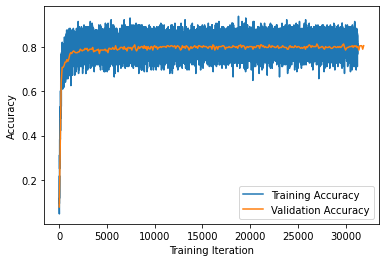

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()